
# GCTB: Calculating PRS with SBayesR

GCTB provides multiple models to calculate the PRS. In this documentation, we will look at the SBayesR model. For more details, visit the [SBayesR Tutorial](https://cnsgenomics.com/software/gctb/#SBayesRTutorial).

GCTB uses a linkage disequilibrium (LD) correlation matrix and GWAS file to calculate new BETAs using the SBayes algorithm. 

## Linkage Disequilibrium (LD) Correlation Matrix

### Calculating LD Matrix with Genotype Data

In this scenario, the genotype data is used to calculate the LD correlation matrix, and then the LD matrix and GWAS file are used to calculate new betas. GCTB offers three methods to calculate the LD matrix:

- Full chromosome-wise LD matrices
- Shrunk LD matrix
- Sparse LD matrix

When calculating the LD matrix using genotype data, the MCMC algorithm may not always converge. It is computationally expensive.



### Downloadable LD Matrices

GCTB allows the use of existing LD matrices to calculate posterior probabilities. The following LD matrices were computed based on 1.1 million common SNPs in a random sample of 50K unrelated individuals of European ancestry in the UK Biobank dataset, unless otherwise noted:

1. **Shrunk Sparse Matrix**: [ukbEURu_hm3_shrunk_sparse](https://zenodo.org/records/3350914#.XyFfnC17G8o)
2. **Shrunk Sparse LD Matrix (2.8 million common SNPs)**: 7z x ukb_50k_bigset_2.8M.zip [Link 1](https://zenodo.org/records/3375373#.XyFgOS17G8o), [Link 2](https://zenodo.org/api/records/3375373/files-archive)
3. **Sparse Matrix (including MHC regions)**: [ukbEURu_imp_v3_HM3_n50k.chisq10](https://cnsgenomics.com/data/GCTB/ukbEURu_imp_v3_HM3_n50k.chisq10.zip)
4. **Banded Matrix (including MHC regions)**: [band_ukb_10k_hm3](https://cnsgenomics.com/data/GCTB/band_ukb_10k_hm3.zip)


One can download these LD Matrices and save them in the folder `SBayesR_LDFrames`:

- `ukbEURu_hm3_shrunk_sparse`
 
- `ukbEURu_hm3_sparse-1.zip`
- `band_ukb_10k_hm3`
 
- `ukbEURu_imp_v3_HM3_n50k.chisq10`
- `ukb_50k_bigset_2.8M`
 
- `ukb_50k_bigset_2.8M.zip`
 

Make sure you are conducting the analysis for the European population and that the genomic build of the data is the same.


With the GWAS summary statistics in `.ma` format and the LD correlation matrix calculated, an SBayesR analysis can be performed by calling SBayesR:

```bash
gctb --sbayes R \
     --ldm ../ldm/sparse/chr22/1000G_eur_chr22.ldm.sparse \
     --pi 0.95,0.02,0.02,0.01 \
     --gamma 0.0,0.01,0.1,1 \
     --gwas-summary ../ma/sim_1.ma \
     --chain-length 10000 \
     --burn-in 2000 \
     --out-freq 10 \
     --out sim_1
```
## GCTB Hyperparameters

We considered the following hyperparameters from all options offered by GCTB:

- `--sbayes R`: Specifies the summary data-based Bayesian alphabet model for analysis. R and C are available models.
- `--pi 0.95,0.02,0.02,0.01`: Defines the starting values for each mixture component. The values must sum to 1.
- `--gamma 0,0.01,0.1,1`: Specifies gamma values for the variance of genetic effects `σ²β`. The vector length must match that in `--pi`.
- `--gwas-summary`: Path to the GWAS summary statistics in `.ma` format.

You can specify the above parameters in the GCTB command code. Additionally, we considered the following parameters:

### LD Matrix Construction Methods

- `--make-full-ldm`, `--make-shrunk-ldm`, `--make-sparse-ldm`: Constructs the LD matrix and correlation from the genotype data.

### Pre-existing LD Matrices

The following models use pre-existing LD matrices provided by GCTB, which can be downloaded:

- `band`, `uksparse`, `sparse`

### Bayesian Models

GCTB allows you to choose between the following Bayesian models:

- `R`, `C`

In GCTB, two Bayesian models are available: R and C. These models differ in how they handle SNP effect distributions:

Bayesian R model: This is a mixture model where SNP effects are modeled as a mixture of different normal distributions with different variances. The R model is flexible in estimating genetic effects, assuming some SNPs have large effects and others have smaller ones. The hyperparameters --pi and --gamma are used to control the mixture components and scaling factors for SNP effect variances.

Bayesian C model: Similar to R, but uses a different prior for SNP effect sizes. The specific prior for C places stronger constraints on the size of SNP effects, favoring models where fewer SNPs have large effects.

These models are part of GCTB’s toolbox to help capture the underlying genetic architecture of complex traits, accounting for different effect size distributions.

The new betas are stored in the `test.snpRes` file, containing the posterior statistics of SNP effects.


## GWAS file processing for GCTB-SBayesR 
When the effect size relates to disease risk and is thus given as an odds ratio (OR) rather than BETA (for continuous traits), the PRS is computed as a product of ORs. To simplify this calculation, take the natural logarithm of the OR so that the PRS can be computed using summation instead.

For continuous phenotype GWAS, the `SampleData1/SampleData1.gz` file should have BETAs, and for binary phenotypes, it should have OR instead of BETAs. If BETAs are not available, we convert OR to BETAs using `BETA = np.log(OR)` and convert BETAs to OR using `OR = np.exp(BETA)`.

`import numpy as np`; `np` is the NumPy module.




In [1]:
import os
import pandas as pd
import numpy as np
import sys
import os
import pandas as pd
import numpy as np

def check_phenotype_is_binary_or_continous(filedirec):
    # Read the processed quality controlled file for a phenotype
    df = pd.read_csv(filedirec+os.sep+filedirec+'_QC.fam',sep="\s+",header=None)
    column_values = df[5].unique()
 
    if len(set(column_values)) == 2:
        return "Binary"
    else:
        return "Continous"

    
#filedirec = sys.argv[1]

filedirec = "SampleData1"
#filedirec = "asthma_19"
#filedirec = "migraine_0"

# Read the GWAS file.
GWAS = filedirec + os.sep + filedirec+".gz"
df = pd.read_csv(GWAS,compression= "gzip",sep="\s+")

if "BETA" in df.columns.to_list():
    # For Continous Phenotype.
    df = df[['CHR', 'BP', 'SNP', 'A1', 'A2', 'N', 'SE', 'P', 'BETA', 'INFO', 'MAF']]

else:
    df["BETA"] = np.log(df["OR"])
    df = df[['CHR', 'BP', 'SNP', 'A1', 'A2', 'N', 'SE', 'P', 'BETA', 'INFO', 'MAF']]


df.to_csv(filedirec + os.sep +filedirec+".txt",sep="\t",index=False)
print(df.head().to_markdown())
print("Length of DataFrame!",len(df))

df_transformed = pd.DataFrame({
        'SNP': df['SNP'],
        'A1': df['A1'],
        'A2': df['A2'],
        'freq': df['MAF'],
        'b': df['BETA'],
        'se': df['SE'],
        'p': df['P'],
        'N': df['N']
})


# Save this file as it is being required by GCTA.
output_file = filedirec+os.sep+"SBayesR.ma"
df_transformed.to_csv(output_file,sep="\t",index=False)
print(df_transformed.head().to_markdown())
print("Length of DataFrame!",len(df_transformed))


 
 

|    |   CHR |     BP | SNP        | A1   | A2   |      N |         SE |        P |        BETA |     INFO |      MAF |
|---:|------:|-------:|:-----------|:-----|:-----|-------:|-----------:|---------:|------------:|---------:|---------:|
|  0 |     1 | 756604 | rs3131962  | A    | G    | 388028 | 0.00301666 | 0.483171 | -0.00211532 | 0.890558 | 0.36939  |
|  1 |     1 | 768448 | rs12562034 | A    | G    | 388028 | 0.00329472 | 0.834808 |  0.00068708 | 0.895894 | 0.336846 |
|  2 |     1 | 779322 | rs4040617  | G    | A    | 388028 | 0.00303344 | 0.42897  | -0.00239932 | 0.897508 | 0.377368 |
|  3 |     1 | 801536 | rs79373928 | G    | T    | 388028 | 0.00841324 | 0.808999 |  0.00203363 | 0.908963 | 0.483212 |
|  4 |     1 | 808631 | rs11240779 | G    | A    | 388028 | 0.00242821 | 0.590265 |  0.00130747 | 0.893213 | 0.45041  |
Length of DataFrame! 499617
|    | SNP        | A1   | A2   |     freq |           b |         se |        p |      N |
|---:|:-----------|:-----|:-----|-------

### Define Hyperparameters

Define hyperparameters to be optimized and set initial values.

### Extract Valid SNPs from Clumped File

For Windows, download `gwak`, and for Linux, the `awk` command is sufficient. For Windows, `GWAK` is required. You can download it from [here](https://sourceforge.net/projects/gnuwin32/). Get it and place it in the same directory.


### Execution Path

At this stage, we have the genotype training data `newtrainfilename = "train_data.QC"` and genotype test data `newtestfilename = "test_data.QC"`.

We modified the following variables:

1. `filedirec = "SampleData1"` or `filedirec = sys.argv[1]`
2. `foldnumber = "0"` or `foldnumber = sys.argv[2]` for HPC.

Only these two variables can be modified to execute the code for specific data and specific folds. Though the code can be executed separately for each fold on HPC and separately for each dataset, it is recommended to execute it for multiple diseases and one fold at a time.
Here’s the corrected text in Markdown format:

 
### P-values

PRS calculation relies on P-values. SNPs with low P-values, indicating a high degree of association with a specific trait, are considered for calculation.

You can modify the code below to consider a specific set of P-values and save the file in the same format.

We considered the following parameters:

- **Minimum P-value**: `1e-10`
- **Maximum P-value**: `1.0`
- **Minimum exponent**: `10`  (Minimum P-value in exponent)
- **Number of intervals**: `100`  (Number of intervals to be considered)

The code generates an array of logarithmically spaced P-values:

```python
import numpy as np
import os

minimumpvalue = 10  # Minimum exponent for P-values
numberofintervals = 100  # Number of intervals to be considered

allpvalues = np.logspace(-minimumpvalue, 0, numberofintervals, endpoint=True)  # Generating an array of logarithmically spaced P-values

print("Minimum P-value:", allpvalues[0])
print("Maximum P-value:", allpvalues[-1])

count = 1
with open(os.path.join(folddirec, 'range_list'), 'w') as file:
    for value in allpvalues:
        file.write(f'pv_{value} 0 {value}\n')  # Writing range information to the 'range_list' file
        count += 1

pvaluefile = os.path.join(folddirec, 'range_list')
```

In this code:
- `minimumpvalue` defines the minimum exponent for P-values.
- `numberofintervals` specifies how many intervals to consider.
- `allpvalues` generates an array of P-values spaced logarithmically.
- The script writes these P-values to a file named `range_list` in the specified directory.
 

In [2]:
from operator import index
import pandas as pd
import numpy as np
import os
import subprocess
import sys
import pandas as pd
import statsmodels.api as sm
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix
from statsmodels.stats.contingency_tables import mcnemar

def create_directory(directory):
    """Function to create a directory if it doesn't exist."""
    if not os.path.exists(directory):  # Checking if the directory doesn't exist
        os.makedirs(directory)  # Creating the directory if it doesn't exist
    return directory  # Returning the created or existing directory

 
#foldnumber = sys.argv[1]
foldnumber = "0"  # Setting 'foldnumber' to "0"

folddirec = filedirec + os.sep + "Fold_" + foldnumber  # Creating a directory path for the specific fold
trainfilename = "train_data"  # Setting the name of the training data file
newtrainfilename = "train_data.QC"  # Setting the name of the new training data file

testfilename = "test_data"  # Setting the name of the test data file
newtestfilename = "test_data.QC"  # Setting the name of the new test data file

# Number of PCA to be included as a covariate.
numberofpca = ["6"]  # Setting the number of PCA components to be included

# Clumping parameters.
clump_p1 = [1]  # List containing clump parameter 'p1'
clump_r2 = [0.1]  # List containing clump parameter 'r2'
clump_kb = [200]  # List containing clump parameter 'kb'

# Pruning parameters.
p_window_size = [200]  # List containing pruning parameter 'window_size'
p_slide_size = [50]  # List containing pruning parameter 'slide_size'
p_LD_threshold = [0.25]  # List containing pruning parameter 'LD_threshold'

# Kindly note that the number of p-values to be considered varies, and the actual p-value depends on the dataset as well.
# We will specify the range list here.

minimumpvalue = 10  # Minimum p-value in exponent
numberofintervals = 20  # Number of intervals to be considered
allpvalues = np.logspace(-minimumpvalue, 0, numberofintervals, endpoint=True)  # Generating an array of logarithmically spaced p-values
count = 1

with open(folddirec + os.sep + 'range_list', 'w') as file:
    for value in allpvalues:
        file.write(f'pv_{value} 0 {value}\n')  # Writing range information to the 'range_list' file
        count = count + 1

pvaluefile = folddirec + os.sep + 'range_list'
buriniteration = 100
chainlength = 10000

# Initializing an empty DataFrame with specified column names
prs_result = pd.DataFrame(columns=["clump_p1", "clump_r2", "clump_kb", "bayesmodel","p_window_size", "p_slide_size", "p_LD_threshold",
                                   "pvalue", "model","numberofpca","h2","lambda","numberofvariants(m)","Train_pure_prs", "Train_null_model", "Train_best_model",
                                   "Test_pure_prs", "Test_null_model", "Test_best_model"])

### Define Helper Functions

1. **Perform Clumping and Pruning**
2. **Calculate PCA Using Plink**
3. **Fit Binary Phenotype and Save Results**
4. **Fit Continuous Phenotype and Save Results**


In [3]:
import os
import subprocess
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import explained_variance_score


def perform_clumping_and_pruning_on_individual_data(traindirec, newtrainfilename,numberofpca, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile):
    
    command = [
    "./plink",
    "--bfile", traindirec+os.sep+newtrainfilename,
    "--indep-pairwise", p1_val, p2_val, p3_val,
    "--out", traindirec+os.sep+trainfilename
    ]
    subprocess.run(command)
    # First perform pruning and then clumping and the pruning.

    command = [
    "./plink",
    "--bfile", traindirec+os.sep+newtrainfilename,
    "--clump-p1", c1_val,
    "--extract", traindirec+os.sep+trainfilename+".prune.in",
    "--clump-r2", c2_val,
    "--clump-kb", c3_val,
    "--clump", filedirec+os.sep+filedirec+".txt",
    "--clump-snp-field", "SNP",
    "--clump-field", "P",
    "--out", traindirec+os.sep+trainfilename
    ]    
    subprocess.run(command)

    # Extract the valid SNPs from th clumped file.
    # For windows download gwak for linux awk commmand is sufficient.
    ### For windows require GWAK.
    ### https://sourceforge.net/projects/gnuwin32/
    ##3 Get it and place it in the same direc.
    #os.system("gawk "+"\""+"NR!=1{print $3}"+"\"  "+ traindirec+os.sep+trainfilename+".clumped >  "+traindirec+os.sep+trainfilename+".valid.snp")
    #print("gawk "+"\""+"NR!=1{print $3}"+"\"  "+ traindirec+os.sep+trainfilename+".clumped >  "+traindirec+os.sep+trainfilename+".valid.snp")

    #Linux:
    command = f"awk 'NR!=1{{print $3}}' {traindirec}{os.sep}{trainfilename}.clumped > {traindirec}{os.sep}{trainfilename}.valid.snp"
    os.system(command)

    
    command = [
    "./plink",
    "--make-bed",
    "--bfile", traindirec+os.sep+newtrainfilename,
    "--indep-pairwise", p1_val, p2_val, p3_val,
    "--extract", traindirec+os.sep+trainfilename+".valid.snp",
    "--out", traindirec+os.sep+newtrainfilename+".clumped.pruned"
    ]
    subprocess.run(command)
    
    command = [
    "./plink",
    "--make-bed",
    "--bfile", traindirec+os.sep+testfilename,
    "--indep-pairwise", p1_val, p2_val, p3_val,
    "--extract", traindirec+os.sep+trainfilename+".valid.snp",
    "--out", traindirec+os.sep+testfilename+".clumped.pruned"
    ]
    subprocess.run(command)    
    
    
 
def calculate_pca_for_traindata_testdata_for_clumped_pruned_snps(traindirec, newtrainfilename,p):
    
    # Calculate the PRS for the test data using the same set of SNPs and also calculate the PCA.


    # Also extract the PCA at this point.
    # PCA are calculated afer clumping and pruining.
    command = [
        "./plink",
        "--bfile", folddirec+os.sep+testfilename+".clumped.pruned",
        # Select the final variants after clumping and pruning.
        "--extract", traindirec+os.sep+trainfilename+".valid.snp",
        "--pca", p,
        "--out", folddirec+os.sep+testfilename
    ]
    subprocess.run(command)


    command = [
    "./plink",
        "--bfile", traindirec+os.sep+newtrainfilename+".clumped.pruned",
        # Select the final variants after clumping and pruning.        
        "--extract", traindirec+os.sep+trainfilename+".valid.snp",
        "--pca", p,
        "--out", traindirec+os.sep+trainfilename
    ]
    subprocess.run(command)

# This function fit the binary model on the PRS.
def fit_binary_phenotype_on_PRS(traindirec, newtrainfilename,models, p,bayesmodel, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile):
    threshold_values = allpvalues

    # Merge the covariates, pca and phenotypes.
    tempphenotype_train = pd.read_table(traindirec+os.sep+newtrainfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype_train = pd.DataFrame()
    phenotype_train["Phenotype"] = tempphenotype_train[5].values
    pcs_train = pd.read_table(traindirec+os.sep+trainfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_train = pd.read_table(traindirec+os.sep+trainfilename+".cov",sep="\s+")
    covariate_train.fillna(0, inplace=True)
    covariate_train = covariate_train[covariate_train["FID"].isin(pcs_train["FID"].values) & covariate_train["IID"].isin(pcs_train["IID"].values)]
    covariate_train['FID'] = covariate_train['FID'].astype(str)
    pcs_train['FID'] = pcs_train['FID'].astype(str)
    covariate_train['IID'] = covariate_train['IID'].astype(str)
    pcs_train['IID'] = pcs_train['IID'].astype(str)
    covandpcs_train = pd.merge(covariate_train, pcs_train, on=["FID","IID"])
    covandpcs_train.fillna(0, inplace=True)


    ## Scale the covariates!
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import explained_variance_score
    scaler = MinMaxScaler()
    normalized_values_train = scaler.fit_transform(covandpcs_train.iloc[:, 2:])
    #covandpcs_train.iloc[:, 2:] = normalized_values_test 
    
    
    tempphenotype_test = pd.read_table(traindirec+os.sep+testfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype_test= pd.DataFrame()
    phenotype_test["Phenotype"] = tempphenotype_test[5].values
    pcs_test = pd.read_table(traindirec+os.sep+testfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_test = pd.read_table(traindirec+os.sep+testfilename+".cov",sep="\s+")
    covariate_test.fillna(0, inplace=True)
    covariate_test = covariate_test[covariate_test["FID"].isin(pcs_test["FID"].values) & covariate_test["IID"].isin(pcs_test["IID"].values)]
    covariate_test['FID'] = covariate_test['FID'].astype(str)
    pcs_test['FID'] = pcs_test['FID'].astype(str)
    covariate_test['IID'] = covariate_test['IID'].astype(str)
    pcs_test['IID'] = pcs_test['IID'].astype(str)
    covandpcs_test = pd.merge(covariate_test, pcs_test, on=["FID","IID"])
    covandpcs_test.fillna(0, inplace=True)
    normalized_values_test  = scaler.transform(covandpcs_test.iloc[:, 2:])
    #covandpcs_test.iloc[:, 2:] = normalized_values_test     
    
    
    
    
    tempalphas = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    l1weights = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

    tempalphas = [0.1]
    l1weights = [0.1]

    phenotype_train["Phenotype"] = phenotype_train["Phenotype"].replace({1: 0, 2: 1}) 
    phenotype_test["Phenotype"] = phenotype_test["Phenotype"].replace({1: 0, 2: 1})
      
    for tempalpha in tempalphas:
        for l1weight in l1weights:

            
            try:
                null_model =  sm.Logit(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit_regularized(alpha=tempalpha, L1_wt=l1weight)
                #null_model =  sm.Logit(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit()
            
            except:
                print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
                continue

            train_null_predicted = null_model.predict(sm.add_constant(covandpcs_train.iloc[:, 2:]))
            
            from sklearn.metrics import roc_auc_score, confusion_matrix
            from sklearn.metrics import r2_score
            
            test_null_predicted = null_model.predict(sm.add_constant(covandpcs_test.iloc[:, 2:]))
            
           
            
            global prs_result 
            for i in threshold_values:
                try:
                    prs_train = pd.read_table(traindirec+os.sep+Name+os.sep+"train_data.pv_"+f"{i}.profile", sep="\s+", usecols=["FID", "IID", "SCORE"])
                except:
                    continue

                prs_train['FID'] = prs_train['FID'].astype(str)
                prs_train['IID'] = prs_train['IID'].astype(str)
                try:
                    prs_test = pd.read_table(traindirec+os.sep+Name+os.sep+"test_data.pv_"+f"{i}.profile", sep="\s+", usecols=["FID", "IID", "SCORE"])
                except:
                    continue
                prs_test['FID'] = prs_test['FID'].astype(str)
                prs_test['IID'] = prs_test['IID'].astype(str)
                pheno_prs_train = pd.merge(covandpcs_train, prs_train, on=["FID", "IID"])
                pheno_prs_test = pd.merge(covandpcs_test, prs_test, on=["FID", "IID"])
        
                try:
                    model = sm.Logit(phenotype_train["Phenotype"], sm.add_constant(pheno_prs_train.iloc[:, 2:])).fit_regularized(alpha=tempalpha, L1_wt=l1weight)
                    #model = sm.Logit(phenotype_train["Phenotype"], sm.add_constant(pheno_prs_train.iloc[:, 2:])).fit()
                
                except:
                    continue


                
                train_best_predicted = model.predict(sm.add_constant(pheno_prs_train.iloc[:, 2:]))    
 

                test_best_predicted = model.predict(sm.add_constant(pheno_prs_test.iloc[:, 2:])) 
 
        
                from sklearn.metrics import roc_auc_score, confusion_matrix

                prs_result = prs_result._append({
                    "clump_p1": c1_val,
                    "clump_r2": c2_val,
                    "clump_kb": c3_val,
                    "p_window_size": p1_val,
                    "p_slide_size": p2_val,
                    "p_LD_threshold": p3_val,
                    "pvalue": i,
                    "numberofpca":p, 

                    "tempalpha":str(tempalpha),
                    "l1weight":str(l1weight),
                    "numberofvariants": len(pd.read_csv(traindirec+os.sep+newtrainfilename+".clumped.pruned.bim")),
                             
                    "gctb_ld_model":models,
                    #"h2":tempdata,
                    #"lambda":_lambda1,
                    "BayesModel":bayesmodel,
                     

                    "Train_pure_prs":roc_auc_score(phenotype_train["Phenotype"].values,prs_train['SCORE'].values),
                    "Train_null_model":roc_auc_score(phenotype_train["Phenotype"].values,train_null_predicted.values),
                    "Train_best_model":roc_auc_score(phenotype_train["Phenotype"].values,train_best_predicted.values),
                    
                    "Test_pure_prs":roc_auc_score(phenotype_test["Phenotype"].values,prs_test['SCORE'].values),
                    "Test_null_model":roc_auc_score(phenotype_test["Phenotype"].values,test_null_predicted.values),
                    "Test_best_model":roc_auc_score(phenotype_test["Phenotype"].values,test_best_predicted.values),
                    
                }, ignore_index=True)

          
                prs_result.to_csv(traindirec+os.sep+Name+os.sep+"Results.csv",index=False)
     
    return

# This function fit the binary model on the PRS.
def fit_continous_phenotype_on_PRS(traindirec, newtrainfilename,models, p,bayesmodel, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile):
    threshold_values = allpvalues

    # Merge the covariates, pca and phenotypes.
    tempphenotype_train = pd.read_table(traindirec+os.sep+newtrainfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype_train = pd.DataFrame()
    phenotype_train["Phenotype"] = tempphenotype_train[5].values
    pcs_train = pd.read_table(traindirec+os.sep+trainfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_train = pd.read_table(traindirec+os.sep+trainfilename+".cov",sep="\s+")
    covariate_train.fillna(0, inplace=True)
    covariate_train = covariate_train[covariate_train["FID"].isin(pcs_train["FID"].values) & covariate_train["IID"].isin(pcs_train["IID"].values)]
    covariate_train['FID'] = covariate_train['FID'].astype(str)
    pcs_train['FID'] = pcs_train['FID'].astype(str)
    covariate_train['IID'] = covariate_train['IID'].astype(str)
    pcs_train['IID'] = pcs_train['IID'].astype(str)
    covandpcs_train = pd.merge(covariate_train, pcs_train, on=["FID","IID"])
    covandpcs_train.fillna(0, inplace=True)


    ## Scale the covariates!
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import explained_variance_score
    scaler = MinMaxScaler()
    normalized_values_train = scaler.fit_transform(covandpcs_train.iloc[:, 2:])
    #covandpcs_train.iloc[:, 2:] = normalized_values_test 
    
    tempphenotype_test = pd.read_table(traindirec+os.sep+testfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype_test= pd.DataFrame()
    phenotype_test["Phenotype"] = tempphenotype_test[5].values
    pcs_test = pd.read_table(traindirec+os.sep+testfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_test = pd.read_table(traindirec+os.sep+testfilename+".cov",sep="\s+")
    covariate_test.fillna(0, inplace=True)
    covariate_test = covariate_test[covariate_test["FID"].isin(pcs_test["FID"].values) & covariate_test["IID"].isin(pcs_test["IID"].values)]
    covariate_test['FID'] = covariate_test['FID'].astype(str)
    pcs_test['FID'] = pcs_test['FID'].astype(str)
    covariate_test['IID'] = covariate_test['IID'].astype(str)
    pcs_test['IID'] = pcs_test['IID'].astype(str)
    covandpcs_test = pd.merge(covariate_test, pcs_test, on=["FID","IID"])
    covandpcs_test.fillna(0, inplace=True)
    normalized_values_test  = scaler.transform(covandpcs_test.iloc[:, 2:])
    #covandpcs_test.iloc[:, 2:] = normalized_values_test     
    
    
    
    
    tempalphas = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    l1weights = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

    tempalphas = [0.1]
    l1weights = [0.1]

    #phenotype_train["Phenotype"] = phenotype_train["Phenotype"].replace({1: 0, 2: 1}) 
    #phenotype_test["Phenotype"] = phenotype_test["Phenotype"].replace({1: 0, 2: 1})
      
    for tempalpha in tempalphas:
        for l1weight in l1weights:

            
            try:
                #null_model =  sm.OLS(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit_regularized(alpha=tempalpha, L1_wt=l1weight)
                null_model =  sm.OLS(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit()
                #null_model =  sm.OLS(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit()
            except:
                print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
                continue

            train_null_predicted = null_model.predict(sm.add_constant(covandpcs_train.iloc[:, 2:]))
            
            from sklearn.metrics import roc_auc_score, confusion_matrix
            from sklearn.metrics import r2_score
            
            test_null_predicted = null_model.predict(sm.add_constant(covandpcs_test.iloc[:, 2:]))
            
            
            
            global prs_result 
            for i in threshold_values:
                try:
                    prs_train = pd.read_table(traindirec+os.sep+Name+os.sep+"train_data.pv_"+f"{i}.profile", sep="\s+", usecols=["FID", "IID", "SCORE"])
                except:
                    continue

                prs_train['FID'] = prs_train['FID'].astype(str)
                prs_train['IID'] = prs_train['IID'].astype(str)
                try:
                    prs_test = pd.read_table(traindirec+os.sep+Name+os.sep+"test_data.pv_"+f"{i}.profile", sep="\s+", usecols=["FID", "IID", "SCORE"])
                except:
                    continue
                prs_test['FID'] = prs_test['FID'].astype(str)
                prs_test['IID'] = prs_test['IID'].astype(str)
                pheno_prs_train = pd.merge(covandpcs_train, prs_train, on=["FID", "IID"])
                pheno_prs_test = pd.merge(covandpcs_test, prs_test, on=["FID", "IID"])
        
                try:
                    #model = sm.OLS(phenotype_train["Phenotype"], sm.add_constant(pheno_prs_train.iloc[:, 2:])).fit_regularized(alpha=tempalpha, L1_wt=l1weight)
                    model = sm.OLS(phenotype_train["Phenotype"], sm.add_constant(pheno_prs_train.iloc[:, 2:])).fit()
                
                except:
                    continue


                
                train_best_predicted = model.predict(sm.add_constant(pheno_prs_train.iloc[:, 2:]))    
                test_best_predicted = model.predict(sm.add_constant(pheno_prs_test.iloc[:, 2:])) 
 
        
                from sklearn.metrics import roc_auc_score, confusion_matrix

                prs_result = prs_result._append({
                    "clump_p1": c1_val,
                    "clump_r2": c2_val,
                    "clump_kb": c3_val,
                    "p_window_size": p1_val,
                    "p_slide_size": p2_val,
                    "p_LD_threshold": p3_val,
                    "pvalue": i,
                    "numberofpca":p, 

                    "tempalpha":str(tempalpha),
                    "l1weight":str(l1weight),
                    "numberofvariants": len(pd.read_csv(traindirec+os.sep+newtrainfilename+".clumped.pruned.bim")),
                    "gctb_ld_model":models,
                    #"h2":tempdata,
                    #"lambda":_lambda1,
                    "BayesModel":bayesmodel,               

                    "Train_pure_prs":explained_variance_score(phenotype_train["Phenotype"],prs_train['SCORE'].values),
                    "Train_null_model":explained_variance_score(phenotype_train["Phenotype"],train_null_predicted),
                    "Train_best_model":explained_variance_score(phenotype_train["Phenotype"],train_best_predicted),
                    
                    "Test_pure_prs":explained_variance_score(phenotype_test["Phenotype"],prs_test['SCORE'].values),
                    "Test_null_model":explained_variance_score(phenotype_test["Phenotype"],test_null_predicted),
                    "Test_best_model":explained_variance_score(phenotype_test["Phenotype"],test_best_predicted),
                    
                }, ignore_index=True)

          
                prs_result.to_csv(traindirec+os.sep+Name+os.sep+"Results.csv",index=False)
     
    return


## Execute GCTB-SBayesR

In [4]:
def transform_SBayesR_data(traindirec, newtrainfilename,models,p,bayesmodel, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile):
    ### First perform clumping on the file and save the clumpled file.
    #perform_clumping_and_pruning_on_individual_data(traindirec, newtrainfilename,p, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile)
    
 
    # Also extract the PCA at this point for both test and training data.
    #calculate_pca_for_traindata_testdata_for_clumped_pruned_snps(traindirec, newtrainfilename,p)

    #Extract p-values from the GWAS file.
    os.system("awk "+"\'"+"{print $3,$8}"+"\'"+" ./"+filedirec+os.sep+filedirec+".txt >  ./"+traindirec+os.sep+"SNP.pvalue")
     
    # At this stage, we will merge the PCA and COV file. 
    tempphenotype_train = pd.read_table(traindirec+os.sep+newtrainfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype = pd.DataFrame()
    phenotype = tempphenotype_train[[0,1,5]]
    phenotype.to_csv(traindirec+os.sep+trainfilename+".PHENO",sep="\t",header=['FID', 'IID', 'PHENO'],index=False)
 
    pcs_train = pd.read_table(traindirec+os.sep+trainfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_train = pd.read_table(traindirec+os.sep+trainfilename+".cov",sep="\s+")
    covariate_train.fillna(0, inplace=True)
    print(covariate_train.head())
    print(len(covariate_train))
    covariate_train = covariate_train[covariate_train["FID"].isin(pcs_train["FID"].values) & covariate_train["IID"].isin(pcs_train["IID"].values)]
    print(len(covariate_train))
 
    covariate_train['FID'] = covariate_train['FID'].astype(str)
    pcs_train['FID'] = pcs_train['FID'].astype(str)
    covariate_train['IID'] = covariate_train['IID'].astype(str)
    pcs_train['IID'] = pcs_train['IID'].astype(str)
    covandpcs_train = pd.merge(covariate_train, pcs_train, on=["FID","IID"])
    covandpcs_train.to_csv(traindirec+os.sep+trainfilename+".COV_PCA",sep="\t",index=False)

    # Define the paths to the files
    # Delete the files generated in the previous iterations.
    
    files_to_remove = [
        traindirec+os.sep+"SBayes_R_custom_full",
        filedirec+os.sep+"SBayes_R_custom_shrunk",
        traindirec+os.sep+"SBayes_R_custom_sparse",
        traindirec+os.sep+trainfilename+"_"+"uksparse_all",
        traindirec+os.sep+trainfilename+"_"+"sparse_all.snpRes",   
    ]

    # Loop through the files and remove them if they exist
    for file_path in files_to_remove:
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f"Removed: {file_path}")
        else:
            print(f"File does not exist: {file_path}")

            
    
    for chromosome in range(1, 23):
        # Plink command to split by chromosome
        plink_command = [
            "./plink",
            "--bfile", traindirec+os.sep+newtrainfilename+".clumped.pruned",
            "--chr", str(chromosome),
            "--make-bed",
            "--out", traindirec+os.sep+newtrainfilename+".clumped.pruned."+str(chromosome),
        ]
        
        # Run the Plink command
        subprocess.run(plink_command)

    ne = pd.read_csv(traindirec+os.sep+newtrainfilename+".clumped.pruned.fam")
    ne = len(ne)
    # Run the command
    allgwasdirec = ""
    if models =="--make-full-ldm":
        tempdf = []
        # First we need to split the bed data for each chromosome and store that information.
        create_directory(traindirec+os.sep+"LDfull")
        for chromosome in range(1, 23):
            command = [
                "./gctb",
                "--bfile", traindirec+os.sep+newtrainfilename+".clumped.pruned."+str(chromosome),
                "--make-full-ldm",
                "--ne",str(ne),
                "--out",  traindirec+os.sep+"LDfull"+os.sep+str(chromosome)
            ]
            print(" ".join(command))
            subprocess.run(command)
            command = [
                            "./gctb",
                            "--sbayes", bayesmodel,
                            #"--ldm", "ukbEURu_imp_v3_HM3_n50k.chisq10"+os.sep+"ukbEURu_imp_v3_HM3_n50k.chisq10.ldm.sparse",
                            #"--ldm", traindirec+os.sep+trainfilename+"_LD",
                            "--ldm", traindirec+os.sep+"LDfull"+os.sep+str(chromosome)+".ldm.full",
                            "--pi", str(0.95)+","+str(0.02)+","+str(0.02)+","+str(0.01),
                            "--gamma", str(0)+","+str(0.01)+","+str(0.1)+","+str(1),
                            "--unscale-genotype",
                            "--gwas-summary",filedirec+os.sep+"SBayesR.ma",
                            "--chain-length", str(chainlength),
                            "--burn-in", str(buriniteration),
                            "--out-freq", str(10),
                            "--out",traindirec+os.sep+"LDfull"+os.sep+str(chromosome)+"_full"
                        ]
            print(" ".join(command))
            subprocess.run(command)
            tempdata = traindirec+os.sep+"LDfull"+os.sep+str(chromosome)+"_full"+".snpRes"    
            tempdf.append(pd.read_csv(tempdata,sep="\s+"))
            
        result_df = pd.concat(tempdf, ignore_index=True)
        allgwasdirec = traindirec+os.sep+"SBayes_R_custom_full"
        result_df.to_csv(traindirec+os.sep+"SBayes_R_custom_full",sep="\t",index=False)
        

    #raise
    if models =="--make-shrunk-ldm":
        tempdf = []
        # First we need to split the bed data for each chromosome and store that information.
        create_directory(traindirec+os.sep+"LDfull")
        for chromosome in range(1, 23):
            command = [
                "./gctb",
                "--bfile", traindirec+os.sep+newtrainfilename+".clumped.pruned."+str(chromosome),
                "--gen-map","chr"+str(chromosome)+".OMNI.interpolated_genetic_map",
                "--make-shrunk-ldm",
                 "--ne",str(ne),
                "--out",  traindirec+os.sep+"LDfull"+os.sep+str(chromosome)
            ]
            print(" ".join(command))
            subprocess.run(command)
            command = [
                            "./gctb",
                            "--sbayes", bayesmodel,
                            #"--ldm", "ukbEURu_imp_v3_HM3_n50k.chisq10"+os.sep+"ukbEURu_imp_v3_HM3_n50k.chisq10.ldm.sparse",
                            #"--ldm", traindirec+os.sep+trainfilename+"_LD",
                            "--ldm", traindirec+os.sep+"LDfull"+os.sep+str(chromosome)+".ldm.shrunk",
                            "--pi", str(0.95)+","+str(0.02)+","+str(0.02)+","+str(0.01),
                            "--gamma", str(0)+","+str(0.01)+","+str(0.1)+","+str(1),
                            "--gwas-summary",filedirec+os.sep+"SBayesR.ma",
                            #"--unscale-genotype",
                            "--chain-length", str(chainlength),
                            "--burn-in", str(buriniteration),
                            "--out-freq", str(10),
                            "--out",traindirec+os.sep+"LDfull"+os.sep+str(chromosome)+"_shrunk"
                        ]
            #print(" ".join(command))
            subprocess.run(command)
            tempdata = traindirec+os.sep+"LDfull"+os.sep+str(chromosome)+"_shrunk"+".snpRes"  
            tempdf.append(pd.read_csv(tempdata,sep="\s+"))
            
        result_df = pd.concat(tempdf, ignore_index=True)
        allgwasdirec = filedirec+os.sep+"SBayes_R_custom_shrunk"
        result_df.to_csv(filedirec+os.sep+"SBayes_R_custom_shrunk",sep="\t",index=False)
    #raise    
    if models =="--make-sparse-ldm":
        tempdf = []
        # First we need to split the bed data for each chromosome and store that information.
        create_directory(traindirec+os.sep+"LDfull")
        for chromosome in range(1, 23):
            command = [
                "./gctb",
                "--bfile", traindirec+os.sep+newtrainfilename+".clumped.pruned."+str(chromosome),
                "--make-sparse-ldm",
                  "--ne",str(ne),
                "--out",  traindirec+os.sep+"LDfull"+os.sep+str(chromosome)
            ]
            print(" ".join(command))
            subprocess.run(command)
            command = [
                            "./gctb",
                            "--sbayes", bayesmodel,
                            #"--ldm", "ukbEURu_imp_v3_HM3_n50k.chisq10"+os.sep+"ukbEURu_imp_v3_HM3_n50k.chisq10.ldm.sparse",
                            #"--ldm", traindirec+os.sep+trainfilename+"_LD",
                            "--ldm", traindirec+os.sep+"LDfull"+os.sep+str(chromosome)+".ldm.sparse",
                            "--pi", str(0.95)+","+str(0.02)+","+str(0.02)+","+str(0.01),
                            "--gamma", str(0)+","+str(0.01)+","+str(0.1)+","+str(1),
                            "--gwas-summary",filedirec+os.sep+"SBayesR.ma",
                            "--chain-length", str(chainlength),
                            #"--unscale-genotype",
                            "--burn-in", str(buriniteration),
                            "--out-freq", str(10),
                            "--out",traindirec+os.sep+"LDfull"+os.sep+str(chromosome)+"_sparse"
                        ]
            #print(" ".join(command))
            subprocess.run(command)
            tempdata = traindirec+os.sep+"LDfull"+os.sep+str(chromosome)+"_sparse"+".snpRes"    
            tempdf.append(pd.read_csv(tempdata,sep="\s+"))
            
        result_df = pd.concat(tempdf, ignore_index=True)
        allgwasdirec = traindirec+os.sep+"SBayes_R_custom_sparse"
        result_df.to_csv(traindirec+os.sep+"SBayes_R_custom_sparse",sep="\t",index=False)
    #return
    
    ldpath = "SBayesR_LDFrames/"
    if models=="band":
        pi = "0.95,0.02,0.02,0.01"
        for loop in range(1,23):
            command = [
                "./gctb",
                "--sbayes", bayesmodel,
                #"--ldm", "ukbEURu_imp_v3_HM3_n50k.chisq10"+os.sep+"ukbEURu_imp_v3_HM3_n50k.chisq10.ldm.sparse",
                #"--ldm", traindirec+os.sep+trainfilename+"_LD",
                "--ldm", ldpath+os.sep+"band_ukb_10k_hm3"+os.sep+"band_chr"+str(loop)+".ldm.sparse",
                "--pi", str(0.95)+","+str(0.02)+","+str(0.02)+","+str(0.01),
                "--gamma", str(0)+","+str(0.01)+","+str(0.1)+","+str(1),
                "--gwas-summary",filedirec+os.sep+"SBayesR.ma",
                "--chain-length", str(chainlength),
                "--unscale-genotype",
                "--burn-in", str(buriniteration),
                "--out-freq", str(10),
                "--out",traindirec+os.sep+trainfilename+"_"+str(loop)+"_"+"band"
            ]
            #print(" ".join(command))
            subprocess.run(command)
        tempdf = []
        for loop in range(1,23):
            tempdata = traindirec+os.sep+trainfilename+"_"+str(loop)+"_"+"band.snpRes"    
            tempdf.append(pd.read_csv(tempdata,sep="\s+"))
            
        result_df = pd.concat(tempdf, ignore_index=True)
        allgwasdirec = traindirec+os.sep+trainfilename+"_"+"band_all"
        result_df.to_csv(traindirec+os.sep+trainfilename+"_"+"band_all",sep="\t",index=False)

    if models=="uksparse":
        pi = "0.95,0.02,0.02,0.01"
        for loop in range(1,23):
            command = [
                "./gctb",
                "--sbayes", bayesmodel,
                #"--ldm", "ukbEURu_imp_v3_HM3_n50k.chisq10"+os.sep+"ukbEURu_imp_v3_HM3_n50k.chisq10.ldm.sparse",
                #"--ldm", traindirec+os.sep+trainfilename+"_LD",
                "--ldm", ldpath+os.sep+"ukbEURu_hm3_shrunk_sparse"+os.sep+"ukbEURu_hm3_chr"+str(loop)+"_v3_50k.ldm.sparse",
                "--pi", str(0.95)+","+str(0.02)+","+str(0.02)+","+str(0.01),
                "--gamma", str(0)+","+str(0.01)+","+str(0.1)+","+str(1),
                "--gwas-summary",filedirec+os.sep+"SBayesR.ma",
                "--chain-length", str(chainlength),
                "--unscale-genotype",
                "--burn-in", str(buriniteration),
                "--out-freq", str(10),
                "--out",traindirec+os.sep+trainfilename+"_"+str(loop)+"_"+"uksparse"
            ]
            #print(" ".join(command))
            subprocess.run(command)
        tempdf = []
        for loop in range(1,23):
            tempdata = traindirec+os.sep+trainfilename+"_"+str(loop)+"_"+"uksparse.snpRes"    
            tempdf.append(pd.read_csv(tempdata,sep="\s+"))
            
        result_df = pd.concat(tempdf, ignore_index=True)
        allgwasdirec = traindirec+os.sep+trainfilename+"_"+"uksparse_all"
        result_df.to_csv(traindirec+os.sep+trainfilename+"_"+"uksparse_all",sep="\t",index=False)    

    if models=="sparse":
         
       
        command = [
            "./gctb",
            "--sbayes", bayesmodel,
            #"--ldm", "ukbEURu_imp_v3_HM3_n50k.chisq10"+os.sep+"ukbEURu_imp_v3_HM3_n50k.chisq10.ldm.sparse",
            #"--ldm", traindirec+os.sep+trainfilename+"_LD",
            "--ldm", ldpath+os.sep+"ukbEURu_imp_v3_HM3_n50k.chisq10"+os.sep+"ukbEURu_imp_v3_HM3_n50k.chisq10.ldm.sparse",
            "--pi", str(0.95)+","+str(0.02)+","+str(0.02)+","+str(0.01),
            "--gamma", str(0)+","+str(0.01)+","+str(0.1)+","+str(1),
            "--gwas-summary",filedirec+os.sep+"SBayesR.ma",
            "--chain-length", str(chainlength),
            #"--unscale-genotype",
            "--burn-in", str(buriniteration),
            "--out-freq", str(10),
            "--out",traindirec+os.sep+trainfilename  +"_"+"sparse_all"
        ]
        print(traindirec+os.sep+trainfilename  +"_"+"sparse_all")
        print(" ".join(command))
        subprocess.run(command)
         
        allgwasdirec = traindirec+os.sep+trainfilename+"_"+"sparse_all.snpRes"
        #result_df.to_csv(traindirec+os.sep+trainfilename+"_"+"sparse_all.snpRes",sep="\t",index=False) 
    #raise   
    try:
        tempgwas = pd.read_csv(allgwasdirec,sep="\s+" )
    except:
        print("GWAS not generated!")
        return 
    
    
    
    if check_phenotype_is_binary_or_continous(filedirec)=="Binary":
        tempgwas["LastSampleEff"] = np.exp(tempgwas["LastSampleEff"])
        tempgwas = tempgwas.fillna(0)
        tempgwas = tempgwas.replace([np.inf, -np.inf], 0)
    else:
        pass
    
    # Select columns 2, 5, and 8 (Python uses zero-based indexing, so adjust accordingly)
    selected_columns = tempgwas.iloc[:, [1, 4, 7]]

    # Save the selected columns to a file
    selected_columns.to_csv(allgwasdirec+"_modified", sep="\t", index=False)
    
    command = [
        "./plink",
         "--bfile", traindirec+os.sep+newtrainfilename+".clumped.pruned",
        ### SNP column = 1, Effect allele column 2 = 4, Effect column=4
        "--score", allgwasdirec+"_modified", "1", "2", "3", "header",
        "--q-score-range", traindirec+os.sep+"range_list",traindirec+os.sep+"SNP.pvalue",
        #"--extract", traindirec+os.sep+trainfilename+".valid.snp",
        "--out", traindirec+os.sep+Name+os.sep+trainfilename
    ]
    #exit(0)
    subprocess.run(command)

 

    command = [
        "./plink",
        "--bfile", folddirec+os.sep+testfilename,
        ### SNP column = 3, Effect allele column 1 = 4, Beta column=12
        "--score", allgwasdirec+"_modified", "1", "2", "3", "header",
        "--q-score-range", traindirec+os.sep+"range_list",traindirec+os.sep+"SNP.pvalue",
        "--out", folddirec+os.sep+Name+os.sep+testfilename
    ]
    subprocess.run(command)


    if check_phenotype_is_binary_or_continous(filedirec)=="Binary":
        print("Binary Phenotype!")
        fit_binary_phenotype_on_PRS(traindirec, newtrainfilename,models, p,bayesmodel, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile)
    else:
        print("Continous Phenotype!")
        fit_continous_phenotype_on_PRS(traindirec, newtrainfilename,models, p,bayesmodel, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile)
            
    return 
 

# Make LD from genotype data.
frombedldmodels = ["--make-full-ldm","--make-shrunk-ldm","--make-sparse-ldm","band","uksparse","sparse"]
 
frombedldmodels = [ "band","uksparse","sparse"  ]
 
bayesmodels = ["R","C"]
 


result_directory = "GCTB-SBayesR"
# Nested loops to iterate over different parameter values
create_directory(folddirec+os.sep+result_directory)
for p1_val in p_window_size:
 for p2_val in p_slide_size: 
  for p3_val in p_LD_threshold:
   for c1_val in clump_p1:
    for c2_val in clump_r2:
     for c3_val in clump_kb:
      for p in numberofpca:
       for model in  frombedldmodels:
        for bayesmodel in bayesmodels:
            transform_SBayesR_data(folddirec, newtrainfilename,model, p,bayesmodel, str(p1_val), str(p2_val), str(p3_val), str(c1_val), str(c2_val), str(c3_val), result_directory, pvaluefile)



       FID      IID  Sex
0  HG00097  HG00097    2
1  HG00099  HG00099    2
2  HG00101  HG00101    1
3  HG00102  HG00102    2
4  HG00103  HG00103    1
380
380
File does not exist: SampleData1/Fold_0/SBayes_R_custom_full
File does not exist: SampleData1/SBayes_R_custom_shrunk
File does not exist: SampleData1/Fold_0/SBayes_R_custom_sparse
File does not exist: SampleData1/Fold_0/train_data_uksparse_all
File does not exist: SampleData1/Fold_0/train_data_sparse_all.snpRes
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.QC.clumped.pruned.1.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 1
  --make-bed
  --out SampleData1/Fold_0/train_data.QC.clumped.pruned.1

63761 MB RAM detected; reserving 31880 MB for main workspace.
14013 out of 172878 variants loaded from .bim file.
380 people (183 males, 197 femal

SampleData1/Fold_0/train_data.QC.clumped.pruned.8.fam ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899done.
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.QC.clumped.pruned.9.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 9
  --make-bed
  --out SampleData1/Fold_0/train_data.QC.clumped.pruned.9

63761 MB RAM detected; reserving 31880 MB for main workspace.
7768 out of 172878 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213

SampleData1/Fold_0/train_data.QC.clumped.pruned.15.fam ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899done.
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.QC.clumped.pruned.16.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 16
  --make-bed
  --out SampleData1/Fold_0/train_data.QC.clumped.pruned.16

63761 MB RAM detected; reserving 31880 MB for main workspace.
6069 out of 172878 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 1011

94673 SNPs to be included from [SBayesR_LDFrames//band_ukb_10k_hm3/band_chr1.ldm.sparse.info].
Reading GWAS summary data from [SampleData1/SBayesR.ma].
flipped 3145 SNPs according to the minor allele in the reference and GWAS samples.
11348 matched SNPs in the GWAS summary data (in total 499617 SNPs).
11348 SNPs on 1 chromosomes are included.
Reading sparse LD matrix from [SBayesR_LDFrames//band_ukb_10k_hm3/band_chr1.ldm.sparse.bin]...
Per-SNP window size mean 280.859 sd 61.6259.
LD matrix diagonal mean 1 sd 0.
Read LD matrix for 11348 SNPs (time used: 0:0:0).

Data summary:
                                             mean       sd
            GWAS SNP Phenotypic variance    2.135    2.432
                 GWAS SNP heterozygosity    0.452    0.222
                    GWAS SNP sample size   388028        0
                         GWAS SNP effect    0.000    0.006
                             GWAS SNP SE    0.003    0.001
            MME left-hand-side diagonals 175278.828 86243.680
  

    550         472         1516         9329          31         0.0001       1.1345       0.0495       0.0416       0:1:43   
    560         652         1174         9495          27         0.0001       1.1395       0.0521       0.0439       0:1:41   
    570         561         1305         9452          30         0.0001       1.1400       0.0498       0.0419       0:1:39   
    580         557         1018         9757          16         0.0001       1.1319       0.0482       0.0406       0:1:37   
    590         437          874         10005         32         0.0001       1.1377       0.0504       0.0425       0:1:35   
    600         366          750         10181         51         0.0001       1.1336       0.0490       0.0413       0:1:34   
    610         488          650         10199         11         0.0001       1.1351       0.0504       0.0424       0:1:32   
    620         451          596         10286         15         0.0001       1.1401       0.0495      

   1220        1197          759         9375          17         0.0001       1.1376       0.0496       0.0418       0:1:40   
   1230        1049          596         9648          55         0.0001       1.1348       0.0491       0.0414       0:1:39   
   1240        1105          507         9725          11         0.0001       1.1382       0.0482       0.0406       0:1:38   
   1250        1036          472         9817          23         0.0001       1.1404       0.0477       0.0401       0:1:38   
   1260        1136          449         9726          37         0.0001       1.1412       0.0487       0.0410       0:1:37   
   1270        1124          676         9514          34         0.0001       1.1391       0.0501       0.0422       0:1:36   
   1280        1361          662         9295          30         0.0001       1.1376       0.0486       0.0409       0:1:35   
   1290        1148          613         9550          37         0.0001       1.1428       0.0492      

   1890         668          193         10461         26         0.0001       1.1400       0.0510       0.0429       0:1:30   
   1900         590          104         10606         48         0.0001       1.1416       0.0500       0.0421       0:1:29   
   1910         612          88          10577         71         0.0001       1.1355       0.0486       0.0409       0:1:28   
   1920         692          63          10510         83         0.0001       1.1391       0.0502       0.0423       0:1:28   
   1930         817          58          10408         65         0.0001       1.1392       0.0506       0.0426       0:1:27   
   1940         618          58          10632         40         0.0001       1.1346       0.0485       0.0408       0:1:27   
   1950         684          127         10478         59         0.0001       1.1391       0.0500       0.0421       0:1:26   
   1960         719          301         10251         77         0.0001       1.1406       0.0496      

   2560         876         1002         9453          17         0.0001       1.1411       0.0516       0.0434       0:1:18   
   2570         625         1232         9462          29         0.0001       1.1408       0.0488       0.0411       0:1:18   
   2580         585         1242         9470          51         0.0001       1.1385       0.0502       0.0422       0:1:17   
   2590         506         1429         9294          119        0.0001       1.1365       0.0495       0.0417       0:1:17   
   2600         537         1486         9249          76         0.0001       1.1352       0.0507       0.0427       0:1:16   
   2610         629         1651         9047          21         0.0001       1.1388       0.0510       0.0429       0:1:19   
   2620         685         1627         9006          30         0.0001       1.1406       0.0506       0.0426       0:1:18   
   2630         797         1625         8916          10         0.0001       1.1383       0.0508      

   3230        1258         1161         8918          11         0.0001       1.1411       0.0486       0.0409       0:1:13   
   3240         968         1262         9076          42         0.0001       1.1420       0.0484       0.0408       0:1:13   
   3250        1216         1337         8743          52         0.0001       1.1358       0.0492       0.0414       0:1:12   
   3260        1150         1240         8943          15         0.0001       1.1399       0.0508       0.0427       0:1:12   
   3270        1043         1517         8787           1         0.0001       1.1378       0.0511       0.0430       0:1:12   
   3280        1340         1714         8271          23         0.0001       1.1371       0.0501       0.0422       0:1:11   
   3290        1366         1770         8190          22         0.0001       1.1374       0.0495       0.0416       0:1:13   
   3300        1300         1816         8205          27         0.0001       1.1402       0.0495      

   3900        1351          212         9749          36         0.0001       1.1388       0.0511       0.0430        0:1:4   
   3910        1142          204         9993           9         0.0001       1.1389       0.0501       0.0422        0:1:3   
   3920        1256          148         9929          15         0.0001       1.1395       0.0515       0.0434        0:1:3   
   3930        1262          124         9945          17         0.0001       1.1365       0.0483       0.0407        0:1:3   
   3940        1376          180         9783           9         0.0001       1.1382       0.0496       0.0417        0:1:3   
   3950        1386          174         9758          30         0.0001       1.1390       0.0508       0.0427        0:1:2   
   3960        1485          256         9602           5         0.0001       1.1363       0.0493       0.0415        0:1:2   
   3970        1304          274         9753          17         0.0001       1.1370       0.0483      

   4570         550         1498         9299           1         0.0001       1.1400       0.0496       0.0417       0:0:57   
   4580         578         1494         9264          12         0.0001       1.1399       0.0496       0.0418       0:0:56   
   4590         405         1666         9255          22         0.0001       1.1358       0.0507       0.0427       0:0:56   
   4600         440         1823         9080           5         0.0001       1.1407       0.0483       0.0406       0:0:56   
   4610         608         1609         9091          40         0.0001       1.1368       0.0487       0.0410       0:0:56   
   4620         586         1564         9113          85         0.0001       1.1392       0.0506       0.0426       0:0:55   
   4630         549         1553         9216          30         0.0001       1.1394       0.0496       0.0417       0:0:55   
   4640         515         1307         9500          26         0.0001       1.1365       0.0505      

   5220         379         2095         8839          35         0.0001       1.1391       0.0490       0.0413       0:0:48   
   5230         373         2485         8489           1         0.0001       1.1372       0.0494       0.0416       0:0:48   
   5240         376         2763         8184          25         0.0001       1.1420       0.0497       0.0418       0:0:48   
   5250         234         2789         8321           4         0.0001       1.1367       0.0495       0.0416       0:0:47   
   5260         246         2666         8429           7         0.0001       1.1319       0.0490       0.0413       0:0:47   
   5270         205         2754         8382           7         0.0001       1.1403       0.0507       0.0427       0:0:48   
   5280         230         2728         8383           7         0.0001       1.1360       0.0496       0.0417       0:0:48   
   5290         206         2698         8432          12         0.0001       1.1395       0.0519      

   5890         287         1979         9065          17         0.0001       1.1381       0.0514       0.0433       0:0:41   
   5900         247         2212         8861          28         0.0001       1.1364       0.0520       0.0437       0:0:41   
   5910         272         2513         8545          18         0.0001       1.1344       0.0500       0.0421       0:0:40   
   5920         276         2614         8442          16         0.0001       1.1423       0.0494       0.0416       0:0:40   
   5930         228         2847         8251          22         0.0001       1.1410       0.0515       0.0433       0:0:40   
   5940         120         2754         8473           1         0.0001       1.1395       0.0500       0.0421       0:0:40   
   5950         172         2804         8326          46         0.0001       1.1422       0.0498       0.0420       0:0:40   
   5960         195         2854         8286          13         0.0001       1.1420       0.0502      

   6550         634         1222         9441          51         0.0001       1.1403       0.0518       0.0436       0:0:33   
   6560         679         1318         9293          58         0.0001       1.1379       0.0502       0.0422       0:0:33   
   6570         779         1153         9379          37         0.0001       1.1372       0.0504       0.0424       0:0:33   
   6580         709         1002         9603          34         0.0001       1.1438       0.0502       0.0423       0:0:33   
   6590         865         1139         9243          101        0.0001       1.1349       0.0519       0.0437       0:0:33   
   6600         806         1249         9254          39         0.0001       1.1384       0.0493       0.0415       0:0:32   
   6610         861         1232         9245          10         0.0001       1.1415       0.0504       0.0424       0:0:33   
   6620         808         1165         9373           2         0.0001       1.1367       0.0500      

   7210        1636          621         9058          33         0.0001       1.1420       0.0492       0.0415       0:0:26   
   7220        1555          593         9196           4         0.0001       1.1369       0.0496       0.0417       0:0:26   
   7230        1762          515         9059          12         0.0001       1.1402       0.0497       0.0418       0:0:26   
   7240        1594          655         9096           3         0.0001       1.1389       0.0484       0.0408       0:0:26   
   7250        1692          590         9062           4         0.0001       1.1381       0.0513       0.0432       0:0:26   
   7260        1812          568         8958          10         0.0001       1.1415       0.0506       0.0426       0:0:26   
   7270        1835          580         8909          24         0.0001       1.1390       0.0495       0.0416       0:0:26   
   7280        1809          590         8940           9         0.0001       1.1380       0.0516      

   7870         519         1730         9081          18         0.0001       1.1460       0.0494       0.0415       0:0:20   
   7880         462         1892         8971          23         0.0001       1.1404       0.0496       0.0418       0:0:19   
   7890         343         1958         9025          22         0.0001       1.1401       0.0493       0.0415       0:0:19   
   7900         425         2004         8868          51         0.0001       1.1353       0.0489       0.0411       0:0:19   
   7910         469         1673         9173          33         0.0001       1.1376       0.0492       0.0414       0:0:19   
   7920         545         1608         9129          66         0.0001       1.1394       0.0503       0.0423       0:0:19   
   7930         519         1586         9223          20         0.0001       1.1375       0.0501       0.0421       0:0:19   
   7940         489         1861         8955          43         0.0001       1.1393       0.0491      

   8520         223         1024         10093          8         0.0001       1.1334       0.0499       0.0420       0:0:14   
   8530         180          971         10190          7         0.0001       1.1408       0.0486       0.0409       0:0:14   
   8540         108         1099         10128         13         0.0001       1.1328       0.0497       0.0418       0:0:14   
   8550         110         1010         10187         41         0.0001       1.1401       0.0495       0.0417       0:0:13   
   8560         140          756         10402         50         0.0001       1.1339       0.0488       0.0411       0:0:13   
   8570         59           755         10491         43         0.0001       1.1359       0.0498       0.0419       0:0:13   
   8580         124          553         10614         57         0.0001       1.1396       0.0507       0.0427       0:0:13   
   8590         108          526         10676         38         0.0001       1.1384       0.0494      

   9170        1468          503         9351          26         0.0001       1.1400       0.0487       0.0410        0:0:8   
   9180        1594          428         9321           5         0.0001       1.1391       0.0497       0.0418        0:0:7   
   9190        1627          552         9146          23         0.0001       1.1415       0.0497       0.0418        0:0:7   
   9200        1444          535         9358          11         0.0001       1.1395       0.0497       0.0419        0:0:7   
   9210        1552          548         9240           8         0.0001       1.1351       0.0494       0.0415        0:0:7   
   9220        1573          735         9035           5         0.0001       1.1382       0.0503       0.0423        0:0:7   
   9230        1579          624         9124          21         0.0001       1.1336       0.0520       0.0437        0:0:7   
   9240        1603          481         9232          32         0.0001       1.1416       0.0499      

   9820         916          213         10191         28         0.0001       1.1377       0.0498       0.0419        0:0:1   
   9830         763          184         10387         14         0.0001       1.1377       0.0515       0.0433        0:0:1   
   9840         715          244         10369         20         0.0001       1.1355       0.0489       0.0411        0:0:1   
   9850         699          225         10380         44         0.0001       1.1404       0.0507       0.0426        0:0:1   
   9860         664          343         10316         25         0.0001       1.1348       0.0501       0.0422        0:0:1   
   9870         606          251         10465         26         0.0001       1.1356       0.0493       0.0415        0:0:1   
   9880         570          286         10411         81         0.0001       1.1425       0.0505       0.0425        0:0:1   
   9890         742          348         10212         46         0.0001       1.1394       0.0489      

    250        1762          452         8076          14         0.0001       1.1290       0.0440       0.0374       0:1:18   
    260        1515          323         8451          15         0.0001       1.1262       0.0462       0.0392       0:1:14   
    270        1038          467         8796           3         0.0001       1.1346       0.0463       0.0393       0:1:48   
    280        1153          454         8690           7         0.0001       1.1338       0.0468       0.0398       0:1:44   
    290        1412          400         8487           5         0.0001       1.1326       0.0458       0.0389       0:1:40   
    300        1257          426         8607          14         0.0001       1.1330       0.0461       0.0391       0:1:37   
    310        1313          512         8474           5         0.0001       1.1345       0.0456       0.0387       0:1:33   
    320        1260          405         8625          14         0.0001       1.1330       0.0448      

    910        1107         1238         7957           2         0.0001       1.1305       0.0458       0.0389       0:1:19   
    920        1034         1324         7937           9         0.0001       1.1290       0.0467       0.0397       0:1:18   
    930        1244         1104         7956           0         0.0001       1.1311       0.0462       0.0392       0:1:18   
    940        1460          928         7914           2         0.0001       1.1334       0.0441       0.0374       0:1:17   
    950        1214          828         8237          25         0.0001       1.1359       0.0446       0.0379       0:1:16   
    960        1083          819         8402           0         0.0001       1.1321       0.0459       0.0390       0:1:15   
    970        1154          809         8339           2         0.0001       1.1285       0.0457       0.0388       0:1:14   
    980        1483          727         8091           3         0.0001       1.1325       0.0465      

   1570         449          683         9162          10         0.0001       1.1315       0.0458       0.0389        0:1:9   
   1580         493          912         8892           7         0.0001       1.1308       0.0445       0.0378        0:1:9   
   1590         581          942         8781           0         0.0001       1.1321       0.0452       0.0384        0:1:8   
   1600         593         1186         8523           2         0.0001       1.1332       0.0465       0.0395        0:1:8   
   1610         594         1120         8587           3         0.0001       1.1321       0.0453       0.0385        0:1:7   
   1620         754         1089         8452           9         0.0001       1.1306       0.0450       0.0382        0:1:7   
   1630         689         1094         8518           3         0.0001       1.1269       0.0461       0.0392        0:1:6   
   1640         751         1012         8528          13         0.0001       1.1368       0.0456      

   2240        1156          594         8534          20         0.0001       1.1329       0.0455       0.0387        0:1:2   
   2250        1386          757         8144          17         0.0001       1.1303       0.0455       0.0386        0:1:2   
   2260        1393          675         8205          31         0.0001       1.1350       0.0462       0.0393        0:1:1   
   2270        1414          760         8119          11         0.0001       1.1310       0.0446       0.0379        0:1:1   
   2280        1234          722         8343           5         0.0001       1.1305       0.0447       0.0380        0:1:0   
   2290        1393          540         8360          11         0.0001       1.1328       0.0447       0.0380        0:1:0   
   2300        1440          610         8239          15         0.0001       1.1260       0.0469       0.0398        0:1:0   
   2310        1480          597         8216          11         0.0001       1.1347       0.0451      

   2890         939          898         8464           3         0.0001       1.1362       0.0450       0.0383       0:0:56   
   2900         949          981         8372           2         0.0001       1.1338       0.0454       0.0385       0:0:56   
   2910        1023          853         8397          31         0.0001       1.1310       0.0448       0.0380       0:0:56   
   2920        1204          802         8295           3         0.0001       1.1370       0.0448       0.0380       0:0:55   
   2930        1228          912         8163           1         0.0001       1.1309       0.0454       0.0386       0:0:57   
   2940        1195          945         8159           5         0.0001       1.1333       0.0464       0.0394       0:0:57   
   2950        1383          989         7908          24         0.0001       1.1287       0.0457       0.0389       0:0:57   
   2960        1594          894         7811           5         0.0001       1.1337       0.0471      

   3540        1117         1251         7932           4         0.0001       1.1309       0.0458       0.0389       0:0:52   
   3550        1029         1276         7993           6         0.0001       1.1330       0.0467       0.0397       0:0:52   
   3560        1029         1188         8074          13         0.0001       1.1287       0.0477       0.0405       0:0:52   
   3570         957         1342         7990          15         0.0001       1.1287       0.0460       0.0391       0:0:52   
   3580        1064         1374         7862           4         0.0001       1.1329       0.0455       0.0387       0:0:52   
   3590        1037         1129         8138           0         0.0001       1.1323       0.0455       0.0387       0:0:51   
   3600         950         1367         7971          16         0.0001       1.1317       0.0455       0.0386       0:0:51   
   3610         990         1404         7894          16         0.0001       1.1301       0.0464      

   4210         753         1057         8488           6         0.0001       1.1332       0.0457       0.0388       0:0:48   
   4220         573         1326         8401           4         0.0001       1.1305       0.0461       0.0392       0:0:47   
   4230         782         1453         8061           8         0.0001       1.1345       0.0445       0.0378       0:0:47   
   4240         649         1344         8310           1         0.0001       1.1345       0.0451       0.0383       0:0:47   
   4250         738         1069         8497           0         0.0001       1.1355       0.0464       0.0394       0:0:47   
   4260         742         1241         8317           4         0.0001       1.1326       0.0463       0.0393       0:0:47   
   4270         493         1182         8621           8         0.0001       1.1270       0.0472       0.0401       0:0:46   
   4280         394         1112         8769          29         0.0001       1.1316       0.0459      

   4870         925          548         8819          12         0.0001       1.1308       0.0456       0.0388       0:0:43   
   4880         850          498         8942          14         0.0001       1.1323       0.0444       0.0377       0:0:43   
   4890         658          474         9142          30         0.0001       1.1321       0.0451       0.0383       0:0:42   
   4900         774          600         8925           5         0.0001       1.1277       0.0457       0.0388       0:0:42   
   4910         806          726         8771           1         0.0001       1.1332       0.0467       0.0397       0:0:42   
   4920         845          654         8802           3         0.0001       1.1286       0.0468       0.0398       0:0:42   
   4930         877          734         8688           5         0.0001       1.1319       0.0468       0.0398       0:0:42   
   4940        1087          694         8518           5         0.0001       1.1387       0.0443      

   5530         296         1716         8280          12         0.0001       1.1334       0.0452       0.0384       0:0:37   
   5540         270         1745         8274          15         0.0001       1.1339       0.0452       0.0384       0:0:37   
   5550         244         1865         8175          20         0.0001       1.1311       0.0451       0.0383       0:0:37   
   5560         313         1789         8171          31         0.0001       1.1358       0.0447       0.0380       0:0:37   
   5570         296         1524         8440          44         0.0001       1.1322       0.0452       0.0384       0:0:37   
   5580         321         1421         8539          23         0.0001       1.1303       0.0465       0.0395       0:0:38   
   5590         448         1269         8564          23         0.0001       1.1338       0.0446       0.0379       0:0:37   
   5600         410         1198         8685          11         0.0001       1.1324       0.0461      

   6180         187          950         9163           4         0.0001       1.1305       0.0452       0.0384       0:0:32   
   6190         217          729         9350           8         0.0001       1.1340       0.0464       0.0394       0:0:32   
   6200         290          743         9249          22         0.0001       1.1337       0.0453       0.0384       0:0:32   
   6210         235          855         9201          13         0.0001       1.1292       0.0460       0.0391       0:0:32   
   6220         287          815         9180          22         0.0001       1.1311       0.0453       0.0385       0:0:32   
   6230         276          822         9194          12         0.0001       1.1348       0.0453       0.0385       0:0:32   
   6240         403          794         9105           2         0.0001       1.1334       0.0453       0.0385       0:0:31   
   6250         330          729         9235          10         0.0001       1.1368       0.0469      

   6850         478         1022         8781          23         0.0001       1.1313       0.0460       0.0390       0:0:27   
   6860         451          812         9016          25         0.0001       1.1334       0.0471       0.0400       0:0:27   
   6870         483          674         9134          13         0.0001       1.1329       0.0456       0.0388       0:0:26   
   6880         629          580         9081          14         0.0001       1.1306       0.0452       0.0384       0:0:26   
   6890         688          659         8951           6         0.0001       1.1342       0.0446       0.0378       0:0:26   
   6900         740          657         8879          28         0.0001       1.1298       0.0455       0.0387       0:0:26   
   6910         563          712         9005          24         0.0001       1.1285       0.0455       0.0386       0:0:26   
   6920         272          655         9345          32         0.0001       1.1328       0.0450      

   7520         937         1351         8003          13         0.0001       1.1315       0.0458       0.0389       0:0:21   
   7530         948         1374         7938          44         0.0001       1.1338       0.0459       0.0390       0:0:21   
   7540         977         1430         7880          17         0.0001       1.1337       0.0458       0.0389       0:0:21   
   7550         873         1569         7857           5         0.0001       1.1262       0.0456       0.0387       0:0:21   
   7560         764         1546         7986           8         0.0001       1.1306       0.0464       0.0394       0:0:20   
   7570         900         1680         7722           2         0.0001       1.1338       0.0463       0.0393       0:0:20   
   7580         962         1757         7585           0         0.0001       1.1292       0.0450       0.0382       0:0:20   
   7590        1022         1694         7588           0         0.0001       1.1299       0.0460      

   8170        1384         1032         7883           5         0.0001       1.1351       0.0456       0.0387       0:0:15   
   8180        1336          951         8014           3         0.0001       1.1311       0.0462       0.0392       0:0:15   
   8190        1106          770         8426           2         0.0001       1.1337       0.0458       0.0389       0:0:15   
   8200         897          887         8519           1         0.0001       1.1251       0.0443       0.0376       0:0:15   
   8210         980          806         8518           0         0.0001       1.1278       0.0475       0.0404       0:0:15   
   8220         957          958         8379          10         0.0001       1.1285       0.0450       0.0382       0:0:15   
   8230         807         1090         8403           4         0.0001       1.1331       0.0438       0.0372       0:0:15   
   8240         751         1287         8257           9         0.0001       1.1264       0.0442      

   8840         194         1410         8699           1         0.0001       1.1323       0.0457       0.0388       0:0:10   
   8850         139         1506         8653           6         0.0001       1.1259       0.0449       0.0382       0:0:10   
   8860         59          1408         8837           0         0.0001       1.1281       0.0455       0.0386        0:0:9   
   8870         15          1110         9176           3         0.0001       1.1329       0.0461       0.0391        0:0:9   
   8880         44          1125         9131           4         0.0001       1.1378       0.0454       0.0386        0:0:9   
   8890         43          1105         9151           5         0.0001       1.1305       0.0448       0.0381        0:0:9   
   8900         189         1100         9013           2         0.0001       1.1309       0.0449       0.0381        0:0:9   
   8910         84          1213         9007           0         0.0001       1.1344       0.0468      

   9510         195         1000         9079          30         0.0001       1.1318       0.0464       0.0394        0:0:4   
   9520         159          997         9123          25         0.0001       1.1329       0.0454       0.0385        0:0:4   
   9530         183         1035         9074          12         0.0001       1.1353       0.0443       0.0376        0:0:4   
   9540         297          977         9028           2         0.0001       1.1299       0.0449       0.0381        0:0:3   
   9550         440          901         8963           0         0.0001       1.1320       0.0462       0.0393        0:0:3   
   9560         455          852         8996           1         0.0001       1.1298       0.0456       0.0387        0:0:3   
   9570         303          872         9126           3         0.0001       1.1303       0.0464       0.0394        0:0:3   
   9580         408          630         9264           2         0.0001       1.1319       0.0460      

Per-SNP window size mean 265.082 sd 87.4627.
LD matrix diagonal mean 1 sd 0.
Read LD matrix for 8536 SNPs (time used: 0:0:0).

Data summary:
                                             mean       sd
            GWAS SNP Phenotypic variance    2.031    2.310
                 GWAS SNP heterozygosity    0.448    0.213
                    GWAS SNP sample size   388028        0
                         GWAS SNP effect    0.000    0.006
                             GWAS SNP SE    0.003    0.001
            MME left-hand-side diagonals 173833.125 82528.961
                     MME right-hand-side   45.774 1031.626
                    LD sampling variance    2.188    0.390
                                LD score    2.528    1.951

SBayesR
Gamma:    0 0.01  0.1    1
Fitting model assuming unscaled genotypes 
MCMC launched ...
  Chain length: 10000 iterations
  Burn-in: 100 iterations

   Iter       NumSnp1      NumSnp2      NumSnp3      NumSnp4      SigmaSq      ResVar       GenVar         hs

    580         230         1047         7220          39         0.0001       1.1189       0.0399       0.0346       0:0:48   
    590         347         1288         6887          14         0.0001       1.1111       0.0419       0.0363       0:0:47   
    600         309         1293         6921          13         0.0001       1.1141       0.0408       0.0353       0:0:47   
    610         341         1281         6907           7         0.0001       1.1137       0.0405       0.0351        0:1:1   
    620         393         1228         6904          11         0.0002       1.1117       0.0422       0.0366        0:1:0   
    630         412         1309         6787          28         0.0001       1.1197       0.0404       0.0350       0:0:59   
    640         405         1150         6971          10         0.0001       1.1143       0.0396       0.0343       0:0:58   
    650         311         1038         7178           9         0.0001       1.1129       0.0400      

   1240         203         1954         6366          13         0.0002       1.1116       0.0406       0.0352       0:0:49   
   1250         278         2037         6220           1         0.0001       1.1132       0.0391       0.0339       0:0:49   
   1260         236         1977         6315           8         0.0001       1.1122       0.0413       0.0358       0:0:48   
   1270         284         1691         6551          10         0.0002       1.1161       0.0408       0.0354       0:0:54   
   1280         270         1651         6612           3         0.0001       1.1122       0.0404       0.0350       0:0:54   
   1290         215         1646         6672           3         0.0001       1.1121       0.0399       0.0346       0:0:54   
   1300         232         1452         6840          12         0.0001       1.1157       0.0380       0.0329       0:0:53   
   1310         216         1326         6979          15         0.0001       1.1152       0.0417      

   1930         238          763         7518          17         0.0001       1.1130       0.0417       0.0361       0:0:45   
   1940         242          780         7507           7         0.0001       1.1143       0.0407       0.0352       0:0:45   
   1950         214          563         7753           6         0.0001       1.1124       0.0409       0.0354       0:0:45   
   1960         205          567         7730          34         0.0001       1.1116       0.0427       0.0369       0:0:45   
   1970         198          664         7636          38         0.0001       1.1123       0.0422       0.0365       0:0:44   
   1980         219          793         7485          39         0.0001       1.1114       0.0405       0.0351       0:0:44   
   1990         197          782         7516          41         0.0001       1.1188       0.0412       0.0357       0:0:44   
   2000         236          776         7517           7         0.0001       1.1159       0.0412      

   2610         330          89          8086          31         0.0001       1.1134       0.0413       0.0358       0:0:39   
   2620         398          31          8084          23         0.0001       1.1139       0.0414       0.0359       0:0:39   
   2630         435          63          8037           1         0.0001       1.1124       0.0418       0.0362       0:0:42   
   2640         401          110         8017           8         0.0001       1.1126       0.0409       0.0354       0:0:41   
   2650         403          67          8058           8         0.0001       1.1156       0.0407       0.0353       0:0:41   
   2660         440          52          8035           9         0.0001       1.1135       0.0402       0.0348       0:0:41   
   2670         611          91          7823          11         0.0001       1.1165       0.0409       0.0355       0:0:41   
   2680         537          51          7941           7         0.0001       1.1151       0.0400      

   3260         864          426         7241           5         0.0001       1.1139       0.0400       0.0346       0:0:37   
   3270         869          497         7166           4         0.0001       1.1202       0.0398       0.0344       0:0:37   
   3280        1112          385         7024          15         0.0001       1.1113       0.0412       0.0356       0:0:36   
   3290        1092          248         7195           1         0.0001       1.1155       0.0416       0.0361       0:0:36   
   3300        1050          309         7172           5         0.0001       1.1151       0.0414       0.0359       0:0:36   
   3310         969          461         7076          30         0.0001       1.1132       0.0411       0.0356       0:0:36   
   3320         956          599         6974           7         0.0001       1.1126       0.0399       0.0345       0:0:36   
   3330         984          626         6900          26         0.0001       1.1125       0.0413      

   3940        1135          118         7278           5         0.0001       1.1103       0.0412       0.0357       0:0:33   
   3950        1137          244         7155           0         0.0001       1.1149       0.0401       0.0347       0:0:33   
   3960        1015          279         7233           9         0.0001       1.1131       0.0405       0.0351       0:0:33   
   3970        1202          325         7006           3         0.0001       1.1149       0.0396       0.0343       0:0:33   
   3980        1320          363         6850           3         0.0001       1.1163       0.0395       0.0342       0:0:33   
   3990        1489          356         6679          12         0.0001       1.1154       0.0389       0.0337       0:0:33   
   4000        1386          403         6731          16         0.0001       1.1162       0.0405       0.0350       0:0:33   
   4010        1199          391         6942           4         0.0001       1.1147       0.0405      

   4590         588          772         7169           7         0.0001       1.1168       0.0414       0.0358       0:0:29   
   4600         530          774         7231           1         0.0001       1.1171       0.0410       0.0355       0:0:29   
   4610         707          601         7206          22         0.0001       1.1143       0.0406       0.0351       0:0:29   
   4620         721          669         7116          30         0.0001       1.1172       0.0416       0.0361       0:0:29   
   4630         664          664         7185          23         0.0001       1.1138       0.0425       0.0368       0:0:28   
   4640         747          623         7159           7         0.0001       1.1145       0.0404       0.0350       0:0:28   
   4650         581          773         7171          11         0.0001       1.1135       0.0406       0.0351       0:0:28   
   4660         571          755         7208           2         0.0001       1.1140       0.0416      

   5240         854          105         7562          15         0.0001       1.1141       0.0408       0.0353       0:0:25   
   5250         877          107         7516          36         0.0001       1.1169       0.0400       0.0347       0:0:25   
   5260        1011          73          7436          16         0.0001       1.1140       0.0405       0.0351       0:0:25   
   5270        1039          57          7440           0         0.0001       1.1156       0.0399       0.0346       0:0:25   
   5280         948          91          7478          19         0.0001       1.1098       0.0410       0.0355       0:0:25   
   5290         695          105         7723          13         0.0001       1.1154       0.0413       0.0358       0:0:25   
   5300         703          60          7772           1         0.0001       1.1167       0.0406       0.0351       0:0:25   
   5310         866          42          7622           6         0.0001       1.1167       0.0411      

   5910         155          564         7811           6         0.0001       1.1124       0.0411       0.0356       0:0:22   
   5920         198          650         7681           7         0.0001       1.1121       0.0412       0.0356       0:0:22   
   5930         186          682         7646          22         0.0001       1.1135       0.0426       0.0369       0:0:21   
   5940         177          553         7799           7         0.0001       1.1152       0.0420       0.0364       0:0:21   
   5950         123          582         7827           4         0.0001       1.1148       0.0416       0.0360       0:0:21   
   5960         110          542         7876           8         0.0001       1.1156       0.0401       0.0348       0:0:21   
   5970         109          560         7811          56         0.0001       1.1139       0.0419       0.0363       0:0:21   
   5980         125          485         7898          28         0.0001       1.1200       0.0401      

   6560         558         1073         6902           3         0.0001       1.1083       0.0413       0.0358       0:0:18   
   6570         655         1207         6670           4         0.0001       1.1109       0.0400       0.0346       0:0:18   
   6580         725         1142         6662           7         0.0001       1.1155       0.0402       0.0348       0:0:18   
   6590         788         1048         6697           3         0.0001       1.1157       0.0408       0.0353       0:0:18   
   6600         721          923         6891           1         0.0001       1.1147       0.0407       0.0353       0:0:18   
   6610         732          686         7113           5         0.0001       1.1136       0.0412       0.0357       0:0:17   
   6620         693          832         7009           2         0.0001       1.1142       0.0409       0.0354       0:0:17   
   6630         601         1029         6903           3         0.0001       1.1122       0.0402      

   7210         474         1100         6961           1         0.0001       1.1113       0.0402       0.0348       0:0:14   
   7220         287         1162         7086           1         0.0001       1.1170       0.0405       0.0351       0:0:14   
   7230         299         1069         7158          10         0.0001       1.1194       0.0400       0.0346       0:0:14   
   7240         302          906         7325           3         0.0001       1.1119       0.0407       0.0352       0:0:14   
   7250         293          818         7425           0         0.0001       1.1158       0.0410       0.0355       0:0:14   
   7260         312          889         7314          21         0.0001       1.1141       0.0415       0.0359       0:0:14   
   7270         388         1105         7038           5         0.0001       1.1156       0.0410       0.0355       0:0:14   
   7280         373          924         7226          13         0.0001       1.1125       0.0409      

   7890         591         1442         6500           3         0.0002       1.1161       0.0423       0.0366       0:0:10   
   7900         636         1238         6659           3         0.0002       1.1183       0.0403       0.0348       0:0:11   
   7910         657         1189         6681           9         0.0001       1.1130       0.0418       0.0362       0:0:11   
   7920         462         1465         6595          14         0.0001       1.1150       0.0400       0.0346       0:0:11   
   7930         386         1516         6618          16         0.0001       1.1147       0.0421       0.0364       0:0:10   
   7940         368         1279         6875          14         0.0001       1.1155       0.0405       0.0350       0:0:10   
   7950         381         1082         7064           9         0.0001       1.1132       0.0404       0.0350       0:0:10   
   7960         463         1158         6909           6         0.0001       1.1128       0.0417      

   8570        1169           8          7341          18         0.0001       1.1130       0.0404       0.0350        0:0:7   
   8580        1010          13          7500          13         0.0001       1.1116       0.0401       0.0347        0:0:7   
   8590         936          34          7563           3         0.0001       1.1120       0.0400       0.0346        0:0:7   
   8600        1036          42          7445          13         0.0001       1.1177       0.0408       0.0353        0:0:7   
   8610        1279          64          7180          13         0.0001       1.1142       0.0392       0.0340        0:0:7   
   8620        1212          81          7234           9         0.0001       1.1181       0.0402       0.0348        0:0:7   
   8630        1045          60          7423           8         0.0001       1.1120       0.0404       0.0350        0:0:7   
   8640        1035          29          7434          38         0.0001       1.1128       0.0393      

   9220        1171          215         7117          33         0.0001       1.1142       0.0420       0.0364        0:0:4   
   9230        1064          171         7298           3         0.0001       1.1159       0.0420       0.0363        0:0:4   
   9240        1008          124         7398           6         0.0001       1.1148       0.0412       0.0357        0:0:3   
   9250         884          98          7547           7         0.0001       1.1168       0.0405       0.0351        0:0:3   
   9260         873          63          7593           7         0.0001       1.1167       0.0406       0.0352        0:0:3   
   9270         986          38          7502          10         0.0001       1.1139       0.0422       0.0365        0:0:3   
   9280        1046          58          7417          15         0.0001       1.1141       0.0409       0.0354        0:0:3   
   9290        1045          72          7404          15         0.0001       1.1091       0.0412      

   9870        1130          334         7060          12         0.0001       1.1136       0.0393       0.0340        0:0:0   
   9880         930          354         7245           7         0.0001       1.1131       0.0407       0.0352        0:0:0   
   9890         726          502         7304           4         0.0001       1.1161       0.0404       0.0350        0:0:0   
   9900         615          525         7396           0         0.0001       1.1176       0.0406       0.0351        0:0:0   
   9910         440          626         7467           3         0.0001       1.1172       0.0410       0.0355        0:0:0   
   9920         383          667         7482           4         0.0001       1.1118       0.0394       0.0341        0:0:0   
   9930         362          856         7296          22         0.0001       1.1153       0.0406       0.0351        0:0:0   
   9940         308          936         7281          11         0.0001       1.1135       0.0410      

    300         430          951         6068          19         0.0001       1.1447       0.0384       0.0325       0:0:32   
    310         451          998         6004          15         0.0001       1.1468       0.0362       0.0307       0:0:31   
    320         317         1053         6093           5         0.0001       1.1435       0.0362       0.0306       0:0:30   
    330         297         1012         6153           6         0.0001       1.1460       0.0363       0.0308       0:0:58   
    340         263         1003         6196           6         0.0001       1.1385       0.0366       0.0310       0:0:56   
    350         313          806         6310          39         0.0001       1.1467       0.0361       0.0306       0:0:55   
    360         306          825         6303          34         0.0001       1.1454       0.0365       0.0309       0:0:53   
    370         276          954         6218          20         0.0001       1.1449       0.0370      

    960         147         1194         6118           9         0.0001       1.1424       0.0351       0.0297       0:0:37   
    970         144         1027         6291           6         0.0001       1.1440       0.0368       0.0312       0:0:37   
    980         402         1053         6008           5         0.0001       1.1406       0.0375       0.0317       0:0:36   
    990         369          975         6108          16         0.0001       1.1451       0.0360       0.0305       0:0:36   
   1000         392          788         6274          14         0.0001       1.1441       0.0358       0.0303       0:0:36   
   1010         472          697         6292           7         0.0001       1.1428       0.0366       0.0309       0:0:44   
   1020         557          630         6246          35         0.0001       1.1457       0.0367       0.0310       0:0:44   
   1030         632          541         6260          35         0.0001       1.1433       0.0379      

   1640         156          798         6503          11         0.0001       1.1448       0.0355       0.0301       0:0:35   
   1650         125          666         6644          33         0.0001       1.1438       0.0352       0.0298       0:0:35   
   1660         63           583         6777          45         0.0001       1.1442       0.0369       0.0312       0:0:40   
   1670         82           668         6692          26         0.0001       1.1434       0.0370       0.0314       0:0:39   
   1680         92           585         6758          33         0.0001       1.1453       0.0368       0.0311       0:0:39   
   1690         50           351         7051          16         0.0001       1.1467       0.0368       0.0311       0:0:39   
   1700         112          466         6842          48         0.0001       1.1422       0.0373       0.0316       0:0:39   
   1710         143          320         6977          28         0.0001       1.1453       0.0361      

   2340         48           405         6976          39         0.0001       1.1462       0.0373       0.0316       0:0:32   
   2350         49           480         6884          55         0.0001       1.1443       0.0350       0.0296       0:0:32   
   2360         27           469         6926          46         0.0001       1.1464       0.0372       0.0315       0:0:32   
   2370         22           459         6947          40         0.0001       1.1448       0.0365       0.0309       0:0:32   
   2380         71           396         6956          45         0.0001       1.1429       0.0356       0.0301       0:0:32   
   2390         52           277         7101          38         0.0001       1.1473       0.0364       0.0308       0:0:31   
   2400         108          276         7044          40         0.0001       1.1425       0.0362       0.0307       0:0:31   
   2410         78           356         7022          12         0.0001       1.1424       0.0366      

   2990         144          613         6702           9         0.0001       1.1456       0.0358       0.0303       0:0:30   
   3000         68           590         6801           9         0.0001       1.1431       0.0363       0.0307       0:0:30   
   3010         54           578         6811          25         0.0001       1.1475       0.0368       0.0311       0:0:30   
   3020         126          579         6736          27         0.0001       1.1436       0.0369       0.0312       0:0:30   
   3030         137          671         6657           3         0.0001       1.1432       0.0360       0.0305       0:0:29   
   3040         108          599         6753           8         0.0001       1.1398       0.0369       0.0312       0:0:29   
   3050         221          602         6640           5         0.0001       1.1450       0.0360       0.0305       0:0:29   
   3060         215          607         6640           6         0.0001       1.1416       0.0359      

   3640         231          138         7031          68         0.0001       1.1424       0.0360       0.0305       0:0:27   
   3650         330          140         6967          31         0.0001       1.1391       0.0365       0.0309       0:0:27   
   3660         361          232         6862          13         0.0001       1.1455       0.0351       0.0297       0:0:27   
   3670         403          146         6897          22         0.0001       1.1424       0.0371       0.0314       0:0:27   
   3680         362          119         6964          23         0.0001       1.1446       0.0359       0.0304       0:0:27   
   3690         352          151         6912          53         0.0001       1.1464       0.0354       0.0300       0:0:27   
   3700         224          129         7094          21         0.0001       1.1453       0.0348       0.0295       0:0:27   
   3710         177          77          7165          49         0.0001       1.1439       0.0369      

   4340         517          23          6922           6         0.0001       1.1446       0.0371       0.0314       0:0:24   
   4350         611           2          6818          37         0.0001       1.1430       0.0359       0.0304       0:0:24   
   4360         637          24          6784          23         0.0001       1.1423       0.0365       0.0309       0:0:24   
   4370         668          91          6664          45         0.0001       1.1475       0.0369       0.0312       0:0:24   
   4380         606          63          6721          78         0.0001       1.1476       0.0372       0.0315       0:0:24   
   4390         524          20          6876          48         0.0001       1.1465       0.0376       0.0319       0:0:24   
   4400         438          36          6961          33         0.0001       1.1484       0.0361       0.0305       0:0:24   
   4410         305          67          7078          18         0.0001       1.1421       0.0364      

   5000         439          281         6723          25         0.0001       1.1402       0.0370       0.0314       0:0:22   
   5010         493          148         6810          17         0.0001       1.1474       0.0368       0.0311       0:0:21   
   5020         486          119         6777          86         0.0001       1.1457       0.0361       0.0306       0:0:21   
   5030         456          126         6841          45         0.0001       1.1436       0.0363       0.0307       0:0:21   
   5040         471          63          6904          30         0.0001       1.1418       0.0360       0.0305       0:0:21   
   5050         420          96          6930          22         0.0001       1.1448       0.0362       0.0307       0:0:21   
   5060         262          136         7054          16         0.0001       1.1433       0.0358       0.0304       0:0:21   
   5070         301          175         6981          11         0.0001       1.1436       0.0360      

   5660         141          323         6981          23         0.0001       1.1496       0.0359       0.0304       0:0:18   
   5670         188          274         6989          17         0.0001       1.1415       0.0360       0.0305       0:0:18   
   5680         148          200         7100          20         0.0001       1.1417       0.0368       0.0312       0:0:18   
   5690         227          206         6990          45         0.0001       1.1473       0.0365       0.0309       0:0:18   
   5700         176          248         7009          35         0.0001       1.1462       0.0371       0.0314       0:0:18   
   5710         225          138         7073          32         0.0001       1.1474       0.0355       0.0300       0:0:18   
   5720         165          152         7115          36         0.0001       1.1446       0.0351       0.0297       0:0:17   
   5730         163          223         7007          75         0.0001       1.1487       0.0364      

   6320         436          185         6811          36         0.0001       1.1419       0.0338       0.0287       0:0:15   
   6330         537          220         6681          30         0.0001       1.1475       0.0361       0.0306       0:0:15   
   6340         426          149         6851          42         0.0001       1.1468       0.0362       0.0306       0:0:15   
   6350         439          192         6769          68         0.0001       1.1458       0.0354       0.0299       0:0:15   
   6360         463          281         6673          51         0.0001       1.1437       0.0344       0.0291       0:0:15   
   6370         349          287         6791          41         0.0001       1.1416       0.0365       0.0309       0:0:15   
   6380         309          224         6911          24         0.0001       1.1387       0.0370       0.0313       0:0:15   
   6390         237          161         7053          17         0.0001       1.1453       0.0357      

   6980         77           611         6749          31         0.0001       1.1438       0.0363       0.0308       0:0:12   
   6990         101          443         6906          18         0.0001       1.1418       0.0347       0.0294       0:0:12   
   7000         63           512         6863          30         0.0001       1.1425       0.0366       0.0310       0:0:12   
   7010         12           442         6994          20         0.0001       1.1470       0.0366       0.0310       0:0:12   
   7020          1           489         6942          36         0.0001       1.1465       0.0364       0.0308       0:0:12   
   7030          1           570         6888           9         0.0001       1.1433       0.0370       0.0313       0:0:12   
   7040          8           387         7054          19         0.0001       1.1416       0.0363       0.0307       0:0:12   
   7050         20           324         7105          19         0.0001       1.1424       0.0359      

   7640         74           31          7322          41         0.0001       1.1458       0.0363       0.0308       0:0:10   
   7650         85           24          7304          55         0.0001       1.1483       0.0365       0.0309       0:0:10   
   7660         63           14          7300          91         0.0001       1.1444       0.0366       0.0310       0:0:10   
   7670         27            9          7342          90         0.0001       1.1426       0.0368       0.0312       0:0:10   
   7680         23           16          7379          50         0.0001       1.1452       0.0356       0.0301        0:0:9   
   7690         116           4          7282          66         0.0001       1.1487       0.0364       0.0308        0:0:9   
   7700         153           0          7283          32         0.0001       1.1460       0.0354       0.0300        0:0:9   
   7710         172           9          7258          29         0.0001       1.1434       0.0366      

   8330         325          354         6778          11         0.0001       1.1431       0.0358       0.0303        0:0:7   
   8340         279          397         6779          13         0.0001       1.1435       0.0368       0.0312        0:0:6   
   8350         326          552         6582           8         0.0001       1.1458       0.0371       0.0314        0:0:6   
   8360         339          514         6615           0         0.0001       1.1446       0.0358       0.0303        0:0:6   
   8370         498          447         6512          11         0.0001       1.1462       0.0354       0.0300        0:0:6   
   8380         415          542         6490          21         0.0001       1.1429       0.0362       0.0307        0:0:6   
   8390         461          429         6575           3         0.0001       1.1468       0.0355       0.0301        0:0:6   
   8400         581          512         6366           9         0.0001       1.1408       0.0361      

   8990         329          382         6718          39         0.0001       1.1443       0.0366       0.0310        0:0:4   
   9000         394          516         6537          21         0.0001       1.1466       0.0361       0.0306        0:0:4   
   9010         315          557         6580          16         0.0001       1.1482       0.0367       0.0310        0:0:4   
   9020         246          531         6659          32         0.0001       1.1442       0.0359       0.0304        0:0:4   
   9030         247          496         6700          25         0.0001       1.1457       0.0362       0.0307        0:0:4   
   9040         322          491         6624          31         0.0001       1.1434       0.0366       0.0310        0:0:4   
   9050         385          365         6691          27         0.0001       1.1401       0.0361       0.0306        0:0:3   
   9060         398          235         6786          49         0.0001       1.1449       0.0359      

   9650         87           369         6994          18         0.0001       1.1450       0.0368       0.0312        0:0:1   
   9660         80           447         6934           7         0.0001       1.1450       0.0366       0.0310        0:0:1   
   9670         108          313         7038           9         0.0001       1.1452       0.0359       0.0304        0:0:1   
   9680         63           450         6939          16         0.0001       1.1495       0.0365       0.0309        0:0:1   
   9690         64           466         6901          37         0.0001       1.1407       0.0376       0.0318        0:0:1   
   9700         38           521         6846          63         0.0001       1.1419       0.0363       0.0308        0:0:1   
   9710          8           477         6917          66         0.0001       1.1471       0.0372       0.0315        0:0:1   
   9720          2           502         6926          38         0.0001       1.1420       0.0365      

    100        1400          424         6191           3         0.0001       1.1652       0.0350       0.0292       0:1:39   
    110        1435          320         6252          11         0.0001       1.1619       0.0361       0.0301       0:1:29   
    120        1325          214         6452          27         0.0001       1.1706       0.0356       0.0297       0:1:22   
    130        1371          162         6470          15         0.0001       1.1678       0.0349       0.0291       0:1:15   
    140        1354          107         6555           2         0.0001       1.1695       0.0345       0.0288       0:1:10   
    150        1191          67          6756           4         0.0001       1.1643       0.0354       0.0295        0:1:5   
    160        1345          84          6587           2         0.0001       1.1649       0.0349       0.0291        0:1:1   
    170        1421          88          6507           2         0.0001       1.1676       0.0353      

    790         181          628         7200           9         0.0001       1.1621       0.0352       0.0294       0:0:46   
    800         184          674         7121          39         0.0001       1.1639       0.0341       0.0284       0:0:46   
    810         141          632         7231          14         0.0001       1.1662       0.0359       0.0299       0:0:45   
    820         190          591         7228           9         0.0001       1.1606       0.0353       0.0294       0:0:44   
    830         168          483         7358           9         0.0001       1.1678       0.0347       0.0289       0:0:44   
    840         94           572         7334          18         0.0001       1.1632       0.0352       0.0293       0:0:43   
    850         107          561         7326          24         0.0001       1.1685       0.0340       0.0283       0:0:53   
    860         118          593         7304           3         0.0001       1.1675       0.0358      

   1440         182         1014         6820           2         0.0001       1.1645       0.0340       0.0284       0:0:41   
   1450         275          848         6895           0         0.0001       1.1659       0.0329       0.0274       0:0:41   
   1460         165          786         7062           5         0.0001       1.1670       0.0346       0.0288       0:0:40   
   1470         226          809         6968          15         0.0001       1.1656       0.0349       0.0291       0:0:40   
   1480         339          739         6937           3         0.0001       1.1639       0.0347       0.0289       0:0:40   
   1490         404          763         6848           3         0.0001       1.1626       0.0341       0.0284       0:0:45   
   1500         308          585         7124           1         0.0001       1.1687       0.0349       0.0291       0:0:45   
   1510         377          560         7078           3         0.0001       1.1666       0.0343      

   2090         468          373         7173           4         0.0001       1.1678       0.0349       0.0291       0:0:37   
   2100         627          331         7059           1         0.0001       1.1649       0.0329       0.0274       0:0:37   
   2110         596          479         6939           4         0.0001       1.1680       0.0346       0.0289       0:0:37   
   2120         516          465         7024          13         0.0001       1.1650       0.0341       0.0284       0:0:37   
   2130         493          396         7125           4         0.0001       1.1656       0.0348       0.0290       0:0:36   
   2140         408          351         7255           4         0.0001       1.1638       0.0339       0.0282       0:0:40   
   2150         347          454         7210           7         0.0001       1.1700       0.0340       0.0284       0:0:40   
   2160         338          460         7213           7         0.0001       1.1636       0.0351      

   2740         149          491         7361          17         0.0001       1.1668       0.0341       0.0284       0:0:34   
   2750         168          508         7330          12         0.0001       1.1652       0.0349       0.0291       0:0:34   
   2760         176          530         7309           3         0.0001       1.1670       0.0366       0.0305       0:0:34   
   2770         182          549         7268          19         0.0001       1.1633       0.0360       0.0300       0:0:33   
   2780         186          781         7047           4         0.0001       1.1684       0.0344       0.0286       0:0:33   
   2790         195          647         7159          17         0.0001       1.1648       0.0353       0.0294       0:0:36   
   2800         179          733         7096          10         0.0001       1.1658       0.0351       0.0292       0:0:36   
   2810         173          796         7029          20         0.0001       1.1703       0.0343      

   3390         35          1021         6947          15         0.0001       1.1699       0.0337       0.0281       0:0:35   
   3400         49          1099         6864           6         0.0001       1.1630       0.0330       0.0275       0:0:34   
   3410         36          1074         6907           1         0.0001       1.1664       0.0341       0.0284       0:0:34   
   3420         53          1224         6738           3         0.0001       1.1647       0.0348       0.0290       0:0:34   
   3430         81          1119         6818           0         0.0001       1.1644       0.0349       0.0291       0:0:34   
   3440         45           964         7006           3         0.0001       1.1657       0.0350       0.0292       0:0:36   
   3450         40           836         7141           1         0.0001       1.1613       0.0332       0.0277       0:0:36   
   3460         44           661         7310           3         0.0001       1.1643       0.0342      

   4070         825          95          7095           3         0.0001       1.1654       0.0332       0.0276       0:0:33   
   4080         812          40          7154          12         0.0001       1.1661       0.0340       0.0283       0:0:33   
   4090         733          36          7244           5         0.0001       1.1665       0.0354       0.0295       0:0:33   
   4100         918          86          7003          11         0.0001       1.1644       0.0345       0.0287       0:0:33   
   4110         993          116         6903           6         0.0001       1.1637       0.0339       0.0282       0:0:32   
   4120         677          82          7241          18         0.0001       1.1706       0.0340       0.0283       0:0:32   
   4130         697          102         7210           9         0.0001       1.1597       0.0336       0.0280       0:0:32   
   4140         688          88          7228          14         0.0001       1.1654       0.0349      

   4720        1433          243         6304          38         0.0001       1.1647       0.0338       0.0282       0:0:29   
   4730        1285          200         6526           7         0.0001       1.1631       0.0337       0.0281       0:0:28   
   4740        1174          173         6670           1         0.0001       1.1643       0.0341       0.0284       0:0:28   
   4750        1158          122         6730           8         0.0001       1.1671       0.0340       0.0283       0:0:28   
   4760        1345          91          6576           6         0.0001       1.1672       0.0332       0.0277       0:0:28   
   4770        1354          113         6546           5         0.0001       1.1667       0.0349       0.0290       0:0:28   
   4780        1322          25          6669           2         0.0001       1.1632       0.0344       0.0286       0:0:28   
   4790        1359          11          6647           1         0.0001       1.1666       0.0348      

   5370         629          471         6907          11         0.0001       1.1669       0.0353       0.0294       0:0:24   
   5380         745          442         6823           8         0.0001       1.1651       0.0341       0.0285       0:0:24   
   5390         836          576         6605           1         0.0001       1.1664       0.0334       0.0279       0:0:24   
   5400        1032          599         6383           4         0.0001       1.1641       0.0350       0.0292       0:0:24   
   5410         793          670         6546           9         0.0001       1.1605       0.0339       0.0282       0:0:24   
   5420         803          723         6481          11         0.0001       1.1689       0.0351       0.0293       0:0:24   
   5430         826          626         6563           3         0.0001       1.1682       0.0343       0.0286       0:0:24   
   5440         843          653         6522           0         0.0001       1.1673       0.0342      

   6050         563          118         7333           4         0.0001       1.1656       0.0344       0.0286       0:0:20   
   6060         548          168         7296           6         0.0001       1.1645       0.0338       0.0281       0:0:20   
   6070         677          270         7049          22         0.0001       1.1633       0.0342       0.0285       0:0:20   
   6080         583          420         7008           7         0.0001       1.1668       0.0356       0.0296       0:0:21   
   6090         661          380         6975           2         0.0001       1.1641       0.0339       0.0282       0:0:21   
   6100         622          499         6893           4         0.0001       1.1699       0.0329       0.0274       0:0:21   
   6110         674          474         6864           6         0.0001       1.1680       0.0362       0.0302       0:0:21   
   6120         788          738         6479          13         0.0001       1.1670       0.0339      

   6700         421          298         7273          26         0.0001       1.1647       0.0350       0.0291       0:0:18   
   6710         431          397         7183           7         0.0001       1.1694       0.0361       0.0301       0:0:18   
   6720         446          383         7179          10         0.0001       1.1662       0.0336       0.0280       0:0:18   
   6730         407          319         7289           3         0.0001       1.1631       0.0343       0.0285       0:0:17   
   6740         387          288         7332          11         0.0001       1.1661       0.0343       0.0285       0:0:17   
   6750         292          244         7476           6         0.0001       1.1662       0.0348       0.0290       0:0:17   
   6760         335          322         7354           7         0.0001       1.1670       0.0346       0.0288       0:0:17   
   6770         446          370         7154          48         0.0001       1.1638       0.0347      

   7360         52           654         7303           9         0.0001       1.1609       0.0343       0.0286       0:0:14   
   7370         56           762         7188          12         0.0001       1.1670       0.0339       0.0283       0:0:14   
   7380         80           839         7091           8         0.0001       1.1648       0.0349       0.0291       0:0:14   
   7390         135          983         6870          30         0.0001       1.1643       0.0360       0.0300       0:0:14   
   7400         345         1004         6645          24         0.0001       1.1624       0.0343       0.0286       0:0:14   
   7410         362          996         6655           5         0.0001       1.1673       0.0338       0.0282       0:0:14   
   7420         335         1121         6522          40         0.0001       1.1641       0.0346       0.0288       0:0:14   
   7430         274         1091         6652           1         0.0001       1.1632       0.0333      

   8010         109         1558         6341          10         0.0001       1.1669       0.0340       0.0283       0:0:11   
   8020         141         1543         6302          32         0.0001       1.1625       0.0344       0.0287       0:0:11   
   8030         155         1437         6367          59         0.0001       1.1668       0.0351       0.0293       0:0:11   
   8040         280         1470         6231          37         0.0001       1.1693       0.0345       0.0288       0:0:10   
   8050         455         1584         5977           2         0.0001       1.1699       0.0347       0.0289       0:0:10   
   8060         387         1527         6096           8         0.0001       1.1674       0.0352       0.0294       0:0:11   
   8070         344         1347         6317          10         0.0001       1.1656       0.0358       0.0299       0:0:11   
   8080         329         1131         6550           8         0.0001       1.1659       0.0343      

   8670         46           635         7333           4         0.0001       1.1708       0.0348       0.0290        0:0:7   
   8680         144          664         7200          10         0.0001       1.1638       0.0341       0.0284        0:0:7   
   8690         76           908         7016          18         0.0001       1.1621       0.0344       0.0287        0:0:7   
   8700         95           920         6994           9         0.0001       1.1645       0.0339       0.0283        0:0:7   
   8710         80           793         7131          14         0.0001       1.1662       0.0347       0.0289        0:0:7   
   8720         139          813         7041          25         0.0001       1.1643       0.0346       0.0288        0:0:7   
   8730         164          663         7179          12         0.0001       1.1673       0.0339       0.0282        0:0:7   
   8740         162          733         7104          19         0.0001       1.1655       0.0354      

   9320         841          28          7147           2         0.0001       1.1654       0.0343       0.0286        0:0:3   
   9330         868          51          7089          10         0.0001       1.1637       0.0348       0.0290        0:0:3   
   9340         789          27          7185          17         0.0001       1.1684       0.0341       0.0284        0:0:3   
   9350        1004          58          6955           1         0.0001       1.1655       0.0342       0.0285        0:0:3   
   9360         787          80          7127          24         0.0001       1.1676       0.0350       0.0291        0:0:3   
   9370        1000          50          6966           2         0.0001       1.1636       0.0347       0.0289        0:0:3   
   9380        1174          51          6781          12         0.0001       1.1632       0.0364       0.0303        0:0:3   
   9390        1172          29          6816           1         0.0001       1.1645       0.0355      

   9970         455          471         7086           6         0.0001       1.1670       0.0350       0.0291        0:0:0   
   9980         442          448         7104          24         0.0001       1.1709       0.0358       0.0299        0:0:0   
   9990         426          441         7106          45         0.0001       1.1702       0.0343       0.0286        0:0:0   
   10000        535          484         6971          28         0.0001       1.1671       0.0344       0.0287        0:0:0   

MCMC cycles completed.

Posterior statistics from MCMC samples:

              Mean            SD             
   NumSnp1    506.741425      421.244354     
   NumSnp2    550.493958      404.144012     
   NumSnp3    6950.339355     391.000031     
   NumSnp4    10.425253       10.340758      
   SigmaSq    0.000116        0.000008       
    ResVar    1.165518        0.002643       
    GenVar    0.034578        0.000723       
       hsq    0.028810        0.000602       

Analysi

    390        1397          195         7386          57         0.0001       1.1571       0.0471       0.0390       0:1:13   
    400        1316          257         7421          41         0.0001       1.1572       0.0447       0.0370       0:1:12   
    410        1069          205         7736          25         0.0001       1.1584       0.0461       0.0382       0:1:10   
    420        1095          223         7685          32         0.0001       1.1623       0.0455       0.0377        0:1:8   
    430        1180          196         7607          52         0.0001       1.1616       0.0462       0.0383        0:1:6   
    440        1052          171         7780          32         0.0001       1.1602       0.0456       0.0377        0:1:5   
    450         914          176         7906          39         0.0001       1.1606       0.0469       0.0389        0:1:3   
    460         717          329         7957          32         0.0001       1.1609       0.0471      

   1050        1033          556         7381          65         0.0001       1.1575       0.0457       0.0379       0:1:16   
   1060        1093          478         7416          48         0.0001       1.1553       0.0452       0.0374       0:1:15   
   1070         906          523         7561          45         0.0001       1.1631       0.0473       0.0392       0:1:15   
   1080         861          513         7609          52         0.0001       1.1628       0.0448       0.0371       0:1:14   
   1090         939          630         7406          60         0.0001       1.1612       0.0462       0.0383       0:1:13   
   1100         990          609         7389          47         0.0001       1.1597       0.0456       0.0378       0:1:12   
   1110        1012          494         7404          125        0.0001       1.1613       0.0462       0.0383       0:1:12   
   1120        1187          401         7380          67         0.0001       1.1592       0.0466      

   1710         660          85          8163          127        0.0001       1.1636       0.0474       0.0392        0:1:7   
   1720         701          59          8179          96         0.0001       1.1611       0.0455       0.0377        0:1:7   
   1730         667          103         8180          85         0.0001       1.1590       0.0462       0.0383        0:1:6   
   1740         689          129         8140          77         0.0001       1.1602       0.0460       0.0381        0:1:6   
   1750         825          108         8047          55         0.0001       1.1594       0.0471       0.0390        0:1:6   
   1760         762          90          8148          35         0.0001       1.1596       0.0466       0.0386        0:1:5   
   1770         638          108         8226          63         0.0001       1.1596       0.0463       0.0384        0:1:5   
   1780         575          101         8312          47         0.0001       1.1586       0.0464      

   2370         449          284         8219          83         0.0001       1.1610       0.0448       0.0371        0:1:1   
   2380         425          332         8171          107        0.0001       1.1627       0.0461       0.0382        0:1:0   
   2390         407          257         8318          53         0.0001       1.1626       0.0460       0.0381        0:1:0   
   2400         482          131         8376          46         0.0001       1.1530       0.0461       0.0382        0:1:0   
   2410         438          148         8372          77         0.0001       1.1569       0.0462       0.0383       0:0:59   
   2420         512          110         8318          95         0.0001       1.1594       0.0451       0.0374       0:0:59   
   2430         617          67          8171          180        0.0001       1.1627       0.0447       0.0370        0:1:2   
   2440         584          54          8296          101        0.0001       1.1631       0.0468      

   3030         475          22          8463          75         0.0001       1.1600       0.0466       0.0386       0:0:57   
   3040         494          29          8479          33         0.0001       1.1609       0.0459       0.0380       0:0:57   
   3050         575          54          8320          86         0.0001       1.1606       0.0476       0.0394       0:0:56   
   3060         312          107         8550          66         0.0001       1.1590       0.0470       0.0390       0:0:56   
   3070         365          104         8489          77         0.0001       1.1632       0.0455       0.0377       0:0:56   
   3080         430          128         8381          96         0.0001       1.1628       0.0450       0.0373       0:0:56   
   3090         489          97          8338          111        0.0001       1.1644       0.0469       0.0388       0:0:55   
   3100         482          82          8413          58         0.0001       1.1624       0.0466      

   3690        1129          121         7726          59         0.0001       1.1663       0.0452       0.0375       0:0:51   
   3700        1275          132         7584          44         0.0001       1.1585       0.0447       0.0371       0:0:51   
   3710        1364          152         7478          41         0.0001       1.1565       0.0460       0.0381       0:0:50   
   3720        1371          350         7267          47         0.0001       1.1591       0.0462       0.0382       0:0:50   
   3730        1313          324         7353          45         0.0001       1.1621       0.0451       0.0374       0:0:50   
   3740        1207          377         7398          53         0.0001       1.1612       0.0459       0.0381       0:0:51   
   3750        1340          614         7048          33         0.0001       1.1590       0.0454       0.0376       0:0:51   
   3760        1219          595         7171          50         0.0001       1.1647       0.0448      

   4360         956          947         7090          42         0.0001       1.1614       0.0447       0.0370       0:0:47   
   4370         928          770         7290          47         0.0001       1.1606       0.0438       0.0363       0:0:47   
   4380         875          733         7413          14         0.0001       1.1611       0.0470       0.0389       0:0:47   
   4390         824          786         7385          40         0.0001       1.1586       0.0452       0.0375       0:0:47   
   4400         787          731         7457          60         0.0001       1.1569       0.0487       0.0403       0:0:47   
   4410         678          839         7426          92         0.0001       1.1620       0.0460       0.0381       0:0:46   
   4420         834          719         7360          122        0.0001       1.1611       0.0445       0.0369       0:0:47   
   4430         605          705         7669          56         0.0001       1.1587       0.0458      

   5020         649         1135         7177          74         0.0001       1.1592       0.0463       0.0384       0:0:42   
   5030         677         1193         7086          79         0.0001       1.1599       0.0463       0.0383       0:0:42   
   5040         878         1158         6940          59         0.0001       1.1622       0.0449       0.0372       0:0:42   
   5050         897         1179         6886          73         0.0001       1.1647       0.0453       0.0375       0:0:43   
   5060         983         1017         6983          52         0.0001       1.1580       0.0463       0.0384       0:0:42   
   5070         866         1071         7055          43         0.0001       1.1555       0.0457       0.0379       0:0:42   
   5080         617         1145         7208          65         0.0001       1.1603       0.0453       0.0375       0:0:42   
   5090         669         1302         7009          55         0.0001       1.1662       0.0452      

   5670         566         1303         7068          98         0.0001       1.1628       0.0456       0.0378       0:0:38   
   5680         521         1457         6936          121        0.0001       1.1585       0.0450       0.0373       0:0:38   
   5690         499         1413         7066          57         0.0001       1.1641       0.0459       0.0380       0:0:37   
   5700         500         1131         7349          55         0.0001       1.1650       0.0448       0.0371       0:0:37   
   5710         436         1145         7407          47         0.0001       1.1620       0.0445       0.0369       0:0:37   
   5720         518         1250         7223          44         0.0001       1.1573       0.0461       0.0382       0:0:37   
   5730         633         1205         7128          69         0.0001       1.1646       0.0462       0.0383       0:0:37   
   5740         687         1216         7094          38         0.0001       1.1581       0.0468      

   6320         313         1604         7076          42         0.0001       1.1607       0.0448       0.0371       0:0:32   
   6330         393         1537         7035          70         0.0001       1.1611       0.0461       0.0382       0:0:31   
   6340         366         1376         7251          42         0.0001       1.1590       0.0465       0.0386       0:0:31   
   6350         376         1423         7117          119        0.0001       1.1582       0.0460       0.0381       0:0:31   
   6360         491         1278         7182          84         0.0001       1.1594       0.0450       0.0373       0:0:32   
   6370         538         1194         7264          39         0.0001       1.1621       0.0460       0.0381       0:0:31   
   6380         486         1254         7270          25         0.0001       1.1664       0.0457       0.0379       0:0:31   
   6390         428         1240         7302          65         0.0001       1.1588       0.0460      

   6980         291         1619         7064          61         0.0001       1.1592       0.0460       0.0381       0:0:26   
   6990         91          1746         7163          35         0.0001       1.1597       0.0454       0.0376       0:0:26   
   7000         73          1666         7270          26         0.0001       1.1655       0.0455       0.0377       0:0:26   
   7010         79          1629         7304          23         0.0001       1.1597       0.0460       0.0381       0:0:26   
   7020         119         1483         7408          25         0.0001       1.1591       0.0474       0.0393       0:0:26   
   7030         130         1382         7462          61         0.0001       1.1631       0.0461       0.0382       0:0:26   
   7040         146         1278         7531          80         0.0001       1.1600       0.0472       0.0391       0:0:26   
   7050         218         1123         7619          75         0.0001       1.1665       0.0456      

   7630         478          431         8007          119        0.0001       1.1608       0.0462       0.0383       0:0:21   
   7640         470          351         8172          42         0.0001       1.1614       0.0461       0.0382       0:0:21   
   7650         508          367         8107          53         0.0001       1.1587       0.0457       0.0378       0:0:21   
   7660         767          500         7680          88         0.0001       1.1597       0.0458       0.0379       0:0:21   
   7670         740          518         7727          50         0.0001       1.1633       0.0451       0.0373       0:0:20   
   7680         666          360         7852          157        0.0001       1.1600       0.0472       0.0391       0:0:20   
   7690         861          387         7694          93         0.0001       1.1604       0.0464       0.0384       0:0:20   
   7700         891          359         7741          44         0.0001       1.1604       0.0455      

   8300        1128         1004         6769          134        0.0001       1.1626       0.0463       0.0383       0:0:15   
   8310        1168          819         6935          113        0.0001       1.1615       0.0458       0.0379       0:0:15   
   8320        1199          683         7087          66         0.0001       1.1585       0.0449       0.0372       0:0:14   
   8330        1512          574         6921          28         0.0001       1.1610       0.0457       0.0378       0:0:14   
   8340        1482          621         6872          60         0.0001       1.1590       0.0450       0.0373       0:0:14   
   8350        1292          617         7052          74         0.0001       1.1639       0.0463       0.0384       0:0:14   
   8360        1266          589         7113          67         0.0001       1.1651       0.0460       0.0381       0:0:14   
   8370        1284          474         7223          54         0.0001       1.1646       0.0461      

   8960         831          142         8037          25         0.0001       1.1581       0.0461       0.0382        0:0:9   
   8970         974          209         7756          96         0.0001       1.1622       0.0464       0.0384        0:0:9   
   8980        1313          341         7293          88         0.0001       1.1664       0.0457       0.0379        0:0:9   
   8990        1317          323         7338          57         0.0001       1.1589       0.0462       0.0383        0:0:9   
   9000        1047          392         7536          60         0.0001       1.1587       0.0468       0.0387        0:0:9   
   9010        1268          491         7215          61         0.0001       1.1635       0.0461       0.0382        0:0:9   
   9020        1280          379         7326          50         0.0001       1.1642       0.0448       0.0371        0:0:8   
   9030        1391          317         7263          64         0.0001       1.1593       0.0447      

   9630         835          142         7992          66         0.0001       1.1648       0.0450       0.0373        0:0:3   
   9640         866          168         7936          65         0.0001       1.1592       0.0451       0.0373        0:0:3   
   9650         729          196         8032          78         0.0001       1.1662       0.0454       0.0376        0:0:3   
   9660         633          234         8108          60         0.0001       1.1612       0.0465       0.0385        0:0:3   
   9670         519          212         8285          19         0.0001       1.1577       0.0471       0.0391        0:0:2   
   9680         668          169         8161          37         0.0001       1.1634       0.0441       0.0365        0:0:2   
   9690         711          111         8151          62         0.0001       1.1574       0.0457       0.0379        0:0:2   
   9700         632          50          8247          106        0.0001       1.1578       0.0445      

    60         2473          525         4006          21         0.0002       1.1434       0.0301       0.0256        0:0:0   
    70         1897          626         4484          18         0.0002       1.1391       0.0302       0.0257        0:0:0   
    80         1567          881         4572           5         0.0002       1.1460       0.0309       0.0263        0:0:0   
    90         1462          898         4663           2         0.0002       1.1441       0.0305       0.0260        0:0:0   
    100        1692          848         4480           5         0.0002       1.1448       0.0312       0.0266       0:1:39   
    110        1541          776         4695          13         0.0002       1.1368       0.0319       0.0272       0:1:29   
    120        1335          722         4901          67         0.0001       1.1421       0.0320       0.0273       0:1:22   
    130        1193          850         4952          30         0.0001       1.1421       0.0303      

    720         133          951         5903          38         0.0001       1.1411       0.0311       0.0265       0:0:38   
    730         175          950         5862          38         0.0001       1.1449       0.0300       0.0256       0:0:38   
    740         224         1055         5721          25         0.0001       1.1400       0.0308       0.0262       0:0:37   
    750         257         1204         5535          29         0.0001       1.1415       0.0313       0.0266       0:0:37   
    760         194         1162         5596          73         0.0001       1.1479       0.0315       0.0268       0:0:36   
    770         89          1110         5805          21         0.0001       1.1437       0.0318       0.0271       0:0:35   
    780         130         1478         5412           5         0.0001       1.1389       0.0299       0.0255       0:0:35   
    790         138         1338         5513          36         0.0001       1.1453       0.0324      

   1380         392         1100         5505          28         0.0001       1.1436       0.0317       0.0270       0:0:31   
   1390         425         1184         5385          31         0.0001       1.1390       0.0314       0.0268       0:0:37   
   1400         434         1144         5412          35         0.0001       1.1431       0.0308       0.0263       0:0:36   
   1410         326         1090         5563          46         0.0001       1.1435       0.0302       0.0257       0:0:36   
   1420         323         1093         5587          22         0.0001       1.1427       0.0311       0.0264       0:0:36   
   1430         449         1027         5515          34         0.0001       1.1479       0.0315       0.0268       0:0:35   
   1440         490          987         5518          30         0.0001       1.1413       0.0311       0.0265       0:0:35   
   1450         523         1014         5472          16         0.0001       1.1421       0.0313      

   2030         726          258         5997          44         0.0001       1.1409       0.0319       0.0271       0:0:31   
   2040         766          292         5945          22         0.0001       1.1449       0.0316       0.0269       0:0:31   
   2050         935          310         5719          61         0.0001       1.1422       0.0303       0.0258       0:0:31   
   2060        1024          315         5592          94         0.0001       1.1402       0.0303       0.0258       0:0:30   
   2070         969          348         5634          74         0.0001       1.1445       0.0319       0.0272       0:0:30   
   2080         827          250         5903          45         0.0001       1.1451       0.0310       0.0264       0:0:30   
   2090         796          328         5822          79         0.0001       1.1428       0.0305       0.0260       0:0:30   
   2100         696          239         5979          111        0.0001       1.1452       0.0309      

   2680         850          207         5936          32         0.0001       1.1383       0.0310       0.0264       0:0:30   
   2690         780          279         5917          49         0.0001       1.1389       0.0314       0.0268       0:0:29   
   2700         598          276         6090          61         0.0001       1.1437       0.0314       0.0267       0:0:29   
   2710         610          256         6131          28         0.0001       1.1445       0.0316       0.0269       0:0:29   
   2720         554          245         6188          38         0.0001       1.1434       0.0313       0.0266       0:0:29   
   2730         429          217         6332          47         0.0001       1.1407       0.0320       0.0272       0:0:31   
   2740         459          253         6270          43         0.0001       1.1470       0.0307       0.0261       0:0:31   
   2750         356          310         6312          47         0.0001       1.1428       0.0312      

   3340         922          255         5819          29         0.0001       1.1398       0.0309       0.0263       0:0:29   
   3350         935          388         5680          22         0.0001       1.1443       0.0312       0.0266       0:0:29   
   3360        1028          335         5576          86         0.0001       1.1446       0.0318       0.0271       0:0:29   
   3370         919          420         5634          52         0.0001       1.1444       0.0318       0.0271       0:0:29   
   3380         799          493         5710          23         0.0001       1.1451       0.0318       0.0271       0:0:29   
   3390         732          494         5733          66         0.0001       1.1446       0.0312       0.0266       0:0:29   
   3400         933          507         5530          55         0.0001       1.1407       0.0300       0.0255       0:0:29   
   3410         892          538         5576          19         0.0001       1.1420       0.0311      

   3990         262          179         6551          33         0.0001       1.1395       0.0328       0.0279       0:0:27   
   4000         392          154         6443          36         0.0001       1.1443       0.0315       0.0268       0:0:27   
   4010         379          160         6435          51         0.0001       1.1391       0.0326       0.0278       0:0:26   
   4020         218          222         6521          64         0.0001       1.1414       0.0313       0.0266       0:0:26   
   4030         204          253         6511          57         0.0001       1.1424       0.0306       0.0260       0:0:26   
   4040         266          217         6464          78         0.0001       1.1371       0.0323       0.0275       0:0:28   
   4050         205          205         6550          65         0.0001       1.1497       0.0299       0.0255       0:0:27   
   4060         325          195         6456          49         0.0001       1.1431       0.0319      

   4680        1169          185         5634          37         0.0001       1.1420       0.0305       0.0260       0:0:25   
   4690        1119          234         5647          25         0.0001       1.1493       0.0319       0.0271       0:0:24   
   4700        1013          260         5707          45         0.0001       1.1425       0.0318       0.0270       0:0:24   
   4710         996          295         5665          69         0.0001       1.1452       0.0309       0.0263       0:0:24   
   4720         966          266         5753          40         0.0001       1.1403       0.0318       0.0271       0:0:24   
   4730        1114          288         5607          16         0.0001       1.1428       0.0310       0.0264       0:0:24   
   4740        1125          208         5669          23         0.0001       1.1396       0.0310       0.0264       0:0:24   
   4750        1438          211         5321          55         0.0001       1.1485       0.0309      

   5380         41          1226         5724          34         0.0001       1.1398       0.0325       0.0277       0:0:20   
   5390         42          1160         5785          38         0.0001       1.1449       0.0308       0.0262       0:0:20   
   5400         59          1104         5820          42         0.0001       1.1441       0.0309       0.0263       0:0:21   
   5410         10          1375         5589          51         0.0001       1.1448       0.0313       0.0266       0:0:21   
   5420         27          1359         5608          31         0.0001       1.1445       0.0316       0.0269       0:0:21   
   5430         35          1298         5675          17         0.0001       1.1395       0.0319       0.0271       0:0:21   
   5440         16          1378         5593          38         0.0001       1.1443       0.0304       0.0259       0:0:20   
   5450         30          1559         5392          44         0.0001       1.1414       0.0314      

   6040         442          363         6180          40         0.0001       1.1482       0.0312       0.0266       0:0:17   
   6050         418          281         6297          29         0.0001       1.1449       0.0302       0.0257       0:0:17   
   6060         532          206         6247          40         0.0001       1.1455       0.0318       0.0271       0:0:17   
   6070         461          170         6317          77         0.0001       1.1411       0.0310       0.0264       0:0:17   
   6080         426          133         6363          103        0.0001       1.1437       0.0310       0.0264       0:0:17   
   6090         428          132         6318          147        0.0001       1.1447       0.0304       0.0259       0:0:17   
   6100         443          141         6360          81         0.0001       1.1454       0.0307       0.0261       0:0:17   
   6110         590          218         6140          77         0.0001       1.1419       0.0321      

   6710         157          357         6474          37         0.0001       1.1470       0.0317       0.0270       0:0:14   
   6720         154          387         6424          60         0.0001       1.1418       0.0310       0.0264       0:0:14   
   6730         167          394         6404          60         0.0001       1.1430       0.0309       0.0263       0:0:14   
   6740         117          424         6432          52         0.0001       1.1441       0.0312       0.0266       0:0:14   
   6750         203          539         6202          81         0.0001       1.1401       0.0297       0.0253       0:0:14   
   6760         157          666         6133          69         0.0001       1.1378       0.0307       0.0262       0:0:14   
   6770         161          524         6265          75         0.0001       1.1386       0.0320       0.0273       0:0:14   
   6780         289          507         6193          36         0.0001       1.1447       0.0301      

   7370         325          371         6247          82         0.0001       1.1425       0.0297       0.0253       0:0:12   
   7380         521          285         6191          28         0.0001       1.1478       0.0311       0.0265       0:0:12   
   7390         522          292         6183          28         0.0001       1.1416       0.0317       0.0270       0:0:12   
   7400         515          371         6101          38         0.0001       1.1479       0.0310       0.0264       0:0:12   
   7410         441          245         6310          29         0.0001       1.1420       0.0327       0.0279       0:0:12   
   7420         428          205         6356          36         0.0001       1.1443       0.0320       0.0272       0:0:12   
   7430         386          234         6349          56         0.0001       1.1469       0.0314       0.0267       0:0:12   
   7440         345          376         6229          75         0.0001       1.1451       0.0300      

   8050         308          573         6114          30         0.0001       1.1409       0.0300       0.0256        0:0:9   
   8060         222          447         6325          31         0.0001       1.1434       0.0322       0.0274        0:0:9   
   8070         301          426         6270          28         0.0001       1.1404       0.0314       0.0267        0:0:9   
   8080         473          317         6153          82         0.0001       1.1460       0.0305       0.0260        0:0:9   
   8090         474          328         6166          57         0.0001       1.1392       0.0311       0.0265        0:0:9   
   8100         299          417         6264          45         0.0001       1.1458       0.0321       0.0273        0:0:9   
   8110         315          506         6154          50         0.0001       1.1452       0.0313       0.0267        0:0:9   
   8120         288          502         6199          36         0.0001       1.1438       0.0317      

   8700         79           299         6552          95         0.0001       1.1426       0.0313       0.0267        0:0:6   
   8710         86           274         6588          77         0.0001       1.1396       0.0308       0.0263        0:0:6   
   8720         73           313         6537          102        0.0001       1.1370       0.0303       0.0258        0:0:6   
   8730         101          331         6522          71         0.0001       1.1432       0.0310       0.0264        0:0:6   
   8740         74           450         6435          66         0.0001       1.1407       0.0309       0.0263        0:0:6   
   8750         171          282         6488          84         0.0001       1.1393       0.0312       0.0266        0:0:6   
   8760         199          435         6277          114        0.0001       1.1395       0.0311       0.0265        0:0:6   
   8770         175          332         6450          68         0.0001       1.1423       0.0311      

   9360         657          765         5559          44         0.0001       1.1395       0.0320       0.0272        0:0:3   
   9370         551          822         5625          27         0.0001       1.1426       0.0306       0.0261        0:0:3   
   9380         469          983         5525          48         0.0001       1.1418       0.0315       0.0268        0:0:3   
   9390         472          882         5617          54         0.0001       1.1425       0.0305       0.0260        0:0:2   
   9400         399          826         5777          23         0.0001       1.1442       0.0316       0.0269        0:0:2   
   9410         330          808         5837          50         0.0001       1.1461       0.0313       0.0267        0:0:2   
   9420         227         1098         5680          20         0.0001       1.1407       0.0303       0.0258        0:0:2   
   9430         291         1215         5495          24         0.0001       1.1427       0.0310      

******************************************************************
* GCTB 2.05beta                                                  *
* Genome-wide Complex Trait Bayesian analysis                    *
* Authors: Jian Zeng, Luke Lloyd-Jones, Zhili Zheng, Shouye Liu  *
* MIT License                                                    *
******************************************************************

Analysis started: Sat Sep  7 01:44:22 2024

Options:

--sbayes R
--ldm SBayesR_LDFrames//band_ukb_10k_hm3/band_chr8.ldm.sparse
--pi 0.95,0.02,0.02,0.01
--gamma 0,0.01,0.1,1
--gwas-summary SampleData1/SBayesR.ma
--chain-length 10000
--unscale-genotype
--burn-in 100
--out-freq 10
--out SampleData1/Fold_0/train_data_8_band

Reading SNP info from [SBayesR_LDFrames//band_ukb_10k_hm3/band_chr8.ldm.sparse.info].
62525 SNPs to be included from [SBayesR_LDFrames//band_ukb_10k_hm3/band_chr8.ldm.sparse.info].
Reading GWAS summary data from [SampleData1/SBayesR.ma].
flipped 1898 SNPs according to the m

    480         192          864         5458          18         0.0001       1.1481       0.0331       0.0281       0:0:39   
    490         222         1087         5219           4         0.0001       1.1453       0.0331       0.0280       0:0:38   
    500         179         1136         5205          12         0.0001       1.1444       0.0322       0.0273       0:0:57   
    510         131         1009         5387           5         0.0001       1.1463       0.0329       0.0279       0:0:55   
    520         117         1176         5239           0         0.0001       1.1473       0.0323       0.0274       0:0:54   
    530         131         1330         5071           0         0.0001       1.1428       0.0327       0.0277       0:0:53   
    540         159         1226         5144           3         0.0001       1.1469       0.0332       0.0281       0:0:52   
    550         120         1210         5185          17         0.0001       1.1438       0.0324      

   1160         286          278         5959           9         0.0001       1.1454       0.0329       0.0279       0:0:45   
   1170         274          289         5936          33         0.0001       1.1506       0.0333       0.0282       0:0:52   
   1180         144          387         5981          20         0.0001       1.1432       0.0341       0.0290       0:0:52   
   1190         75           332         6101          24         0.0001       1.1470       0.0329       0.0279       0:0:51   
   1200         69           371         6087           5         0.0001       1.1478       0.0329       0.0279       0:0:51   
   1210         66           465         5991          10         0.0001       1.1427       0.0332       0.0282       0:0:50   
   1220         43           498         5964          27         0.0001       1.1490       0.0327       0.0277       0:0:50   
   1230         50           461         6018           3         0.0001       1.1488       0.0321      

   1830         155          425         5943           9         0.0001       1.1493       0.0331       0.0281       0:0:44   
   1840         147          367         6009           9         0.0001       1.1438       0.0319       0.0270       0:0:44   
   1850         126          366         6036           4         0.0001       1.1420       0.0322       0.0273       0:0:44   
   1860         118          470         5921          23         0.0001       1.1449       0.0333       0.0283       0:0:43   
   1870         170          349         6008           5         0.0001       1.1481       0.0309       0.0262       0:0:43   
   1880         225          283         6007          17         0.0001       1.1478       0.0325       0.0276       0:0:43   
   1890         277          131         6121           3         0.0001       1.1444       0.0327       0.0278       0:0:42   
   1900         257          90          6176           9         0.0001       1.1457       0.0335      

   2480         38           131         6341          22         0.0001       1.1421       0.0334       0.0283       0:0:39   
   2490         76           165         6289           2         0.0001       1.1483       0.0311       0.0264       0:0:39   
   2500         108          112         6274          38         0.0001       1.1488       0.0313       0.0266       0:0:39   
   2510         65           151         6285          31         0.0001       1.1442       0.0329       0.0279       0:0:38   
   2520         57           152         6288          35         0.0001       1.1465       0.0324       0.0275       0:0:38   
   2530         98           82          6342          10         0.0001       1.1489       0.0335       0.0284       0:0:38   
   2540         118          78          6324          12         0.0001       1.1486       0.0320       0.0271       0:0:38   
   2550         168          97          6254          13         0.0001       1.1485       0.0331      

   3130         116           6          6402           8         0.0001       1.1459       0.0333       0.0282       0:0:37   
   3140         154          33          6305          40         0.0001       1.1471       0.0322       0.0273       0:0:37   
   3150         161          85          6244          42         0.0001       1.1499       0.0325       0.0275       0:0:36   
   3160         247          160         6104          21         0.0001       1.1449       0.0324       0.0275       0:0:36   
   3170         259          174         6069          30         0.0001       1.1440       0.0327       0.0277       0:0:36   
   3180         276          245         5997          14         0.0001       1.1445       0.0312       0.0265       0:0:36   
   3190         95           247         6189           1         0.0001       1.1511       0.0318       0.0269       0:0:36   
   3200         124          280         6127           1         0.0001       1.1472       0.0325      

   3790         15           633         5880           4         0.0001       1.1504       0.0322       0.0273       0:0:31   
   3800          2           812         5710           8         0.0001       1.1474       0.0323       0.0274       0:0:32   
   3810          7           733         5785           7         0.0001       1.1459       0.0330       0.0280       0:0:32   
   3820          6           756         5756          14         0.0001       1.1477       0.0327       0.0277       0:0:32   
   3830          7           688         5833           4         0.0001       1.1459       0.0332       0.0282       0:0:32   
   3840          2           795         5728           7         0.0001       1.1485       0.0326       0.0277       0:0:32   
   3850          2           781         5744           5         0.0001       1.1480       0.0319       0.0270       0:0:31   
   3860          4           659         5862           7         0.0001       1.1449       0.0326      

   4470         271          27          6211          23         0.0001       1.1451       0.0318       0.0269       0:0:27   
   4480         266          39          6186          41         0.0001       1.1444       0.0336       0.0285       0:0:27   
   4490         275          21          6206          30         0.0001       1.1467       0.0331       0.0280       0:0:26   
   4500         241          10          6259          22         0.0001       1.1517       0.0325       0.0276       0:0:26   
   4510         237           3          6273          19         0.0001       1.1481       0.0327       0.0278       0:0:26   
   4520         163           8          6338          23         0.0001       1.1477       0.0319       0.0270       0:0:26   
   4530         103          11          6395          23         0.0001       1.1440       0.0331       0.0281       0:0:26   
   4540         171          13          6335          13         0.0001       1.1456       0.0331      

   5130         442          317         5769           4         0.0001       1.1466       0.0316       0.0268       0:0:23   
   5140         388          326         5814           4         0.0001       1.1491       0.0335       0.0284       0:0:23   
   5150         530          309         5679          14         0.0001       1.1486       0.0333       0.0282       0:0:23   
   5160         635          130         5766           1         0.0001       1.1451       0.0324       0.0275       0:0:23   
   5170         582          123         5825           2         0.0001       1.1462       0.0313       0.0266       0:0:23   
   5180         427          133         5962          10         0.0001       1.1449       0.0329       0.0279       0:0:23   
   5190         469          58          6000           5         0.0001       1.1489       0.0320       0.0272       0:0:23   
   5200         583          33          5915           1         0.0001       1.1454       0.0325      

   5780         164          194         6161          13         0.0001       1.1500       0.0321       0.0272       0:0:21   
   5790         215          262         6020          35         0.0001       1.1509       0.0324       0.0275       0:0:21   
   5800         127          290         6112           3         0.0001       1.1441       0.0324       0.0274       0:0:21   
   5810         176          262         6083          11         0.0001       1.1481       0.0325       0.0276       0:0:20   
   5820         171          278         6054          29         0.0001       1.1475       0.0330       0.0280       0:0:20   
   5830         213          265         6031          23         0.0001       1.1463       0.0326       0.0276       0:0:20   
   5840         223          354         5946           9         0.0001       1.1500       0.0322       0.0273       0:0:20   
   5850         293          293         5946           0         0.0001       1.1461       0.0336      

   6430         220          395         5912           5         0.0001       1.1511       0.0339       0.0287       0:0:17   
   6440         224          358         5949           1         0.0001       1.1465       0.0334       0.0283       0:0:17   
   6450         300          383         5837          12         0.0001       1.1460       0.0338       0.0287       0:0:17   
   6460         223          428         5879           2         0.0001       1.1479       0.0321       0.0272       0:0:17   
   6470         156          446         5922           8         0.0001       1.1478       0.0311       0.0264       0:0:17   
   6480         320          487         5691          34         0.0001       1.1449       0.0308       0.0262       0:0:17   
   6490         299          394         5831           8         0.0001       1.1423       0.0320       0.0272       0:0:17   
   6500         246          366         5915           5         0.0001       1.1476       0.0334      

   7090         279          143         6102           8         0.0001       1.1462       0.0323       0.0274       0:0:13   
   7100         283          149         6099           1         0.0001       1.1432       0.0320       0.0272       0:0:13   
   7110         323          92          6108           9         0.0001       1.1447       0.0325       0.0276       0:0:13   
   7120         189          90          6249           4         0.0001       1.1429       0.0321       0.0272       0:0:13   
   7130         185          64          6274           9         0.0001       1.1469       0.0319       0.0271       0:0:13   
   7140         187          84          6254           7         0.0001       1.1452       0.0329       0.0279       0:0:13   
   7150         301          98          6117          16         0.0001       1.1484       0.0309       0.0262       0:0:13   
   7160         269          123         6132           8         0.0001       1.1431       0.0316      

   7750         130          508         5836          58         0.0001       1.1474       0.0319       0.0271       0:0:10   
   7760         49           380         6021          82         0.0001       1.1443       0.0330       0.0280       0:0:10   
   7770         19           425         6040          48         0.0001       1.1472       0.0324       0.0275       0:0:10   
   7780         20           400         6083          29         0.0001       1.1475       0.0323       0.0274       0:0:10   
   7790         33           420         6054          25         0.0001       1.1444       0.0319       0.0271       0:0:10   
   7800         36           347         6114          35         0.0001       1.1443       0.0327       0.0278       0:0:10   
   7810         80           414         6020          18         0.0001       1.1418       0.0330       0.0280       0:0:10   
   7820         104          357         6069           2         0.0001       1.1476       0.0334      

   8400         92           180         6258           2         0.0001       1.1436       0.0333       0.0283        0:0:7   
   8410         113          188         6229           2         0.0001       1.1483       0.0323       0.0274        0:0:7   
   8420         172          151         6207           2         0.0001       1.1483       0.0328       0.0278        0:0:7   
   8430         290          160         6082           0         0.0001       1.1503       0.0325       0.0276        0:0:7   
   8440         204          164         6150          14         0.0001       1.1472       0.0333       0.0283        0:0:7   
   8450         143          104         6285           0         0.0001       1.1449       0.0321       0.0272        0:0:7   
   8460         155          87          6286           4         0.0001       1.1503       0.0323       0.0274        0:0:7   
   8470         191          43          6295           3         0.0001       1.1493       0.0312      

   9060         16           192         6316           8         0.0001       1.1464       0.0331       0.0281        0:0:4   
   9070         45           182         6302           3         0.0001       1.1414       0.0326       0.0277        0:0:4   
   9080         113          129         6290           0         0.0001       1.1438       0.0327       0.0278        0:0:4   
   9090         171          104         6249           8         0.0001       1.1459       0.0325       0.0275        0:0:4   
   9100         183          64          6254          31         0.0001       1.1462       0.0320       0.0272        0:0:4   
   9110         251          82          6170          29         0.0001       1.1472       0.0321       0.0272        0:0:4   
   9120         243          89          6196           4         0.0001       1.1433       0.0320       0.0271        0:0:4   
   9130         252          74          6198           8         0.0001       1.1456       0.0323      

   9760         297          230         5990          15         0.0001       1.1430       0.0327       0.0277        0:0:1   
   9770         160          189         6180           3         0.0001       1.1454       0.0322       0.0273        0:0:1   
   9780         97           175         6259           1         0.0001       1.1431       0.0318       0.0270        0:0:1   
   9790         130          359         6042           1         0.0001       1.1507       0.0319       0.0271        0:0:1   
   9800         74           379         6074           5         0.0001       1.1451       0.0335       0.0284        0:0:0   
   9810         69           351         6103           9         0.0001       1.1469       0.0324       0.0275        0:0:0   
   9820         94           362         6061          15         0.0001       1.1452       0.0331       0.0281        0:0:0   
   9830         45           304         6167          16         0.0001       1.1451       0.0331      

    190         852          714         4704          11         0.0001       1.1572       0.0289       0.0244       0:0:51   
    200         903          672         4695          11         0.0001       1.1543       0.0282       0.0239       0:0:49   
    210         740          876         4638          27         0.0001       1.1499       0.0279       0.0236       0:0:46   
    220         754          891         4608          28         0.0001       1.1557       0.0293       0.0247       0:0:44   
    230         780          835         4649          17         0.0001       1.1588       0.0282       0.0238       0:0:42   
    240         865          980         4429           7         0.0001       1.1526       0.0277       0.0234       0:0:40   
    250         785          901         4587           8         0.0001       1.1527       0.0284       0.0240       0:0:39   
    260         747          994         4528          12         0.0001       1.1521       0.0277      

    860         787          425         5050          19         0.0001       1.1563       0.0284       0.0240       0:0:31   
    870         867          276         5127          11         0.0001       1.1514       0.0281       0.0238       0:0:31   
    880         675          352         5237          17         0.0001       1.1522       0.0287       0.0243       0:0:41   
    890         614          355         5296          16         0.0001       1.1552       0.0272       0.0230       0:0:40   
    900         642          348         5275          16         0.0001       1.1571       0.0282       0.0238       0:0:40   
    910         655          340         5273          13         0.0001       1.1568       0.0278       0.0235       0:0:39   
    920         609          504         5152          16         0.0001       1.1600       0.0277       0.0234       0:0:39   
    930         586          602         5073          20         0.0001       1.1522       0.0282      

   1530         66          2288         3926           1         0.0002       1.1514       0.0273       0.0231       0:0:33   
   1540         60          2267         3951           3         0.0001       1.1581       0.0273       0.0231       0:0:32   
   1550         90          2216         3971           4         0.0002       1.1519       0.0288       0.0243       0:0:32   
   1560         84          2068         4111          18         0.0001       1.1556       0.0284       0.0240       0:0:32   
   1570         47          2146         4078          10         0.0001       1.1507       0.0283       0.0240       0:0:32   
   1580         76          2025         4178           2         0.0001       1.1604       0.0277       0.0234       0:0:31   
   1590         15          1868         4395           3         0.0001       1.1557       0.0285       0.0240       0:0:31   
   1600          9          1920         4347           5         0.0001       1.1533       0.0277      

   2230        1011          403         4834          33         0.0001       1.1548       0.0281       0.0238       0:0:27   
   2240        1062          272         4927          20         0.0001       1.1534       0.0279       0.0236       0:0:27   
   2250        1003          283         4979          16         0.0001       1.1574       0.0274       0.0231       0:0:27   
   2260         909          295         5071           6         0.0001       1.1554       0.0275       0.0233       0:0:27   
   2270         747          222         5292          20         0.0001       1.1547       0.0279       0.0236       0:0:27   
   2280         520          218         5526          17         0.0001       1.1520       0.0278       0.0235       0:0:27   
   2290         591          219         5459          12         0.0001       1.1569       0.0280       0.0237       0:0:26   
   2300         839          322         5093          27         0.0001       1.1554       0.0288      

   2920         386          117         5702          76         0.0001       1.1606       0.0286       0.0242       0:0:24   
   2930         291          76          5872          42         0.0001       1.1519       0.0282       0.0239       0:0:24   
   2940         302          131         5832          16         0.0001       1.1521       0.0278       0.0235       0:0:24   
   2950         330          98          5850           3         0.0001       1.1588       0.0280       0.0237       0:0:23   
   2960         439          140         5700           2         0.0001       1.1532       0.0272       0.0230       0:0:23   
   2970         529          138         5609           5         0.0001       1.1559       0.0281       0.0237       0:0:23   
   2980         665          118         5494           4         0.0001       1.1547       0.0271       0.0229       0:0:23   
   2990         644          147         5488           2         0.0001       1.1583       0.0274      

   3600         431          164         5669          17         0.0001       1.1539       0.0275       0.0232       0:0:21   
   3610         307          173         5751          50         0.0001       1.1563       0.0277       0.0234       0:0:21   
   3620         363          189         5719          10         0.0001       1.1597       0.0279       0.0236       0:0:21   
   3630         344          237         5694           6         0.0001       1.1545       0.0288       0.0243       0:0:22   
   3640         311          305         5665           0         0.0001       1.1537       0.0280       0.0237       0:0:22   
   3650         269          350         5656           6         0.0001       1.1543       0.0280       0.0237       0:0:22   
   3660         245          368         5631          37         0.0001       1.1577       0.0295       0.0249       0:0:22   
   3670         120          409         5718          34         0.0001       1.1557       0.0272      

   4280         90           618         5556          17         0.0001       1.1563       0.0278       0.0235       0:0:20   
   4290         116          709         5447           9         0.0001       1.1556       0.0261       0.0221       0:0:19   
   4300         108          782         5391           0         0.0001       1.1541       0.0278       0.0235       0:0:19   
   4310         164         1026         5086           5         0.0001       1.1534       0.0277       0.0234       0:0:19   
   4320         234         1002         5010          35         0.0001       1.1548       0.0275       0.0232       0:0:19   
   4330         349         1100         4790          42         0.0001       1.1546       0.0274       0.0232       0:0:19   
   4340         458          931         4861          31         0.0001       1.1559       0.0276       0.0233       0:0:19   
   4350         489          910         4877           5         0.0001       1.1530       0.0276      

   4940        1249          194         4814          24         0.0001       1.1567       0.0282       0.0238       0:0:18   
   4950        1223          229         4788          41         0.0001       1.1544       0.0267       0.0225       0:0:18   
   4960        1207          268         4799           7         0.0001       1.1534       0.0269       0.0228       0:0:18   
   4970        1294          184         4797           6         0.0001       1.1586       0.0277       0.0234       0:0:18   
   4980        1286          161         4830           4         0.0001       1.1545       0.0271       0.0229       0:0:18   
   4990        1239          213         4825           4         0.0001       1.1569       0.0296       0.0250       0:0:18   
   5000         958          234         5087           2         0.0001       1.1578       0.0272       0.0230       0:0:18   
   5010        1059          142         5075           5         0.0001       1.1547       0.0274      

   5650         983          321         4976           1         0.0001       1.1549       0.0284       0.0240       0:0:15   
   5660         940          360         4967          14         0.0001       1.1600       0.0280       0.0236       0:0:15   
   5670         962          380         4935           4         0.0001       1.1566       0.0291       0.0246       0:0:15   
   5680         825          413         5040           3         0.0001       1.1574       0.0277       0.0234       0:0:15   
   5690         702          349         5222           8         0.0001       1.1559       0.0277       0.0234       0:0:15   
   5700         765          276         5226          14         0.0001       1.1534       0.0279       0.0236       0:0:15   
   5710         724          215         5295          47         0.0001       1.1513       0.0270       0.0228       0:0:15   
   5720         611          263         5385          22         0.0001       1.1567       0.0262      

   6350        1238          16          4994          33         0.0001       1.1609       0.0291       0.0246       0:0:12   
   6360        1294          17          4940          30         0.0001       1.1560       0.0277       0.0234       0:0:12   
   6370        1149          17          5106           9         0.0001       1.1534       0.0276       0.0233       0:0:12   
   6380        1109          35          5118          19         0.0001       1.1562       0.0291       0.0246       0:0:12   
   6390        1105          63          5112           1         0.0001       1.1562       0.0282       0.0238       0:0:12   
   6400        1010          152         5119           0         0.0001       1.1548       0.0297       0.0251       0:0:12   
   6410        1092          88          5100           1         0.0001       1.1591       0.0276       0.0233       0:0:12   
   6420        1081          51          5147           2         0.0001       1.1535       0.0274      

   7050         448          360         5470           3         0.0001       1.1586       0.0276       0.0233       0:0:10   
   7060         321          419         5536           5         0.0001       1.1504       0.0277       0.0234       0:0:10   
   7070         309          423         5531          18         0.0001       1.1561       0.0291       0.0246       0:0:10   
   7080         496          515         5245          25         0.0001       1.1518       0.0288       0.0243       0:0:10   
   7090         492          496         5283          10         0.0001       1.1541       0.0295       0.0249       0:0:10   
   7100         559          419         5297           6         0.0001       1.1541       0.0289       0.0244       0:0:10   
   7110         547          473         5255           6         0.0001       1.1549       0.0271       0.0229       0:0:10   
   7120         654          368         5253           6         0.0001       1.1571       0.0282      

   7750         713          272         5220          76         0.0001       1.1573       0.0269       0.0228        0:0:7   
   7760         727          181         5345          28         0.0001       1.1588       0.0285       0.0241        0:0:7   
   7770         697          72          5473          39         0.0001       1.1535       0.0273       0.0230        0:0:7   
   7780         631          83          5518          49         0.0001       1.1565       0.0289       0.0244        0:0:7   
   7790         726          49          5474          32         0.0001       1.1593       0.0279       0.0236        0:0:7   
   7800         739          90          5396          56         0.0001       1.1575       0.0280       0.0236        0:0:7   
   7810         855          69          5314          43         0.0001       1.1503       0.0273       0.0231        0:0:7   
   7820         861          51          5347          22         0.0001       1.1548       0.0275      

   8440         524          590         5157          10         0.0001       1.1574       0.0267       0.0225        0:0:5   
   8450         571          520         5186           4         0.0001       1.1586       0.0277       0.0234        0:0:5   
   8460         508          612         5155           6         0.0001       1.1500       0.0272       0.0230        0:0:5   
   8470         494          549         5214          24         0.0001       1.1533       0.0281       0.0238        0:0:5   
   8480         426          731         5121           3         0.0001       1.1575       0.0280       0.0236        0:0:5   
   8490         499          720         5062           0         0.0001       1.1548       0.0281       0.0238        0:0:5   
   8500         630          847         4801           3         0.0001       1.1569       0.0280       0.0237        0:0:5   
   8510         592         1064         4625           0         0.0001       1.1546       0.0273      

   9120         263         1307         4697          14         0.0001       1.1555       0.0272       0.0230        0:0:2   
   9130         218         1318         4715          30         0.0001       1.1559       0.0270       0.0228        0:0:2   
   9140         155         1321         4783          22         0.0001       1.1515       0.0287       0.0243        0:0:2   
   9150         215         1572         4479          15         0.0001       1.1556       0.0277       0.0234        0:0:2   
   9160         195         1385         4687          14         0.0001       1.1572       0.0285       0.0241        0:0:2   
   9170         232         1430         4618           1         0.0001       1.1574       0.0272       0.0230        0:0:2   
   9180         157         1412         4698          14         0.0001       1.1539       0.0282       0.0239        0:0:2   
   9190         226         1219         4791          45         0.0001       1.1558       0.0279      

   9810         583          582         5106          10         0.0001       1.1554       0.0269       0.0227        0:0:0   
   9820         598          547         5134           2         0.0001       1.1505       0.0286       0.0242        0:0:0   
   9830         459          522         5299           1         0.0001       1.1558       0.0284       0.0240        0:0:0   
   9840         416          592         5272           1         0.0001       1.1571       0.0273       0.0231        0:0:0   
   9850         451          744         5084           2         0.0001       1.1553       0.0275       0.0233        0:0:0   
   9860         435          755         5090           1         0.0001       1.1541       0.0277       0.0234        0:0:0   
   9870         418          919         4936           8         0.0001       1.1542       0.0267       0.0226        0:0:0   
   9880         526         1001         4718          36         0.0001       1.1532       0.0283      

    250        1117          879         5056           2         0.0001       1.1748       0.0316       0.0263       0:1:18   
    260        1072          790         5192           0         0.0001       1.1719       0.0304       0.0253       0:1:14   
    270        1141          756         5156           1         0.0001       1.1727       0.0295       0.0245       0:1:12   
    280        1276          746         5025           7         0.0001       1.1744       0.0288       0.0239        0:1:9   
    290        1348          680         5025           1         0.0001       1.1718       0.0296       0.0246        0:1:6   
    300        1304          869         4881           0         0.0001       1.1669       0.0293       0.0244        0:1:4   
    310        1370          883         4794           7         0.0001       1.1737       0.0305       0.0254        0:1:2   
    320        1467         1006         4571          10         0.0001       1.1703       0.0293      

    930          1          2094         4946          13         0.0001       1.1738       0.0294       0.0245       0:0:48   
    940          9          1919         5114          12         0.0001       1.1708       0.0288       0.0240       0:0:57   
    950         10          1736         5280          28         0.0001       1.1772       0.0303       0.0252       0:0:57   
    960         18          1759         5222          55         0.0001       1.1724       0.0307       0.0256       0:0:56   
    970         19          1737         5270          28         0.0001       1.1697       0.0302       0.0251       0:0:55   
    980         38          1832         5176           8         0.0001       1.1711       0.0301       0.0251       0:0:55   
    990         50          1536         5466           2         0.0001       1.1726       0.0310       0.0258       0:0:54   
   1000         111         1462         5478           3         0.0001       1.1708       0.0304      

   1580         636         1102         5300          16         0.0001       1.1669       0.0306       0.0255       0:0:42   
   1590         536         1414         5101           3         0.0001       1.1749       0.0293       0.0244       0:0:42   
   1600         393         1270         5384           7         0.0001       1.1685       0.0301       0.0251       0:0:42   
   1610         534         1297         5195          28         0.0001       1.1694       0.0307       0.0256       0:0:41   
   1620         502         1240         5294          18         0.0001       1.1732       0.0308       0.0256       0:0:41   
   1630         513         1140         5399           2         0.0001       1.1708       0.0301       0.0250       0:0:46   
   1640         451          935         5663           5         0.0001       1.1736       0.0304       0.0253       0:0:45   
   1650         470         1043         5527          14         0.0001       1.1704       0.0295      

   2230         213         1488         5328          25         0.0001       1.1710       0.0285       0.0237       0:0:38   
   2240         317         1181         5544          12         0.0001       1.1767       0.0301       0.0250       0:0:38   
   2250         446         1191         5417           0         0.0001       1.1705       0.0285       0.0237       0:0:37   
   2260         404          839         5807           4         0.0001       1.1720       0.0296       0.0246       0:0:37   
   2270         444          904         5706           0         0.0001       1.1675       0.0305       0.0254       0:0:37   
   2280         337         1055         5657           5         0.0001       1.1750       0.0298       0.0248       0:0:37   
   2290         407         1115         5519          13         0.0001       1.1714       0.0301       0.0250       0:0:37   
   2300         543         1267         5241           3         0.0001       1.1709       0.0297      

   2900         784          692         5538          40         0.0001       1.1708       0.0296       0.0246       0:0:34   
   2910         761          873         5390          30         0.0001       1.1741       0.0284       0.0236       0:0:34   
   2920         778          874         5342          60         0.0001       1.1745       0.0288       0.0240       0:0:36   
   2930         864          908         5262          20         0.0001       1.1725       0.0274       0.0228       0:0:36   
   2940         915          696         5438           5         0.0001       1.1773       0.0297       0.0247       0:0:36   
   2950         818          594         5642           0         0.0001       1.1683       0.0305       0.0253       0:0:35   
   2960         841          643         5530          40         0.0001       1.1708       0.0302       0.0251       0:0:35   
   2970         675         1021         5338          20         0.0001       1.1727       0.0300      

   3570         303         1387         5337          27         0.0001       1.1737       0.0309       0.0257       0:0:34   
   3580         347         1385         5315           7         0.0001       1.1675       0.0303       0.0252       0:0:34   
   3590         344         1332         5376           2         0.0001       1.1715       0.0290       0.0241       0:0:33   
   3600         320         1453         5280           1         0.0001       1.1739       0.0301       0.0251       0:0:33   
   3610         270         1365         5412           7         0.0001       1.1731       0.0296       0.0246       0:0:33   
   3620         192         1318         5540           4         0.0001       1.1673       0.0310       0.0258       0:0:33   
   3630         233         1267         5544          10         0.0001       1.1713       0.0307       0.0255       0:0:33   
   3640         182         1127         5745           0         0.0001       1.1774       0.0299      

   4230         172         1917         4958           7         0.0001       1.1668       0.0287       0.0239       0:0:30   
   4240         124         2153         4753          24         0.0001       1.1676       0.0295       0.0245       0:0:29   
   4250         118         2009         4914          13         0.0001       1.1727       0.0297       0.0247       0:0:29   
   4260         152         2130         4767           5         0.0001       1.1744       0.0287       0.0239       0:0:29   
   4270         169         1908         4975           2         0.0001       1.1768       0.0299       0.0249       0:0:29   
   4280         121         1985         4937          11         0.0001       1.1738       0.0294       0.0244       0:0:29   
   4290         92          1941         4996          25         0.0001       1.1719       0.0296       0.0246       0:0:29   
   4300         38          2060         4947           9         0.0001       1.1736       0.0297      

   4920        1751          672         4629           2         0.0002       1.1751       0.0297       0.0247       0:0:25   
   4930        2011          594         4446           3         0.0002       1.1724       0.0295       0.0246       0:0:25   
   4940        1935          693         4425           1         0.0002       1.1718       0.0291       0.0242       0:0:25   
   4950        2009          724         4318           3         0.0001       1.1769       0.0275       0.0229       0:0:25   
   4960        2059          506         4489           0         0.0002       1.1771       0.0311       0.0259       0:0:25   
   4970        2200          539         4306           9         0.0002       1.1683       0.0306       0.0255       0:0:25   
   4980        2127          488         4434           5         0.0002       1.1704       0.0301       0.0251       0:0:25   
   4990        2164          401         4485           4         0.0002       1.1741       0.0300      

   5580        1117          902         5032           3         0.0001       1.1726       0.0310       0.0258       0:0:22   
   5590        1381          892         4781           0         0.0001       1.1711       0.0291       0.0242       0:0:22   
   5600        1404          822         4824           4         0.0001       1.1727       0.0294       0.0244       0:0:22   
   5610        1442          651         4959           2         0.0001       1.1765       0.0295       0.0246       0:0:21   
   5620        1267          848         4937           2         0.0001       1.1720       0.0293       0.0244       0:0:21   
   5630        1297          844         4912           1         0.0001       1.1728       0.0302       0.0251       0:0:21   
   5640        1296          948         4805           5         0.0001       1.1691       0.0291       0.0242       0:0:21   
   5650        1047         1050         4937          20         0.0001       1.1706       0.0305      

   6230         820         1038         5177          19         0.0001       1.1734       0.0295       0.0245       0:0:18   
   6240         779         1083         5172          20         0.0001       1.1714       0.0293       0.0244       0:0:18   
   6250         534         1276         5212          32         0.0001       1.1729       0.0302       0.0251       0:0:18   
   6260         582         1222         5236          14         0.0001       1.1741       0.0294       0.0245       0:0:18   
   6270         609         1085         5355           5         0.0001       1.1708       0.0298       0.0248       0:0:18   
   6280         661         1076         5308           9         0.0001       1.1724       0.0294       0.0244       0:0:18   
   6290         651         1101         5296           6         0.0001       1.1738       0.0298       0.0248       0:0:18   
   6300         777         1170         5099           8         0.0001       1.1745       0.0294      

   6880         701          77          6271           5         0.0001       1.1718       0.0300       0.0249       0:0:14   
   6890         641          35          6357          21         0.0001       1.1712       0.0288       0.0240       0:0:14   
   6900         617          65          6302          70         0.0001       1.1717       0.0286       0.0238       0:0:14   
   6910         550          137         6312          55         0.0001       1.1744       0.0283       0.0235       0:0:14   
   6920         540          134         6340          40         0.0001       1.1679       0.0288       0.0239       0:0:15   
   6930         557          182         6284          31         0.0001       1.1753       0.0294       0.0244       0:0:15   
   6940         452          203         6398           1         0.0001       1.1703       0.0296       0.0246       0:0:14   
   6950         524          178         6342          10         0.0001       1.1665       0.0299      

   7530         606          305         6116          27         0.0001       1.1701       0.0298       0.0248       0:0:11   
   7540         596          220         6205          33         0.0001       1.1715       0.0299       0.0249       0:0:11   
   7550         592          252         6210           0         0.0001       1.1728       0.0295       0.0246       0:0:11   
   7560         532          293         6228           1         0.0001       1.1688       0.0306       0.0255       0:0:11   
   7570         471          241         6342           0         0.0001       1.1796       0.0292       0.0243       0:0:11   
   7580         552          225         6271           6         0.0001       1.1740       0.0303       0.0252       0:0:11   
   7590         513          255         6268          18         0.0001       1.1727       0.0305       0.0253       0:0:11   
   7600         450          293         6269          42         0.0001       1.1775       0.0291      

   8180         585         1032         5435           2         0.0001       1.1759       0.0286       0.0238        0:0:8   
   8190         459         1248         5337          10         0.0001       1.1712       0.0291       0.0242        0:0:8   
   8200         393         1414         5239           8         0.0001       1.1734       0.0293       0.0244        0:0:8   
   8210         393         1256         5405           0         0.0001       1.1747       0.0290       0.0242        0:0:8   
   8220         349         1350         5352           3         0.0001       1.1686       0.0306       0.0255        0:0:8   
   8230         383         1363         5307           1         0.0001       1.1685       0.0297       0.0247        0:0:8   
   8240         526         1335         5190           3         0.0001       1.1713       0.0299       0.0249        0:0:8   
   8250         505         1379         5167           3         0.0001       1.1668       0.0303      

   8830        1601          253         5197           3         0.0001       1.1744       0.0295       0.0246        0:0:5   
   8840        1725          227         5102           0         0.0001       1.1695       0.0309       0.0257        0:0:5   
   8850        1918          231         4900           5         0.0001       1.1695       0.0300       0.0249        0:0:5   
   8860        1891          301         4859           3         0.0001       1.1742       0.0298       0.0248        0:0:5   
   8870        1820          284         4948           2         0.0001       1.1776       0.0288       0.0239        0:0:5   
   8880        1497          512         5040           5         0.0001       1.1707       0.0287       0.0239        0:0:5   
   8890        1527          545         4982           0         0.0001       1.1714       0.0290       0.0241        0:0:5   
   8900        1317          577         5158           2         0.0001       1.1753       0.0282      

   9480         983          809         5254           8         0.0001       1.1714       0.0304       0.0253        0:0:2   
   9490        1043          802         5185          24         0.0001       1.1695       0.0300       0.0249        0:0:2   
   9500        1211          720         5090          33         0.0001       1.1726       0.0304       0.0253        0:0:2   
   9510        1019          687         5319          29         0.0001       1.1725       0.0301       0.0250        0:0:2   
   9520         935          735         5373          11         0.0001       1.1701       0.0297       0.0247        0:0:2   
   9530         877         1035         5141           1         0.0001       1.1728       0.0290       0.0241        0:0:2   
   9540         943          807         5293          11         0.0001       1.1725       0.0293       0.0244        0:0:2   
   9550         957          694         5392          11         0.0001       1.1731       0.0294      

flipped 1980 SNPs according to the minor allele in the reference and GWAS samples.
6965 matched SNPs in the GWAS summary data (in total 499617 SNPs).
6965 SNPs on 1 chromosomes are included.
Reading sparse LD matrix from [SBayesR_LDFrames//band_ukb_10k_hm3/band_chr11.ldm.sparse.bin]...
Per-SNP window size mean 302.906 sd 101.385.
LD matrix diagonal mean 1 sd 0.
Read LD matrix for 6965 SNPs (time used: 0:0:0).

Data summary:
                                             mean       sd
            GWAS SNP Phenotypic variance    2.056    2.368
                 GWAS SNP heterozygosity    0.452    0.215
                    GWAS SNP sample size   388028        0
                         GWAS SNP effect   -0.000    0.007
                             GWAS SNP SE    0.003    0.001
            MME left-hand-side diagonals 175259.156 83612.594
                     MME right-hand-side  -34.661 1198.735
                    LD sampling variance    2.663    0.554
                                LD sco

    560         433          334         6137          61         0.0001       1.1328       0.0319       0.0273       0:0:33   
    570         544          376         5971          74         0.0001       1.1382       0.0323       0.0277       0:0:33   
    580         546          249         6112          58         0.0001       1.1310       0.0328       0.0281       0:0:32   
    590         412          258         6263          32         0.0001       1.1310       0.0313       0.0268       0:0:31   
    600         427          187         6298          53         0.0001       1.1339       0.0324       0.0278       0:0:47   
    610         613          127         6198          27         0.0001       1.1340       0.0307       0.0263       0:0:46   
    620         550          211         6182          22         0.0001       1.1323       0.0316       0.0271       0:0:45   
    630         411          287         6205          62         0.0001       1.1290       0.0329      

   1250         268          26          6584          87         0.0001       1.1381       0.0329       0.0282       0:0:35   
   1260         405          16          6455          89         0.0001       1.1367       0.0321       0.0275       0:0:34   
   1270         370          22          6497          76         0.0001       1.1369       0.0324       0.0277       0:0:41   
   1280         486          79          6347          53         0.0001       1.1307       0.0330       0.0283       0:0:40   
   1290         425          123         6380          37         0.0001       1.1346       0.0324       0.0278       0:0:40   
   1300         597          152         6179          37         0.0001       1.1343       0.0312       0.0267       0:0:40   
   1310         553          193         6133          86         0.0001       1.1311       0.0329       0.0282       0:0:39   
   1320         563          165         6163          74         0.0001       1.1315       0.0339      

   1900         253          231         6407          74         0.0001       1.1391       0.0320       0.0274       0:0:34   
   1910         252          188         6445          80         0.0001       1.1377       0.0339       0.0290       0:0:33   
   1920         403          230         6242          90         0.0001       1.1341       0.0320       0.0274       0:0:33   
   1930         353          261         6291          60         0.0001       1.1336       0.0322       0.0276       0:0:33   
   1940         157          226         6541          41         0.0001       1.1326       0.0321       0.0275       0:0:33   
   1950         203          252         6422          88         0.0001       1.1316       0.0322       0.0276       0:0:33   
   1960         186          253         6502          24         0.0001       1.1352       0.0322       0.0276       0:0:36   
   1970         245          242         6429          49         0.0001       1.1355       0.0324      

   2550         185          268         6434          78         0.0001       1.1321       0.0326       0.0280       0:0:32   
   2560         166          239         6487          73         0.0001       1.1344       0.0326       0.0279       0:0:31   
   2570         214          252         6430          69         0.0001       1.1333       0.0308       0.0264       0:0:31   
   2580         205          226         6459          75         0.0001       1.1308       0.0329       0.0282       0:0:31   
   2590         233          191         6468          73         0.0001       1.1372       0.0321       0.0275       0:0:31   
   2600         199          268         6475          23         0.0001       1.1376       0.0320       0.0274       0:0:31   
   2610         239          270         6383          73         0.0001       1.1339       0.0329       0.0282       0:0:31   
   2620         183          219         6544          19         0.0001       1.1384       0.0310      

   3200         223          543         6134          65         0.0001       1.1339       0.0322       0.0276       0:0:29   
   3210         214          399         6305          47         0.0001       1.1378       0.0322       0.0276       0:0:29   
   3220         258          395         6254          58         0.0001       1.1302       0.0325       0.0279       0:0:29   
   3230         305          417         6187          56         0.0001       1.1310       0.0325       0.0279       0:0:29   
   3240         234          432         6233          66         0.0001       1.1388       0.0326       0.0280       0:0:29   
   3250         366          396         6134          69         0.0001       1.1357       0.0326       0.0279       0:0:29   
   3260         361          412         6153          39         0.0001       1.1340       0.0313       0.0269       0:0:28   
   3270         317          540         6075          33         0.0001       1.1331       0.0333      

   3850         128          221         6585          31         0.0001       1.1393       0.0328       0.0281       0:0:27   
   3860         96           259         6545          65         0.0001       1.1279       0.0330       0.0283       0:0:27   
   3870         95           253         6553          64         0.0001       1.1343       0.0319       0.0274       0:0:26   
   3880         136          219         6568          42         0.0001       1.1351       0.0315       0.0270       0:0:26   
   3890         195          183         6471          116        0.0001       1.1330       0.0317       0.0271       0:0:26   
   3900         146          238         6470          111        0.0001       1.1347       0.0319       0.0273       0:0:26   
   3910         256          356         6291          62         0.0001       1.1368       0.0328       0.0281       0:0:26   
   3920         398          269         6257          41         0.0001       1.1354       0.0334      

   4500         864          26          6059          16         0.0001       1.1284       0.0327       0.0280       0:0:23   
   4510         853          19          6062          31         0.0001       1.1334       0.0329       0.0282       0:0:24   
   4520         931          26          5961          47         0.0001       1.1333       0.0339       0.0290       0:0:24   
   4530         864          23          6032          46         0.0001       1.1368       0.0324       0.0278       0:0:24   
   4540         853          44          5955          113        0.0001       1.1384       0.0333       0.0286       0:0:24   
   4550         748          77          6061          79         0.0001       1.1352       0.0325       0.0278       0:0:23   
   4560         782          71          6014          98         0.0001       1.1304       0.0318       0.0273       0:0:23   
   4570         844          27          6004          90         0.0001       1.1305       0.0321      

   5150        1072          230         5648          15         0.0001       1.1338       0.0322       0.0276       0:0:20   
   5160         914          160         5867          24         0.0001       1.1355       0.0323       0.0277       0:0:20   
   5170         925          75          5917          48         0.0001       1.1363       0.0307       0.0263       0:0:20   
   5180         793          29          6118          25         0.0001       1.1369       0.0310       0.0266       0:0:20   
   5190         940          65          5892          68         0.0001       1.1343       0.0320       0.0274       0:0:20   
   5200         820          52          6064          29         0.0001       1.1353       0.0327       0.0281       0:0:21   
   5210        1047          77          5819          22         0.0001       1.1384       0.0330       0.0283       0:0:21   
   5220         935          99          5856          75         0.0001       1.1322       0.0310      

   5800         95           198         6635          37         0.0001       1.1335       0.0314       0.0269       0:0:18   
   5810         105          193         6628          39         0.0001       1.1301       0.0328       0.0281       0:0:18   
   5820         81           374         6476          34         0.0001       1.1323       0.0334       0.0286       0:0:17   
   5830         188          427         6305          45         0.0001       1.1364       0.0331       0.0284       0:0:17   
   5840         242          491         6220          12         0.0001       1.1368       0.0323       0.0277       0:0:17   
   5850         198          452         6298          17         0.0001       1.1383       0.0316       0.0271       0:0:17   
   5860         217          616         6100          32         0.0001       1.1342       0.0330       0.0283       0:0:17   
   5870         254          487         6162          62         0.0001       1.1334       0.0331      

   6450         736          423         5742          64         0.0001       1.1281       0.0321       0.0275       0:0:15   
   6460         779          471         5638          77         0.0001       1.1400       0.0331       0.0284       0:0:15   
   6470         581          493         5860          31         0.0001       1.1373       0.0321       0.0275       0:0:15   
   6480         421          645         5876          23         0.0001       1.1359       0.0335       0.0287       0:0:15   
   6490         352          532         6059          22         0.0001       1.1332       0.0324       0.0278       0:0:15   
   6500         427          636         5873          29         0.0001       1.1322       0.0326       0.0279       0:0:15   
   6510         459          642         5812          52         0.0001       1.1331       0.0323       0.0277       0:0:15   
   6520         408          573         5874          110        0.0001       1.1310       0.0327      

   7140          5          1296         5619          45         0.0001       1.1368       0.0328       0.0281       0:0:12   
   7150         11          1065         5831          58         0.0001       1.1352       0.0324       0.0278       0:0:12   
   7160          5          1124         5760          76         0.0001       1.1320       0.0332       0.0284       0:0:12   
   7170          2          1057         5842          64         0.0001       1.1350       0.0323       0.0277       0:0:12   
   7180          9          1035         5878          43         0.0001       1.1376       0.0315       0.0270       0:0:12   
   7190         27           896         5978          64         0.0001       1.1357       0.0325       0.0279       0:0:12   
   7200         10           921         5965          69         0.0001       1.1348       0.0318       0.0273       0:0:12   
   7210         21           936         5980          28         0.0001       1.1367       0.0316      

   7810         282          180         6455          48         0.0001       1.1320       0.0329       0.0282        0:0:9   
   7820         412          220         6304          29         0.0001       1.1293       0.0321       0.0275        0:0:9   
   7830         435          142         6325          63         0.0001       1.1371       0.0322       0.0276        0:0:9   
   7840         305          161         6374          125        0.0001       1.1366       0.0330       0.0283        0:0:9   
   7850         400          80          6381          104        0.0001       1.1314       0.0328       0.0281        0:0:9   
   7860         471          77          6366          51         0.0001       1.1349       0.0326       0.0279        0:0:9   
   7870         527          54          6348          36         0.0001       1.1357       0.0330       0.0283        0:0:9   
   7880         501          31          6416          17         0.0001       1.1345       0.0322      

   8480         20           514         6351          80         0.0001       1.1301       0.0321       0.0275        0:0:6   
   8490         11           370         6508          76         0.0001       1.1335       0.0318       0.0273        0:0:6   
   8500         19           468         6451          27         0.0001       1.1361       0.0324       0.0278        0:0:6   
   8510         49           456         6416          44         0.0001       1.1345       0.0330       0.0283        0:0:6   
   8520         102          575         6229          59         0.0001       1.1340       0.0320       0.0274        0:0:6   
   8530         104          594         6203          64         0.0001       1.1318       0.0331       0.0284        0:0:6   
   8540         163          614         6126          62         0.0001       1.1310       0.0324       0.0277        0:0:6   
   8550         97           544         6261          63         0.0001       1.1328       0.0314      

   9140         441          586         5905          33         0.0001       1.1357       0.0334       0.0286        0:0:3   
   9150         422          716         5781          46         0.0001       1.1301       0.0326       0.0279        0:0:3   
   9160         355          806         5772          32         0.0001       1.1364       0.0327       0.0281        0:0:3   
   9170         405          846         5669          45         0.0001       1.1373       0.0323       0.0277        0:0:3   
   9180         600          743         5584          38         0.0001       1.1335       0.0314       0.0269        0:0:3   
   9190         592          705         5627          41         0.0001       1.1330       0.0315       0.0270        0:0:3   
   9200         506          717         5716          26         0.0001       1.1321       0.0329       0.0282        0:0:3   
   9210         647          805         5476          37         0.0001       1.1366       0.0325      

   9790         258          124         6524          59         0.0001       1.1355       0.0330       0.0283        0:0:0   
   9800         282          75          6530          78         0.0001       1.1350       0.0323       0.0277        0:0:0   
   9810         292          145         6399          129        0.0001       1.1318       0.0315       0.0270        0:0:0   
   9820         168          126         6517          154        0.0001       1.1356       0.0317       0.0272        0:0:0   
   9830         161          173         6529          102        0.0001       1.1330       0.0324       0.0278        0:0:0   
   9840         135          169         6541          120        0.0001       1.1346       0.0320       0.0274        0:0:0   
   9850         130          189         6587          59         0.0001       1.1349       0.0336       0.0288        0:0:0   
   9860         145          227         6509          84         0.0001       1.1336       0.0330      

    220         939          667         5085          14         0.0001       1.1915       0.0309       0.0253       0:0:44   
    230         831          708         5142          24         0.0001       1.1861       0.0300       0.0246       0:0:42   
    240         901          582         5220           2         0.0001       1.1885       0.0302       0.0248       0:0:40   
    250         964          574         5161           6         0.0001       1.1860       0.0305       0.0250       0:0:39   
    260         697          598         5388          22         0.0001       1.1874       0.0312       0.0255       0:0:37   
    270         889          510         5281          25         0.0001       1.1854       0.0310       0.0254       0:0:36   
    280        1014          525         5132          34         0.0001       1.1920       0.0316       0.0259       0:0:34   
    290         966          537         5154          48         0.0001       1.1896       0.0309      

    890         754          703         5235          13         0.0001       1.1873       0.0319       0.0262       0:0:40   
    900         634          875         5195           1         0.0001       1.1886       0.0306       0.0250       0:0:40   
    910         723          620         5356           6         0.0001       1.1864       0.0308       0.0252       0:0:39   
    920         882          823         4976          24         0.0001       1.1894       0.0310       0.0254       0:0:39   
    930         757          811         5134           3         0.0001       1.1904       0.0307       0.0252       0:0:39   
    940         728          718         5248          11         0.0001       1.1905       0.0305       0.0250       0:0:48   
    950         764          864         5060          17         0.0001       1.1935       0.0305       0.0250       0:0:47   
    960         649          848         5185          23         0.0001       1.1900       0.0309      

   1560        1298          572         4823          12         0.0001       1.1875       0.0319       0.0261       0:0:43   
   1570        1305          578         4814           8         0.0001       1.1920       0.0297       0.0244       0:0:42   
   1580        1507          490         4697          11         0.0002       1.1930       0.0303       0.0248       0:0:47   
   1590        1543          467         4695           0         0.0002       1.1847       0.0313       0.0257       0:0:47   
   1600        1480          421         4795           9         0.0002       1.1910       0.0307       0.0252       0:0:47   
   1610        1409          399         4887          10         0.0002       1.1898       0.0308       0.0252       0:0:46   
   1620        1350          338         5001          16         0.0001       1.1904       0.0310       0.0254       0:0:46   
   1630        1152          509         5031          13         0.0001       1.1904       0.0312      

   2220         437          545         5686          37         0.0001       1.1898       0.0304       0.0249       0:0:42   
   2230         244          490         5925          46         0.0001       1.1871       0.0303       0.0248       0:0:41   
   2240         209          605         5841          50         0.0001       1.1899       0.0291       0.0238       0:0:41   
   2250         170          601         5915          19         0.0001       1.1907       0.0305       0.0250       0:0:41   
   2260         176          434         6070          25         0.0001       1.1903       0.0309       0.0253       0:0:41   
   2270         147          476         6053          29         0.0001       1.1908       0.0308       0.0252       0:0:40   
   2280         120          536         6039          10         0.0001       1.1916       0.0313       0.0257       0:0:40   
   2290         186          567         5934          18         0.0001       1.1911       0.0314      

   2870         25           459         6210          11         0.0001       1.1877       0.0300       0.0246       0:0:37   
   2880         44           402         6244          15         0.0001       1.1910       0.0311       0.0255       0:0:37   
   2890         28           468         6189          20         0.0001       1.1911       0.0307       0.0251       0:0:36   
   2900          5           588         6086          26         0.0001       1.1876       0.0307       0.0252       0:0:36   
   2910         44           607         6007          47         0.0001       1.1930       0.0306       0.0251       0:0:38   
   2920         57           532         6108           8         0.0001       1.1913       0.0295       0.0242       0:0:38   
   2930         58           346         6291          10         0.0001       1.1914       0.0301       0.0247       0:0:38   
   2940         14           217         6471           3         0.0001       1.1864       0.0317      

   3560        1016          136         5514          39         0.0001       1.1848       0.0300       0.0246       0:0:34   
   3570        1007          212         5474          12         0.0002       1.1897       0.0327       0.0268       0:0:34   
   3580         840          165         5686          14         0.0001       1.1862       0.0306       0.0251       0:0:34   
   3590         845          158         5661          41         0.0001       1.1893       0.0302       0.0248       0:0:33   
   3600         810          178         5700          17         0.0001       1.1917       0.0292       0.0239       0:0:33   
   3610        1032          120         5515          38         0.0001       1.1865       0.0300       0.0246       0:0:33   
   3620         888          127         5647          43         0.0001       1.1841       0.0328       0.0268       0:0:33   
   3630         934          185         5540          46         0.0001       1.1947       0.0310      

   4210         594          567         5528          16         0.0001       1.1925       0.0298       0.0245       0:0:30   
   4220         564          627         5493          21         0.0001       1.1944       0.0305       0.0250       0:0:30   
   4230         453          767         5464          21         0.0001       1.1916       0.0308       0.0252       0:0:30   
   4240         329          790         5529          57         0.0001       1.1943       0.0312       0.0255       0:0:29   
   4250         325          953         5360          67         0.0001       1.1924       0.0310       0.0254       0:0:29   
   4260         398         1174         5121          12         0.0001       1.1895       0.0300       0.0246       0:0:29   
   4270         331         1362         5010           2         0.0001       1.1886       0.0300       0.0246       0:0:30   
   4280         349         1193         5155           8         0.0001       1.1842       0.0296      

   4910         730          286         5674          15         0.0001       1.1880       0.0306       0.0251       0:0:25   
   4920         695          377         5621          12         0.0001       1.1888       0.0300       0.0246       0:0:25   
   4930         618          376         5697          14         0.0001       1.1913       0.0309       0.0253       0:0:25   
   4940         662          413         5625           5         0.0001       1.1907       0.0300       0.0246       0:0:25   
   4950         792          375         5526          12         0.0001       1.1883       0.0297       0.0243       0:0:25   
   4960         931          280         5473          21         0.0001       1.1935       0.0296       0.0242       0:0:25   
   4970         788          209         5659          49         0.0001       1.1885       0.0299       0.0245       0:0:25   
   4980         815          253         5615          22         0.0001       1.1924       0.0299      

   5570        1007          263         5397          38         0.0001       1.1902       0.0286       0.0235       0:0:21   
   5580         922          205         5577           1         0.0001       1.1907       0.0311       0.0255       0:0:21   
   5590        1011          277         5410           7         0.0001       1.1933       0.0308       0.0252       0:0:21   
   5600         970          184         5547           4         0.0001       1.1913       0.0303       0.0249       0:0:21   
   5610         888          176         5625          16         0.0001       1.1931       0.0295       0.0242       0:0:21   
   5620         827          160         5696          22         0.0001       1.1896       0.0303       0.0248       0:0:21   
   5630         888          92          5688          37         0.0001       1.1885       0.0312       0.0255       0:0:21   
   5640         958          104         5614          29         0.0001       1.1896       0.0310      

   6230         880          64          5757           4         0.0001       1.1875       0.0305       0.0250       0:0:19   
   6240         890          126         5687           2         0.0001       1.1892       0.0300       0.0246       0:0:19   
   6250         724          244         5724          13         0.0001       1.1915       0.0312       0.0255       0:0:19   
   6260         733          330         5618          24         0.0001       1.1889       0.0312       0.0256       0:0:19   
   6270         674          385         5617          29         0.0001       1.1866       0.0311       0.0254       0:0:19   
   6280         691          378         5630           6         0.0001       1.1930       0.0300       0.0246       0:0:18   
   6290         515          386         5772          32         0.0001       1.1873       0.0311       0.0255       0:0:18   
   6300         496          237         5925          47         0.0001       1.1931       0.0309      

   6910         255          293         6137          20         0.0001       1.1898       0.0306       0.0251       0:0:15   
   6920         255          238         6210           2         0.0001       1.1883       0.0306       0.0251       0:0:15   
   6930         282          216         6196          11         0.0001       1.1886       0.0304       0.0249       0:0:15   
   6940         166          226         6307           6         0.0001       1.1873       0.0308       0.0252       0:0:15   
   6950         200          306         6193           6         0.0001       1.1881       0.0308       0.0252       0:0:15   
   6960         156          295         6247           7         0.0001       1.1897       0.0311       0.0255       0:0:15   
   6970         163          439         6058          45         0.0001       1.1942       0.0308       0.0253       0:0:15   
   6980         208          548         5929          20         0.0001       1.1879       0.0303      

   7560         834          42          5801          28         0.0001       1.1936       0.0310       0.0254       0:0:11   
   7570         929          10          5738          28         0.0001       1.1891       0.0307       0.0252       0:0:12   
   7580         860          11          5816          18         0.0001       1.1908       0.0314       0.0258       0:0:12   
   7590         829          19          5813          44         0.0001       1.1944       0.0303       0.0248       0:0:12   
   7600         571          42          5992          100        0.0001       1.1868       0.0305       0.0250       0:0:12   
   7610         467          88          6086          64         0.0001       1.1973       0.0318       0.0260       0:0:11   
   7620         533          93          6039          40         0.0001       1.1915       0.0303       0.0248       0:0:11   
   7630         524          247         5891          43         0.0001       1.1921       0.0301      

   8220         482          948         5255          20         0.0001       1.1930       0.0314       0.0258        0:0:8   
   8230         478         1016         5193          18         0.0001       1.1951       0.0299       0.0245        0:0:8   
   8240         434         1149         5101          21         0.0001       1.1887       0.0308       0.0252        0:0:8   
   8250         451         1010         5236           8         0.0001       1.1884       0.0301       0.0247        0:0:8   
   8260         528         1073         5094          10         0.0001       1.1943       0.0298       0.0244        0:0:8   
   8270         702         1046         4932          25         0.0001       1.1906       0.0301       0.0247        0:0:8   
   8280         476         1036         5181          12         0.0001       1.1869       0.0313       0.0256        0:0:8   
   8290         592          979         5128           6         0.0001       1.1899       0.0291      

   8880         98          1158         5441           8         0.0001       1.1888       0.0313       0.0256        0:0:5   
   8890         53          1094         5534          24         0.0001       1.1881       0.0304       0.0249        0:0:5   
   8900         28          1333         5333          11         0.0001       1.1903       0.0295       0.0241        0:0:5   
   8910         58          1489         5147          11         0.0001       1.1917       0.0311       0.0255        0:0:5   
   8920         56          1210         5433           6         0.0001       1.1886       0.0315       0.0258        0:0:5   
   8930         74          1064         5554          13         0.0001       1.1875       0.0307       0.0252        0:0:5   
   8940         194         1061         5445           5         0.0001       1.1899       0.0304       0.0249        0:0:5   
   8950         267          951         5479           8         0.0001       1.1850       0.0315      

   9530         153          649         5802          101        0.0001       1.1921       0.0321       0.0263        0:0:2   
   9540         141          738         5727          99         0.0001       1.1874       0.0313       0.0256        0:0:2   
   9550         77           846         5734          48         0.0001       1.1931       0.0307       0.0251        0:0:2   
   9560         81           769         5837          18         0.0001       1.1901       0.0296       0.0243        0:0:2   
   9570         46           811         5834          14         0.0001       1.1896       0.0312       0.0256        0:0:2   
   9580         17           821         5856          11         0.0001       1.1918       0.0311       0.0255        0:0:1   
   9590         55           865         5782           3         0.0001       1.1879       0.0299       0.0245        0:0:1   
   9600         78           813         5814           0         0.0001       1.1914       0.0308      

    80         1356          550         2859           0         0.0002       1.2137       0.0214       0.0173        0:0:0   
    90         1210          672         2882           1         0.0002       1.2172       0.0205       0.0166        0:0:0   
    100        1183          568         3012           2         0.0002       1.2109       0.0217       0.0176        0:0:0   
    110        1127          337         3300           1         0.0002       1.2115       0.0231       0.0187        0:0:0   
    120         999          624         3136           6         0.0001       1.2162       0.0213       0.0172        0:0:0   
    130         921          919         2919           6         0.0002       1.2193       0.0208       0.0168        0:0:0   
    140         869         1026         2869           1         0.0002       1.2206       0.0221       0.0178        0:0:0   
    150         664         1209         2892           0         0.0002       1.2131       0.0227      

    820         228         1208         3327           2         0.0001       1.2135       0.0218       0.0177       0:0:22   
    830         364         1318         3083           0         0.0002       1.2109       0.0219       0.0177       0:0:22   
    840         331         1201         3231           2         0.0002       1.2166       0.0228       0.0184       0:0:21   
    850         389         1180         3193           3         0.0002       1.2197       0.0232       0.0188       0:0:21   
    860         372         1292         3101           0         0.0002       1.2172       0.0223       0.0180       0:0:21   
    870         379         1318         3065           3         0.0002       1.2113       0.0223       0.0180       0:0:20   
    880         365         1304         3090           6         0.0002       1.2145       0.0230       0.0186       0:0:20   
    890         406         1250         3105           4         0.0001       1.2139       0.0220      

   1470         462          239         4064           0         0.0001       1.2148       0.0221       0.0179       0:0:23   
   1480         413          260         4086           6         0.0001       1.2137       0.0227       0.0184       0:0:23   
   1490         389          265         4111           0         0.0001       1.2179       0.0227       0.0184       0:0:22   
   1500         380          400         3985           0         0.0001       1.2135       0.0225       0.0182       0:0:22   
   1510         440          646         3677           2         0.0001       1.2134       0.0218       0.0176       0:0:22   
   1520         533          718         3511           3         0.0001       1.2121       0.0218       0.0176       0:0:22   
   1530         590          683         3492           0         0.0001       1.2209       0.0220       0.0178       0:0:22   
   1540         761          778         3222           4         0.0001       1.2162       0.0219      

   2130         720          756         3286           3         0.0002       1.2130       0.0227       0.0183       0:0:25   
   2140         819          608         3328          10         0.0001       1.2152       0.0223       0.0180       0:0:25   
   2150        1019          576         3166           4         0.0001       1.2137       0.0214       0.0173       0:0:25   
   2160        1020          484         3241          20         0.0001       1.2210       0.0216       0.0174       0:0:25   
   2170         996          591         3176           2         0.0002       1.2127       0.0225       0.0182       0:0:25   
   2180        1083          600         3066          16         0.0002       1.2119       0.0224       0.0181       0:0:25   
   2190        1042          375         3340           8         0.0001       1.2202       0.0214       0.0173       0:0:24   
   2200         994          406         3336          29         0.0001       1.2110       0.0226      

   2780         291          498         3968           8         0.0001       1.2131       0.0241       0.0195       0:0:25   
   2790         239          500         4004          22         0.0001       1.2164       0.0228       0.0184       0:0:25   
   2800         337          422         3984          22         0.0001       1.2155       0.0218       0.0176       0:0:25   
   2810         439          422         3873          31         0.0001       1.2159       0.0222       0.0180       0:0:25   
   2820         576          373         3816           0         0.0001       1.2166       0.0217       0.0175       0:0:25   
   2830         432          302         4027           4         0.0001       1.2104       0.0223       0.0180       0:0:25   
   2840         357          156         4239          13         0.0001       1.2142       0.0215       0.0174       0:0:25   
   2850         347          135         4240          43         0.0001       1.2138       0.0219      

   3460         149         1584         3006          26         0.0002       1.2195       0.0222       0.0180       0:0:22   
   3470         180         1480         3095          10         0.0002       1.2159       0.0223       0.0180       0:0:22   
   3480         106         1496         3145          18         0.0001       1.2170       0.0221       0.0179       0:0:24   
   3490         67          1416         3279           3         0.0002       1.2117       0.0219       0.0177       0:0:24   
   3500         59          1626         3079           1         0.0001       1.2158       0.0222       0.0179       0:0:24   
   3510         65          1623         3068           9         0.0002       1.2138       0.0218       0.0176       0:0:24   
   3520         14          1423         3326           2         0.0001       1.2131       0.0223       0.0180       0:0:23   
   3530         59          1477         3225           4         0.0001       1.2106       0.0219      

   4110         322          285         4158           0         0.0001       1.2173       0.0226       0.0183       0:0:21   
   4120         298          353         4102          12         0.0001       1.2106       0.0209       0.0169       0:0:21   
   4130         265          276         4205          19         0.0001       1.2148       0.0218       0.0177       0:0:21   
   4140         249          137         4371           8         0.0001       1.2197       0.0224       0.0181       0:0:21   
   4150         338          149         4266          12         0.0001       1.2115       0.0229       0.0185       0:0:21   
   4160         534          42          4169          20         0.0001       1.2125       0.0212       0.0171       0:0:21   
   4170         367          79          4286          33         0.0001       1.2162       0.0231       0.0187       0:0:20   
   4180         259          79          4382          45         0.0001       1.2157       0.0225      

   4770         545          100         4107          13         0.0001       1.2124       0.0213       0.0172       0:0:19   
   4780         792          116         3854           3         0.0001       1.2158       0.0232       0.0188       0:0:19   
   4790         681          162         3916           6         0.0001       1.2159       0.0228       0.0185       0:0:19   
   4800         691          98          3971           5         0.0001       1.2171       0.0218       0.0176       0:0:19   
   4810         602          117         4036          10         0.0001       1.2175       0.0222       0.0180       0:0:19   
   4820         733          150         3855          27         0.0001       1.2202       0.0213       0.0172       0:0:19   
   4830         754          252         3745          14         0.0001       1.2128       0.0208       0.0168       0:0:19   
   4840         834          159         3748          24         0.0001       1.2113       0.0220      

   5510         306          20          4398          41         0.0001       1.2136       0.0214       0.0173       0:0:15   
   5520         360          33          4361          11         0.0001       1.2129       0.0213       0.0172       0:0:15   
   5530         256          37          4454          18         0.0001       1.2159       0.0217       0.0176       0:0:15   
   5540         148          24          4561          32         0.0001       1.2119       0.0228       0.0185       0:0:15   
   5550         181          45          4493          46         0.0001       1.2165       0.0216       0.0175       0:0:15   
   5560         157          38          4520          50         0.0001       1.2099       0.0213       0.0172       0:0:15   
   5570         159          77          4511          18         0.0001       1.2148       0.0213       0.0172       0:0:15   
   5580         180          59          4523           3         0.0001       1.2188       0.0222      

   6200         253          959         3539          14         0.0001       1.2158       0.0224       0.0181       0:0:12   
   6210         297          958         3491          19         0.0002       1.2116       0.0236       0.0190       0:0:12   
   6220         356         1058         3347           4         0.0002       1.2114       0.0233       0.0188       0:0:12   
   6230         394          922         3435          14         0.0001       1.2137       0.0229       0.0185       0:0:12   
   6240         385          850         3525           5         0.0001       1.2130       0.0224       0.0181       0:0:12   
   6250         398          698         3655          14         0.0001       1.2146       0.0209       0.0169       0:0:12   
   6260         464          705         3587           9         0.0001       1.2166       0.0225       0.0182       0:0:12   
   6270         446          712         3607           0         0.0001       1.2124       0.0216      

   6940         498          662         3600           5         0.0001       1.2157       0.0224       0.0181        0:0:9   
   6950         711          682         3370           2         0.0002       1.2153       0.0238       0.0192        0:0:9   
   6960         739          709         3297          20         0.0001       1.2147       0.0228       0.0184        0:0:9   
   6970         826          702         3230           7         0.0001       1.2171       0.0218       0.0176        0:0:9   
   6980         799          689         3276           1         0.0001       1.2151       0.0219       0.0177        0:0:9   
   6990         782          714         3266           3         0.0001       1.2148       0.0215       0.0174        0:0:9   
   7000         654          622         3486           3         0.0001       1.2096       0.0214       0.0173        0:0:9   
   7010         797          650         3315           3         0.0002       1.2166       0.0224      

   7640         870          35          3838          22         0.0001       1.2161       0.0219       0.0177        0:0:7   
   7650         779          55          3917          14         0.0001       1.2099       0.0219       0.0177        0:0:7   
   7660         658          70          4032           5         0.0001       1.2144       0.0224       0.0181        0:0:7   
   7670         812          72          3867          14         0.0001       1.2114       0.0221       0.0179        0:0:7   
   7680         778          108         3875           4         0.0001       1.2159       0.0214       0.0173        0:0:7   
   7690         825          93          3844           3         0.0001       1.2177       0.0219       0.0177        0:0:7   
   7700         861          136         3763           5         0.0001       1.2108       0.0219       0.0177        0:0:7   
   7710         893          153         3711           8         0.0001       1.2139       0.0216      

   8320         369          726         3648          22         0.0001       1.2140       0.0217       0.0175        0:0:5   
   8330         295          704         3752          14         0.0001       1.2128       0.0218       0.0176        0:0:5   
   8340         274         1042         3435          14         0.0001       1.2152       0.0222       0.0179        0:0:5   
   8350         226          987         3552           0         0.0001       1.2122       0.0217       0.0176        0:0:5   
   8360         178          896         3674          17         0.0001       1.2081       0.0223       0.0181        0:0:5   
   8370         278          624         3847          16         0.0001       1.2143       0.0216       0.0175        0:0:5   
   8380         395          553         3806          11         0.0001       1.2181       0.0217       0.0176        0:0:5   
   8390         546          519         3684          16         0.0001       1.2110       0.0221      

   9020         699          161         3842          63         0.0001       1.2167       0.0220       0.0178        0:0:3   
   9030         920          146         3684          15         0.0001       1.2106       0.0219       0.0177        0:0:3   
   9040         971          55          3726          13         0.0001       1.2153       0.0228       0.0184        0:0:2   
   9050         730          71          3957           7         0.0001       1.2136       0.0227       0.0183        0:0:2   
   9060         851          78          3836           0         0.0001       1.2166       0.0224       0.0181        0:0:2   
   9070         897          85          3783           0         0.0001       1.2140       0.0223       0.0180        0:0:2   
   9080         967          163         3635           0         0.0001       1.2120       0.0228       0.0184        0:0:2   
   9090        1008          220         3533           4         0.0001       1.2122       0.0224      

   9710         664          55          4046           0         0.0001       1.2123       0.0231       0.0187        0:0:0   
   9720         558          76          4131           0         0.0001       1.2188       0.0225       0.0182        0:0:0   
   9730         459          111         4194           1         0.0001       1.2145       0.0222       0.0179        0:0:0   
   9740         287          122         4345          11         0.0001       1.2176       0.0228       0.0184        0:0:0   
   9750         293          90          4375           7         0.0001       1.2169       0.0219       0.0177        0:0:0   
   9760         150          78          4537           0         0.0001       1.2140       0.0228       0.0185        0:0:0   
   9770         115          167         4477           6         0.0001       1.2146       0.0223       0.0181        0:0:0   
   9780         134          216         4403          12         0.0001       1.2152       0.0221      

    180         644          467         3309           5         0.0001       1.1868       0.0183       0.0153        0:0:0   
    190         580          354         3470          21         0.0001       1.1850       0.0200       0.0166        0:0:0   
    200         678          436         3293          18         0.0001       1.1813       0.0206       0.0171        0:0:0   
    210         562          642         3196          25         0.0001       1.1833       0.0195       0.0162        0:0:0   
    220         445          628         3340          12         0.0001       1.1822       0.0195       0.0162       0:0:44   
    230         359          662         3391          13         0.0001       1.1832       0.0200       0.0166       0:0:42   
    240         311          645         3467           2         0.0001       1.1789       0.0202       0.0168       0:0:40   
    250         210          745         3463           7         0.0001       1.1818       0.0195      

    910         80           666         3638          41         0.0001       1.1805       0.0209       0.0174       0:0:19   
    920         38           629         3730          28         0.0001       1.1799       0.0200       0.0167       0:0:19   
    930         31           683         3710           1         0.0001       1.1827       0.0200       0.0166       0:0:19   
    940         30           666         3717          12         0.0001       1.1849       0.0190       0.0158       0:0:19   
    950         25           826         3549          25         0.0001       1.1874       0.0203       0.0169       0:0:19   
    960         24          1009         3376          16         0.0001       1.1788       0.0179       0.0149       0:0:18   
    970         59           804         3557           5         0.0001       1.1849       0.0193       0.0161       0:0:18   
    980         55           851         3499          20         0.0001       1.1836       0.0193      

   1640         270          217         3922          16         0.0001       1.1825       0.0189       0.0158       0:0:20   
   1650         286          271         3844          24         0.0001       1.1847       0.0200       0.0166       0:0:20   
   1660         381          276         3763           5         0.0001       1.1767       0.0193       0.0160       0:0:20   
   1670         280          223         3919           3         0.0001       1.1835       0.0195       0.0163       0:0:19   
   1680         295          198         3916          16         0.0001       1.1810       0.0193       0.0161       0:0:19   
   1690         281          135         3989          20         0.0001       1.1829       0.0190       0.0158       0:0:19   
   1700         375          71          3972           7         0.0001       1.1801       0.0194       0.0162       0:0:19   
   1710         352          59          3999          15         0.0001       1.1843       0.0186      

   2300         501          168         3753           3         0.0001       1.1832       0.0189       0.0158       0:0:16   
   2310         558          161         3700           6         0.0001       1.1833       0.0185       0.0154       0:0:16   
   2320         745          120         3547          13         0.0001       1.1806       0.0186       0.0155       0:0:16   
   2330         628          150         3627          20         0.0001       1.1850       0.0187       0.0156       0:0:16   
   2340         594          206         3603          22         0.0001       1.1816       0.0190       0.0158       0:0:16   
   2350         671          132         3590          32         0.0001       1.1838       0.0184       0.0153       0:0:16   
   2360         639          55          3708          23         0.0001       1.1832       0.0190       0.0158       0:0:16   
   2370         581          44          3773          27         0.0001       1.1800       0.0188      

   2960         253          204         3954          14         0.0001       1.1859       0.0186       0.0155       0:0:14   
   2970         182          183         4042          18         0.0001       1.1755       0.0202       0.0168       0:0:14   
   2980         271          121         4008          25         0.0001       1.1830       0.0192       0.0159       0:0:14   
   2990         278          81          4057           9         0.0001       1.1831       0.0189       0.0158       0:0:14   
   3000         162          61          4149          53         0.0001       1.1800       0.0196       0.0163       0:0:14   
   3010         203          58          4112          52         0.0001       1.1824       0.0195       0.0162       0:0:13   
   3020         207          56          4123          39         0.0001       1.1848       0.0200       0.0167       0:0:13   
   3030         264          47          4105           9         0.0001       1.1788       0.0190      

   3620         199          109         4066          51         0.0001       1.1825       0.0204       0.0170       0:0:12   
   3630         302          81          4013          29         0.0001       1.1839       0.0199       0.0166       0:0:12   
   3640         240          110         4055          20         0.0001       1.1794       0.0200       0.0166       0:0:12   
   3650         265          136         3994          30         0.0001       1.1820       0.0189       0.0157       0:0:12   
   3660         336          110         3949          30         0.0001       1.1850       0.0193       0.0160       0:0:12   
   3670         302          105         3961          57         0.0001       1.1836       0.0193       0.0161       0:0:13   
   3680         261          113         4013          38         0.0001       1.1845       0.0183       0.0152       0:0:13   
   3690         240          165         3964          56         0.0001       1.1842       0.0192      

   4280         27           566         3800          32         0.0001       1.1817       0.0191       0.0159       0:0:12   
   4290         33           585         3776          31         0.0001       1.1825       0.0195       0.0163       0:0:11   
   4300         42           616         3755          12         0.0001       1.1849       0.0195       0.0163       0:0:11   
   4310         35           677         3693          20         0.0001       1.1854       0.0182       0.0152       0:0:11   
   4320         60           729         3632           4         0.0001       1.1839       0.0182       0.0151       0:0:11   
   4330         84           595         3733          13         0.0001       1.1803       0.0197       0.0164       0:0:11   
   4340         58           744         3610          13         0.0001       1.1853       0.0189       0.0157       0:0:11   
   4350         88           798         3520          19         0.0001       1.1840       0.0186      

   4990         269          469         3666          21         0.0001       1.1860       0.0198       0.0165       0:0:11   
   5000         389          332         3677          27         0.0001       1.1848       0.0195       0.0163       0:0:11   
   5010         469          234         3657          65         0.0001       1.1832       0.0193       0.0161       0:0:10   
   5020         484          191         3724          26         0.0001       1.1840       0.0196       0.0163       0:0:10   
   5030         684          102         3631           8         0.0001       1.1781       0.0191       0.0159       0:0:10   
   5040         790          93          3507          35         0.0001       1.1828       0.0184       0.0153       0:0:10   
   5050         563          152         3680          30         0.0001       1.1788       0.0195       0.0163       0:0:10   
   5060         451          144         3811          19         0.0001       1.1803       0.0192      

   5710         63           62          4268          32         0.0001       1.1829       0.0183       0.0152        0:0:9   
   5720         91           37          4261          36         0.0001       1.1836       0.0185       0.0154        0:0:8   
   5730         59           33          4317          16         0.0001       1.1809       0.0194       0.0161        0:0:8   
   5740         59           43          4313          10         0.0001       1.1806       0.0188       0.0156        0:0:8   
   5750         128          55          4233           9         0.0001       1.1784       0.0191       0.0159        0:0:8   
   5760         76           35          4284          30         0.0001       1.1807       0.0196       0.0163        0:0:8   
   5770         21           72          4305          27         0.0001       1.1836       0.0184       0.0153        0:0:8   
   5780         53           89          4245          38         0.0001       1.1825       0.0191      

   6460         458          92          3869           6         0.0001       1.1816       0.0186       0.0155        0:0:7   
   6470         440          92          3883          10         0.0001       1.1851       0.0192       0.0160        0:0:7   
   6480         426          93          3875          31         0.0001       1.1850       0.0197       0.0164        0:0:7   
   6490         472          68          3856          29         0.0001       1.1864       0.0186       0.0154        0:0:7   
   6500         487          91          3841           6         0.0001       1.1819       0.0192       0.0160        0:0:7   
   6510         435          121         3862           7         0.0001       1.1869       0.0192       0.0160        0:0:7   
   6520         439          142         3819          25         0.0001       1.1874       0.0194       0.0161        0:0:7   
   6530         360          118         3940           7         0.0001       1.1850       0.0195      

   7120         427          267         3726           5         0.0001       1.1830       0.0188       0.0157        0:0:6   
   7130         353          239         3823          10         0.0001       1.1812       0.0203       0.0169        0:0:6   
   7140         350          232         3816          27         0.0001       1.1830       0.0192       0.0160        0:0:6   
   7150         351          242         3780          52         0.0001       1.1781       0.0200       0.0166        0:0:5   
   7160         336          323         3724          42         0.0001       1.1860       0.0191       0.0159        0:0:5   
   7170         320          335         3728          42         0.0001       1.1799       0.0198       0.0165        0:0:5   
   7180         378          250         3758          39         0.0001       1.1789       0.0192       0.0160        0:0:5   
   7190         438          234         3724          29         0.0001       1.1848       0.0192      

   7780         748          76          3539          62         0.0001       1.1879       0.0187       0.0155        0:0:4   
   7790         773           9          3590          53         0.0001       1.1821       0.0198       0.0165        0:0:4   
   7800         707          50          3631          37         0.0001       1.1875       0.0181       0.0151        0:0:4   
   7810         473          67          3849          36         0.0001       1.1817       0.0194       0.0162        0:0:4   
   7820         566          61          3779          19         0.0001       1.1772       0.0180       0.0150        0:0:4   
   7830         488          62          3841          34         0.0001       1.1779       0.0188       0.0156        0:0:4   
   7840         408          70          3935          12         0.0001       1.1840       0.0190       0.0158        0:0:4   
   7850         513          38          3854          20         0.0001       1.1804       0.0195      

   8440          8           418         3961          38         0.0001       1.1773       0.0198       0.0165        0:0:3   
   8450          4           398         3988          35         0.0001       1.1829       0.0188       0.0156        0:0:3   
   8460         25           320         4052          28         0.0001       1.1799       0.0192       0.0160        0:0:3   
   8470         33           305         4069          18         0.0001       1.1831       0.0190       0.0158        0:0:3   
   8480         19           317         4067          22         0.0001       1.1818       0.0194       0.0161        0:0:3   
   8490         36           383         3981          25         0.0001       1.1834       0.0191       0.0159        0:0:3   
   8500         57           323         4037           8         0.0001       1.1861       0.0186       0.0155        0:0:3   
   8510         23           338         4054          10         0.0001       1.1830       0.0196      

   9170         70           563         3756          36         0.0001       1.1875       0.0201       0.0167        0:0:1   
   9180         68           719         3612          26         0.0001       1.1816       0.0187       0.0156        0:0:1   
   9190         60           761         3600           4         0.0001       1.1860       0.0189       0.0158        0:0:1   
   9200         66           613         3744           2         0.0001       1.1789       0.0194       0.0162        0:0:1   
   9210         63           665         3691           6         0.0001       1.1787       0.0193       0.0161        0:0:1   
   9220         15           600         3800          10         0.0001       1.1796       0.0187       0.0156        0:0:1   
   9230          5           676         3719          25         0.0001       1.1837       0.0191       0.0159        0:0:1   
   9240         14           656         3717          38         0.0001       1.1834       0.0176      

   9830         404          462         3559           0         0.0001       1.1814       0.0192       0.0160        0:0:0   
   9840         612          322         3472          19         0.0001       1.1788       0.0188       0.0156        0:0:0   
   9850         682          359         3383           1         0.0001       1.1842       0.0188       0.0156        0:0:0   
   9860         609          247         3555          14         0.0001       1.1857       0.0190       0.0158        0:0:0   
   9870         563          330         3529           3         0.0001       1.1872       0.0190       0.0158        0:0:0   
   9880         388          371         3663           3         0.0001       1.1865       0.0189       0.0157        0:0:0   
   9890         480          261         3676           8         0.0001       1.1885       0.0193       0.0160        0:0:0   
   9900         451          249         3719           6         0.0001       1.1804       0.0190      

    300         121          884         3436           6         0.0001       1.1251       0.0197       0.0172        0:0:0   
    310         80           890         3468           9         0.0001       1.1282       0.0191       0.0167        0:0:0   
    320         33          1071         3339           4         0.0001       1.1251       0.0197       0.0172       0:0:30   
    330         54          1032         3356           5         0.0001       1.1265       0.0202       0.0176       0:0:29   
    340         71          1013         3359           4         0.0001       1.1200       0.0187       0.0164       0:0:28   
    350         19           823         3593          12         0.0001       1.1309       0.0197       0.0172       0:0:27   
    360         22           902         3510          13         0.0001       1.1265       0.0188       0.0164       0:0:26   
    370         25           911         3497          14         0.0001       1.1272       0.0192      

   1000         100          576         3766           5         0.0001       1.1225       0.0196       0.0171       0:0:18   
   1010         123          784         3526          14         0.0001       1.1265       0.0199       0.0174       0:0:17   
   1020         79           760         3599           9         0.0001       1.1282       0.0191       0.0167       0:0:17   
   1030         75           726         3644           2         0.0001       1.1255       0.0189       0.0165       0:0:17   
   1040         175          742         3529           1         0.0001       1.1230       0.0196       0.0171       0:0:17   
   1050         91           759         3595           2         0.0001       1.1244       0.0191       0.0166       0:0:17   
   1060         101          671         3659          16         0.0001       1.1258       0.0190       0.0166       0:0:16   
   1070         53           749         3620          25         0.0001       1.1263       0.0189      

   1660         238          444         3759           6         0.0001       1.1275       0.0188       0.0164       0:0:20   
   1670         110          399         3919          19         0.0001       1.1265       0.0197       0.0172       0:0:19   
   1680         152          265         4026           4         0.0001       1.1231       0.0197       0.0172       0:0:19   
   1690         127          201         4117           2         0.0001       1.1256       0.0194       0.0169       0:0:19   
   1700         129          277         4027          14         0.0001       1.1241       0.0191       0.0167       0:0:19   
   1710         166          277         3994          10         0.0001       1.1265       0.0188       0.0164       0:0:19   
   1720         210          174         4055           8         0.0001       1.1245       0.0191       0.0167       0:0:19   
   1730         213          156         4053          25         0.0001       1.1295       0.0193      

   2330         822          45          3550          30         0.0001       1.1298       0.0187       0.0163       0:0:19   
   2340         827          69          3522          29         0.0001       1.1252       0.0188       0.0164       0:0:19   
   2350         841          88          3514           4         0.0001       1.1269       0.0192       0.0167       0:0:19   
   2360         707          65          3672           3         0.0001       1.1246       0.0200       0.0175       0:0:19   
   2370         638          38          3768           3         0.0001       1.1218       0.0191       0.0167       0:0:19   
   2380         651          57          3727          12         0.0001       1.1234       0.0188       0.0164       0:0:19   
   2390         629          54          3742          22         0.0001       1.1229       0.0192       0.0168       0:0:19   
   2400         466          44          3935           2         0.0001       1.1221       0.0197      

   2990         43           331         4047          26         0.0001       1.1200       0.0187       0.0163       0:0:18   
   3000         42           425         3953          27         0.0001       1.1282       0.0188       0.0164       0:0:18   
   3010         56           473         3900          18         0.0001       1.1281       0.0202       0.0177       0:0:18   
   3020         31           607         3767          42         0.0001       1.1250       0.0195       0.0171       0:0:18   
   3030         32           549         3855          11         0.0001       1.1263       0.0190       0.0166       0:0:18   
   3040         10           457         3974           6         0.0001       1.1231       0.0197       0.0172       0:0:18   
   3050          1           463         3979           4         0.0001       1.1244       0.0191       0.0166       0:0:18   
   3060          3           377         4058           9         0.0001       1.1229       0.0195      

   3710         185          255         3985          22         0.0001       1.1188       0.0196       0.0171       0:0:16   
   3720         227          290         3903          27         0.0001       1.1211       0.0191       0.0167       0:0:16   
   3730         212          148         4080           7         0.0001       1.1261       0.0194       0.0169       0:0:16   
   3740         200          77          4148          22         0.0001       1.1241       0.0189       0.0165       0:0:16   
   3750         225          104         4108          10         0.0001       1.1233       0.0194       0.0169       0:0:16   
   3760         126          141         4178           2         0.0001       1.1268       0.0210       0.0183       0:0:16   
   3770         157          133         4129          28         0.0001       1.1255       0.0195       0.0170       0:0:16   
   3780         120          210         4102          15         0.0001       1.1245       0.0195      

   4400         40           16          4383           8         0.0001       1.1260       0.0202       0.0177       0:0:15   
   4410         28           54          4364           1         0.0001       1.1293       0.0196       0.0171       0:0:15   
   4420         53           53          4327          14         0.0001       1.1266       0.0193       0.0169       0:0:15   
   4430         30           198         4196          23         0.0001       1.1229       0.0198       0.0173       0:0:15   
   4440         15           202         4226           4         0.0001       1.1285       0.0196       0.0171       0:0:15   
   4450         68           132         4231          16         0.0001       1.1282       0.0197       0.0172       0:0:14   
   4460         44           192         4192          19         0.0001       1.1237       0.0190       0.0166       0:0:14   
   4470         106          154         4163          24         0.0001       1.1303       0.0188      

   5100         272          54          4111          10         0.0001       1.1239       0.0198       0.0173       0:0:12   
   5110         315          20          4104           8         0.0001       1.1249       0.0197       0.0172       0:0:12   
   5120         467          35          3944           1         0.0001       1.1269       0.0189       0.0165       0:0:12   
   5130         352          91          3994          10         0.0001       1.1273       0.0189       0.0165       0:0:12   
   5140         258          127         4047          15         0.0001       1.1275       0.0179       0.0156       0:0:12   
   5150         166          44          4230           7         0.0001       1.1264       0.0199       0.0173       0:0:12   
   5160         161          70          4214           2         0.0001       1.1247       0.0198       0.0173       0:0:12   
   5170         90           73          4281           3         0.0001       1.1293       0.0186      

   5800         60           195         4175          17         0.0001       1.1324       0.0194       0.0170       0:0:10   
   5810         20           180         4208          39         0.0001       1.1252       0.0193       0.0169       0:0:10   
   5820         43           135         4246          23         0.0001       1.1264       0.0197       0.0172       0:0:10   
   5830         63           165         4205          14         0.0001       1.1268       0.0193       0.0169       0:0:10   
   5840         48           144         4236          19         0.0001       1.1276       0.0191       0.0167        0:0:9   
   5850         47           124         4248          28         0.0001       1.1276       0.0195       0.0170        0:0:9   
   5860         88           130         4209          20         0.0001       1.1312       0.0188       0.0165        0:0:9   
   5870         37           147         4253          10         0.0001       1.1253       0.0190      

   6450         243          222         3974           8         0.0001       1.1258       0.0194       0.0169        0:0:8   
   6460         199          119         4124           5         0.0001       1.1221       0.0205       0.0179        0:0:8   
   6470         142          106         4197           2         0.0001       1.1259       0.0194       0.0170        0:0:8   
   6480         140          131         4161          15         0.0001       1.1251       0.0207       0.0181        0:0:8   
   6490         279          112         4047           9         0.0001       1.1278       0.0194       0.0169        0:0:8   
   6500         115          168         4147          17         0.0001       1.1284       0.0198       0.0173        0:0:8   
   6510         139          233         4069           6         0.0001       1.1215       0.0191       0.0167        0:0:8   
   6520         136          197         4114           0         0.0001       1.1217       0.0191      

   7140         566          162         3713           6         0.0001       1.1234       0.0196       0.0172        0:0:7   
   7150         580          82          3782           3         0.0001       1.1270       0.0195       0.0171        0:0:7   
   7160         644          72          3728           3         0.0001       1.1219       0.0198       0.0173        0:0:7   
   7170         405          56          3984           2         0.0001       1.1272       0.0184       0.0160        0:0:7   
   7180         479          82          3879           7         0.0001       1.1249       0.0195       0.0170        0:0:7   
   7190         388          94          3959           6         0.0001       1.1257       0.0186       0.0162        0:0:7   
   7200         291          162         3985           9         0.0001       1.1262       0.0187       0.0164        0:0:7   
   7210         479          182         3777           9         0.0001       1.1239       0.0183      

   7810         341          422         3658          26         0.0001       1.1253       0.0189       0.0165        0:0:5   
   7820         501          438         3486          22         0.0001       1.1247       0.0191       0.0167        0:0:5   
   7830         407          525         3485          30         0.0001       1.1233       0.0193       0.0169        0:0:5   
   7840         391          452         3592          12         0.0001       1.1279       0.0199       0.0174        0:0:5   
   7850         466          516         3438          27         0.0001       1.1232       0.0197       0.0172        0:0:5   
   7860         570          500         3358          19         0.0001       1.1240       0.0195       0.0170        0:0:5   
   7870         582          514         3346           5         0.0001       1.1209       0.0190       0.0166        0:0:5   
   7880         540          446         3450          11         0.0001       1.1266       0.0189      

   8460         238          426         3771          12         0.0001       1.1252       0.0194       0.0170        0:0:4   
   8470         196          340         3901          10         0.0001       1.1229       0.0194       0.0170        0:0:4   
   8480         126          298         4015           8         0.0001       1.1259       0.0198       0.0173        0:0:4   
   8490         112          232         4097           6         0.0001       1.1251       0.0196       0.0171        0:0:4   
   8500         66           242         4111          28         0.0001       1.1297       0.0190       0.0166        0:0:4   
   8510         65           344         4030           8         0.0001       1.1252       0.0200       0.0175        0:0:4   
   8520         13           256         4154          24         0.0001       1.1250       0.0192       0.0168        0:0:4   
   8530          7           271         4154          15         0.0001       1.1209       0.0190      

   9110         46           616         3779           6         0.0001       1.1201       0.0194       0.0170        0:0:2   
   9120         45           706         3650          46         0.0001       1.1286       0.0198       0.0173        0:0:2   
   9130         32           745         3644          26         0.0001       1.1241       0.0193       0.0168        0:0:2   
   9140         37           602         3807           1         0.0001       1.1240       0.0200       0.0174        0:0:2   
   9150         105          710         3632           0         0.0001       1.1203       0.0194       0.0169        0:0:2   
   9160         120          633         3691           3         0.0001       1.1228       0.0193       0.0168        0:0:2   
   9170         77           597         3773           0         0.0001       1.1257       0.0196       0.0171        0:0:2   
   9180         68           630         3740           9         0.0001       1.1231       0.0202      

   9770         489          516         3439           3         0.0001       1.1262       0.0193       0.0168        0:0:0   
   9780         344          543         3554           6         0.0001       1.1230       0.0185       0.0162        0:0:0   
   9790         346          417         3670          14         0.0001       1.1230       0.0190       0.0166        0:0:0   
   9800         262          462         3721           2         0.0001       1.1259       0.0190       0.0166        0:0:0   
   9810         215          509         3722           1         0.0001       1.1253       0.0187       0.0163        0:0:0   
   9820         184          595         3667           1         0.0001       1.1250       0.0191       0.0167        0:0:0   
   9830         142          535         3768           2         0.0001       1.1263       0.0189       0.0165        0:0:0   
   9840         166          622         3659           0         0.0001       1.1280       0.0193      

    270         354          532         3868           3         0.0001       1.1434       0.0203       0.0174       0:0:36   
    280         429          545         3763          20         0.0001       1.1428       0.0198       0.0170       0:0:34   
    290         439          585         3717          16         0.0001       1.1424       0.0200       0.0172       0:0:33   
    300         467          542         3724          24         0.0001       1.1442       0.0214       0.0184       0:0:32   
    310         408          395         3925          29         0.0001       1.1403       0.0206       0.0177       0:0:31   
    320         333          376         4037          11         0.0001       1.1452       0.0199       0.0171       0:0:30   
    330         130          483         4129          15         0.0001       1.1449       0.0206       0.0177       0:0:29   
    340         162          627         3964           4         0.0001       1.1409       0.0198      

    930         344          739         3667           7         0.0001       1.1489       0.0204       0.0175       0:0:29   
    940         306          802         3640           9         0.0001       1.1424       0.0203       0.0175       0:0:28   
    950         470          704         3579           4         0.0001       1.1429       0.0205       0.0176       0:0:28   
    960         425          676         3651           5         0.0001       1.1409       0.0206       0.0178       0:0:28   
    970         431          680         3645           1         0.0001       1.1439       0.0201       0.0173       0:0:27   
    980         326          769         3657           5         0.0001       1.1418       0.0205       0.0176       0:0:27   
    990         271          735         3750           1         0.0001       1.1404       0.0198       0.0170       0:0:27   
   1000         228          883         3640           6         0.0001       1.1446       0.0207      

   1600         86           170         4497           4         0.0001       1.1420       0.0207       0.0178       0:0:26   
   1610         141          170         4445           1         0.0001       1.1389       0.0202       0.0173       0:0:26   
   1620         122          101         4522          12         0.0001       1.1407       0.0211       0.0182       0:0:25   
   1630         110          81          4545          21         0.0001       1.1455       0.0199       0.0171       0:0:25   
   1640         148          48          4546          15         0.0001       1.1432       0.0201       0.0173       0:0:25   
   1650         161          22          4574           0         0.0001       1.1455       0.0199       0.0171       0:0:25   
   1660         118          47          4568          24         0.0001       1.1492       0.0198       0.0170       0:0:25   
   1670         66           31          4647          13         0.0001       1.1470       0.0197      

   2270         813          154         3782           8         0.0001       1.1450       0.0211       0.0182       0:0:23   
   2280         692          195         3858          12         0.0001       1.1450       0.0203       0.0174       0:0:23   
   2290         623          126         4008           0         0.0001       1.1437       0.0206       0.0177       0:0:23   
   2300         584          165         4005           3         0.0001       1.1494       0.0202       0.0173       0:0:23   
   2310         504          154         4071          28         0.0001       1.1476       0.0196       0.0168       0:0:23   
   2320         552          160         4027          18         0.0001       1.1454       0.0191       0.0164       0:0:23   
   2330         611          102         4010          34         0.0001       1.1408       0.0202       0.0174       0:0:23   
   2340         623          133         3983          18         0.0001       1.1449       0.0200      

   2980         92           704         3945          16         0.0001       1.1422       0.0199       0.0171       0:0:21   
   2990         71           602         4081           3         0.0001       1.1376       0.0202       0.0173       0:0:21   
   3000         99           643         4007           8         0.0001       1.1407       0.0196       0.0168       0:0:21   
   3010         34           550         4170           3         0.0001       1.1432       0.0210       0.0180       0:0:20   
   3020         11           606         4134           6         0.0001       1.1436       0.0201       0.0173       0:0:20   
   3030         18           697         4041           1         0.0001       1.1461       0.0199       0.0171       0:0:20   
   3040         24           778         3950           5         0.0001       1.1475       0.0198       0.0170       0:0:20   
   3050         35           810         3912           0         0.0001       1.1419       0.0209      

   3680         254          482         4001          20         0.0001       1.1450       0.0200       0.0172       0:0:17   
   3690         348          548         3849          12         0.0001       1.1463       0.0202       0.0173       0:0:17   
   3700         408          548         3790          11         0.0001       1.1432       0.0200       0.0172       0:0:17   
   3710         307          475         3948          27         0.0001       1.1398       0.0194       0.0166       0:0:16   
   3720         290          527         3915          25         0.0001       1.1452       0.0189       0.0162       0:0:16   
   3730         321          389         4032          15         0.0001       1.1448       0.0209       0.0179       0:0:16   
   3740         335          331         4072          19         0.0001       1.1463       0.0197       0.0169       0:0:16   
   3750         393          355         3992          17         0.0001       1.1469       0.0198      

   4370         415          22          4314           6         0.0001       1.1402       0.0196       0.0169       0:0:16   
   4380         194           9          4547           7         0.0001       1.1432       0.0207       0.0178       0:0:16   
   4390         209           0          4534          14         0.0001       1.1408       0.0200       0.0172       0:0:16   
   4400         180           5          4545          27         0.0001       1.1439       0.0201       0.0173       0:0:16   
   4410         97           12          4594          54         0.0001       1.1438       0.0194       0.0167       0:0:16   
   4420         91           23          4600          43         0.0001       1.1447       0.0193       0.0165       0:0:16   
   4430         119          38          4587          13         0.0001       1.1455       0.0187       0.0160       0:0:16   
   4440         115          61          4573           8         0.0001       1.1406       0.0195      

   5060         475          124         4151           7         0.0001       1.1459       0.0207       0.0178       0:0:15   
   5070         588          55          4102          12         0.0001       1.1447       0.0191       0.0164       0:0:15   
   5080         533          41          4148          35         0.0001       1.1391       0.0193       0.0166       0:0:15   
   5090         532          72          4127          26         0.0001       1.1435       0.0200       0.0172       0:0:15   
   5100         338          94          4292          33         0.0001       1.1441       0.0210       0.0180       0:0:15   
   5110         387          92          4269           9         0.0001       1.1421       0.0185       0.0159       0:0:15   
   5120         365          60          4325           7         0.0001       1.1448       0.0202       0.0173       0:0:15   
   5130         393          49          4314           1         0.0001       1.1420       0.0205      

   5770         500          336         3920           1         0.0001       1.1462       0.0199       0.0171       0:0:13   
   5780         517          394         3833          13         0.0001       1.1441       0.0196       0.0168       0:0:13   
   5790         381          340         4011          25         0.0001       1.1416       0.0196       0.0168       0:0:13   
   5800         269          373         4106           9         0.0001       1.1462       0.0204       0.0175       0:0:13   
   5810         255          309         4179          14         0.0001       1.1467       0.0196       0.0168       0:0:13   
   5820         303          300         4149           5         0.0001       1.1464       0.0201       0.0173       0:0:13   
   5830         260          312         4168          17         0.0001       1.1427       0.0192       0.0165       0:0:13   
   5840         313          372         4064           8         0.0001       1.1398       0.0206      

   6420         665          459         3633           0         0.0001       1.1428       0.0197       0.0170       0:0:11   
   6430         748          507         3495           7         0.0001       1.1455       0.0198       0.0170       0:0:11   
   6440         754          346         3652           5         0.0001       1.1414       0.0205       0.0177       0:0:11   
   6450         706          363         3687           1         0.0001       1.1412       0.0190       0.0163       0:0:11   
   6460         628          332         3797           0         0.0001       1.1447       0.0199       0.0171       0:0:11   
   6470         628          299         3824           6         0.0001       1.1425       0.0210       0.0180       0:0:11   
   6480         714          315         3700          28         0.0001       1.1446       0.0205       0.0176       0:0:11   
   6490         804          354         3582          17         0.0001       1.1424       0.0205      

   7100         102          460         4184          11         0.0001       1.1403       0.0203       0.0175        0:0:9   
   7110         131          441         4184           1         0.0001       1.1470       0.0192       0.0165        0:0:9   
   7120         111          420         4225           1         0.0001       1.1475       0.0199       0.0171        0:0:9   
   7130         73           528         4139          17         0.0001       1.1446       0.0195       0.0168        0:0:9   
   7140         139          595         4001          22         0.0001       1.1416       0.0203       0.0174        0:0:9   
   7150         110          438         4198          11         0.0001       1.1436       0.0199       0.0171        0:0:9   
   7160         151          535         4065           6         0.0001       1.1452       0.0207       0.0178        0:0:9   
   7170         80           604         4068           5         0.0001       1.1410       0.0207      

   7770         415         1065         3268           9         0.0001       1.1420       0.0202       0.0174        0:0:7   
   7780         276         1019         3458           4         0.0001       1.1458       0.0210       0.0181        0:0:7   
   7790         218          866         3668           5         0.0001       1.1419       0.0194       0.0167        0:0:7   
   7800         248          846         3663           0         0.0001       1.1431       0.0210       0.0180        0:0:7   
   7810         239         1033         3460          25         0.0001       1.1436       0.0197       0.0169        0:0:7   
   7820         382         1119         3249           7         0.0001       1.1450       0.0186       0.0160        0:0:7   
   7830         257          960         3537           3         0.0001       1.1384       0.0204       0.0176        0:0:7   
   7840         147         1166         3437           7         0.0001       1.1425       0.0205      

   8480         50           154         4552           1         0.0001       1.1405       0.0202       0.0174        0:0:5   
   8490         65           292         4399           1         0.0001       1.1443       0.0200       0.0172        0:0:5   
   8500         77           265         4398          17         0.0001       1.1391       0.0201       0.0172        0:0:5   
   8510         85           228         4427          17         0.0001       1.1439       0.0195       0.0167        0:0:5   
   8520         35           305         4400          17         0.0001       1.1412       0.0216       0.0186        0:0:5   
   8530         89           333         4324          11         0.0001       1.1464       0.0201       0.0173        0:0:4   
   8540         74           361         4312          10         0.0001       1.1456       0.0199       0.0171        0:0:4   
   8550         122          473         4161           1         0.0001       1.1408       0.0198      

   9140         539          816         3402           0         0.0001       1.1426       0.0204       0.0175        0:0:2   
   9150         550          752         3453           2         0.0001       1.1450       0.0204       0.0175        0:0:2   
   9160         629          709         3419           0         0.0001       1.1457       0.0194       0.0167        0:0:2   
   9170         643          621         3486           7         0.0001       1.1420       0.0212       0.0182        0:0:2   
   9180         722          436         3599           0         0.0001       1.1458       0.0198       0.0170        0:0:2   
   9190         512          458         3787           0         0.0001       1.1452       0.0202       0.0174        0:0:2   
   9200         549          382         3820           6         0.0001       1.1440       0.0197       0.0170        0:0:2   
   9210         523          524         3708           2         0.0001       1.1435       0.0196      

   9800         57           602         4098           0         0.0001       1.1441       0.0202       0.0174        0:0:0   
   9810         43           531         4175           8         0.0001       1.1476       0.0211       0.0181        0:0:0   
   9820         74           674         4002           7         0.0001       1.1468       0.0195       0.0168        0:0:0   
   9830         93           579         4059          26         0.0001       1.1402       0.0207       0.0178        0:0:0   
   9840         79           475         4196           7         0.0001       1.1448       0.0198       0.0171        0:0:0   
   9850         53           502         4187          15         0.0001       1.1461       0.0203       0.0174        0:0:0   
   9860         50           526         4180           1         0.0001       1.1453       0.0206       0.0177        0:0:0   
   9870         61           433         4256           7         0.0001       1.1380       0.0205      

    260         419          318         3990           4         0.0001       1.1112       0.0189       0.0168       0:0:37   
    270         329          540         3850          12         0.0001       1.1070       0.0198       0.0176       0:0:36   
    280         519          584         3618          10         0.0001       1.1075       0.0194       0.0173       0:0:34   
    290         509          563         3653           6         0.0001       1.1087       0.0196       0.0174       0:0:33   
    300         499          727         3504           1         0.0001       1.1074       0.0196       0.0174       0:0:32   
    310         544          632         3553           2         0.0001       1.1087       0.0196       0.0174       0:0:31   
    320         435          695         3595           6         0.0001       1.1099       0.0193       0.0171        0:1:0   
    330         480          488         3762           1         0.0001       1.1024       0.0195      

    910         35           729         3962           5         0.0001       1.1074       0.0201       0.0179       0:0:29   
    920         40           662         4015          14         0.0001       1.1081       0.0197       0.0175       0:0:29   
    930         52           822         3845          12         0.0001       1.1098       0.0203       0.0181       0:0:29   
    940         72           640         4017           2         0.0001       1.1087       0.0196       0.0174       0:0:28   
    950         49           653         4028           1         0.0001       1.1072       0.0202       0.0179       0:0:28   
    960         62           696         3973           0         0.0001       1.1051       0.0189       0.0168       0:0:28   
    970         40           530         4161           0         0.0001       1.1058       0.0195       0.0173       0:0:27   
    980         33           622         4074           2         0.0001       1.1119       0.0193      

   1590         76           271         4382           2         0.0001       1.1068       0.0200       0.0178       0:0:26   
   1600         194          247         4277          13         0.0001       1.1067       0.0186       0.0165       0:0:26   
   1610         191          231         4304           5         0.0001       1.1067       0.0189       0.0167       0:0:26   
   1620         122          305         4287          17         0.0001       1.1063       0.0184       0.0163       0:0:25   
   1630         40           312         4373           6         0.0001       1.1119       0.0205       0.0182       0:0:25   
   1640         66           278         4375          12         0.0001       1.1062       0.0195       0.0173       0:0:25   
   1650         106          255         4368           2         0.0001       1.1060       0.0193       0.0171       0:0:30   
   1660         55           187         4488           1         0.0001       1.1052       0.0196      

   2240         315          371         4041           4         0.0001       1.1081       0.0194       0.0172       0:0:24   
   2250         339          463         3927           2         0.0001       1.1068       0.0199       0.0177       0:0:24   
   2260         302          419         4006           4         0.0001       1.1096       0.0204       0.0181       0:0:23   
   2270         293          407         4023           8         0.0001       1.1052       0.0199       0.0177       0:0:23   
   2280         321          420         3988           2         0.0001       1.1113       0.0194       0.0172       0:0:27   
   2290         188          381         4158           4         0.0001       1.1121       0.0193       0.0172       0:0:26   
   2300         208          344         4172           7         0.0001       1.1056       0.0196       0.0174       0:0:26   
   2310         225          293         4213           0         0.0001       1.1031       0.0192      

   2900         196          12          4513          10         0.0001       1.1074       0.0191       0.0170       0:0:24   
   2910         159          12          4509          51         0.0001       1.1065       0.0191       0.0169       0:0:24   
   2920         87            0          4591          53         0.0001       1.1095       0.0195       0.0173       0:0:24   
   2930         78           31          4577          45         0.0001       1.1087       0.0202       0.0179       0:0:24   
   2940         49           43          4630           9         0.0001       1.1030       0.0193       0.0171       0:0:24   
   2950         46           35          4630          20         0.0001       1.1107       0.0194       0.0172       0:0:23   
   2960         61           20          4644           6         0.0001       1.1096       0.0198       0.0176       0:0:23   
   2970         160          30          4538           3         0.0001       1.0997       0.0191      

   3590         261          382         4068          20         0.0001       1.1063       0.0193       0.0171       0:0:23   
   3600         303          317         4098          13         0.0001       1.1095       0.0191       0.0169       0:0:23   
   3610         253          281         4196           1         0.0001       1.1079       0.0197       0.0175       0:0:23   
   3620         228          298         4205           0         0.0001       1.1084       0.0192       0.0171       0:0:22   
   3630         160          351         4218           2         0.0001       1.1032       0.0197       0.0175       0:0:22   
   3640         127          495         4100           9         0.0001       1.1064       0.0203       0.0180       0:0:22   
   3650         130          266         4335           0         0.0001       1.1078       0.0199       0.0176       0:0:22   
   3660         167          371         4185           8         0.0001       1.1075       0.0199      

   4260          8           67          4643          13         0.0001       1.1027       0.0200       0.0178       0:0:20   
   4270         54           34          4638           5         0.0001       1.1052       0.0200       0.0177       0:0:20   
   4280         52           12          4661           6         0.0001       1.1102       0.0180       0.0160       0:0:20   
   4290         46           36          4640           9         0.0001       1.1093       0.0190       0.0169       0:0:21   
   4300         135          46          4549           1         0.0001       1.1082       0.0198       0.0175       0:0:21   
   4310         82           21          4621           7         0.0001       1.1023       0.0194       0.0172       0:0:21   
   4320         74           27          4626           4         0.0001       1.1044       0.0184       0.0164       0:0:21   
   4330         65           11          4652           3         0.0001       1.1087       0.0193      

   4980         319          353         4047          12         0.0001       1.1096       0.0200       0.0177       0:0:18   
   4990         353          268         4074          36         0.0001       1.1069       0.0196       0.0174       0:0:18   
   5000         408          288         4026           9         0.0001       1.1054       0.0196       0.0174       0:0:18   
   5010         465          330         3930           6         0.0001       1.1087       0.0197       0.0174       0:0:17   
   5020         425          319         3977          10         0.0001       1.1095       0.0191       0.0170       0:0:17   
   5030         395          370         3962           4         0.0001       1.1057       0.0194       0.0172       0:0:17   
   5040         542          256         3925           8         0.0001       1.1101       0.0189       0.0168       0:0:17   
   5050         514          271         3933          13         0.0001       1.1055       0.0195      

   5690         286           1          4438           6         0.0001       1.1059       0.0199       0.0177       0:0:15   
   5700         188          14          4521           8         0.0001       1.1062       0.0190       0.0169       0:0:15   
   5710         187          68          4471           5         0.0001       1.1043       0.0198       0.0176       0:0:15   
   5720         133          125         4472           1         0.0001       1.1073       0.0195       0.0173       0:0:15   
   5730         226          150         4339          16         0.0001       1.1102       0.0195       0.0173       0:0:15   
   5740         154          202         4337          38         0.0001       1.1094       0.0193       0.0171       0:0:15   
   5750         190          189         4324          28         0.0001       1.1100       0.0191       0.0169       0:0:15   
   5760         298          136         4271          26         0.0001       1.1096       0.0192      

   6400         509          366         3850           6         0.0001       1.1055       0.0204       0.0181       0:0:13   
   6410         568          407         3754           2         0.0001       1.1051       0.0195       0.0173       0:0:13   
   6420         637          346         3748           0         0.0001       1.1011       0.0190       0.0169       0:0:13   
   6430         656          324         3750           1         0.0001       1.1089       0.0192       0.0171       0:0:13   
   6440         732          329         3662           8         0.0001       1.1053       0.0193       0.0172       0:0:13   
   6450         783          356         3587           5         0.0001       1.1085       0.0188       0.0166       0:0:13   
   6460         798          384         3548           1         0.0001       1.1108       0.0198       0.0176       0:0:13   
   6470         802          354         3574           1         0.0001       1.1056       0.0191      

   7120         764          86          3878           3         0.0001       1.1074       0.0193       0.0172       0:0:10   
   7130         797          37          3893           4         0.0001       1.1065       0.0191       0.0169       0:0:10   
   7140         705          60          3953          13         0.0001       1.1040       0.0199       0.0176       0:0:10   
   7150         627          60          4039           5         0.0001       1.1090       0.0187       0.0166       0:0:10   
   7160         572          98          4054           7         0.0001       1.1110       0.0185       0.0164       0:0:10   
   7170         475          48          4190          18         0.0001       1.1051       0.0195       0.0173       0:0:10   
   7180         623          20          4086           2         0.0001       1.1103       0.0193       0.0172       0:0:10   
   7190         727          34          3964           6         0.0001       1.1106       0.0191      

   7820         297          505         3922           7         0.0001       1.1088       0.0186       0.0165        0:0:8   
   7830         279          359         4065          28         0.0001       1.1084       0.0188       0.0167        0:0:8   
   7840         249          356         4126           0         0.0001       1.1077       0.0202       0.0179        0:0:7   
   7850         102          430         4194           5         0.0001       1.1065       0.0200       0.0177        0:0:7   
   7860         299          714         3701          17         0.0001       1.1048       0.0190       0.0169        0:0:7   
   7870         275          769         3682           5         0.0001       1.1001       0.0190       0.0169        0:0:7   
   7880         232          887         3600          12         0.0001       1.1046       0.0190       0.0169        0:0:7   
   7890         267          817         3628          19         0.0001       1.1082       0.0187      

   8480         260          158         4299          14         0.0001       1.1052       0.0191       0.0169        0:0:5   
   8490         219          101         4397          14         0.0001       1.1099       0.0199       0.0177        0:0:5   
   8500         274          57          4384          16         0.0001       1.1064       0.0193       0.0171        0:0:5   
   8510         253          62          4400          16         0.0001       1.1094       0.0195       0.0173        0:0:5   
   8520         268          117         4342           4         0.0001       1.1070       0.0193       0.0171        0:0:5   
   8530         295          77          4349          10         0.0001       1.1089       0.0201       0.0178        0:0:5   
   8540         301          102         4326           2         0.0001       1.1060       0.0189       0.0167        0:0:5   
   8550         343          82          4306           0         0.0001       1.1077       0.0200      

   9130         163          184         4376           8         0.0001       1.1071       0.0196       0.0174        0:0:3   
   9140         243          137         4348           3         0.0001       1.1063       0.0189       0.0168        0:0:3   
   9150         385          236         4103           7         0.0001       1.1097       0.0196       0.0174        0:0:3   
   9160         295          270         4160           6         0.0001       1.1078       0.0192       0.0171        0:0:3   
   9170         206          112         4401          12         0.0001       1.1086       0.0185       0.0164        0:0:3   
   9180         295          141         4286           9         0.0001       1.1120       0.0196       0.0174        0:0:3   
   9190         272          127         4331           1         0.0001       1.1078       0.0194       0.0172        0:0:2   
   9200         406          111         4185          29         0.0001       1.1087       0.0189      

   9790         122          423         4182           4         0.0001       1.1068       0.0185       0.0164        0:0:0   
   9800         125          459         4145           2         0.0001       1.1075       0.0191       0.0170        0:0:0   
   9810         64           420         4235          12         0.0001       1.1063       0.0196       0.0174        0:0:0   
   9820         73           361         4285          12         0.0001       1.1066       0.0201       0.0178        0:0:0   
   9830         36           341         4352           2         0.0001       1.1019       0.0199       0.0176        0:0:0   
   9840          4           175         4550           2         0.0001       1.1064       0.0191       0.0170        0:0:0   
   9850         17           248         4463           3         0.0001       1.1054       0.0194       0.0172        0:0:0   
   9860         27           212         4491           1         0.0001       1.1095       0.0196      

    210         316          663         2951          18         0.0001       1.1621       0.0169       0.0143        0:0:0   
    220         480          640         2812          16         0.0001       1.1594       0.0179       0.0151        0:0:0   
    230         687          530         2728           3         0.0001       1.1612       0.0175       0.0148       0:0:42   
    240         684          398         2844          22         0.0001       1.1621       0.0183       0.0155       0:0:40   
    250         489          544         2910           5         0.0001       1.1657       0.0182       0.0155       0:0:39   
    260         444          694         2778          32         0.0001       1.1594       0.0181       0.0154       0:0:37   
    270         372          651         2922           3         0.0001       1.1646       0.0182       0.0154       0:0:36   
    280         334          713         2890          11         0.0001       1.1638       0.0167      

    950         143          703         3096           6         0.0001       1.1653       0.0180       0.0153       0:0:19   
    960         165          697         3083           3         0.0001       1.1618       0.0176       0.0149       0:0:18   
    970         101          589         3257           1         0.0001       1.1605       0.0172       0.0146       0:0:18   
    980         110          603         3234           1         0.0001       1.1625       0.0168       0.0143       0:0:18   
    990         97           630         3220           1         0.0001       1.1640       0.0180       0.0152       0:0:18   
   1000         151          685         3110           2         0.0001       1.1654       0.0174       0.0148       0:0:18   
   1010         81           803         3051          13         0.0001       1.1599       0.0181       0.0153       0:0:17   
   1020         128          615         3187          18         0.0001       1.1604       0.0183      

   1670         64          1146         2737           1         0.0002       1.1634       0.0182       0.0154       0:0:14   
   1680         55          1239         2651           3         0.0001       1.1599       0.0179       0.0152       0:0:14   
   1690         47          1189         2708           4         0.0002       1.1629       0.0189       0.0160       0:0:14   
   1700         13           965         2970           0         0.0001       1.1607       0.0186       0.0157       0:0:14   
   1710         15           802         3122           9         0.0001       1.1667       0.0183       0.0155       0:0:14   
   1720         23           787         3130           8         0.0001       1.1618       0.0174       0.0147       0:0:14   
   1730          7           640         3301           0         0.0001       1.1614       0.0175       0.0148       0:0:14   
   1740         18           759         3156          15         0.0001       1.1629       0.0175      

   2330         17          1009         2909          13         0.0001       1.1657       0.0172       0.0146       0:0:16   
   2340         51           941         2953           3         0.0001       1.1570       0.0182       0.0154       0:0:16   
   2350         102         1073         2768           5         0.0001       1.1644       0.0168       0.0142       0:0:16   
   2360         60          1039         2849           0         0.0001       1.1605       0.0178       0.0151       0:0:16   
   2370         62          1014         2872           0         0.0001       1.1611       0.0172       0.0145       0:0:16   
   2380         30          1095         2807          16         0.0001       1.1589       0.0175       0.0148       0:0:16   
   2390          4           986         2941          17         0.0001       1.1655       0.0180       0.0152       0:0:15   
   2400          4          1017         2917          10         0.0001       1.1679       0.0171      

   2990          9           731         3206           2         0.0001       1.1622       0.0177       0.0150       0:0:14   
   3000         13           771         3161           3         0.0001       1.1606       0.0181       0.0154       0:0:14   
   3010          7           808         3131           2         0.0001       1.1595       0.0172       0.0146       0:0:13   
   3020         12           731         3196           9         0.0001       1.1634       0.0176       0.0149       0:0:16   
   3030          0           666         3264          18         0.0001       1.1676       0.0180       0.0153       0:0:16   
   3040          9           712         3227           0         0.0001       1.1640       0.0179       0.0152       0:0:16   
   3050          8           721         3219           0         0.0001       1.1607       0.0177       0.0150       0:0:15   
   3060          3           635         3303           7         0.0001       1.1636       0.0178      

   3700         517          87          3335           9         0.0001       1.1599       0.0171       0.0145       0:0:15   
   3710         354          118         3439          37         0.0001       1.1633       0.0173       0.0147       0:0:15   
   3720         287          203         3423          35         0.0001       1.1642       0.0187       0.0158       0:0:15   
   3730         232          307         3395          14         0.0001       1.1616       0.0173       0.0147       0:0:15   
   3740         257          307         3359          25         0.0001       1.1614       0.0177       0.0150       0:0:15   
   3750         267          341         3331           9         0.0001       1.1637       0.0180       0.0153       0:0:15   
   3760         382          387         3175           4         0.0001       1.1622       0.0176       0.0149       0:0:14   
   3770         262          344         3336           6         0.0001       1.1615       0.0185      

   4380         88           296         3548          16         0.0001       1.1600       0.0174       0.0147       0:0:12   
   4390         143          176         3579          50         0.0001       1.1635       0.0184       0.0156       0:0:12   
   4400         132          207         3572          37         0.0001       1.1641       0.0174       0.0147       0:0:12   
   4410         143          178         3583          44         0.0001       1.1626       0.0179       0.0152       0:0:12   
   4420         100          142         3704           2         0.0001       1.1622       0.0172       0.0146       0:0:12   
   4430         79           138         3717          14         0.0001       1.1599       0.0178       0.0151       0:0:12   
   4440         94           182         3666           6         0.0001       1.1680       0.0179       0.0152       0:0:12   
   4450         67           203         3655          23         0.0001       1.1626       0.0190      

   5080         267          632         3046           3         0.0001       1.1635       0.0171       0.0145       0:0:11   
   5090         227          555         3161           5         0.0001       1.1655       0.0183       0.0155       0:0:11   
   5100         232          620         3086          10         0.0001       1.1619       0.0173       0.0147       0:0:11   
   5110         226          441         3276           5         0.0001       1.1630       0.0178       0.0151       0:0:11   
   5120         300          422         3217           9         0.0001       1.1640       0.0184       0.0156       0:0:11   
   5130         291          443         3193          21         0.0001       1.1642       0.0169       0.0143       0:0:11   
   5140         284          321         3336           7         0.0001       1.1582       0.0179       0.0152       0:0:11   
   5150         333          186         3414          15         0.0001       1.1612       0.0188      

   5780         459          83          3400           6         0.0001       1.1622       0.0177       0.0150       0:0:10   
   5790         296          204         3444           4         0.0001       1.1670       0.0176       0.0149       0:0:10   
   5800         278          272         3396           2         0.0001       1.1566       0.0180       0.0153       0:0:10   
   5810         297          262         3386           3         0.0001       1.1656       0.0180       0.0152       0:0:10   
   5820         368          243         3334           3         0.0001       1.1570       0.0190       0.0161       0:0:10   
   5830         283          350         3312           3         0.0001       1.1650       0.0182       0.0154       0:0:10   
   5840         298          410         3229          11         0.0001       1.1610       0.0173       0.0147        0:0:9   
   5850         458          478         3005           7         0.0001       1.1608       0.0182      

   6530         107          60          3763          18         0.0001       1.1616       0.0171       0.0145        0:0:8   
   6540         55           100         3762          31         0.0001       1.1646       0.0178       0.0151        0:0:8   
   6550         92           54          3758          44         0.0001       1.1656       0.0187       0.0158        0:0:8   
   6560         52           68          3812          16         0.0001       1.1613       0.0178       0.0151        0:0:8   
   6570         46           76          3817           9         0.0001       1.1600       0.0166       0.0141        0:0:8   
   6580         34           77          3826          11         0.0001       1.1608       0.0181       0.0153        0:0:8   
   6590         59           150         3717          22         0.0001       1.1628       0.0174       0.0148        0:0:8   
   6600         85           163         3678          22         0.0001       1.1625       0.0177      

   7220         158          279         3475          36         0.0001       1.1603       0.0180       0.0152        0:0:6   
   7230         159          228         3534          27         0.0001       1.1629       0.0182       0.0154        0:0:6   
   7240         177          183         3569          19         0.0001       1.1591       0.0182       0.0154        0:0:6   
   7250         122          219         3598           9         0.0001       1.1635       0.0184       0.0156        0:0:6   
   7260         108          157         3634          49         0.0001       1.1598       0.0174       0.0148        0:0:6   
   7270         152          211         3573          12         0.0001       1.1595       0.0181       0.0154        0:0:6   
   7280         128          188         3623           9         0.0001       1.1633       0.0185       0.0157        0:0:6   
   7290         106          201         3627          14         0.0001       1.1616       0.0176      

   7900         390          324         3231           3         0.0001       1.1626       0.0175       0.0149        0:0:4   
   7910         305          329         3309           5         0.0001       1.1666       0.0187       0.0159        0:0:4   
   7920         407          298         3241           2         0.0001       1.1577       0.0171       0.0145        0:0:4   
   7930         399          420         3120           9         0.0001       1.1653       0.0171       0.0145        0:0:4   
   7940         251          480         3209           8         0.0001       1.1592       0.0182       0.0154        0:0:4   
   7950         234          392         3320           2         0.0001       1.1627       0.0179       0.0151        0:0:4   
   7960         236          350         3356           6         0.0001       1.1607       0.0178       0.0150        0:0:4   
   7970         317          462         3155          14         0.0001       1.1610       0.0177      

   8550         405          648         2895           0         0.0001       1.1603       0.0175       0.0148        0:0:3   
   8560         346          664         2936           2         0.0001       1.1609       0.0180       0.0153        0:0:3   
   8570         335          862         2740          11         0.0001       1.1602       0.0177       0.0150        0:0:3   
   8580         365          763         2819           1         0.0001       1.1643       0.0178       0.0151        0:0:3   
   8590         310          732         2899           7         0.0001       1.1628       0.0178       0.0151        0:0:3   
   8600         416          577         2951           4         0.0001       1.1644       0.0167       0.0141        0:0:3   
   8610         499          654         2787           8         0.0001       1.1626       0.0163       0.0138        0:0:3   
   8620         532          596         2803          17         0.0001       1.1595       0.0175      

   9220          4           573         3351          20         0.0001       1.1620       0.0172       0.0146        0:0:1   
   9230         11           517         3404          16         0.0001       1.1635       0.0177       0.0150        0:0:1   
   9240          6           384         3539          19         0.0001       1.1667       0.0185       0.0157        0:0:1   
   9250         62           391         3476          19         0.0001       1.1598       0.0181       0.0154        0:0:1   
   9260         74           518         3330          26         0.0001       1.1643       0.0168       0.0142        0:0:1   
   9270         83           492         3366           7         0.0001       1.1642       0.0179       0.0151        0:0:1   
   9280         161          463         3324           0         0.0001       1.1600       0.0176       0.0149        0:0:1   
   9290         245          326         3374           3         0.0001       1.1637       0.0179      

   9910         16           390         3536           6         0.0001       1.1644       0.0184       0.0156        0:0:0   
   9920          3           509         3436           0         0.0001       1.1582       0.0182       0.0154        0:0:0   
   9930          1           441         3493          13         0.0001       1.1661       0.0185       0.0157        0:0:0   
   9940         10           493         3443           2         0.0001       1.1624       0.0172       0.0146        0:0:0   
   9950          8           585         3333          22         0.0001       1.1639       0.0171       0.0145        0:0:0   
   9960         36           568         3321          23         0.0001       1.1611       0.0175       0.0149        0:0:0   
   9970         43           483         3393          29         0.0001       1.1591       0.0167       0.0142        0:0:0   
   9980         53           567         3312          16         0.0001       1.1596       0.0182      

    360         337          603         3271          10         0.0001       1.0656       0.0181       0.0167       0:0:26   
    370         393          679         3128          21         0.0001       1.0653       0.0178       0.0164       0:0:26   
    380         612          638         2964           7         0.0001       1.0694       0.0190       0.0175       0:0:50   
    390         658          665         2892           6         0.0001       1.0690       0.0187       0.0173       0:0:49   
    400         833          721         2642          25         0.0002       1.0665       0.0187       0.0173       0:0:48   
    410         861          726         2618          16         0.0002       1.0700       0.0181       0.0167       0:0:46   
    420         699          636         2880           6         0.0001       1.0649       0.0180       0.0166       0:0:45   
    430         819          634         2767           1         0.0002       1.0599       0.0179      

   1030         567          811         2842           1         0.0002       1.0667       0.0195       0.0180       0:0:26   
   1040         560          900         2759           2         0.0002       1.0645       0.0186       0.0171       0:0:25   
   1050         470          930         2820           1         0.0002       1.0689       0.0179       0.0165       0:0:25   
   1060         464          831         2913          13         0.0001       1.0636       0.0189       0.0174       0:0:33   
   1070         448          716         3053           4         0.0001       1.0685       0.0183       0.0168       0:0:33   
   1080         400          705         3116           0         0.0001       1.0695       0.0181       0.0167       0:0:33   
   1090         394          525         3284          18         0.0001       1.0648       0.0179       0.0165       0:0:32   
   1100         297          551         3366           7         0.0001       1.0699       0.0184      

   1680         176          861         3178           6         0.0001       1.0682       0.0187       0.0172       0:0:29   
   1690         155          893         3173           0         0.0001       1.0676       0.0184       0.0170       0:0:29   
   1700         133          832         3250           6         0.0001       1.0668       0.0181       0.0167       0:0:29   
   1710         145          785         3274          17         0.0001       1.0671       0.0175       0.0162       0:0:29   
   1720         200          714         3303           4         0.0001       1.0688       0.0180       0.0166       0:0:28   
   1730         297          754         3155          15         0.0001       1.0713       0.0178       0.0164       0:0:28   
   1740         427          786         3008           0         0.0001       1.0628       0.0176       0.0162       0:0:28   
   1750         509          841         2866           5         0.0001       1.0665       0.0181      

   2370         555          468         3195           3         0.0001       1.0639       0.0181       0.0167       0:0:28   
   2380         622          459         3126          14         0.0001       1.0665       0.0184       0.0170       0:0:28   
   2390         740          525         2947           9         0.0001       1.0633       0.0178       0.0164       0:0:28   
   2400         669          616         2930           6         0.0002       1.0659       0.0187       0.0173       0:0:28   
   2410         464          822         2928           7         0.0001       1.0657       0.0182       0.0168       0:0:28   
   2420         471          734         3010           6         0.0001       1.0645       0.0186       0.0172       0:0:28   
   2430         557          819         2841           4         0.0002       1.0674       0.0180       0.0166       0:0:28   
   2440         546          859         2798          18         0.0002       1.0641       0.0187      

   3060         228         1020         2972           1         0.0001       1.0665       0.0171       0.0158       0:0:27   
   3070         191         1000         3021           9         0.0001       1.0671       0.0183       0.0169       0:0:27   
   3080         96          1100         2988          37         0.0001       1.0666       0.0181       0.0167       0:0:26   
   3090         204         1241         2744          32         0.0001       1.0622       0.0181       0.0167       0:0:26   
   3100         261         1308         2610          42         0.0002       1.0702       0.0188       0.0174       0:0:26   
   3110         326         1319         2553          23         0.0001       1.0654       0.0187       0.0173       0:0:26   
   3120         288         1173         2751           9         0.0002       1.0672       0.0179       0.0165       0:0:26   
   3130         316          940         2965           0         0.0001       1.0654       0.0186      

   3770         91           669         3438          23         0.0001       1.0694       0.0181       0.0167       0:0:23   
   3780         161          623         3395          42         0.0001       1.0659       0.0176       0.0162       0:0:24   
   3790         132          552         3483          54         0.0001       1.0630       0.0179       0.0165       0:0:24   
   3800         121          680         3415           5         0.0001       1.0675       0.0179       0.0165       0:0:24   
   3810         147          768         3304           2         0.0001       1.0664       0.0178       0.0164       0:0:24   
   3820         69           819         3323          10         0.0001       1.0682       0.0183       0.0169       0:0:24   
   3830         137          786         3297           1         0.0001       1.0672       0.0187       0.0172       0:0:24   
   3840         160         1002         3058           1         0.0001       1.0680       0.0176      

   4450         357          212         3651           1         0.0001       1.0667       0.0185       0.0171       0:0:21   
   4460         356          199         3665           1         0.0001       1.0668       0.0180       0.0166       0:0:21   
   4470         391          250         3580           0         0.0001       1.0620       0.0179       0.0165       0:0:21   
   4480         424          202         3583          12         0.0001       1.0662       0.0185       0.0170       0:0:20   
   4490         497          172         3536          16         0.0001       1.0624       0.0180       0.0166       0:0:20   
   4500         449          166         3589          17         0.0001       1.0664       0.0190       0.0175       0:0:20   
   4510         550          129         3530          12         0.0001       1.0684       0.0183       0.0169       0:0:20   
   4520         553          88          3574           6         0.0001       1.0686       0.0183      

   5170         100          36          4024          61         0.0001       1.0668       0.0185       0.0170       0:0:18   
   5180         69           72          3988          92         0.0001       1.0661       0.0190       0.0175       0:0:18   
   5190         172          56          3922          71         0.0001       1.0672       0.0185       0.0170       0:0:18   
   5200         152          24          4011          34         0.0001       1.0605       0.0178       0.0164       0:0:18   
   5210         256          28          3909          28         0.0001       1.0645       0.0183       0.0169       0:0:18   
   5220         392          38          3777          14         0.0001       1.0687       0.0179       0.0165       0:0:18   
   5230         469          66          3682           4         0.0001       1.0682       0.0186       0.0171       0:0:18   
   5240         443          74          3699           5         0.0001       1.0681       0.0188      

   5820         528          363         3327           3         0.0001       1.0675       0.0179       0.0165       0:0:15   
   5830         469          208         3542           2         0.0001       1.0620       0.0189       0.0174       0:0:15   
   5840         469          232         3508          12         0.0001       1.0662       0.0182       0.0168       0:0:14   
   5850         506          276         3432           7         0.0001       1.0673       0.0190       0.0175       0:0:14   
   5860         449          350         3415           7         0.0001       1.0639       0.0182       0.0168       0:0:14   
   5870         501          313         3395          12         0.0001       1.0679       0.0176       0.0162       0:0:14   
   5880         442          365         3382          32         0.0001       1.0680       0.0182       0.0168       0:0:14   
   5890         357          421         3433          10         0.0001       1.0649       0.0184      

   6470         688          581         2949           3         0.0001       1.0638       0.0182       0.0167       0:0:12   
   6480         602          685         2922          12         0.0001       1.0672       0.0181       0.0167       0:0:11   
   6490         691          809         2716           5         0.0002       1.0620       0.0186       0.0172       0:0:11   
   6500         748          714         2759           0         0.0001       1.0639       0.0182       0.0168       0:0:11   
   6510         908          561         2752           0         0.0002       1.0672       0.0180       0.0165       0:0:11   
   6520         887          476         2857           1         0.0002       1.0684       0.0192       0.0177       0:0:11   
   6530         689          537         2979          16         0.0001       1.0649       0.0184       0.0170       0:0:11   
   6540         593          575         3041          12         0.0001       1.0662       0.0188      

   7130         799          975         2444           3         0.0002       1.0671       0.0186       0.0172        0:0:9   
   7140         667         1038         2516           0         0.0002       1.0656       0.0184       0.0169        0:0:9   
   7150         733          884         2603           1         0.0002       1.0695       0.0184       0.0170        0:0:9   
   7160         670         1064         2476          11         0.0002       1.0671       0.0178       0.0164        0:0:9   
   7170         628         1228         2354          11         0.0002       1.0701       0.0180       0.0166        0:0:9   
   7180         636         1194         2391           0         0.0002       1.0683       0.0187       0.0172        0:0:9   
   7190         850         1183         2183           5         0.0002       1.0679       0.0180       0.0166        0:0:9   
   7200         832         1160         2229           0         0.0002       1.0654       0.0185      

   7790         562          171         3477          11         0.0001       1.0668       0.0193       0.0178        0:0:7   
   7800         416          129         3654          22         0.0001       1.0699       0.0186       0.0171        0:0:7   
   7810         407          152         3637          25         0.0001       1.0673       0.0189       0.0174        0:0:7   
   7820         369          181         3662           9         0.0001       1.0616       0.0184       0.0170        0:0:7   
   7830         247          145         3778          51         0.0001       1.0637       0.0186       0.0171        0:0:7   
   7840         276          74          3826          45         0.0001       1.0653       0.0181       0.0167        0:0:7   
   7850         322          92          3766          41         0.0001       1.0681       0.0174       0.0161        0:0:7   
   7860         292          44          3818          67         0.0001       1.0631       0.0176      

   8470         584          158         3451          28         0.0001       1.0685       0.0174       0.0160        0:0:4   
   8480         548          156         3489          28         0.0001       1.0656       0.0184       0.0169        0:0:4   
   8490         526          225         3449          21         0.0001       1.0637       0.0176       0.0162        0:0:4   
   8500         557          197         3460           7         0.0001       1.0651       0.0193       0.0178        0:0:4   
   8510         475          182         3559           5         0.0001       1.0714       0.0187       0.0172        0:0:4   
   8520         349          274         3592           6         0.0001       1.0626       0.0173       0.0160        0:0:4   
   8530         438          209         3533          41         0.0001       1.0680       0.0179       0.0165        0:0:4   
   8540         411          232         3552          26         0.0001       1.0662       0.0174      

   9190        1013          320         2876          12         0.0001       1.0641       0.0182       0.0168        0:0:2   
   9200         982          124         3110           5         0.0002       1.0700       0.0188       0.0173        0:0:2   
   9210        1037          98          3069          17         0.0001       1.0588       0.0179       0.0165        0:0:2   
   9220         849          94          3245          33         0.0001       1.0644       0.0174       0.0161        0:0:2   
   9230         687          114         3397          23         0.0001       1.0661       0.0183       0.0168        0:0:2   
   9240         763          84          3348          26         0.0001       1.0676       0.0178       0.0164        0:0:2   
   9250         597          103         3491          30         0.0001       1.0683       0.0184       0.0170        0:0:2   
   9260         489          98          3623          11         0.0001       1.0667       0.0190      

   9890         443          936         2842           0         0.0002       1.0724       0.0188       0.0173        0:0:0   
   9900         382          942         2890           7         0.0001       1.0655       0.0185       0.0170        0:0:0   
   9910         349         1260         2607           5         0.0001       1.0659       0.0174       0.0160        0:0:0   
   9920         217         1399         2581          24         0.0001       1.0669       0.0175       0.0161        0:0:0   
   9930         148         1287         2775          11         0.0001       1.0662       0.0181       0.0167        0:0:0   
   9940         155         1142         2910          14         0.0001       1.0669       0.0179       0.0165        0:0:0   
   9950         149         1108         2960           4         0.0001       1.0658       0.0181       0.0167        0:0:0   
   9960         200         1031         2984           6         0.0001       1.0653       0.0177      

    400         333          791         2850          33         0.0001       1.1615       0.0170       0.0144       0:0:24   
    410         252          750         2997           8         0.0001       1.1674       0.0170       0.0144       0:0:23   
    420         271          926         2752          58         0.0001       1.1655       0.0181       0.0153       0:0:22   
    430         201          970         2818          18         0.0001       1.1618       0.0171       0.0145       0:0:22   
    440         115         1018         2874           0         0.0001       1.1633       0.0177       0.0150       0:0:21   
    450         75          1236         2676          20         0.0001       1.1609       0.0182       0.0154       0:0:21   
    460         64          1264         2645          34         0.0001       1.1617       0.0168       0.0142       0:0:20   
    470         109         1348         2529          21         0.0001       1.1666       0.0163      

   1120         419          277         3298          13         0.0001       1.1635       0.0168       0.0142       0:0:23   
   1130         413          237         3353           4         0.0001       1.1641       0.0176       0.0149       0:0:23   
   1140         339          310         3353           5         0.0001       1.1614       0.0177       0.0149       0:0:23   
   1150         360          399         3234          14         0.0001       1.1637       0.0168       0.0142       0:0:23   
   1160         332          315         3352           8         0.0001       1.1611       0.0173       0.0147       0:0:22   
   1170         239          276         3485           7         0.0001       1.1641       0.0170       0.0144       0:0:22   
   1180         199          251         3547          10         0.0001       1.1636       0.0169       0.0143       0:0:22   
   1190         149          298         3551           9         0.0001       1.1620       0.0178      

   1830         456          47          3467          37         0.0001       1.1631       0.0173       0.0146       0:0:17   
   1840         427          62          3502          16         0.0001       1.1648       0.0167       0.0142       0:0:17   
   1850         456          37          3482          32         0.0001       1.1631       0.0169       0.0143       0:0:17   
   1860         397          70          3520          20         0.0001       1.1652       0.0168       0.0142       0:0:17   
   1870         346          55          3588          18         0.0001       1.1632       0.0167       0.0141       0:0:17   
   1880         474          24          3492          17         0.0001       1.1632       0.0180       0.0152       0:0:17   
   1890         549          71          3352          35         0.0001       1.1653       0.0169       0.0143       0:0:17   
   1900         562          69          3369           7         0.0001       1.1652       0.0171      

   2550         558          11          3428          10         0.0001       1.1607       0.0176       0.0149       0:0:17   
   2560         743           9          3216          39         0.0001       1.1612       0.0164       0.0139       0:0:17   
   2570         699           8          3275          25         0.0001       1.1723       0.0166       0.0141       0:0:17   
   2580         597           2          3385          23         0.0001       1.1610       0.0170       0.0144       0:0:17   
   2590         731           0          3212          64         0.0001       1.1588       0.0169       0.0143       0:0:17   
   2600         588           3          3366          50         0.0001       1.1657       0.0175       0.0148       0:0:17   
   2610         692          21          3233          61         0.0001       1.1664       0.0168       0.0143       0:0:16   
   2620         635          39          3299          34         0.0001       1.1679       0.0174      

   3250         557          377         3069           4         0.0001       1.1640       0.0169       0.0143       0:0:14   
   3260         585          345         3063          14         0.0001       1.1639       0.0175       0.0148       0:0:14   
   3270         643          377         2980           7         0.0001       1.1658       0.0163       0.0138       0:0:14   
   3280         742          365         2898           2         0.0001       1.1615       0.0175       0.0148       0:0:14   
   3290         761          317         2923           6         0.0001       1.1626       0.0175       0.0148       0:0:14   
   3300         860          321         2804          22         0.0001       1.1652       0.0170       0.0144       0:0:14   
   3310         749          206         3026          26         0.0001       1.1714       0.0171       0.0145       0:0:14   
   3320         627          228         3141          11         0.0001       1.1658       0.0173      

   3940         52            4          3863          88         0.0001       1.1638       0.0173       0.0146       0:0:12   
   3950         40           44          3888          35         0.0001       1.1628       0.0168       0.0142       0:0:12   
   3960         34           40          3852          81         0.0001       1.1641       0.0164       0.0139       0:0:12   
   3970          7           56          3892          52         0.0001       1.1652       0.0165       0.0140       0:0:12   
   3980         60           27          3875          45         0.0001       1.1618       0.0163       0.0138       0:0:12   
   3990         62           46          3878          21         0.0001       1.1626       0.0166       0.0140       0:0:12   
   4000         83           114         3774          36         0.0001       1.1644       0.0168       0.0142       0:0:13   
   4010         100          171         3686          50         0.0001       1.1671       0.0175      

   4660         55           78          3834          40         0.0001       1.1634       0.0179       0.0152       0:0:11   
   4670         36           147         3777          47         0.0001       1.1655       0.0173       0.0147       0:0:11   
   4680         32           251         3659          65         0.0001       1.1626       0.0181       0.0153       0:0:11   
   4690         95           212         3642          58         0.0001       1.1658       0.0171       0.0145       0:0:11   
   4700         94           268         3577          68         0.0001       1.1623       0.0173       0.0147       0:0:11   
   4710         112          266         3576          53         0.0001       1.1626       0.0169       0.0143       0:0:11   
   4720         148          248         3584          27         0.0001       1.1673       0.0167       0.0141       0:0:11   
   4730         156          261         3527          63         0.0001       1.1626       0.0164      

   5370         44           60          3842          61         0.0001       1.1630       0.0163       0.0138        0:0:9   
   5380         45           118         3737          107        0.0001       1.1615       0.0169       0.0143        0:0:9   
   5390         110          98          3738          61         0.0001       1.1683       0.0176       0.0149        0:0:9   
   5400         75           109         3779          44         0.0001       1.1662       0.0178       0.0151        0:0:9   
   5410         50           42          3892          23         0.0001       1.1643       0.0169       0.0143        0:0:9   
   5420         41           35          3918          13         0.0001       1.1639       0.0168       0.0142        0:0:9   
   5430          5           37          3947          18         0.0001       1.1621       0.0172       0.0146        0:0:9   
   5440         15           19          3956          17         0.0001       1.1629       0.0174      

   6090         410           2          3571          24         0.0001       1.1722       0.0187       0.0159        0:0:7   
   6100         430           0          3575           2         0.0001       1.1637       0.0173       0.0146        0:0:7   
   6110         351           4          3619          33         0.0001       1.1626       0.0172       0.0146        0:0:7   
   6120         343           2          3638          24         0.0001       1.1657       0.0174       0.0147        0:0:7   
   6130         348          15          3621          23         0.0001       1.1664       0.0177       0.0150        0:0:7   
   6140         459           6          3521          21         0.0001       1.1639       0.0171       0.0145        0:0:7   
   6150         430          28          3538          11         0.0001       1.1662       0.0170       0.0144        0:0:7   
   6160         299          56          3619          33         0.0001       1.1606       0.0167      

   6790         337         1132         2521          17         0.0001       1.1620       0.0166       0.0141        0:0:6   
   6800         391          923         2661          32         0.0001       1.1588       0.0167       0.0141        0:0:6   
   6810         455          957         2569          26         0.0001       1.1688       0.0158       0.0134        0:0:6   
   6820         540          769         2694           4         0.0001       1.1639       0.0163       0.0138        0:0:6   
   6830         426          784         2794           3         0.0001       1.1679       0.0167       0.0141        0:0:6   
   6840         527          658         2816           6         0.0001       1.1611       0.0169       0.0143        0:0:6   
   6850         461          641         2879          26         0.0001       1.1619       0.0172       0.0146        0:0:6   
   6860         472          671         2855           9         0.0001       1.1632       0.0171      

   7510         336          392         3235          44         0.0001       1.1665       0.0167       0.0141        0:0:4   
   7520         296          404         3275          32         0.0001       1.1602       0.0166       0.0141        0:0:4   
   7530         412          321         3228          46         0.0001       1.1662       0.0170       0.0144        0:0:4   
   7540         380          285         3311          31         0.0001       1.1643       0.0174       0.0148        0:0:4   
   7550         461          390         3113          43         0.0001       1.1662       0.0175       0.0148        0:0:4   
   7560         450          309         3219          29         0.0001       1.1642       0.0177       0.0150        0:0:4   
   7570         453          377         3175           2         0.0001       1.1584       0.0170       0.0144        0:0:4   
   7580         485          360         3154           8         0.0001       1.1698       0.0164      

   8230         28           123         3787          69         0.0001       1.1645       0.0173       0.0147        0:0:3   
   8240         27           97          3836          47         0.0001       1.1642       0.0168       0.0143        0:0:3   
   8250         15           48          3856          88         0.0001       1.1621       0.0173       0.0147        0:0:3   
   8260         12           68          3879          48         0.0001       1.1647       0.0170       0.0144        0:0:3   
   8270         35           27          3892          53         0.0001       1.1629       0.0171       0.0145        0:0:3   
   8280         50           21          3894          42         0.0001       1.1666       0.0167       0.0141        0:0:3   
   8290         62           17          3884          44         0.0001       1.1635       0.0171       0.0144        0:0:3   
   8300         100          11          3860          36         0.0001       1.1657       0.0165      

   8950         376          31          3556          44         0.0001       1.1651       0.0166       0.0141        0:0:1   
   8960         449          47          3493          18         0.0001       1.1686       0.0174       0.0147        0:0:1   
   8970         252          34          3715           6         0.0001       1.1613       0.0171       0.0145        0:0:1   
   8980         268          17          3689          33         0.0001       1.1675       0.0175       0.0148        0:0:1   
   8990         323          53          3585          46         0.0001       1.1650       0.0164       0.0139        0:0:1   
   9000         176          62          3716          53         0.0001       1.1650       0.0166       0.0140        0:0:1   
   9010         100          103         3777          27         0.0001       1.1637       0.0168       0.0142        0:0:1   
   9020         158          90          3742          17         0.0001       1.1638       0.0163      

   9670         340          353         3274          40         0.0001       1.1654       0.0174       0.0147        0:0:0   
   9680         338          458         3168          43         0.0001       1.1611       0.0169       0.0143        0:0:0   
   9690         450          282         3257          18         0.0001       1.1652       0.0173       0.0147        0:0:0   
   9700         517          374         3082          34         0.0001       1.1580       0.0166       0.0141        0:0:0   
   9710         335          299         3357          16         0.0001       1.1658       0.0162       0.0138        0:0:0   
   9720         357          304         3313          33         0.0001       1.1675       0.0172       0.0146        0:0:0   
   9730         477          227         3280          23         0.0001       1.1642       0.0170       0.0144        0:0:0   
   9740         435          149         3374          49         0.0001       1.1627       0.0162      

    210         160         1940          10            1         0.0010       1.1782       0.0090       0.0076        0:0:0   
    220         206         1876          29            0         0.0010       1.1800       0.0091       0.0077        0:0:0   
    230         221         1867          22            1         0.0011       1.1766       0.0098       0.0082        0:0:0   
    240         283         1801          27            0         0.0011       1.1738       0.0094       0.0079        0:0:0   
    250         262         1818          31            0         0.0011       1.1767       0.0089       0.0075        0:0:0   
    260         349         1761           1            0         0.0011       1.1764       0.0086       0.0072        0:0:0   
    270         446         1654          11            0         0.0010       1.1783       0.0085       0.0071        0:0:0   
    280         388         1704          19            0         0.0011       1.1778       0.0089      

    920         648         1451          12            0         0.0014       1.1727       0.0093       0.0078        0:0:9   
    930         537         1549          24            1         0.0013       1.1782       0.0088       0.0074        0:0:9   
    940         579         1521          11            0         0.0012       1.1797       0.0086       0.0072        0:0:9   
    950         580         1529           2            0         0.0014       1.1775       0.0091       0.0076        0:0:9   
    960         486         1623           1            1         0.0015       1.1796       0.0098       0.0082        0:0:9   
    970         540         1569           2            0         0.0013       1.1760       0.0089       0.0075        0:0:9   
    980         551         1558           1            1         0.0014       1.1804       0.0092       0.0078        0:0:9   
    990         458         1648           2            3         0.0013       1.1772       0.0089      

   1730         40          2041          26            4         0.0009       1.1802       0.0093       0.0079        0:0:9   
   1740         47          2051          10            3         0.0009       1.1808       0.0086       0.0073        0:0:9   
   1750         79          2017          15            0         0.0010       1.1820       0.0092       0.0078        0:0:9   
   1760         126         1969          15            1         0.0009       1.1748       0.0081       0.0069        0:0:9   
   1770         87          1994          30            0         0.0009       1.1739       0.0085       0.0072        0:0:9   
   1780         139         1954          16            2         0.0010       1.1802       0.0088       0.0074        0:0:9   
   1790         146         1943          22            0         0.0010       1.1808       0.0089       0.0075        0:0:9   
   1800         181         1911          18            1         0.0010       1.1760       0.0080      

   2430         83          2024           3            1         0.0010       1.1776       0.0088       0.0074        0:0:9   
   2440         109         1996           6            0         0.0010       1.1774       0.0088       0.0074        0:0:9   
   2450         58          2051           2            0         0.0010       1.1802       0.0087       0.0073        0:0:9   
   2460         102         2000           7            2         0.0010       1.1792       0.0088       0.0074        0:0:9   
   2470         134         1975           1            1         0.0011       1.1781       0.0093       0.0079        0:0:9   
   2480         190         1907          13            1         0.0008       1.1812       0.0083       0.0070        0:0:9   
   2490         205         1873          33            0         0.0010       1.1754       0.0090       0.0076        0:0:9   
   2500         191         1912           7            1         0.0010       1.1807       0.0087      

   3090         176         1934           1            0         0.0011       1.1773       0.0088       0.0074        0:0:8   
   3100         214         1880          17            0         0.0011       1.1782       0.0090       0.0076        0:0:8   
   3110         125         1958          27            1         0.0010       1.1808       0.0089       0.0075        0:0:8   
   3120         96          2002          13            0         0.0010       1.1790       0.0087       0.0073        0:0:8   
   3130         65          2036          10            0         0.0010       1.1779       0.0097       0.0082        0:0:8   
   3140         53          2032          26            0         0.0009       1.1799       0.0089       0.0075        0:0:8   
   3150         84          2005          21            1         0.0010       1.1767       0.0091       0.0076        0:0:8   
   3160         87          2011          12            1         0.0010       1.1760       0.0095      

   3920         727         1382           0            2         0.0014       1.1804       0.0087       0.0073        0:0:7   
   3930         694         1415           2            0         0.0015       1.1780       0.0092       0.0077        0:0:7   
   3940         790         1303          17            1         0.0016       1.1763       0.0090       0.0076        0:0:7   
   3950         776         1329           5            1         0.0014       1.1778       0.0089       0.0075        0:0:7   
   3960         517         1589           5            0         0.0012       1.1776       0.0084       0.0071        0:0:7   
   3970         507         1596           8            0         0.0012       1.1736       0.0083       0.0070        0:0:7   
   3980         397         1704           9            1         0.0012       1.1774       0.0093       0.0078        0:0:7   
   3990         302         1803           5            1         0.0010       1.1792       0.0086      

   4630         322         1758          30            1         0.0011       1.1838       0.0096       0.0081        0:0:5   
   4640         199         1877          35            0         0.0009       1.1765       0.0091       0.0077        0:0:5   
   4650         267         1829          15            0         0.0010       1.1716       0.0092       0.0077        0:0:5   
   4660         213         1885          12            1         0.0011       1.1774       0.0093       0.0078        0:0:5   
   4670         349         1759           2            1         0.0011       1.1787       0.0088       0.0074        0:0:5   
   4680         343         1763           5            0         0.0011       1.1783       0.0085       0.0072        0:0:5   
   4690         267         1839           4            1         0.0010       1.1764       0.0091       0.0076        0:0:5   
   4700         239         1872           0            0         0.0010       1.1791       0.0084      

   5330         291         1814           5            1         0.0011       1.1808       0.0087       0.0073        0:0:5   
   5340         255         1855           1            0         0.0011       1.1774       0.0091       0.0077        0:0:5   
   5350         355         1756           0            0         0.0010       1.1779       0.0086       0.0072        0:0:5   
   5360         409         1692          10            0         0.0011       1.1781       0.0089       0.0075        0:0:5   
   5370         469         1639           3            0         0.0011       1.1738       0.0088       0.0074        0:0:5   
   5380         508         1599           3            1         0.0012       1.1842       0.0084       0.0071        0:0:5   
   5390         411         1690          10            0         0.0012       1.1797       0.0088       0.0074        0:0:5   
   5400         415         1692           3            1         0.0013       1.1734       0.0094      

   6050         121         1982           8            0         0.0010       1.1761       0.0091       0.0077        0:0:4   
   6060         89          2018           0            4         0.0010       1.1776       0.0089       0.0075        0:0:4   
   6070         53          2049           3            6         0.0010       1.1798       0.0097       0.0082        0:0:4   
   6080         61          2043           4            3         0.0010       1.1770       0.0089       0.0075        0:0:4   
   6090         60          2049           2            0         0.0009       1.1763       0.0084       0.0071        0:0:4   
   6100         50          2055           6            0         0.0010       1.1717       0.0097       0.0082        0:0:4   
   6110         29          2078           4            0         0.0009       1.1732       0.0087       0.0073        0:0:4   
   6120         46          2053          12            0         0.0009       1.1785       0.0089      

   6820         58          2049           4            0         0.0010       1.1746       0.0084       0.0071        0:0:3   
   6830         157         1950           3            1         0.0011       1.1823       0.0096       0.0080        0:0:3   
   6840         190         1918           3            0         0.0010       1.1778       0.0091       0.0076        0:0:3   
   6850         236         1873           2            0         0.0011       1.1760       0.0093       0.0079        0:0:3   
   6860         236         1867           8            0         0.0011       1.1778       0.0090       0.0076        0:0:3   
   6870         319         1786           5            1         0.0011       1.1775       0.0086       0.0073        0:0:3   
   6880         348         1760           1            2         0.0011       1.1781       0.0085       0.0072        0:0:3   
   6890         387         1723           0            1         0.0012       1.1765       0.0089      

   7530          6          2071          33            1         0.0010       1.1753       0.0095       0.0080        0:0:2   
   7540         10          2091           9            1         0.0009       1.1777       0.0089       0.0075        0:0:2   
   7550         41          2057          13            0         0.0010       1.1787       0.0095       0.0080        0:0:2   
   7560         54          2052           5            0         0.0010       1.1789       0.0088       0.0074        0:0:2   
   7570         38          2054          19            0         0.0009       1.1803       0.0080       0.0068        0:0:2   
   7580         45          2050          16            0         0.0010       1.1743       0.0089       0.0075        0:0:2   
   7590         53          2033          23            2         0.0009       1.1802       0.0092       0.0078        0:0:2   
   7600         42          2064           5            0         0.0009       1.1784       0.0088      

   8330         83          2012          15            1         0.0010       1.1805       0.0090       0.0076        0:0:2   
   8340         135         1963          13            0         0.0011       1.1760       0.0094       0.0079        0:0:1   
   8350         242         1852          17            0         0.0011       1.1818       0.0092       0.0077        0:0:1   
   8360         185         1900          26            0         0.0010       1.1800       0.0090       0.0076        0:0:1   
   8370         213         1875          22            1         0.0010       1.1805       0.0089       0.0075        0:0:1   
   8380         188         1854          69            0         0.0010       1.1745       0.0094       0.0079        0:0:1   
   8390         133         1960          18            0         0.0009       1.1774       0.0085       0.0071        0:0:1   
   8400         66          2035           9            1         0.0010       1.1776       0.0086      

   9150         23          2044          44            0         0.0008       1.1807       0.0085       0.0072        0:0:0   
   9160         26          2065          19            1         0.0009       1.1779       0.0087       0.0073        0:0:0   
   9170         17          2086           7            1         0.0009       1.1785       0.0086       0.0073        0:0:0   
   9180         43          2065           2            1         0.0010       1.1800       0.0091       0.0077        0:0:0   
   9190         22          2059          30            0         0.0009       1.1791       0.0088       0.0074        0:0:0   
   9200         33          2061          17            0         0.0009       1.1789       0.0088       0.0074        0:0:0   
   9210         21          2082           0            8         0.0009       1.1798       0.0091       0.0076        0:0:0   
   9220         20          2083           7            1         0.0009       1.1789       0.0090      

   9810         48          2035          26            2         0.0009       1.1768       0.0086       0.0073        0:0:0   
   9820         47          2042          22            0         0.0009       1.1723       0.0088       0.0074        0:0:0   
   9830         16          2069          24            2         0.0010       1.1754       0.0097       0.0082        0:0:0   
   9840          9          2073          27            2         0.0009       1.1780       0.0090       0.0075        0:0:0   
   9850         38          2061          10            2         0.0009       1.1757       0.0084       0.0071        0:0:0   
   9860         28          2075           8            0         0.0009       1.1755       0.0088       0.0075        0:0:0   
   9870         13          2085          11            2         0.0009       1.1815       0.0089       0.0075        0:0:0   
   9880          9          2071          31            0         0.0009       1.1740       0.0095      

    350         403         2148          18            1         0.0012       1.1219       0.0114       0.0100        0:0:0   
    360         328         2230          11            1         0.0012       1.1215       0.0113       0.0099        0:0:0   
    370         318         2233          19            0         0.0013       1.1274       0.0120       0.0105        0:0:0   
    380         317         2234          19            0         0.0012       1.1256       0.0125       0.0110        0:0:0   
    390         332         2231           7            0         0.0013       1.1267       0.0126       0.0111        0:0:0   
    400         346         2211          12            1         0.0014       1.1255       0.0128       0.0112        0:0:0   
    410         404         2160           5            1         0.0013       1.1221       0.0124       0.0109        0:0:0   
    420         372         2189           8            1         0.0013       1.1225       0.0124      

   1100         104         2448          18            0         0.0011       1.1242       0.0121       0.0106        0:0:8   
   1110         133         2419          18            0         0.0011       1.1259       0.0117       0.0103        0:0:8   
   1120         125         2434          10            1         0.0011       1.1295       0.0119       0.0104        0:0:7   
   1130         175         2367          27            1         0.0011       1.1220       0.0114       0.0100        0:0:7   
   1140         255         2307           8            0         0.0013       1.1277       0.0123       0.0108        0:0:7   
   1150         228         2330          11            1         0.0012       1.1264       0.0118       0.0104        0:0:7   
   1160         184         2381           4            1         0.0011       1.1247       0.0116       0.0102        0:0:7   
   1170         150         2418           2            0         0.0011       1.1288       0.0119      

   1770         74          2490           6            0         0.0011       1.1281       0.0125       0.0110        0:0:9   
   1780         105         2449          15            1         0.0011       1.1275       0.0122       0.0107        0:0:9   
   1790         154         2407           8            1         0.0013       1.1272       0.0129       0.0113        0:0:9   
   1800         125         2441           1            3         0.0012       1.1259       0.0124       0.0109        0:0:9   
   1810         94          2472           3            1         0.0012       1.1259       0.0122       0.0107        0:0:9   
   1820         164         2394          12            0         0.0012       1.1197       0.0125       0.0110        0:0:8   
   1830         88          2477           3            2         0.0011       1.1237       0.0118       0.0104        0:0:8   
   1840         81          2487           1            1         0.0010       1.1261       0.0119      

   2450         154         2414           2            0         0.0011       1.1274       0.0118       0.0103        0:0:9   
   2460         146         2403          21            0         0.0013       1.1261       0.0136       0.0120        0:0:9   
   2470         165         2374          31            0         0.0011       1.1227       0.0119       0.0105        0:0:9   
   2480         244         2312          13            1         0.0012       1.1262       0.0122       0.0107        0:0:9   
   2490         178         2368          23            1         0.0011       1.1262       0.0119       0.0105        0:0:9   
   2500         153         2409           7            1         0.0012       1.1240       0.0119       0.0104        0:0:9   
   2510         225         2343           2            0         0.0012       1.1238       0.0117       0.0103        0:0:8   
   2520         241         2317          10            2         0.0012       1.1277       0.0119      

   3130         25          2517          28            0         0.0010       1.1260       0.0116       0.0102        0:0:8   
   3140         49          2517           4            0         0.0010       1.1232       0.0114       0.0100        0:0:8   
   3150         74          2486          10            0         0.0010       1.1210       0.0120       0.0105        0:0:8   
   3160         48          2511           5            6         0.0010       1.1256       0.0118       0.0104        0:0:8   
   3170         26          2537           5            2         0.0011       1.1266       0.0115       0.0101        0:0:8   
   3180         45          2523           1            1         0.0012       1.1318       0.0125       0.0110        0:0:8   
   3190         12          2538          20            0         0.0011       1.1252       0.0119       0.0104        0:0:8   
   3200         28          2540           1            1         0.0011       1.1234       0.0115      

   3810         182         2354          34            0         0.0010       1.1250       0.0113       0.0099        0:0:8   
   3820         253         2309           8            0         0.0012       1.1268       0.0119       0.0105        0:0:8   
   3830         253         2306          11            0         0.0013       1.1285       0.0122       0.0107        0:0:8   
   3840         344         2220           5            1         0.0012       1.1233       0.0120       0.0105        0:0:8   
   3850         326         2212          32            0         0.0011       1.1264       0.0118       0.0104        0:0:7   
   3860         300         2230          40            0         0.0010       1.1257       0.0113       0.0099        0:0:7   
   3870         176         2367          25            2         0.0011       1.1288       0.0116       0.0102        0:0:7   
   3880         230         2337           3            0         0.0011       1.1262       0.0118      

   4510         56          2506           8            0         0.0011       1.1233       0.0123       0.0108        0:0:6   
   4520         90          2474           5            1         0.0011       1.1226       0.0118       0.0104        0:0:6   
   4530         135         2432           2            1         0.0012       1.1287       0.0118       0.0104        0:0:6   
   4540         132         2432           5            1         0.0012       1.1267       0.0124       0.0109        0:0:6   
   4550         169         2390          11            0         0.0011       1.1271       0.0115       0.0101        0:0:5   
   4560         97          2446          27            0         0.0011       1.1238       0.0115       0.0102        0:0:5   
   4570         110         2458           2            0         0.0011       1.1261       0.0116       0.0102        0:0:5   
   4580         161         2405           1            3         0.0012       1.1237       0.0118      

   5190         206         2360           4            0         0.0012       1.1298       0.0115       0.0101        0:0:5   
   5200         282         2286           1            1         0.0013       1.1213       0.0123       0.0108        0:0:5   
   5210         316         2244          10            0         0.0013       1.1249       0.0120       0.0106        0:0:5   
   5220         322         2226          18            4         0.0012       1.1269       0.0126       0.0111        0:0:5   
   5230         479         2088           3            0         0.0015       1.1264       0.0123       0.0108        0:0:5   
   5240         470         2098           1            1         0.0012       1.1174       0.0114       0.0100        0:0:5   
   5250         287         2283           0            0         0.0013       1.1240       0.0118       0.0104        0:0:5   
   5260         202         2367           1            0         0.0013       1.1291       0.0129      

   5850         95          2458          17            0         0.0011       1.1235       0.0118       0.0103        0:0:4   
   5860         104         2462           4            0         0.0011       1.1296       0.0119       0.0105        0:0:4   
   5870         164         2400           6            0         0.0012       1.1241       0.0121       0.0106        0:0:4   
   5880         184         2386           0            0         0.0011       1.1267       0.0117       0.0103        0:0:5   
   5890         139         2427           3            1         0.0011       1.1202       0.0118       0.0104        0:0:5   
   5900         150         2414           5            1         0.0012       1.1261       0.0122       0.0107        0:0:5   
   5910         113         2444          13            0         0.0010       1.1277       0.0115       0.0101        0:0:5   
   5920         52          2516           2            0         0.0012       1.1219       0.0122      

   6510         188         2374           7            1         0.0012       1.1274       0.0118       0.0104        0:0:4   
   6520         174         2384           3            9         0.0012       1.1256       0.0127       0.0112        0:0:4   
   6530         144         2409          16            1         0.0011       1.1257       0.0116       0.0102        0:0:4   
   6540         210         2355           4            1         0.0012       1.1205       0.0116       0.0102        0:0:4   
   6550         335         2226           9            0         0.0014       1.1234       0.0124       0.0109        0:0:4   
   6560         481         2087           2            0         0.0014       1.1266       0.0125       0.0110        0:0:4   
   6570         387         2177           5            1         0.0013       1.1233       0.0121       0.0106        0:0:4   
   6580         348         2213           9            0         0.0011       1.1264       0.0121      

   7290         385         2173          11            1         0.0013       1.1241       0.0120       0.0106        0:0:3   
   7300         323         2242           2            3         0.0012       1.1268       0.0119       0.0105        0:0:3   
   7310         341         2203          24            2         0.0012       1.1264       0.0118       0.0103        0:0:3   
   7320         365         2193          12            0         0.0013       1.1264       0.0118       0.0103        0:0:3   
   7330         314         2240          15            1         0.0013       1.1221       0.0122       0.0107        0:0:3   
   7340         310         2255           5            0         0.0013       1.1244       0.0114       0.0100        0:0:3   
   7350         325         2243           1            1         0.0013       1.1262       0.0119       0.0105        0:0:3   
   7360         437         2109          17            7         0.0012       1.1240       0.0117      

   8040         282         2284           4            0         0.0013       1.1285       0.0120       0.0105        0:0:2   
   8050         328         2233           9            0         0.0012       1.1205       0.0114       0.0100        0:0:2   
   8060         385         2175          10            0         0.0013       1.1245       0.0119       0.0105        0:0:2   
   8070         352         2212           3            3         0.0013       1.1228       0.0122       0.0107        0:0:2   
   8080         230         2316          23            1         0.0012       1.1209       0.0121       0.0107        0:0:2   
   8090         236         2318          15            1         0.0013       1.1275       0.0121       0.0106        0:0:2   
   8100         180         2375          14            1         0.0011       1.1267       0.0116       0.0102        0:0:2   
   8110         168         2389          10            3         0.0011       1.1234       0.0112      

   8720         244         2324           0            2         0.0012       1.1226       0.0119       0.0104        0:0:1   
   8730         235         2300          35            0         0.0012       1.1310       0.0119       0.0105        0:0:1   
   8740         289         2268          12            1         0.0012       1.1262       0.0117       0.0103        0:0:1   
   8750         344         2214          12            0         0.0012       1.1325       0.0117       0.0103        0:0:1   
   8760         322         2247           1            0         0.0013       1.1291       0.0122       0.0107        0:0:1   
   8770         351         2218           0            1         0.0014       1.1220       0.0124       0.0109        0:0:1   
   8780         457         2113           0            0         0.0015       1.1219       0.0126       0.0111        0:0:1   
   8790         426         2142           0            2         0.0013       1.1220       0.0116      

   9380         548         2017           5            0         0.0013       1.1223       0.0120       0.0105        0:0:0   
   9390         754         1808           6            2         0.0015       1.1270       0.0119       0.0105        0:0:0   
   9400         725         1844           1            0         0.0014       1.1216       0.0113       0.0099        0:0:0   
   9410         847         1723           0            0         0.0015       1.1230       0.0114       0.0100        0:0:0   
   9420         771         1792           6            1         0.0015       1.1265       0.0118       0.0103        0:0:0   
   9430         588         1964          18            0         0.0015       1.1252       0.0121       0.0107        0:0:0   
   9440         450         2091          29            0         0.0014       1.1270       0.0119       0.0105        0:0:0   
   9450         540         2026           3            1         0.0011       1.1290       0.0112      

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/GCTB-SBayesR/train_data.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --out SampleData1/Fold_0/GCTB-SBayesR/train_data
  --q-score-range SampleData1/Fold_0/range_list SampleData1/Fold_0/SNP_SBLUP.pvalue
  --score SampleData1/Fold_0/train_data_band_all_modified 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
172878 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%

0 due to allele code mismatch); see
SampleData1/Fold_0/GCTB-SBayesR/train_data.nopred for details.


--score: 20 ranges processed.
Results written to SampleData1/Fold_0/GCTB-SBayesR/train_data.*.profile.
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/GCTB-SBayesR/test_data.log.
Options in effect:
  --bfile SampleData1/Fold_0/test_data
  --out SampleData1/Fold_0/GCTB-SBayesR/test_data
  --q-score-range SampleData1/Fold_0/range_list SampleData1/Fold_0/SNP_SBLUP.pvalue
  --score SampleData1/Fold_0/train_data_band_all_modified 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
551892 variants loaded from .bim file.
95 people (44 males, 51 females) loaded from .fam.
95 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 95 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839404142434

to allele code mismatch); see SampleData1/Fold_0/GCTB-SBayesR/test_data.nopred
for details.


 done.
Total genotyping rate is 0.999896.
551892 variants and 95 people pass filters and QC.
Phenotype data is quantitative.
--score: 135247 valid predictors loaded.
--score: 20 ranges processed.
Results written to SampleData1/Fold_0/GCTB-SBayesR/test_data.*.profile.
Continous Phenotype!


/tmp/ipykernel_910967/731664716.py:352: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  prs_result = prs_result._append({


       FID      IID  Sex
0  HG00097  HG00097    2
1  HG00099  HG00099    2
2  HG00101  HG00101    1
3  HG00102  HG00102    2
4  HG00103  HG00103    1
380
380
File does not exist: SampleData1/Fold_0/SBayes_R_custom_full
File does not exist: SampleData1/SBayes_R_custom_shrunk
File does not exist: SampleData1/Fold_0/SBayes_R_custom_sparse
File does not exist: SampleData1/Fold_0/train_data_uksparse_all
File does not exist: SampleData1/Fold_0/train_data_sparse_all.snpRes
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.QC.clumped.pruned.1.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 1
  --make-bed
  --out SampleData1/Fold_0/train_data.QC.clumped.pruned.1

63761 MB RAM detected; reserving 31880 MB for main workspace.
14013 out of 172878 variants loaded from .bim file.
380 people (183 males, 197 femal

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.QC.clumped.pruned.7.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 7
  --make-bed
  --out SampleData1/Fold_0/train_data.QC.clumped.pruned.7

63761 MB RAM detected; reserving 31880 MB for main workspace.
9496 out of 172878 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999897.
9496 variants and 380 people pa

SampleData1/Fold_0/train_data.QC.clumped.pruned.14.fam ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899done.
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.QC.clumped.pruned.15.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 15
  --make-bed
  --out SampleData1/Fold_0/train_data.QC.clumped.pruned.15

63761 MB RAM detected; reserving 31880 MB for main workspace.
5569 out of 172878 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 1011


Error: When NOT using Bayes R or its variants option you can only specify one mixture proportion parameter.

Error: When NOT using Bayes R or its variants option you can only specify one mixture proportion parameter.

Error: When NOT using Bayes R or its variants option you can only specify one mixture proportion parameter.

Error: When NOT using Bayes R or its variants option you can only specify one mixture proportion parameter.

Error: When NOT using Bayes R or its variants option you can only specify one mixture proportion parameter.

Error: When NOT using Bayes R or its variants option you can only specify one mixture proportion parameter.

Error: When NOT using Bayes R or its variants option you can only specify one mixture proportion parameter.

Error: When NOT using Bayes R or its variants option you can only specify one mixture proportion parameter.

Error: When NOT using Bayes R or its variants option you can only specify one mixture proportion parameter.

Error: When NOT us

******************************************************************
* GCTB 2.05beta                                                  *
* Genome-wide Complex Trait Bayesian analysis                    *
* Authors: Jian Zeng, Luke Lloyd-Jones, Zhili Zheng, Shouye Liu  *
* MIT License                                                    *
******************************************************************

Analysis started: Sat Sep  7 01:52:48 2024

Analysis finished: Sat Sep  7 01:52:48 2024
Computational time: 0:0:0
******************************************************************
* GCTB 2.05beta                                                  *
* Genome-wide Complex Trait Bayesian analysis                    *
* Authors: Jian Zeng, Luke Lloyd-Jones, Zhili Zheng, Shouye Liu  *
* MIT License                                                    *
******************************************************************

Analysis started: Sat Sep  7 01:52:48 2024

Analysis finished: Sat Sep  7 01:52:

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/GCTB-SBayesR/train_data.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --out SampleData1/Fold_0/GCTB-SBayesR/train_data
  --q-score-range SampleData1/Fold_0/range_list SampleData1/Fold_0/SNP_SBLUP.pvalue
  --score SampleData1/Fold_0/train_data_band_all_modified 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
172878 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%

0 due to allele code mismatch); see
SampleData1/Fold_0/GCTB-SBayesR/train_data.nopred for details.


--score: 20 ranges processed.
Results written to SampleData1/Fold_0/GCTB-SBayesR/train_data.*.profile.
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/GCTB-SBayesR/test_data.log.
Options in effect:
  --bfile SampleData1/Fold_0/test_data
  --out SampleData1/Fold_0/GCTB-SBayesR/test_data
  --q-score-range SampleData1/Fold_0/range_list SampleData1/Fold_0/SNP_SBLUP.pvalue
  --score SampleData1/Fold_0/train_data_band_all_modified 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
551892 variants loaded from .bim file.
95 people (44 males, 51 females) loaded from .fam.
95 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 95 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839404142434

to allele code mismatch); see SampleData1/Fold_0/GCTB-SBayesR/test_data.nopred
for details.


--score: 135247 valid predictors loaded.
--score: 20 ranges processed.
Results written to SampleData1/Fold_0/GCTB-SBayesR/test_data.*.profile.
Continous Phenotype!
       FID      IID  Sex
0  HG00097  HG00097    2
1  HG00099  HG00099    2
2  HG00101  HG00101    1
3  HG00102  HG00102    2
4  HG00103  HG00103    1
380
380
File does not exist: SampleData1/Fold_0/SBayes_R_custom_full
File does not exist: SampleData1/SBayes_R_custom_shrunk
File does not exist: SampleData1/Fold_0/SBayes_R_custom_sparse
File does not exist: SampleData1/Fold_0/train_data_uksparse_all
File does not exist: SampleData1/Fold_0/train_data_sparse_all.snpRes
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.QC.clumped.pruned.1.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 1
  --make-bed
  --out SampleData1/Fold_0/train_data.QC.

Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999902.
10068 variants and 380 people pass filters and QC.
Phenotype data is quantitative.
--make-bed to SampleData1/Fold_0/train_data.QC.clumped.pruned.6.bed +
SampleData1/Fold_0/train_data.QC.clumped.pruned.6.bim +
SampleData1/Fold_0/train_data.QC.clumped.pruned.6.fam ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899done.
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.QC.clumped.pruned.7.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumpe

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.QC.clumped.pruned.13.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 13
  --make-bed
  --out SampleData1/Fold_0/train_data.QC.clumped.pruned.13

63761 MB RAM detected; reserving 31880 MB for main workspace.
6350 out of 172878 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999901.
6350 variants and 380 people

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.QC.clumped.pruned.20.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 20
  --make-bed
  --out SampleData1/Fold_0/train_data.QC.clumped.pruned.20

63761 MB RAM detected; reserving 31880 MB for main workspace.
4916 out of 172878 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999887.
4916 variants and 380 people

    130        2176          116         8377          13         0.0001       1.1293       0.0488       0.0415       0:3:47   
    140        1789          122         8762           9         0.0001       1.1318       0.0483       0.0411       0:3:31   
    150        1908          80          8671          23         0.0001       1.1281       0.0479       0.0408       0:3:17   
    160        1951          44          8655          32         0.0001       1.1269       0.0501       0.0426        0:3:4   
    170        2063          36          8565          18         0.0001       1.1289       0.0489       0.0416       0:2:53   
    180        2248          20          8396          18         0.0001       1.1234       0.0479       0.0408       0:2:43   
    190        2028          23          8596          35         0.0001       1.1288       0.0499       0.0425       0:2:34   
    200        2143          33          8481          25         0.0001       1.1300       0.0493      

    780         369          220         10051         42         0.0001       1.1262       0.0490       0.0417       0:1:58   
    790         380          262         9991          49         0.0001       1.1278       0.0490       0.0417       0:1:56   
    800         266          299         10070         47         0.0001       1.1271       0.0494       0.0420       0:1:55   
    810         228          415         9990          49         0.0001       1.1268       0.0481       0.0410       0:1:53   
    820         222          375         10037         48         0.0001       1.1267       0.0474       0.0404        0:2:3   
    830         170          317         10175         20         0.0001       1.1246       0.0474       0.0404        0:2:1   
    840         191          492         9969          30         0.0001       1.1257       0.0472       0.0401       0:1:59   
    850         260          483         9919          20         0.0001       1.1306       0.0507      

   1430         78           889         9700          15         0.0001       1.1228       0.0496       0.0422       0:1:41   
   1440         94           979         9583          26         0.0001       1.1323       0.0488       0.0415       0:1:41   
   1450         79          1101         9459          43         0.0001       1.1263       0.0485       0.0412       0:1:40   
   1460         129         1089         9381          83         0.0001       1.1239       0.0492       0.0419       0:1:39   
   1470         107         1281         9235          59         0.0001       1.1272       0.0482       0.0410       0:1:38   
   1480         109         1159         9367          47         0.0001       1.1297       0.0507       0.0431       0:1:37   
   1490         120         1396         9149          17         0.0001       1.1253       0.0491       0.0418       0:1:42   
   1500         160         1144         9373           5         0.0001       1.1268       0.0499      

   2080         193          672         9782          35         0.0001       1.1239       0.0508       0.0433       0:1:35   
   2090         237          737         9681          27         0.0001       1.1261       0.0477       0.0405       0:1:34   
   2100         266          505         9894          17         0.0001       1.1268       0.0478       0.0407       0:1:34   
   2110         301          494         9865          22         0.0001       1.1248       0.0495       0.0421       0:1:33   
   2120         269          538         9860          15         0.0001       1.1253       0.0483       0.0411       0:1:32   
   2130         311          581         9787           3         0.0001       1.1241       0.0503       0.0428       0:1:36   
   2140         295          620         9764           3         0.0001       1.1235       0.0478       0.0407       0:1:35   
   2150         319          518         9834          11         0.0001       1.1243       0.0471      

   2730         981          787         8905           9         0.0001       1.1301       0.0496       0.0422       0:1:27   
   2740        1159          995         8515          13         0.0001       1.1240       0.0469       0.0399       0:1:27   
   2750        1159          805         8674          44         0.0001       1.1258       0.0489       0.0416       0:1:27   
   2760        1301          966         8380          35         0.0001       1.1279       0.0486       0.0414       0:1:26   
   2770        1330          706         8624          22         0.0001       1.1309       0.0494       0.0420       0:1:26   
   2780        1405          849         8412          16         0.0001       1.1299       0.0488       0.0415       0:1:28   
   2790        1250          848         8544          40         0.0001       1.1308       0.0496       0.0422       0:1:27   
   2800        1158         1292         8217          15         0.0001       1.1240       0.0487      

   3390        1021          782         8854          25         0.0001       1.1234       0.0502       0.0427       0:1:16   
   3400        1059          686         8915          22         0.0001       1.1269       0.0482       0.0410       0:1:15   
   3410         868          744         9031          39         0.0001       1.1298       0.0478       0.0407       0:1:15   
   3420         782          928         8921          51         0.0001       1.1257       0.0502       0.0427       0:1:16   
   3430         718          873         9089           2         0.0001       1.1240       0.0501       0.0426       0:1:16   
   3440         735          797         9117          33         0.0001       1.1246       0.0482       0.0410       0:1:16   
   3450         924          905         8817          36         0.0001       1.1295       0.0493       0.0420       0:1:15   
   3460         915          831         8896          40         0.0001       1.1226       0.0492      

   4050        1317          465         8889          11         0.0001       1.1268       0.0482       0.0410        0:1:7   
   4060        1294          422         8953          13         0.0001       1.1245       0.0507       0.0431        0:1:7   
   4070        1230          401         9035          16         0.0001       1.1231       0.0490       0.0417        0:1:8   
   4080        1186          273         9210          13         0.0001       1.1248       0.0488       0.0415        0:1:8   
   4090        1315          230         9125          12         0.0001       1.1312       0.0494       0.0420        0:1:7   
   4100        1262          258         9157           5         0.0001       1.1234       0.0492       0.0419        0:1:7   
   4110        1470          143         9024          45         0.0001       1.1240       0.0480       0.0408        0:1:7   
   4120        1402          131         9114          35         0.0001       1.1327       0.0475      

   4700         789          113         9753          27         0.0001       1.1220       0.0486       0.0413        0:1:0   
   4710         768          127         9734          53         0.0001       1.1266       0.0482       0.0410        0:1:0   
   4720         800          73          9760          49         0.0001       1.1324       0.0498       0.0424        0:1:0   
   4730         935          103         9629          15         0.0001       1.1289       0.0484       0.0412        0:1:1   
   4740        1190          52          9406          34         0.0001       1.1265       0.0496       0.0422        0:1:1   
   4750        1275          15          9374          18         0.0001       1.1309       0.0504       0.0429        0:1:0   
   4760        1292          58          9302          30         0.0001       1.1303       0.0484       0.0412        0:1:0   
   4770        1261          35          9330          56         0.0001       1.1264       0.0478      

   5360         393          724         9540          25         0.0001       1.1250       0.0486       0.0413       0:0:53   
   5370         341          817         9504          20         0.0001       1.1290       0.0475       0.0405       0:0:53   
   5380         376          818         9459          29         0.0001       1.1300       0.0490       0.0417       0:0:53   
   5390         396          946         9339           1         0.0001       1.1252       0.0484       0.0412       0:0:53   
   5400         204          843         9632           3         0.0001       1.1274       0.0483       0.0411       0:0:52   
   5410         239          731         9697          15         0.0001       1.1232       0.0484       0.0412       0:0:52   
   5420         339          692         9639          12         0.0001       1.1276       0.0498       0.0424       0:0:52   
   5430         209          608         9826          39         0.0001       1.1270       0.0488      

   6020         714          777         9185           6         0.0001       1.1296       0.0491       0.0418       0:0:46   
   6030         684          752         9217          29         0.0001       1.1287       0.0500       0.0425       0:0:46   
   6040         837          833         9011           1         0.0001       1.1249       0.0474       0.0404       0:0:45   
   6050        1067          812         8776          27         0.0001       1.1343       0.0485       0.0413       0:0:45   
   6060         966          632         9064          20         0.0001       1.1280       0.0490       0.0417       0:0:45   
   6070        1039          362         9237          44         0.0001       1.1277       0.0500       0.0426       0:0:45   
   6080         963          410         9275          34         0.0001       1.1272       0.0493       0.0420       0:0:45   
   6090        1018          387         9258          19         0.0001       1.1294       0.0489      

   6670         842          593         9233          14         0.0001       1.1287       0.0488       0.0416       0:0:38   
   6680         820          418         9418          26         0.0001       1.1283       0.0486       0.0413       0:0:38   
   6690         795          385         9484          18         0.0001       1.1260       0.0493       0.0420       0:0:38   
   6700         851          356         9468           7         0.0001       1.1302       0.0488       0.0415       0:0:37   
   6710         861          428         9382          11         0.0001       1.1294       0.0489       0.0416       0:0:38   
   6720        1004          543         9075          60         0.0001       1.1226       0.0479       0.0407       0:0:38   
   6730         874          610         9162          36         0.0001       1.1243       0.0490       0.0417       0:0:37   
   6740         898          692         9063          29         0.0001       1.1238       0.0496      

   7320        1836          100         8737           9         0.0001       1.1237       0.0481       0.0409       0:0:31   
   7330        2016          124         8528          14         0.0001       1.1280       0.0484       0.0412       0:0:30   
   7340        2078          135         8460           9         0.0001       1.1292       0.0490       0.0417       0:0:31   
   7350        1995          55          8614          18         0.0001       1.1247       0.0487       0.0415       0:0:31   
   7360        1725          60          8874          23         0.0001       1.1259       0.0482       0.0410       0:0:30   
   7370        1642          60          8948          32         0.0001       1.1294       0.0479       0.0407       0:0:30   
   7380        1550          122         9001           9         0.0001       1.1229       0.0499       0.0425       0:0:30   
   7390        1410          228         9014          30         0.0001       1.1223       0.0482      

   7970        1388          115         9156          23         0.0001       1.1319       0.0480       0.0408       0:0:23   
   7980        1282          146         9230          24         0.0001       1.1275       0.0500       0.0425       0:0:23   
   7990        1024          146         9465          47         0.0001       1.1266       0.0488       0.0415       0:0:23   
   8000        1076          161         9433          12         0.0001       1.1246       0.0492       0.0418       0:0:23   
   8010        1165          189         9290          38         0.0001       1.1249       0.0477       0.0406       0:0:23   
   8020        1167          220         9258          37         0.0001       1.1251       0.0479       0.0408       0:0:22   
   8030        1329          230         9057          66         0.0001       1.1298       0.0484       0.0412       0:0:22   
   8040        1415          243         8985          39         0.0001       1.1266       0.0506      

   8620         196         1271         9131          84         0.0001       1.1237       0.0482       0.0410       0:0:16   
   8630         213         1315         9039          115        0.0001       1.1224       0.0475       0.0404       0:0:16   
   8640         277         1184         9157          64         0.0001       1.1288       0.0494       0.0420       0:0:16   
   8650         132         1197         9334          19         0.0001       1.1229       0.0494       0.0420       0:0:15   
   8660         188         1039         9439          16         0.0001       1.1299       0.0488       0.0415       0:0:15   
   8670         235         1102         9293          52         0.0001       1.1257       0.0490       0.0417       0:0:15   
   8680         251         1084         9324          23         0.0001       1.1291       0.0486       0.0413       0:0:15   
   8690         276         1201         9165          40         0.0001       1.1267       0.0469      

   9290         717          538         9388          39         0.0001       1.1238       0.0481       0.0410        0:0:8   
   9300         840          451         9381          10         0.0001       1.1265       0.0478       0.0407        0:0:8   
   9310         741          550         9364          27         0.0001       1.1264       0.0494       0.0420        0:0:8   
   9320         819          444         9386          33         0.0001       1.1264       0.0494       0.0420        0:0:8   
   9330         725          507         9416          34         0.0001       1.1212       0.0502       0.0427        0:0:7   
   9340         681          547         9423          31         0.0001       1.1304       0.0499       0.0424        0:0:7   
   9350         725          610         9321          26         0.0001       1.1260       0.0488       0.0415        0:0:7   
   9360         901          541         9227          13         0.0001       1.1281       0.0476      

   9950         878          712         9057          35         0.0001       1.1240       0.0487       0.0414        0:0:0   
   9960         645          644         9371          22         0.0001       1.1249       0.0480       0.0409        0:0:0   
   9970         582          604         9480          16         0.0001       1.1250       0.0481       0.0410        0:0:0   
   9980         578          567         9530           7         0.0001       1.1303       0.0478       0.0407        0:0:0   
   9990         562          605         9506           9         0.0001       1.1292       0.0497       0.0423        0:0:0   
   10000        518          604         9509          51         0.0001       1.1273       0.0482       0.0410        0:0:0   

MCMC cycles completed.

Posterior statistics from MCMC samples:

              Mean            SD             
   NumSnp1    809.278809      534.234070     
   NumSnp2    588.120178      423.730042     
   NumSnp3    9254.133789   

    370         982          515         7792          15         0.0001       1.1278       0.0440       0.0376       0:1:18   
    380        1203          326         7769           6         0.0001       1.1303       0.0426       0.0364       0:1:41   
    390        1145          412         7747           0         0.0001       1.1258       0.0436       0.0372       0:1:38   
    400        1150          380         7773           1         0.0001       1.1228       0.0427       0.0365       0:1:36   
    410         935          257         8107           5         0.0001       1.1279       0.0427       0.0365       0:1:33   
    420         938          323         8041           2         0.0001       1.1303       0.0428       0.0366       0:1:31   
    430         936          361         8006           1         0.0001       1.1275       0.0438       0.0374       0:1:29   
    440         994          367         7937           6         0.0001       1.1273       0.0430      

   1020         981          168         8154           1         0.0001       1.1280       0.0432       0.0369       0:1:19   
   1030         998          123         8178           5         0.0001       1.1256       0.0444       0.0379       0:1:18   
   1040         798          91          8407           8         0.0001       1.1279       0.0422       0.0361       0:1:17   
   1050         822          55          8416          11         0.0001       1.1258       0.0431       0.0368       0:1:16   
   1060         783          129         8372          20         0.0001       1.1294       0.0425       0.0363       0:1:15   
   1070         743          112         8430          19         0.0001       1.1269       0.0425       0.0363       0:1:23   
   1080         804          103         8344          53         0.0001       1.1255       0.0436       0.0372       0:1:22   
   1090        1005          86          8201          12         0.0001       1.1246       0.0432      

   1690         366         1768         7151          19         0.0001       1.1280       0.0424       0.0362       0:1:13   
   1700         379         1578         7345           2         0.0001       1.1320       0.0423       0.0362       0:1:13   
   1710         335         1665         7303           1         0.0001       1.1250       0.0437       0.0373       0:1:12   
   1720         418         1521         7365           0         0.0001       1.1299       0.0422       0.0361       0:1:12   
   1730         544         1288         7468           4         0.0001       1.1308       0.0420       0.0358       0:1:11   
   1740         678         1155         7471           0         0.0001       1.1280       0.0429       0.0366       0:1:11   
   1750         763         1254         7287           0         0.0001       1.1280       0.0428       0.0366       0:1:15   
   1760         668         1244         7391           1         0.0001       1.1253       0.0420      

   2350         504          290         8483          27         0.0001       1.1287       0.0444       0.0379        0:1:8   
   2360         651          237         8391          25         0.0001       1.1272       0.0408       0.0349        0:1:7   
   2370         713          315         8265          11         0.0001       1.1300       0.0422       0.0361        0:1:7   
   2380         685          307         8296          16         0.0001       1.1304       0.0427       0.0365        0:1:7   
   2390         558          455         8264          27         0.0001       1.1269       0.0421       0.0360        0:1:6   
   2400         652          383         8258          11         0.0001       1.1338       0.0407       0.0348        0:1:6   
   2410         684          318         8293           9         0.0001       1.1288       0.0419       0.0358        0:1:9   
   2420         754          318         8230           2         0.0001       1.1306       0.0428      

   3020         456         1189         7659           0         0.0001       1.1279       0.0416       0.0355        0:1:7   
   3030         554         1141         7608           1         0.0001       1.1303       0.0435       0.0372        0:1:6   
   3040         558          904         7840           2         0.0001       1.1296       0.0431       0.0369        0:1:6   
   3050         612          878         7799          15         0.0001       1.1264       0.0418       0.0357        0:1:6   
   3060         523         1070         7705           6         0.0001       1.1300       0.0418       0.0357        0:1:5   
   3070         642         1026         7627           9         0.0001       1.1251       0.0425       0.0363        0:1:5   
   3080         721         1349         7227           7         0.0001       1.1235       0.0420       0.0359        0:1:5   
   3090         688         1173         7439           4         0.0001       1.1288       0.0438      

   3670        1058          16          8222           8         0.0001       1.1313       0.0412       0.0352        0:1:0   
   3680        1029          65          8191          19         0.0001       1.1243       0.0434       0.0371        0:1:0   
   3690         912          93          8285          14         0.0001       1.1330       0.0430       0.0368       0:0:59   
   3700        1285          92          7924           3         0.0001       1.1285       0.0411       0.0351       0:0:59   
   3710        1140          144         8017           3         0.0001       1.1242       0.0431       0.0368       0:0:59   
   3720        1142          101         8054           7         0.0001       1.1230       0.0432       0.0369       0:0:59   
   3730        1007          122         8171           4         0.0001       1.1294       0.0437       0.0373        0:1:0   
   3740        1097          190         8001          16         0.0001       1.1295       0.0431      

   4340        1002          190         8108           4         0.0001       1.1288       0.0425       0.0363       0:0:53   
   4350         982          214         8102           6         0.0001       1.1247       0.0435       0.0371       0:0:53   
   4360        1114          332         7847          11         0.0001       1.1250       0.0424       0.0362       0:0:54   
   4370        1236          313         7738          17         0.0001       1.1283       0.0425       0.0363       0:0:54   
   4380        1262          347         7691           4         0.0001       1.1309       0.0424       0.0362       0:0:53   
   4390        1251          410         7639           4         0.0001       1.1284       0.0431       0.0368       0:0:53   
   4400        1259          447         7591           7         0.0001       1.1260       0.0438       0.0374       0:0:53   
   4410        1130          404         7762           8         0.0001       1.1288       0.0421      

   4990         662          846         7791           5         0.0001       1.1285       0.0418       0.0357       0:0:47   
   5000         419          835         8049           1         0.0001       1.1254       0.0425       0.0363       0:0:47   
   5010         433          879         7990           2         0.0001       1.1250       0.0427       0.0365       0:0:46   
   5020         521         1020         7761           2         0.0001       1.1329       0.0437       0.0374       0:0:46   
   5030         628         1043         7632           1         0.0001       1.1244       0.0435       0.0372       0:0:47   
   5040         426         1024         7837          17         0.0001       1.1276       0.0416       0.0356       0:0:47   
   5050         310         1128         7833          33         0.0001       1.1323       0.0436       0.0373       0:0:47   
   5060         203         1039         8042          20         0.0001       1.1231       0.0417      

   5640         782          364         8152           6         0.0001       1.1315       0.0436       0.0373       0:0:41   
   5650         707          401         8196           0         0.0001       1.1325       0.0426       0.0364       0:0:41   
   5660         612          328         8357           7         0.0001       1.1248       0.0435       0.0371       0:0:41   
   5670         517          448         8324          15         0.0001       1.1262       0.0442       0.0377       0:0:42   
   5680         390          472         8435           7         0.0001       1.1288       0.0437       0.0373       0:0:41   
   5690         349          565         8390           0         0.0001       1.1270       0.0444       0.0379       0:0:41   
   5700         305          499         8496           4         0.0001       1.1253       0.0436       0.0372       0:0:41   
   5710         349          342         8598          15         0.0001       1.1260       0.0429      

   6310        1373          578         7338          15         0.0001       1.1237       0.0427       0.0364       0:0:36   
   6320        1322          669         7307           6         0.0001       1.1275       0.0424       0.0362       0:0:36   
   6330        1350          687         7266           1         0.0001       1.1298       0.0423       0.0362       0:0:35   
   6340        1377          630         7297           0         0.0001       1.1279       0.0419       0.0358       0:0:35   
   6350        1357          625         7300          22         0.0001       1.1315       0.0431       0.0369       0:0:35   
   6360        1349          690         7257           8         0.0001       1.1280       0.0417       0.0356       0:0:36   
   6370        1491          837         6976           0         0.0001       1.1279       0.0441       0.0377       0:0:35   
   6380        1537          876         6891           0         0.0001       1.1262       0.0436      

   6960        1061          895         7324          24         0.0001       1.1271       0.0444       0.0379       0:0:29   
   6970        1033          929         7328          14         0.0001       1.1294       0.0425       0.0363       0:0:29   
   6980         994          916         7386           8         0.0001       1.1271       0.0438       0.0374       0:0:29   
   6990        1056         1010         7233           5         0.0001       1.1286       0.0427       0.0365       0:0:29   
   7000         997         1267         7028          12         0.0001       1.1288       0.0430       0.0367       0:0:29   
   7010         861         1057         7383           3         0.0001       1.1285       0.0440       0.0376       0:0:29   
   7020         851          943         7507           3         0.0001       1.1267       0.0422       0.0361       0:0:29   
   7030         935          995         7360          14         0.0001       1.1270       0.0423      

   7620        1229          116         7948          11         0.0001       1.1265       0.0435       0.0372       0:0:23   
   7630        1243          146         7914           1         0.0001       1.1324       0.0427       0.0365       0:0:23   
   7640        1463          69          7772           0         0.0001       1.1245       0.0428       0.0366       0:0:23   
   7650        1525          77          7702           0         0.0001       1.1254       0.0425       0.0364       0:0:23   
   7660        1419          137         7745           3         0.0001       1.1280       0.0429       0.0366       0:0:23   
   7670        1080          175         8035          14         0.0001       1.1292       0.0431       0.0368       0:0:23   
   7680         972          226         8093          13         0.0001       1.1289       0.0423       0.0361       0:0:22   
   7690         989          167         8135          13         0.0001       1.1254       0.0434      

   8280         665          235         8356          48         0.0001       1.1265       0.0415       0.0355       0:0:17   
   8290         623          250         8398          33         0.0001       1.1252       0.0425       0.0363       0:0:16   
   8300         684          287         8309          24         0.0001       1.1228       0.0426       0.0364       0:0:16   
   8310         669          301         8307          27         0.0001       1.1277       0.0429       0.0367       0:0:16   
   8320         531          275         8481          17         0.0001       1.1250       0.0433       0.0370       0:0:16   
   8330         562          263         8468          11         0.0001       1.1286       0.0443       0.0379       0:0:16   
   8340         780          283         8218          23         0.0001       1.1285       0.0426       0.0364       0:0:16   
   8350         679          322         8273          30         0.0001       1.1251       0.0423      

   8930        1375          71          7856           2         0.0001       1.1299       0.0424       0.0362       0:0:10   
   8940        1266          82          7954           2         0.0001       1.1293       0.0432       0.0369       0:0:10   
   8950        1047          50          8196          11         0.0001       1.1292       0.0434       0.0371       0:0:10   
   8960         880          74          8349           1         0.0001       1.1272       0.0427       0.0365       0:0:10   
   8970        1105          63          8130           6         0.0001       1.1322       0.0427       0.0365       0:0:10   
   8980        1091          65          8147           1         0.0001       1.1308       0.0434       0.0371        0:0:9   
   8990        1135          108         8049          12         0.0001       1.1230       0.0413       0.0353        0:0:9   
   9000        1338          131         7833           2         0.0001       1.1275       0.0431      

   9580         756          63          8483           2         0.0001       1.1307       0.0420       0.0359        0:0:4   
   9590         743          74          8482           5         0.0001       1.1223       0.0422       0.0361        0:0:4   
   9600         761          137         8405           1         0.0001       1.1254       0.0424       0.0362        0:0:3   
   9610         655          159         8476          14         0.0001       1.1241       0.0423       0.0362        0:0:3   
   9620         683          235         8369          17         0.0001       1.1278       0.0424       0.0362        0:0:3   
   9630         734          339         8224           7         0.0001       1.1257       0.0429       0.0366        0:0:3   
   9640         731          214         8347          12         0.0001       1.1285       0.0414       0.0354        0:0:3   
   9650         752          294         8240          18         0.0001       1.1272       0.0437      

    20         3997          361         3599           0         0.0002       1.1091       0.0387       0.0336        0:0:0   
    30         3458          300         4195           4         0.0002       1.1145       0.0388       0.0338       0:5:32   
    40         2778          397         4775           7         0.0002       1.1066       0.0400       0.0348        0:4:9   
    50         2579          336         5032          10         0.0002       1.1077       0.0383       0.0333       0:3:19   
    60         2327          386         5241           3         0.0002       1.1051       0.0392       0.0341       0:2:45   
    70         2068          435         5451           3         0.0002       1.1107       0.0383       0.0333       0:2:21   
    80         1759          496         5688          14         0.0002       1.1080       0.0399       0.0347        0:2:4   
    90         1750          423         5784           0         0.0002       1.1163       0.0394      

    690         28           809         7113           7         0.0001       1.1089       0.0375       0.0327       0:1:34   
    700         65           870         6990          32         0.0001       1.1116       0.0390       0.0339       0:1:33   
    710         81           785         7073          18         0.0001       1.1096       0.0399       0.0347       0:1:31   
    720         53           888         7010           6         0.0001       1.1182       0.0407       0.0354       0:1:30   
    730         64          1007         6886           0         0.0001       1.1093       0.0398       0.0346       0:1:28   
    740         172          973         6812           0         0.0001       1.1079       0.0392       0.0341       0:1:27   
    750         218          787         6936          16         0.0001       1.1112       0.0393       0.0342       0:1:26   
    760         84           668         7186          19         0.0001       1.1081       0.0378      

   1340         299         1312         6344           2         0.0001       1.1117       0.0391       0.0340       0:1:24   
   1350         266         1359         6326           6         0.0001       1.1075       0.0388       0.0338       0:1:23   
   1360         207         1508         6228          14         0.0001       1.1150       0.0392       0.0341       0:1:22   
   1370         253         1212         6489           3         0.0001       1.1106       0.0387       0.0337       0:1:21   
   1380         144          937         6876           0         0.0001       1.1151       0.0389       0.0338       0:1:27   
   1390         60           918         6979           0         0.0001       1.1117       0.0386       0.0336       0:1:26   
   1400         40           886         7022           9         0.0001       1.1098       0.0391       0.0340       0:1:26   
   1410         27           796         7127           7         0.0001       1.1154       0.0396      

   2000         68           531         7345          13         0.0001       1.1090       0.0405       0.0352       0:1:16   
   2010         82           597         7269           9         0.0001       1.1052       0.0400       0.0349       0:1:15   
   2020         168          634         7147           8         0.0001       1.1117       0.0403       0.0350       0:1:15   
   2030         131          718         7098          10         0.0001       1.1128       0.0378       0.0329       0:1:18   
   2040         225          944         6787           1         0.0001       1.1138       0.0392       0.0341       0:1:18   
   2050         238         1053         6651          15         0.0001       1.1147       0.0382       0.0332       0:1:17   
   2060         231          968         6733          25         0.0001       1.1089       0.0402       0.0350       0:1:17   
   2070         288         1222         6419          28         0.0001       1.1083       0.0397      

   2650         216          476         7264           1         0.0001       1.1073       0.0382       0.0332        0:1:9   
   2660         218          491         7241           7         0.0001       1.1069       0.0398       0.0346        0:1:8   
   2670         232          370         7346           9         0.0001       1.1122       0.0397       0.0346        0:1:8   
   2680         182          365         7410           0         0.0001       1.1104       0.0381       0.0332        0:1:8   
   2690         67           364         7524           2         0.0001       1.1125       0.0385       0.0335       0:1:10   
   2700         144          407         7392          14         0.0001       1.1097       0.0386       0.0336       0:1:10   
   2710         135          425         7390           7         0.0001       1.1104       0.0387       0.0337        0:1:9   
   2720         166          426         7361           4         0.0001       1.1108       0.0395      

   3300         25           659         7263          10         0.0001       1.1085       0.0393       0.0342        0:1:2   
   3310         35           672         7231          19         0.0001       1.1102       0.0383       0.0333        0:1:4   
   3320         62           524         7368           3         0.0001       1.1086       0.0389       0.0338        0:1:4   
   3330         122          652         7168          15         0.0001       1.1062       0.0418       0.0364        0:1:4   
   3340         194          696         7057          10         0.0001       1.1048       0.0386       0.0336        0:1:3   
   3350         150          678         7128           1         0.0001       1.1073       0.0387       0.0336        0:1:3   
   3360         157          621         7172           7         0.0001       1.1089       0.0392       0.0341        0:1:3   
   3370         228          668         7060           1         0.0001       1.1061       0.0394      

   3950         609          664         6664          20         0.0001       1.1092       0.0390       0.0339       0:0:56   
   3960         665          615         6667          10         0.0001       1.1081       0.0397       0.0345       0:0:56   
   3970         631          674         6645           7         0.0001       1.1125       0.0389       0.0339       0:0:56   
   3980         594          604         6728          31         0.0001       1.1071       0.0393       0.0342       0:0:55   
   3990         610          520         6806          21         0.0001       1.1084       0.0410       0.0357       0:0:55   
   4000         538          629         6780          10         0.0001       1.1099       0.0404       0.0351       0:0:55   
   4010         531          771         6654           1         0.0001       1.1103       0.0388       0.0338       0:0:56   
   4020         620          784         6552           1         0.0001       1.1117       0.0387      

   4600        1132          95          6722           8         0.0001       1.1085       0.0398       0.0347       0:0:50   
   4610        1038          47          6868           4         0.0001       1.1082       0.0392       0.0341       0:0:50   
   4620        1282          39          6627           9         0.0001       1.1109       0.0399       0.0347       0:0:50   
   4630        1472          78          6397          10         0.0001       1.1124       0.0388       0.0337       0:0:49   
   4640        1485          46          6423           3         0.0001       1.1108       0.0384       0.0334       0:0:50   
   4650        1495          96          6363           3         0.0001       1.1062       0.0388       0.0338       0:0:50   
   4660        1219          41          6695           2         0.0001       1.1094       0.0401       0.0349       0:0:50   
   4670        1504          67          6378           8         0.0001       1.1102       0.0390      

   5250         415          155         7351          36         0.0001       1.1090       0.0388       0.0338       0:0:43   
   5260         489          160         7303           5         0.0001       1.1065       0.0406       0.0353       0:0:43   
   5270         476          145         7331           5         0.0001       1.1071       0.0397       0.0345       0:0:43   
   5280         490          231         7234           2         0.0001       1.1095       0.0382       0.0333       0:0:42   
   5290         524          162         7264           7         0.0001       1.1112       0.0394       0.0343       0:0:42   
   5300         509          219         7218          11         0.0001       1.1060       0.0394       0.0343       0:0:42   
   5310         430          255         7253          19         0.0001       1.1114       0.0384       0.0334       0:0:43   
   5320         555          245         7145          12         0.0001       1.1130       0.0386      

   5910         315          94          7532          16         0.0001       1.1088       0.0380       0.0331       0:0:36   
   5920         269          107         7569          12         0.0001       1.1150       0.0393       0.0342       0:0:36   
   5930         252          44          7626          35         0.0001       1.1096       0.0393       0.0342       0:0:36   
   5940         329          33          7587           8         0.0001       1.1127       0.0381       0.0332       0:0:36   
   5950         289          55          7610           3         0.0001       1.1084       0.0390       0.0339       0:0:36   
   5960         409          60          7482           6         0.0001       1.1107       0.0377       0.0328       0:0:35   
   5970         473          62          7418           4         0.0001       1.1064       0.0392       0.0341       0:0:35   
   5980         348          41          7563           5         0.0001       1.1106       0.0389      

   6580         419          299         7239           0         0.0001       1.1091       0.0384       0.0334       0:0:30   
   6590         490          330         7124          13         0.0001       1.1108       0.0375       0.0327       0:0:30   
   6600         513          381         7046          17         0.0001       1.1131       0.0373       0.0325       0:0:30   
   6610         321          339         7297           0         0.0001       1.1151       0.0379       0.0330       0:0:30   
   6620         292          259         7390          16         0.0001       1.1118       0.0393       0.0342       0:0:30   
   6630         202          243         7496          16         0.0001       1.1115       0.0391       0.0340       0:0:29   
   6640         132          228         7584          13         0.0001       1.1087       0.0388       0.0337       0:0:29   
   6650         104          275         7575           3         0.0001       1.1137       0.0388      

   7250         449          673         6834           1         0.0001       1.1089       0.0377       0.0328       0:0:24   
   7260         276          742         6932           7         0.0001       1.1067       0.0385       0.0335       0:0:24   
   7270         182          721         7020          34         0.0001       1.1113       0.0388       0.0338       0:0:24   
   7280         198          722         7029           8         0.0001       1.1108       0.0380       0.0331       0:0:24   
   7290         145          822         6965          25         0.0001       1.1097       0.0382       0.0332       0:0:24   
   7300         48           840         7062           7         0.0001       1.1098       0.0382       0.0332       0:0:24   
   7310         101          847         7008           1         0.0001       1.1119       0.0404       0.0351       0:0:24   
   7320         62           903         6990           2         0.0001       1.1071       0.0385      

   7910         116         1119         6714           8         0.0001       1.1110       0.0398       0.0346       0:0:18   
   7920         145          983         6812          17         0.0001       1.1096       0.0396       0.0345       0:0:18   
   7930         90          1077         6779          11         0.0001       1.1054       0.0396       0.0344       0:0:18   
   7940         45          1075         6828           9         0.0001       1.1079       0.0388       0.0338       0:0:18   
   7950         87          1083         6782           5         0.0001       1.1100       0.0403       0.0351       0:0:18   
   7960         84          1106         6762           5         0.0001       1.1097       0.0388       0.0338       0:0:18   
   7970         88          1045         6822           2         0.0001       1.1095       0.0379       0.0330       0:0:18   
   7980         59           910         6986           2         0.0001       1.1125       0.0391      

   8580         533          65          7344          15         0.0001       1.1091       0.0392       0.0341       0:0:12   
   8590         451          118         7386           2         0.0001       1.1055       0.0377       0.0328       0:0:12   
   8600         369          121         7464           3         0.0001       1.1115       0.0388       0.0338       0:0:12   
   8610         410          128         7409          10         0.0001       1.1066       0.0387       0.0337       0:0:12   
   8620         311          138         7500           8         0.0001       1.1113       0.0392       0.0341       0:0:12   
   8630         427          52          7465          13         0.0001       1.1079       0.0383       0.0333       0:0:12   
   8640         436          38          7479           4         0.0001       1.1101       0.0401       0.0349       0:0:12   
   8650         492           3          7445          17         0.0001       1.1104       0.0392      

   9240        1016          165         6771           5         0.0001       1.1117       0.0384       0.0334        0:0:6   
   9250        1043          178         6735           1         0.0001       1.1118       0.0385       0.0335        0:0:6   
   9260         902          225         6830           0         0.0001       1.1148       0.0406       0.0353        0:0:6   
   9270         677          233         7034          13         0.0001       1.1057       0.0398       0.0346        0:0:6   
   9280         781          337         6836           3         0.0001       1.1078       0.0379       0.0330        0:0:6   
   9290        1043          180         6701          33         0.0001       1.1093       0.0373       0.0325        0:0:6   
   9300         916          240         6768          33         0.0001       1.1137       0.0385       0.0335        0:0:6   
   9310         754          368         6773          62         0.0001       1.1141       0.0384      

   9900         810          483         6638          26         0.0001       1.1081       0.0392       0.0341        0:0:0   
   9910         648          540         6751          18         0.0001       1.1072       0.0396       0.0345        0:0:0   
   9920         693          591         6658          15         0.0001       1.1135       0.0379       0.0330        0:0:0   
   9930         600          515         6831          11         0.0001       1.1103       0.0400       0.0348        0:0:0   
   9940         540          545         6864           8         0.0001       1.1097       0.0391       0.0340        0:0:0   
   9950         651          551         6745          10         0.0001       1.1108       0.0392       0.0341        0:0:0   
   9960         714          532         6690          21         0.0001       1.1091       0.0401       0.0349        0:0:0   
   9970         616          585         6738          18         0.0001       1.1096       0.0400      

    330         136         1431         5477           4         0.0001       1.1421       0.0354       0.0301       0:1:27   
    340         104         1412         5521          11         0.0001       1.1433       0.0367       0.0311       0:1:25   
    350         65          1268         5692          23         0.0001       1.1409       0.0353       0.0300       0:1:22   
    360         59          1352         5601          36         0.0001       1.1411       0.0354       0.0301       0:1:20   
    370         138          970         5855          85         0.0001       1.1428       0.0367       0.0312       0:1:18   
    380         168          816         6017          47         0.0001       1.1430       0.0355       0.0302       0:1:15   
    390         113          523         6377          35         0.0001       1.1398       0.0363       0.0308       0:1:13   
    400         146          479         6386          37         0.0001       1.1455       0.0350      

   1010         36           857         6152           3         0.0001       1.1414       0.0364       0.0310        0:1:2   
   1020         86           821         6137           4         0.0001       1.1416       0.0352       0.0299        0:1:1   
   1030         141          737         6159          11         0.0001       1.1389       0.0354       0.0301        0:1:0   
   1040         243          628         6169           8         0.0001       1.1460       0.0362       0.0308        0:1:0   
   1050         227          668         6141          12         0.0001       1.1407       0.0347       0.0295       0:0:59   
   1060         168          636         6219          25         0.0001       1.1443       0.0342       0.0290       0:0:59   
   1070         105          469         6456          18         0.0001       1.1406       0.0355       0.0302       0:0:58   
   1080         92           496         6419          41         0.0001       1.1449       0.0337      

   1660         107          766         6159          16         0.0001       1.1414       0.0341       0.0289       0:0:55   
   1670         116          976         5948           8         0.0001       1.1396       0.0377       0.0320       0:0:54   
   1680         137          956         5946           9         0.0001       1.1438       0.0365       0.0310       0:0:54   
   1690         123          864         6029          32         0.0001       1.1422       0.0336       0.0285       0:0:54   
   1700         203          894         5936          15         0.0001       1.1382       0.0347       0.0295       0:0:53   
   1710         189          965         5877          17         0.0001       1.1411       0.0358       0.0304       0:0:58   
   1720         268          808         5946          26         0.0001       1.1410       0.0351       0.0298       0:0:57   
   1730         252          842         5942          12         0.0001       1.1372       0.0362      

   2330         167          65          6719          97         0.0001       1.1431       0.0354       0.0301       0:0:52   
   2340         286          67          6620          75         0.0001       1.1382       0.0355       0.0301       0:0:52   
   2350         341          87          6540          80         0.0001       1.1454       0.0352       0.0299       0:0:52   
   2360         208          84          6730          26         0.0001       1.1423       0.0347       0.0295       0:0:51   
   2370         212          26          6735          75         0.0001       1.1439       0.0360       0.0306       0:0:51   
   2380         201          47          6760          40         0.0001       1.1445       0.0359       0.0305       0:0:51   
   2390         132          60          6757          99         0.0001       1.1377       0.0356       0.0302       0:0:50   
   2400         120          36          6862          30         0.0001       1.1420       0.0348      

   2980         160          96          6726          66         0.0001       1.1448       0.0360       0.0306       0:0:47   
   2990         192          76          6744          36         0.0001       1.1392       0.0353       0.0300       0:0:46   
   3000         181          32          6789          46         0.0001       1.1407       0.0341       0.0290       0:0:46   
   3010         180           6          6812          50         0.0001       1.1387       0.0358       0.0304       0:0:46   
   3020         80            5          6922          41         0.0001       1.1410       0.0358       0.0304       0:0:46   
   3030         41            4          6950          53         0.0001       1.1424       0.0351       0.0298       0:0:46   
   3040         32            1          6972          43         0.0001       1.1414       0.0348       0.0296       0:0:45   
   3050         170          24          6839          15         0.0001       1.1426       0.0373      

   3630         108          89          6759          92         0.0001       1.1457       0.0370       0.0315       0:0:43   
   3640         129          72          6737          110        0.0001       1.1411       0.0356       0.0302       0:0:43   
   3650         212          87          6668          81         0.0001       1.1434       0.0359       0.0305       0:0:43   
   3660         297          61          6648          42         0.0001       1.1419       0.0356       0.0303       0:0:43   
   3670         215          93          6681          59         0.0001       1.1361       0.0362       0.0307       0:0:43   
   3680         256          119         6608          65         0.0001       1.1413       0.0349       0.0297       0:0:44   
   3690         236          106         6645          61         0.0001       1.1425       0.0344       0.0293       0:0:44   
   3700         150          68          6764          66         0.0001       1.1412       0.0348      

   4280         570          148         6304          26         0.0001       1.1389       0.0347       0.0295       0:0:40   
   4290         507          262         6263          16         0.0001       1.1385       0.0357       0.0303       0:0:39   
   4300         488          369         6170          21         0.0001       1.1428       0.0352       0.0299       0:0:39   
   4310         698          291         6026          33         0.0001       1.1447       0.0347       0.0295       0:0:39   
   4320         790          279         5954          25         0.0001       1.1392       0.0357       0.0303       0:0:39   
   4330         943          281         5793          31         0.0001       1.1386       0.0362       0.0307       0:0:39   
   4340        1067          252         5715          14         0.0001       1.1422       0.0359       0.0305       0:0:39   
   4350        1101          174         5750          23         0.0001       1.1445       0.0354      

   4950         442          787         5795          24         0.0001       1.1398       0.0347       0.0294       0:0:35   
   4960         471          847         5700          30         0.0001       1.1409       0.0351       0.0298       0:0:35   
   4970         529          981         5528          10         0.0001       1.1434       0.0356       0.0303       0:0:35   
   4980         636         1138         5253          21         0.0001       1.1398       0.0358       0.0304       0:0:35   
   4990         541         1097         5377          33         0.0001       1.1463       0.0347       0.0295       0:0:35   
   5000         382         1080         5569          17         0.0001       1.1413       0.0351       0.0298       0:0:35   
   5010         301         1069         5656          22         0.0001       1.1420       0.0358       0.0304       0:0:34   
   5020         239         1304         5489          16         0.0001       1.1389       0.0352      

   5640         424          432         6172          20         0.0001       1.1426       0.0353       0.0300       0:0:30   
   5650         381          446         6192          29         0.0001       1.1408       0.0357       0.0303       0:0:30   
   5660         365          406         6246          31         0.0001       1.1407       0.0348       0.0296       0:0:29   
   5670         354          358         6308          28         0.0001       1.1456       0.0362       0.0308       0:0:29   
   5680         287          278         6473          10         0.0001       1.1455       0.0369       0.0313       0:0:29   
   5690         289          334         6415          10         0.0001       1.1418       0.0354       0.0301       0:0:29   
   5700         188          329         6500          31         0.0001       1.1416       0.0357       0.0303       0:0:30   
   5710         230          264         6527          27         0.0001       1.1443       0.0348      

   6290         567          436         5999          46         0.0001       1.1406       0.0363       0.0308       0:0:24   
   6300         519          349         6154          26         0.0001       1.1418       0.0346       0.0294       0:0:24   
   6310         624          344         6023          57         0.0001       1.1441       0.0359       0.0305       0:0:24   
   6320         730          320         5969          29         0.0001       1.1435       0.0346       0.0294       0:0:25   
   6330         564          440         6015          29         0.0001       1.1374       0.0360       0.0306       0:0:24   
   6340         654          520         5844          30         0.0001       1.1387       0.0365       0.0310       0:0:24   
   6350         595          489         5935          29         0.0001       1.1390       0.0349       0.0297       0:0:24   
   6360         583          345         6094          26         0.0001       1.1406       0.0358      

   6940         284          111         6622          31         0.0001       1.1380       0.0356       0.0302       0:0:20   
   6950         361          140         6531          16         0.0001       1.1400       0.0358       0.0304       0:0:20   
   6960         548          164         6304          32         0.0001       1.1397       0.0356       0.0303       0:0:20   
   6970         571          133         6312          32         0.0001       1.1378       0.0352       0.0299       0:0:19   
   6980         524          147         6363          14         0.0001       1.1442       0.0351       0.0298       0:0:19   
   6990         468          90          6466          24         0.0001       1.1395       0.0364       0.0309       0:0:19   
   7000         553          115         6376           4         0.0001       1.1437       0.0356       0.0303       0:0:19   
   7010         656          199         6170          23         0.0001       1.1391       0.0360      

   7590         286          59          6688          15         0.0001       1.1362       0.0346       0.0294       0:0:15   
   7600         255          65          6694          34         0.0001       1.1392       0.0368       0.0313       0:0:15   
   7610         209          122         6673          44         0.0001       1.1495       0.0343       0.0292       0:0:15   
   7620         271          146         6558          73         0.0001       1.1372       0.0355       0.0302       0:0:15   
   7630         275          132         6612          29         0.0001       1.1368       0.0354       0.0301       0:0:15   
   7640         305          60          6621          62         0.0001       1.1377       0.0348       0.0296       0:0:15   
   7650         298          72          6573          105        0.0001       1.1424       0.0358       0.0304       0:0:15   
   7660         277          67          6657          47         0.0001       1.1404       0.0358      

   8250         61           140         6778          69         0.0001       1.1369       0.0360       0.0306       0:0:11   
   8260         62           154         6801          31         0.0001       1.1418       0.0355       0.0301       0:0:11   
   8270         104          114         6758          72         0.0001       1.1428       0.0358       0.0304       0:0:11   
   8280         88           106         6794          60         0.0001       1.1425       0.0357       0.0304       0:0:11   
   8290         46           97          6871          34         0.0001       1.1417       0.0356       0.0302       0:0:10   
   8300         110          98          6757          83         0.0001       1.1444       0.0340       0.0289       0:0:10   
   8310         82           80          6754          132        0.0001       1.1427       0.0354       0.0301       0:0:10   
   8320         57           42          6882          67         0.0001       1.1412       0.0356      

   8910         334          263         6429          22         0.0001       1.1399       0.0357       0.0303        0:0:7   
   8920         377          311         6344          16         0.0001       1.1394       0.0355       0.0301        0:0:7   
   8930         266          390         6381          11         0.0001       1.1416       0.0347       0.0295        0:0:6   
   8940         234          312         6497           5         0.0001       1.1422       0.0355       0.0302        0:0:6   
   8950         346          240         6446          16         0.0001       1.1385       0.0364       0.0309        0:0:6   
   8960         188          207         6631          22         0.0001       1.1420       0.0357       0.0303        0:0:6   
   8970         254          178         6576          40         0.0001       1.1388       0.0369       0.0314        0:0:6   
   8980         347          225         6442          34         0.0001       1.1434       0.0343      

   9570         247          71          6654          76         0.0001       1.1369       0.0341       0.0290        0:0:2   
   9580         259          75          6599          115        0.0001       1.1423       0.0351       0.0299        0:0:2   
   9590         194          52          6726          76         0.0001       1.1435       0.0345       0.0293        0:0:2   
   9600         293          24          6638          93         0.0001       1.1368       0.0357       0.0303        0:0:2   
   9610         390          25          6583          50         0.0001       1.1425       0.0358       0.0304        0:0:2   
   9620         317          26          6631          74         0.0001       1.1404       0.0346       0.0294        0:0:2   
   9630         265          45          6696          42         0.0001       1.1431       0.0355       0.0302        0:0:2   
   9640         314          88          6614          32         0.0001       1.1415       0.0355      

    30         3201          397         3661          19         0.0002       1.1636       0.0321       0.0268       0:5:32   
    40         2535          660         4082           1         0.0002       1.1695       0.0320       0.0268        0:4:9   
    50         2157          631         4487           3         0.0001       1.1647       0.0313       0.0262       0:3:19   
    60         1935          875         4460           8         0.0002       1.1645       0.0314       0.0263       0:2:45   
    70         1771          763         4744           0         0.0002       1.1549       0.0331       0.0277       0:2:21   
    80         1509          626         5139           4         0.0001       1.1598       0.0326       0.0272        0:2:4   
    90         1452          568         5256           2         0.0001       1.1591       0.0310       0.0259       0:1:50   
    100        1479          427         5372           0         0.0001       1.1650       0.0325      

    710         127          634         6508           9         0.0001       1.1629       0.0332       0.0278        0:1:5   
    720         163          483         6619          13         0.0001       1.1634       0.0319       0.0267        0:1:4   
    730         157          545         6572           4         0.0001       1.1695       0.0330       0.0276        0:1:3   
    740         178          660         6436           4         0.0001       1.1596       0.0324       0.0271        0:1:2   
    750         175          769         6323          11         0.0001       1.1603       0.0313       0.0261        0:1:1   
    760         173          760         6336           9         0.0001       1.1635       0.0329       0.0275        0:1:0   
    770         220          648         6406           4         0.0001       1.1599       0.0325       0.0272       0:0:59   
    780         268          715         6294           1         0.0001       1.1636       0.0322      

   1360         598          943         5736           1         0.0001       1.1591       0.0321       0.0269       0:0:57   
   1370         496          973         5805           4         0.0001       1.1642       0.0323       0.0270       0:0:56   
   1380         727          976         5571           4         0.0001       1.1631       0.0329       0.0275       0:0:56   
   1390         756          748         5774           0         0.0001       1.1606       0.0315       0.0263       0:0:55   
   1400         592          605         6080           1         0.0001       1.1655       0.0322       0.0270       0:0:55   
   1410         652          605         6015           6         0.0001       1.1661       0.0316       0.0265        0:1:0   
   1420         620          693         5945          20         0.0001       1.1588       0.0321       0.0268        0:1:0   
   1430         644          728         5890          16         0.0001       1.1609       0.0326      

   2020         130          924         6221           3         0.0001       1.1616       0.0341       0.0285       0:0:55   
   2030         175          941         6159           3         0.0001       1.1630       0.0317       0.0265       0:0:54   
   2040         159          754         6352          13         0.0001       1.1606       0.0325       0.0272       0:0:54   
   2050         139          800         6337           2         0.0001       1.1644       0.0326       0.0273       0:0:54   
   2060         132          778         6366           2         0.0001       1.1656       0.0330       0.0276       0:0:53   
   2070         120          867         6262          29         0.0001       1.1638       0.0327       0.0273       0:0:53   
   2080         62           776         6412          28         0.0001       1.1639       0.0321       0.0268       0:0:53   
   2090         38           725         6502          13         0.0001       1.1649       0.0313      

   2680         73           19          7186           0         0.0001       1.1628       0.0319       0.0267       0:0:51   
   2690         47            1          7228           2         0.0001       1.1601       0.0324       0.0271       0:0:51   
   2700         37            1          7235           5         0.0001       1.1634       0.0319       0.0266       0:0:51   
   2710         17            3          7255           3         0.0001       1.1628       0.0326       0.0272       0:0:51   
   2720         90           19          7156          13         0.0001       1.1675       0.0320       0.0268       0:0:50   
   2730         92           13          7153          20         0.0001       1.1641       0.0330       0.0276       0:0:50   
   2740         44           16          7208          10         0.0001       1.1662       0.0322       0.0269       0:0:50   
   2750         43            0          7230           5         0.0001       1.1685       0.0331      

   3340        1193          123         5953           9         0.0001       1.1658       0.0331       0.0277       0:0:47   
   3350        1134          95          6049           0         0.0001       1.1603       0.0318       0.0266       0:0:47   
   3360        1180          100         5984          14         0.0001       1.1679       0.0312       0.0261       0:0:47   
   3370        1157          75          6041           5         0.0001       1.1609       0.0320       0.0267       0:0:47   
   3380        1225          124         5928           1         0.0001       1.1627       0.0312       0.0261       0:0:47   
   3390        1104          109         6060           5         0.0001       1.1665       0.0319       0.0267       0:0:48   
   3400        1043          95          6130          10         0.0001       1.1633       0.0324       0.0271       0:0:48   
   3410        1122          110         6046           0         0.0001       1.1649       0.0324      

   3990         542          25          6711           0         0.0001       1.1591       0.0316       0.0264       0:0:43   
   4000         383          32          6857           6         0.0001       1.1638       0.0326       0.0272       0:0:45   
   4010         411          50          6814           3         0.0001       1.1621       0.0324       0.0271       0:0:44   
   4020         466          26          6774          12         0.0001       1.1643       0.0329       0.0276       0:0:44   
   4030         427          19          6779          53         0.0001       1.1658       0.0330       0.0276       0:0:44   
   4040         592          33          6633          20         0.0001       1.1659       0.0323       0.0270       0:0:44   
   4050         741          40          6475          22         0.0001       1.1645       0.0333       0.0279       0:0:44   
   4060         759          53          6460           6         0.0001       1.1602       0.0332      

   4660         620          380         6274           4         0.0001       1.1586       0.0326       0.0272       0:0:38   
   4670         682          318         6269           9         0.0001       1.1618       0.0307       0.0257       0:0:38   
   4680         742          412         6115           9         0.0001       1.1644       0.0330       0.0276       0:0:39   
   4690         646          356         6276           0         0.0001       1.1657       0.0326       0.0273       0:0:39   
   4700         538          552         6183           5         0.0001       1.1623       0.0320       0.0267       0:0:39   
   4710         578          595         6100           5         0.0001       1.1593       0.0333       0.0278       0:0:39   
   4720         473          477         6313          15         0.0001       1.1621       0.0320       0.0267       0:0:39   
   4730         585          651         6038           4         0.0001       1.1660       0.0322      

   5310         503          213         6511          51         0.0001       1.1604       0.0323       0.0270       0:0:34   
   5320         411          209         6618          40         0.0001       1.1593       0.0316       0.0264       0:0:34   
   5330         471          273         6515          19         0.0001       1.1664       0.0316       0.0264       0:0:34   
   5340         438          215         6613          12         0.0001       1.1603       0.0332       0.0277       0:0:34   
   5350         339          213         6724           2         0.0001       1.1676       0.0319       0.0267       0:0:34   
   5360         303          177         6788          10         0.0001       1.1647       0.0324       0.0271       0:0:34   
   5370         279          129         6857          13         0.0001       1.1611       0.0327       0.0273       0:0:34   
   5380         300          161         6813           4         0.0001       1.1622       0.0326      

   5960         555          160         6550          13         0.0001       1.1624       0.0319       0.0266       0:0:29   
   5970         575          272         6418          13         0.0001       1.1634       0.0316       0.0264       0:0:30   
   5980         614          233         6431           0         0.0001       1.1641       0.0331       0.0277       0:0:30   
   5990         657          274         6347           0         0.0001       1.1662       0.0333       0.0278       0:0:30   
   6000         814          167         6294           3         0.0001       1.1644       0.0328       0.0274       0:0:30   
   6010         709          178         6390           1         0.0001       1.1644       0.0336       0.0281       0:0:29   
   6020         749          70          6455           4         0.0001       1.1622       0.0326       0.0273       0:0:29   
   6030         830          40          6397          11         0.0001       1.1652       0.0312      

   6630         463          414         6397           4         0.0001       1.1642       0.0324       0.0271       0:0:25   
   6640         510          532         6228           8         0.0001       1.1599       0.0332       0.0278       0:0:25   
   6650         418          505         6350           5         0.0001       1.1633       0.0324       0.0271       0:0:25   
   6660         400          498         6379           1         0.0001       1.1583       0.0344       0.0288       0:0:25   
   6670         418          590         6269           1         0.0001       1.1658       0.0322       0.0269       0:0:25   
   6680         318          548         6381          31         0.0001       1.1617       0.0337       0.0282       0:0:25   
   6690         374          566         6288          50         0.0001       1.1618       0.0320       0.0268       0:0:25   
   6700         316          601         6337          24         0.0001       1.1629       0.0319      

   7290         389          159         6729           1         0.0001       1.1677       0.0328       0.0275       0:0:20   
   7300         261          229         6779           9         0.0001       1.1638       0.0330       0.0276       0:0:20   
   7310         366          197         6704          11         0.0001       1.1618       0.0317       0.0265       0:0:20   
   7320         441          248         6563          26         0.0001       1.1592       0.0317       0.0265       0:0:20   
   7330         399          183         6681          15         0.0001       1.1604       0.0334       0.0280       0:0:20   
   7340         532          41          6695          10         0.0001       1.1601       0.0323       0.0270       0:0:20   
   7350         686          19          6571           2         0.0001       1.1677       0.0319       0.0267       0:0:20   
   7360         812           7          6439          20         0.0001       1.1675       0.0344      

   7940         128          78          7065           7         0.0001       1.1653       0.0333       0.0278       0:0:15   
   7950         113          139         7010          16         0.0001       1.1637       0.0326       0.0273       0:0:15   
   7960         108          114         7038          18         0.0001       1.1641       0.0319       0.0267       0:0:15   
   7970         105          91          7064          18         0.0001       1.1651       0.0322       0.0269       0:0:15   
   7980         171          131         6954          22         0.0001       1.1642       0.0317       0.0265       0:0:15   
   7990         146          140         6979          13         0.0001       1.1651       0.0320       0.0268       0:0:15   
   8000         156          184         6936           2         0.0001       1.1664       0.0314       0.0262       0:0:15   
   8010         243          119         6888          28         0.0001       1.1622       0.0329      

   8590         308          183         6771          16         0.0001       1.1611       0.0328       0.0274       0:0:10   
   8600         285          145         6838          10         0.0001       1.1643       0.0314       0.0262       0:0:10   
   8610         281          203         6793           1         0.0001       1.1606       0.0309       0.0258       0:0:10   
   8620         217          273         6785           3         0.0001       1.1650       0.0330       0.0276       0:0:10   
   8630         236          274         6758          10         0.0001       1.1677       0.0316       0.0265       0:0:10   
   8640         320          183         6767           8         0.0001       1.1658       0.0328       0.0275       0:0:10   
   8650         343          205         6714          16         0.0001       1.1633       0.0318       0.0266       0:0:10   
   8660         333          102         6833          10         0.0001       1.1593       0.0317      

   9240         99           743         6422          14         0.0001       1.1627       0.0314       0.0263        0:0:5   
   9250         88           886         6291          13         0.0001       1.1625       0.0321       0.0269        0:0:5   
   9260         53           935         6265          25         0.0001       1.1658       0.0325       0.0272        0:0:5   
   9270         25           935         6292          26         0.0001       1.1650       0.0322       0.0269        0:0:5   
   9280         13           974         6260          31         0.0001       1.1596       0.0318       0.0266        0:0:5   
   9290         67           827         6368          16         0.0001       1.1659       0.0326       0.0273        0:0:5   
   9300         51           893         6327           7         0.0001       1.1606       0.0324       0.0271        0:0:5   
   9310         82           795         6396           5         0.0001       1.1665       0.0324      

   9900         395          12          6867           4         0.0001       1.1613       0.0325       0.0272        0:0:0   
   9910         475          16          6780           7         0.0001       1.1673       0.0327       0.0274        0:0:0   
   9920         374           1          6884          19         0.0001       1.1624       0.0317       0.0265        0:0:0   
   9930         290          13          6975           0         0.0001       1.1627       0.0338       0.0283        0:0:0   
   9940         455           3          6812           8         0.0001       1.1625       0.0326       0.0273        0:0:0   
   9950         482           6          6789           1         0.0001       1.1609       0.0314       0.0262        0:0:0   
   9960         472           7          6796           3         0.0001       1.1626       0.0327       0.0274        0:0:0   
   9970         413          13          6833          19         0.0001       1.1586       0.0330      

    330        1029          148         6072           2         0.0001       1.1550       0.0345       0.0290       0:0:58   
    340         850          179         6212          10         0.0001       1.1558       0.0337       0.0283       0:1:25   
    350         874          131         6240           6         0.0001       1.1554       0.0348       0.0292       0:1:22   
    360         799          153         6282          17         0.0001       1.1542       0.0346       0.0290       0:1:20   
    370         625          158         6444          24         0.0001       1.1599       0.0348       0.0292       0:1:18   
    380         632          153         6450          16         0.0001       1.1562       0.0358       0.0301       0:1:15   
    390         656          259         6326          10         0.0001       1.1572       0.0337       0.0283       0:1:13   
    400         697          303         6241          10         0.0001       1.1538       0.0343      

    980         34           698         6519           0         0.0001       1.1547       0.0339       0.0285       0:1:13   
    990         29           643         6568          11         0.0001       1.1532       0.0325       0.0273       0:1:21   
   1000         14           712         6510          15         0.0001       1.1531       0.0347       0.0291       0:1:21   
   1010         32           846         6353          20         0.0001       1.1537       0.0336       0.0282       0:1:20   
   1020         78           592         6565          16         0.0001       1.1592       0.0347       0.0292       0:1:19   
   1030         78           543         6622           8         0.0001       1.1569       0.0332       0.0279       0:1:18   
   1040         110          608         6527           6         0.0001       1.1557       0.0340       0.0286       0:1:17   
   1050         139          641         6471           0         0.0001       1.1572       0.0334      

   1630         596          249         6406           0         0.0001       1.1566       0.0342       0.0287       0:1:11   
   1640         485          418         6334          14         0.0001       1.1567       0.0349       0.0293       0:1:11   
   1650         656          415         6169          11         0.0001       1.1532       0.0347       0.0291       0:1:10   
   1660         454          487         6309           1         0.0001       1.1543       0.0344       0.0289       0:1:15   
   1670         476          594         6180           1         0.0001       1.1602       0.0348       0.0292       0:1:14   
   1680         394          463         6389           5         0.0001       1.1531       0.0343       0.0288       0:1:14   
   1690         336          356         6551           8         0.0001       1.1598       0.0329       0.0276       0:1:13   
   1700         279          427         6538           7         0.0001       1.1604       0.0337      

   2300         789          318         6131          13         0.0001       1.1568       0.0340       0.0286        0:1:3   
   2310         837          258         6150           6         0.0001       1.1567       0.0345       0.0289        0:1:3   
   2320         903          253         6092           3         0.0001       1.1535       0.0351       0.0295        0:1:2   
   2330         961          133         6148           9         0.0001       1.1600       0.0342       0.0287        0:1:2   
   2340         857          67          6310          17         0.0001       1.1529       0.0345       0.0290        0:1:2   
   2350         797          97          6351           6         0.0001       1.1589       0.0338       0.0284        0:1:1   
   2360         662          70          6519           0         0.0001       1.1595       0.0339       0.0285        0:1:1   
   2370         547          48          6650           6         0.0001       1.1506       0.0352      

   2980         93           340         6814           4         0.0001       1.1530       0.0346       0.0291       0:0:54   
   2990         62           301         6887           1         0.0001       1.1585       0.0342       0.0287       0:0:53   
   3000         109          394         6747           1         0.0001       1.1563       0.0350       0.0294       0:0:53   
   3010         143          393         6682          33         0.0001       1.1561       0.0344       0.0289       0:0:53   
   3020         162          594         6475          20         0.0001       1.1552       0.0342       0.0287       0:0:53   
   3030         201          558         6485           7         0.0001       1.1550       0.0335       0.0281       0:0:52   
   3040         290          535         6423           3         0.0001       1.1554       0.0344       0.0289       0:0:52   
   3050         176          549         6506          20         0.0001       1.1552       0.0338      

   3630         192          146         6885          28         0.0001       1.1606       0.0342       0.0288       0:0:50   
   3640         113          136         6969          33         0.0001       1.1562       0.0343       0.0288       0:0:52   
   3650         192          153         6891          15         0.0001       1.1538       0.0360       0.0303       0:0:52   
   3660         225          142         6881           3         0.0001       1.1565       0.0332       0.0279       0:0:51   
   3670         207          148         6889           7         0.0001       1.1537       0.0340       0.0286       0:0:51   
   3680         189          135         6920           7         0.0001       1.1580       0.0336       0.0283       0:0:51   
   3690         260          150         6840           1         0.0001       1.1597       0.0342       0.0288       0:0:51   
   3700         307          136         6797          11         0.0001       1.1550       0.0338      

   4280         917          57          6275           2         0.0001       1.1529       0.0343       0.0288       0:0:45   
   4290        1099          115         6036           1         0.0001       1.1532       0.0338       0.0284       0:0:46   
   4300        1099          106         6045           1         0.0001       1.1554       0.0339       0.0285       0:0:46   
   4310        1123          123         5999           6         0.0001       1.1517       0.0356       0.0299       0:0:46   
   4320        1210          154         5880           7         0.0001       1.1541       0.0342       0.0288       0:0:46   
   4330        1170          155         5926           0         0.0001       1.1542       0.0352       0.0296       0:0:45   
   4340        1175          136         5925          15         0.0001       1.1548       0.0335       0.0282       0:0:45   
   4350        1136          58          6056           1         0.0001       1.1553       0.0334      

   4960         699          509         6042           1         0.0001       1.1529       0.0330       0.0277       0:0:39   
   4970         682          359         6200          10         0.0001       1.1570       0.0332       0.0279       0:0:39   
   4980         723          314         6210           4         0.0001       1.1572       0.0325       0.0273       0:0:39   
   4990         603          353         6286           9         0.0001       1.1549       0.0351       0.0295       0:0:39   
   5000         710          432         6095          14         0.0001       1.1605       0.0342       0.0287       0:0:39   
   5010         563          518         6167           3         0.0001       1.1563       0.0338       0.0284       0:0:38   
   5020         466          481         6279          25         0.0001       1.1585       0.0347       0.0291       0:0:38   
   5030         390          497         6335          29         0.0001       1.1561       0.0343      

   5620         350          720         6175           6         0.0001       1.1589       0.0341       0.0287       0:0:34   
   5630         315          809         6119           8         0.0001       1.1595       0.0339       0.0284       0:0:34   
   5640         395          631         6209          16         0.0001       1.1542       0.0333       0.0280       0:0:34   
   5650         338          661         6244           8         0.0001       1.1590       0.0335       0.0281       0:0:33   
   5660         288          566         6393           4         0.0001       1.1569       0.0335       0.0281       0:0:34   
   5670         217          560         6473           1         0.0001       1.1564       0.0344       0.0289       0:0:34   
   5680         206          661         6375           9         0.0001       1.1549       0.0353       0.0296       0:0:34   
   5690         109          820         6319           3         0.0001       1.1570       0.0335      

   6270         303          521         6425           2         0.0001       1.1580       0.0336       0.0283       0:0:29   
   6280         234          674         6333          10         0.0001       1.1569       0.0344       0.0289       0:0:29   
   6290         332          701         6211           7         0.0001       1.1596       0.0334       0.0280       0:0:28   
   6300         321          571         6351           8         0.0001       1.1557       0.0333       0.0279       0:0:28   
   6310         441          577         6212          21         0.0001       1.1584       0.0328       0.0276       0:0:28   
   6320         541          306         6384          20         0.0001       1.1561       0.0326       0.0274       0:0:28   
   6330         469          368         6403          11         0.0001       1.1555       0.0340       0.0285       0:0:28   
   6340         510          354         6384           3         0.0001       1.1534       0.0332      

   6940         256          114         6877           4         0.0001       1.1573       0.0338       0.0284       0:0:23   
   6950         361          100         6781           9         0.0001       1.1563       0.0332       0.0279       0:0:23   
   6960         498          50          6699           4         0.0001       1.1516       0.0340       0.0285       0:0:23   
   6970         518          103         6624           6         0.0001       1.1530       0.0346       0.0290       0:0:23   
   6980         500          203         6529          19         0.0001       1.1565       0.0353       0.0297       0:0:23   
   6990         466          280         6496           9         0.0001       1.1534       0.0344       0.0289       0:0:23   
   7000         467          325         6453           6         0.0001       1.1556       0.0351       0.0295       0:0:23   
   7010         415          370         6453          13         0.0001       1.1552       0.0343      

   7620         42           599         6605           5         0.0001       1.1494       0.0344       0.0289       0:0:18   
   7630         116          589         6538           8         0.0001       1.1580       0.0340       0.0286       0:0:18   
   7640         133          651         6463           4         0.0001       1.1579       0.0332       0.0279       0:0:17   
   7650         85           718         6439           9         0.0001       1.1592       0.0343       0.0288       0:0:17   
   7660         23           717         6491          20         0.0001       1.1581       0.0336       0.0282       0:0:17   
   7670         47           466         6721          17         0.0001       1.1520       0.0334       0.0281       0:0:17   
   7680         47           751         6452           1         0.0001       1.1561       0.0345       0.0289       0:0:17   
   7690         61           794         6390           6         0.0001       1.1540       0.0340      

   8280         374          979         5896           2         0.0001       1.1554       0.0338       0.0284       0:0:13   
   8290         408          997         5840           6         0.0001       1.1531       0.0336       0.0282       0:0:12   
   8300         472          967         5812           0         0.0001       1.1573       0.0329       0.0276       0:0:12   
   8310         428          994         5823           6         0.0001       1.1578       0.0337       0.0283       0:0:12   
   8320         509         1011         5718          13         0.0001       1.1541       0.0334       0.0280       0:0:12   
   8330         612          862         5767          10         0.0001       1.1553       0.0353       0.0296       0:0:12   
   8340         658          697         5891           5         0.0001       1.1537       0.0338       0.0284       0:0:12   
   8350         755          649         5835          12         0.0001       1.1533       0.0338      

   8950         880          15          6347           9         0.0001       1.1575       0.0348       0.0292        0:0:7   
   8960         990          34          6212          15         0.0001       1.1556       0.0337       0.0284        0:0:7   
   8970         969          70          6204           8         0.0001       1.1573       0.0340       0.0286        0:0:7   
   8980         895          107         6249           0         0.0001       1.1555       0.0331       0.0278        0:0:7   
   8990         784          115         6346           6         0.0001       1.1545       0.0333       0.0280        0:0:7   
   9000         691          162         6390           8         0.0001       1.1575       0.0343       0.0288        0:0:7   
   9010         709          175         6354          13         0.0001       1.1589       0.0337       0.0283        0:0:7   
   9020         641          119         6475          16         0.0001       1.1585       0.0330      

   9630         642          187         6405          17         0.0001       1.1588       0.0338       0.0284        0:0:2   
   9640         638          210         6388          15         0.0001       1.1561       0.0340       0.0285        0:0:2   
   9650         713          241         6296           1         0.0001       1.1551       0.0342       0.0287        0:0:2   
   9660         466          281         6503           1         0.0001       1.1565       0.0356       0.0299        0:0:2   
   9670         594          331         6319           7         0.0001       1.1579       0.0352       0.0295        0:0:2   
   9680         467          503         6274           7         0.0001       1.1588       0.0336       0.0282        0:0:2   
   9690         414          609         6214          14         0.0001       1.1585       0.0337       0.0283        0:0:2   
   9700         468          765         6002          16         0.0001       1.1595       0.0336      

    60         1575          481         4464           7         0.0001       1.1411       0.0284       0.0244       0:2:45   
    70         1467          508         4526          26         0.0001       1.1400       0.0292       0.0250       0:2:21   
    80         1370          497         4651           9         0.0001       1.1408       0.0300       0.0257        0:2:4   
    90         1476          458         4580          13         0.0001       1.1329       0.0293       0.0251       0:1:50   
    100        1410          355         4760           2         0.0001       1.1357       0.0305       0.0261       0:1:39   
    110        1515          263         4746           3         0.0001       1.1327       0.0306       0.0262       0:1:29   
    120        1370          287         4824          46         0.0001       1.1336       0.0298       0.0256       0:1:22   
    130        1473          304         4707          43         0.0001       1.1425       0.0303      

    730         45           722         5746          14         0.0001       1.1334       0.0307       0.0263       0:1:16   
    740          9           750         5762           6         0.0001       1.1340       0.0301       0.0258       0:1:15   
    750          1           807         5692          27         0.0001       1.1394       0.0306       0.0262       0:1:14   
    760         14           873         5617          23         0.0001       1.1328       0.0292       0.0251       0:1:12   
    770          9           991         5481          46         0.0001       1.1369       0.0306       0.0263       0:1:11   
    780          7          1219         5281          20         0.0001       1.1378       0.0307       0.0263       0:1:10   
    790         14          1205         5294          14         0.0001       1.1384       0.0303       0.0260        0:1:9   
    800         32          1254         5232           9         0.0001       1.1382       0.0296      

   1380         129          571         5775          52         0.0001       1.1370       0.0296       0.0254        0:1:2   
   1390         75           554         5823          75         0.0001       1.1349       0.0311       0.0267        0:1:1   
   1400         115          665         5694          53         0.0001       1.1309       0.0303       0.0260        0:1:1   
   1410         118          507         5884          18         0.0001       1.1363       0.0298       0.0255        0:1:0   
   1420         122          421         5949          35         0.0001       1.1359       0.0299       0.0257        0:1:0   
   1430         54           394         6023          56         0.0001       1.1371       0.0288       0.0247       0:0:59   
   1440         23           550         5910          44         0.0001       1.1341       0.0293       0.0251        0:1:5   
   1450         10           340         6127          50         0.0001       1.1326       0.0310      

   2050         237          779         5463          48         0.0001       1.1337       0.0309       0.0265       0:0:54   
   2060         230          778         5479          40         0.0001       1.1364       0.0293       0.0251       0:0:53   
   2070         127          688         5690          22         0.0001       1.1408       0.0301       0.0258       0:0:53   
   2080         184          705         5621          17         0.0001       1.1364       0.0300       0.0257       0:0:53   
   2090         125          671         5717          14         0.0001       1.1335       0.0288       0.0246       0:0:52   
   2100         222          455         5806          44         0.0001       1.1392       0.0302       0.0259       0:0:52   
   2110         174          454         5856          43         0.0001       1.1356       0.0297       0.0254       0:0:52   
   2120         160          282         6047          38         0.0001       1.1364       0.0287      

   2730         545          44          5903          35         0.0001       1.1361       0.0301       0.0258       0:0:50   
   2740         579          46          5863          39         0.0001       1.1387       0.0296       0.0254       0:0:50   
   2750         477          125         5880          45         0.0001       1.1349       0.0303       0.0259       0:0:50   
   2760         419          142         5936          30         0.0001       1.1338       0.0304       0.0261       0:0:49   
   2770         415          130         5928          54         0.0001       1.1370       0.0299       0.0256       0:0:49   
   2780         479          114         5900          34         0.0001       1.1371       0.0292       0.0250       0:0:49   
   2790         313          121         6056          37         0.0001       1.1343       0.0309       0.0265       0:0:49   
   2800         419          87          5986          35         0.0001       1.1339       0.0313      

   3420         187          106         6214          20         0.0001       1.1385       0.0304       0.0260       0:0:44   
   3430         168          162         6178          19         0.0001       1.1369       0.0286       0.0245       0:0:44   
   3440         172          213         6091          51         0.0001       1.1364       0.0295       0.0252       0:0:43   
   3450         148          123         6196          60         0.0001       1.1404       0.0290       0.0249       0:0:43   
   3460         124          94          6240          69         0.0001       1.1350       0.0301       0.0258       0:0:43   
   3470         54           82          6352          39         0.0001       1.1351       0.0295       0.0253       0:0:45   
   3480         99           57          6313          58         0.0001       1.1356       0.0311       0.0266       0:0:44   
   3490         194          20          6284          29         0.0001       1.1392       0.0311      

   4070         209          177         6103          38         0.0001       1.1324       0.0298       0.0255       0:0:40   
   4080         286          213         6011          17         0.0001       1.1370       0.0303       0.0260       0:0:40   
   4090         181          279         6062           5         0.0001       1.1403       0.0291       0.0250       0:0:40   
   4100         241          334         5942          10         0.0001       1.1347       0.0300       0.0257       0:0:40   
   4110         272          308         5927          20         0.0001       1.1344       0.0307       0.0263       0:0:40   
   4120         197          342         5928          60         0.0001       1.1378       0.0302       0.0259       0:0:39   
   4130         164          572         5755          36         0.0001       1.1335       0.0292       0.0250       0:0:39   
   4140         205          515         5785          22         0.0001       1.1340       0.0304      

   4720         829          525         5163          10         0.0001       1.1350       0.0304       0.0260       0:0:35   
   4730         735          486         5290          16         0.0001       1.1352       0.0300       0.0257       0:0:36   
   4740         926          468         5118          15         0.0001       1.1374       0.0293       0.0252       0:0:36   
   4750         884          509         5100          34         0.0001       1.1379       0.0294       0.0252       0:0:36   
   4760         936          494         5069          28         0.0001       1.1365       0.0295       0.0253       0:0:36   
   4770         967          374         5168          18         0.0001       1.1383       0.0298       0.0255       0:0:36   
   4780         997          370         5117          43         0.0001       1.1345       0.0294       0.0252       0:0:36   
   4790        1072          303         5126          26         0.0001       1.1338       0.0298      

   5400         734          276         5516           1         0.0001       1.1311       0.0294       0.0252       0:0:31   
   5410         529          396         5596           6         0.0001       1.1335       0.0304       0.0261       0:0:31   
   5420         386          331         5803           7         0.0001       1.1371       0.0308       0.0264       0:0:31   
   5430         306          222         5977          22         0.0001       1.1378       0.0295       0.0253       0:0:31   
   5440         322          144         6033          28         0.0001       1.1358       0.0298       0.0256       0:0:31   
   5450         336          254         5919          18         0.0001       1.1390       0.0289       0.0248       0:0:30   
   5460         271          323         5906          27         0.0001       1.1417       0.0295       0.0253       0:0:30   
   5470         234          354         5924          15         0.0001       1.1376       0.0304      

   6070         207         1083         5203          34         0.0001       1.1353       0.0310       0.0266       0:0:25   
   6080         163         1129         5216          19         0.0001       1.1388       0.0292       0.0250       0:0:25   
   6090         151          930         5415          31         0.0001       1.1340       0.0304       0.0260       0:0:25   
   6100         141          826         5509          51         0.0001       1.1348       0.0298       0.0256       0:0:25   
   6110         129          679         5627          92         0.0001       1.1385       0.0294       0.0252       0:0:25   
   6120         82           836         5593          16         0.0001       1.1362       0.0300       0.0257       0:0:25   
   6130         103          675         5721          28         0.0001       1.1372       0.0293       0.0251       0:0:25   
   6140         125          721         5640          41         0.0001       1.1377       0.0291      

   6720         40           668         5803          16         0.0001       1.1382       0.0303       0.0260       0:0:20   
   6730         96           613         5790          28         0.0001       1.1323       0.0309       0.0265       0:0:20   
   6740         124          565         5812          26         0.0001       1.1343       0.0312       0.0268       0:0:20   
   6750         147          464         5889          27         0.0001       1.1376       0.0303       0.0260       0:0:20   
   6760         127          468         5903          29         0.0001       1.1386       0.0294       0.0252       0:0:20   
   6770         252          397         5838          40         0.0001       1.1392       0.0306       0.0262       0:0:20   
   6780         264          421         5792          50         0.0001       1.1322       0.0297       0.0255       0:0:20   
   6790         219          432         5790          86         0.0001       1.1347       0.0305      

   7370         265          368         5814          80         0.0001       1.1365       0.0296       0.0254       0:0:16   
   7380         249          430         5724          124        0.0001       1.1364       0.0297       0.0254       0:0:16   
   7390         182          510         5783          52         0.0001       1.1378       0.0302       0.0259       0:0:16   
   7400         140          556         5777          54         0.0001       1.1376       0.0300       0.0257       0:0:16   
   7410         109          329         6068          21         0.0001       1.1390       0.0298       0.0255       0:0:16   
   7420         138          264         6123           2         0.0001       1.1360       0.0306       0.0262       0:0:16   
   7430         147          211         6164           5         0.0001       1.1364       0.0300       0.0257       0:0:16   
   7440         183          244         6085          15         0.0001       1.1344       0.0293      

   8040          4           530         5976          17         0.0001       1.1377       0.0298       0.0256       0:0:12   
   8050          7           575         5916          29         0.0001       1.1317       0.0290       0.0249       0:0:12   
   8060          2           502         5939          84         0.0001       1.1319       0.0287       0.0246       0:0:12   
   8070          8           511         5951          57         0.0001       1.1389       0.0299       0.0257       0:0:12   
   8080         25           530         5899          73         0.0001       1.1351       0.0292       0.0250       0:0:12   
   8090          2           427         6058          40         0.0001       1.1366       0.0305       0.0261       0:0:12   
   8100          1           447         6006          73         0.0001       1.1365       0.0304       0.0261       0:0:11   
   8110          5           505         5959          58         0.0001       1.1374       0.0301      

   8720         137          309         6016          65         0.0001       1.1281       0.0285       0.0245        0:0:8   
   8730         111          264         6105          47         0.0001       1.1352       0.0288       0.0246        0:0:8   
   8740         57           343         6073          54         0.0001       1.1360       0.0300       0.0258        0:0:8   
   8750         44           342         6111          30         0.0001       1.1383       0.0302       0.0259        0:0:8   
   8760         47           375         6051          54         0.0001       1.1294       0.0297       0.0255        0:0:7   
   8770         55           436         5983          53         0.0001       1.1394       0.0302       0.0259        0:0:7   
   8780         40           499         5909          79         0.0001       1.1342       0.0292       0.0250        0:0:7   
   8790         92           557         5826          52         0.0001       1.1333       0.0304      

   9380         364          695         5451          17         0.0001       1.1320       0.0300       0.0257        0:0:3   
   9390         471          572         5448          36         0.0001       1.1369       0.0289       0.0248        0:0:3   
   9400         582          512         5390          43         0.0001       1.1364       0.0300       0.0258        0:0:3   
   9410         466          524         5497          40         0.0001       1.1409       0.0305       0.0262        0:0:3   
   9420         402          418         5639          68         0.0001       1.1360       0.0318       0.0273        0:0:3   
   9430         489          333         5632          73         0.0001       1.1360       0.0308       0.0264        0:0:3   
   9440         458          298         5729          42         0.0001       1.1314       0.0310       0.0266        0:0:3   
   9450         400          323         5771          33         0.0001       1.1350       0.0302      

58975 SNPs to be included from [SBayesR_LDFrames//ukbEURu_hm3_shrunk_sparse/ukbEURu_hm3_chr8_v3_50k.ldm.sparse.info].
Reading GWAS summary data from [SampleData1/SBayesR.ma].
flipped 6 SNPs according to the minor allele in the reference and GWAS samples.
5894 matched SNPs in the GWAS summary data (in total 499617 SNPs).
5894 SNPs on 1 chromosomes are included.
Reading sparse LD matrix from [SBayesR_LDFrames//ukbEURu_hm3_shrunk_sparse/ukbEURu_hm3_chr8_v3_50k.ldm.sparse.bin]...
Per-SNP window size mean 430.425 sd 80.8301.
LD matrix diagonal mean 1.00014 sd 0.00461069.
Read LD matrix for 5894 SNPs (time used: 0:0:3).

Data summary:
                                             mean       sd
            GWAS SNP Phenotypic variance    2.097    2.444
                 GWAS SNP heterozygosity    0.451    0.219
                    GWAS SNP sample size   388028        0
                         GWAS SNP effect   -0.000    0.006
                             GWAS SNP SE    0.003    0.001
         

    560         208          92          5584          10         0.0001       1.1441       0.0303       0.0258        0:1:7   
    570         348          168         5374           4         0.0001       1.1422       0.0302       0.0258        0:1:6   
    580         347          208         5338           1         0.0001       1.1401       0.0318       0.0271        0:1:4   
    590         413          213         5256          12         0.0001       1.1402       0.0314       0.0268        0:1:3   
    600         478          160         5243          13         0.0001       1.1423       0.0311       0.0265        0:1:2   
    610         391          119         5366          18         0.0001       1.1399       0.0306       0.0260        0:1:1   
    620         263          121         5498          12         0.0001       1.1463       0.0312       0.0266        0:1:0   
    630         275          158         5450          11         0.0001       1.1433       0.0306      

   1240         60           37          5775          22         0.0001       1.1464       0.0311       0.0265        0:1:3   
   1250         31           38          5798          27         0.0001       1.1440       0.0303       0.0258        0:1:3   
   1260         30           50          5757          57         0.0001       1.1457       0.0303       0.0258        0:1:2   
   1270         24           61          5767          42         0.0001       1.1427       0.0302       0.0258        0:1:1   
   1280          7           45          5759          83         0.0001       1.1402       0.0313       0.0267        0:1:1   
   1290         35           71          5733          55         0.0001       1.1386       0.0304       0.0259        0:1:7   
   1300         57           49          5765          23         0.0001       1.1416       0.0310       0.0264        0:1:6   
   1310         39           62          5787           6         0.0001       1.1387       0.0318      

   1920         29           68          5772          25         0.0001       1.1446       0.0319       0.0272       0:0:54   
   1930         66           61          5744          23         0.0001       1.1394       0.0318       0.0271       0:0:54   
   1940         109          36          5683          66         0.0001       1.1423       0.0318       0.0271       0:0:54   
   1950         118          24          5739          13         0.0001       1.1382       0.0307       0.0262       0:0:53   
   1960         136          33          5716           9         0.0001       1.1442       0.0311       0.0265       0:0:53   
   1970         132          62          5680          20         0.0001       1.1378       0.0304       0.0259       0:0:52   
   1980         147          60          5675          12         0.0001       1.1429       0.0295       0.0252       0:0:52   
   1990         166          70          5620          38         0.0001       1.1380       0.0309      

   2610         44           47          5774          29         0.0001       1.1428       0.0306       0.0261       0:0:45   
   2620         69            4          5790          31         0.0001       1.1410       0.0305       0.0260       0:0:45   
   2630         103           0          5751          40         0.0001       1.1414       0.0302       0.0258       0:0:44   
   2640         106           8          5773           7         0.0001       1.1453       0.0308       0.0263       0:0:44   
   2650         121          51          5688          34         0.0001       1.1400       0.0300       0.0256       0:0:44   
   2660         105          59          5703          27         0.0001       1.1452       0.0316       0.0270       0:0:44   
   2670         146          64          5648          36         0.0001       1.1403       0.0302       0.0258       0:0:43   
   2680         188          28          5631          47         0.0001       1.1467       0.0299      

   3280         143          176         5566           9         0.0001       1.1514       0.0297       0.0253       0:0:40   
   3290         107          171         5612           4         0.0001       1.1444       0.0311       0.0265       0:0:40   
   3300         116          112         5659           7         0.0001       1.1407       0.0305       0.0260       0:0:40   
   3310         110          97          5680           7         0.0001       1.1433       0.0300       0.0256       0:0:40   
   3320         59           71          5756           8         0.0001       1.1414       0.0303       0.0259       0:0:40   
   3330         18           103         5769           4         0.0001       1.1405       0.0311       0.0265       0:0:40   
   3340         14           51          5826           3         0.0001       1.1454       0.0307       0.0262       0:0:39   
   3350         45           35          5785          29         0.0001       1.1394       0.0320      

   3930          7           79          5791          17         0.0001       1.1374       0.0311       0.0265       0:0:37   
   3940         11           85          5775          23         0.0001       1.1444       0.0301       0.0256       0:0:36   
   3950         17           134         5716          27         0.0001       1.1396       0.0302       0.0257       0:0:36   
   3960         36           144         5701          13         0.0001       1.1449       0.0305       0.0260       0:0:38   
   3970         20           193         5676           5         0.0001       1.1450       0.0296       0.0253       0:0:37   
   3980         53           150         5684           7         0.0001       1.1415       0.0309       0.0264       0:0:37   
   3990         109          132         5653           0         0.0001       1.1434       0.0311       0.0265       0:0:37   
   4000         139          104         5644           7         0.0001       1.1519       0.0295      

   4590         202          66          5619           7         0.0001       1.1373       0.0316       0.0269       0:0:34   
   4600         256          44          5581          13         0.0001       1.1443       0.0311       0.0265       0:0:34   
   4610         225          71          5573          25         0.0001       1.1424       0.0305       0.0260       0:0:33   
   4620         249          97          5525          23         0.0001       1.1400       0.0302       0.0258       0:0:33   
   4630         335          61          5485          13         0.0001       1.1412       0.0316       0.0269       0:0:33   
   4640         390          52          5444           8         0.0001       1.1428       0.0306       0.0261       0:0:33   
   4650         534          61          5282          17         0.0001       1.1434       0.0302       0.0258       0:0:33   
   4660         624          73          5196           1         0.0001       1.1380       0.0305      

   5250         460          982         4444           8         0.0001       1.1443       0.0312       0.0266       0:0:29   
   5260         427         1007         4445          15         0.0002       1.1426       0.0306       0.0261       0:0:29   
   5270         527          740         4606          21         0.0001       1.1377       0.0293       0.0250       0:0:29   
   5280         510          586         4798           0         0.0001       1.1437       0.0309       0.0263       0:0:29   
   5290         438          656         4799           1         0.0001       1.1488       0.0307       0.0262       0:0:29   
   5300         425          551         4909           9         0.0001       1.1406       0.0318       0.0271       0:0:29   
   5310         529          716         4640           9         0.0001       1.1351       0.0315       0.0269       0:0:30   
   5320         427          722         4726          19         0.0001       1.1400       0.0315      

   5900         313          11          5518          52         0.0001       1.1421       0.0309       0.0263       0:0:25   
   5910         302          40          5496          56         0.0001       1.1436       0.0302       0.0257       0:0:26   
   5920         358          78          5423          35         0.0001       1.1442       0.0302       0.0258       0:0:26   
   5930         391          112         5347          44         0.0001       1.1405       0.0306       0.0261       0:0:26   
   5940         442          101         5312          39         0.0001       1.1385       0.0310       0.0264       0:0:25   
   5950         501          123         5260          10         0.0001       1.1463       0.0314       0.0267       0:0:25   
   5960         572          87          5232           3         0.0001       1.1396       0.0310       0.0265       0:0:25   
   5970         461          90          5341           2         0.0001       1.1453       0.0315      

   6570          2           94          5767          31         0.0001       1.1389       0.0317       0.0270       0:0:21   
   6580          2           132         5746          14         0.0001       1.1415       0.0303       0.0258       0:0:22   
   6590         17           135         5729          13         0.0001       1.1468       0.0299       0.0255       0:0:22   
   6600         25           177         5652          40         0.0001       1.1397       0.0293       0.0250       0:0:22   
   6610         28           154         5699          13         0.0001       1.1402       0.0313       0.0267       0:0:22   
   6620         83           250         5561           0         0.0001       1.1459       0.0312       0.0266       0:0:21   
   6630         56           294         5544           0         0.0001       1.1385       0.0294       0.0251       0:0:21   
   6640          7           304         5582           1         0.0001       1.1388       0.0305      

   7250         110          163         5603          18         0.0001       1.1418       0.0300       0.0256       0:0:18   
   7260         99           60          5721          14         0.0001       1.1386       0.0309       0.0263       0:0:18   
   7270         88           81          5717           8         0.0001       1.1365       0.0309       0.0264       0:0:18   
   7280         107          126         5650          11         0.0001       1.1425       0.0306       0.0261       0:0:17   
   7290         88           119         5666          21         0.0001       1.1406       0.0298       0.0254       0:0:17   
   7300         123          145         5597          29         0.0001       1.1442       0.0308       0.0262       0:0:17   
   7310         137          111         5635          11         0.0001       1.1427       0.0304       0.0259       0:0:18   
   7320         134          108         5623          29         0.0001       1.1394       0.0301      

   7930         11           63          5773          47         0.0001       1.1403       0.0303       0.0258       0:0:13   
   7940         15           57          5807          15         0.0001       1.1396       0.0316       0.0270       0:0:13   
   7950         15           21          5839          19         0.0001       1.1425       0.0299       0.0255       0:0:13   
   7960         17           35          5837           5         0.0001       1.1440       0.0308       0.0263       0:0:13   
   7970         22           43          5818          11         0.0001       1.1404       0.0318       0.0271       0:0:13   
   7980         27           27          5790          50         0.0001       1.1396       0.0311       0.0265       0:0:13   
   7990         13           43          5818          20         0.0001       1.1388       0.0305       0.0260       0:0:13   
   8000          9           66          5771          48         0.0001       1.1370       0.0318      

   8620         10           71          5806           7         0.0001       1.1453       0.0309       0.0263        0:0:8   
   8630          1           69          5808          16         0.0001       1.1448       0.0306       0.0260        0:0:8   
   8640          1           27          5827          39         0.0001       1.1399       0.0308       0.0263        0:0:8   
   8650          5           44          5813          32         0.0001       1.1403       0.0297       0.0253        0:0:8   
   8660         26           35          5813          20         0.0001       1.1426       0.0306       0.0261        0:0:8   
   8670          2           61          5781          50         0.0001       1.1416       0.0309       0.0264        0:0:8   
   8680         15           60          5766          53         0.0001       1.1441       0.0323       0.0275        0:0:8   
   8690          6           30          5836          22         0.0001       1.1405       0.0300      

   9270         342          468         5060          24         0.0001       1.1416       0.0315       0.0269        0:0:4   
   9280         366          591         4920          17         0.0001       1.1440       0.0309       0.0263        0:0:4   
   9290         345          627         4918           4         0.0001       1.1449       0.0301       0.0257        0:0:4   
   9300         375          490         5027           2         0.0001       1.1402       0.0304       0.0259        0:0:4   
   9310         290          354         5242           8         0.0001       1.1432       0.0312       0.0266        0:0:4   
   9320         349          258         5263          24         0.0001       1.1388       0.0310       0.0264        0:0:4   
   9330         416          314         5150          14         0.0001       1.1389       0.0316       0.0269        0:0:4   
   9340         475          237         5171          11         0.0001       1.1412       0.0321      

   9920         11           128         5704          51         0.0001       1.1429       0.0304       0.0259        0:0:0   
   9930          8           156         5664          66         0.0001       1.1465       0.0312       0.0266        0:0:0   
   9940         21           180         5643          50         0.0001       1.1471       0.0311       0.0265        0:0:0   
   9950         66           197         5616          15         0.0001       1.1460       0.0310       0.0264        0:0:0   
   9960         98           203         5571          22         0.0001       1.1403       0.0317       0.0270        0:0:0   
   9970         212          143         5514          25         0.0001       1.1444       0.0309       0.0263        0:0:0   
   9980         223          145         5520           6         0.0001       1.1424       0.0308       0.0262        0:0:0   
   9990         175          151         5560           8         0.0001       1.1419       0.0303      

    340         802          92          5034           9         0.0001       1.1517       0.0269       0.0229       0:0:56   
    350         863          116         4941          17         0.0001       1.1470       0.0282       0.0240       0:1:22   
    360        1087          120         4704          26         0.0001       1.1469       0.0271       0.0230       0:1:20   
    370        1168          197         4530          42         0.0001       1.1514       0.0278       0.0237       0:1:18   
    380        1362          145         4411          19         0.0001       1.1516       0.0266       0.0226       0:1:15   
    390        1451          178         4302           6         0.0001       1.1480       0.0277       0.0235       0:1:13   
    400        1463          225         4242           7         0.0001       1.1521       0.0270       0.0230       0:1:12   
    410        1346          149         4431          11         0.0001       1.1485       0.0273      

   1010        1115          35          4778           9         0.0001       1.1457       0.0277       0.0235       0:0:53   
   1020         964          24          4947           2         0.0001       1.1500       0.0271       0.0231       0:0:52   
   1030         968           1          4951          17         0.0001       1.1455       0.0272       0.0231       0:0:52   
   1040        1125           8          4774          30         0.0001       1.1492       0.0276       0.0235       0:0:51   
   1050        1055           6          4871           5         0.0001       1.1484       0.0274       0.0233       0:0:51   
   1060        1060          13          4854          10         0.0001       1.1517       0.0267       0.0228       0:0:50   
   1070        1015           2          4891          29         0.0001       1.1497       0.0273       0.0232       0:0:50   
   1080        1300           5          4597          35         0.0001       1.1472       0.0265      

   1690         695          363         4861          18         0.0001       1.1509       0.0280       0.0238       0:0:49   
   1700         771          371         4777          18         0.0001       1.1454       0.0272       0.0231       0:0:48   
   1710         810          307         4811           9         0.0001       1.1465       0.0278       0.0237       0:0:48   
   1720         963          310         4664           0         0.0001       1.1506       0.0270       0.0230       0:0:48   
   1730        1495          226         4199          17         0.0001       1.1496       0.0267       0.0227       0:0:47   
   1740        1472          220         4244           1         0.0001       1.1484       0.0267       0.0227       0:0:47   
   1750        1430          320         4175          12         0.0001       1.1519       0.0266       0.0227       0:0:47   
   1760        1403          318         4201          15         0.0001       1.1501       0.0272      

   2350         379          129         5400          29         0.0001       1.1476       0.0276       0.0235       0:0:42   
   2360         223          205         5471          38         0.0001       1.1454       0.0273       0.0232       0:0:42   
   2370         306          151         5452          28         0.0001       1.1471       0.0274       0.0233       0:0:41   
   2380         170          222         5516          29         0.0001       1.1488       0.0274       0.0233       0:0:41   
   2390         193          198         5526          20         0.0001       1.1467       0.0265       0.0225       0:0:41   
   2400         247          245         5381          64         0.0001       1.1475       0.0265       0.0226       0:0:41   
   2410         249          245         5425          18         0.0001       1.1477       0.0274       0.0233       0:0:40   
   2420         190          299         5404          44         0.0001       1.1405       0.0267      

   3000         322          462         5074          79         0.0001       1.1488       0.0269       0.0229       0:0:39   
   3010         281          499         5076          81         0.0001       1.1486       0.0275       0.0234       0:0:39   
   3020         327          487         5042          81         0.0001       1.1506       0.0275       0.0234       0:0:39   
   3030         244          441         5191          61         0.0001       1.1503       0.0264       0.0225       0:0:39   
   3040         220          437         5246          34         0.0001       1.1530       0.0262       0.0223       0:0:38   
   3050         238          548         5116          35         0.0001       1.1468       0.0268       0.0228       0:0:38   
   3060         297          384         5194          62         0.0001       1.1492       0.0261       0.0222       0:0:38   
   3070         191          391         5325          30         0.0001       1.1525       0.0267      

   3680         330          389         5130          88         0.0001       1.1495       0.0266       0.0227       0:0:34   
   3690         433          348         5127          29         0.0001       1.1470       0.0268       0.0228       0:0:34   
   3700         384          376         5130          47         0.0001       1.1512       0.0267       0.0227       0:0:34   
   3710         425          466         5011          35         0.0001       1.1512       0.0264       0.0224       0:0:33   
   3720         386          366         5135          50         0.0001       1.1473       0.0277       0.0236       0:0:35   
   3730         317          514         5081          25         0.0001       1.1447       0.0278       0.0236       0:0:35   
   3740         388          548         4972          29         0.0001       1.1464       0.0269       0.0229       0:0:35   
   3750         454          430         4998          55         0.0001       1.1508       0.0276      

   4360         81           258         5524          74         0.0001       1.1483       0.0274       0.0233       0:0:31   
   4370         86           253         5477          121        0.0001       1.1498       0.0267       0.0227       0:0:30   
   4380         32           362         5424          119        0.0001       1.1486       0.0259       0.0221       0:0:32   
   4390         40           370         5445          82         0.0001       1.1492       0.0272       0.0231       0:0:31   
   4400         104          271         5463          99         0.0001       1.1491       0.0270       0.0229       0:0:31   
   4410         99           259         5512          67         0.0001       1.1445       0.0284       0.0242       0:0:31   
   4420         138          154         5624          21         0.0001       1.1440       0.0274       0.0233       0:0:31   
   4430         84           54          5787          12         0.0001       1.1491       0.0269      

   5030         584          734         4594          25         0.0001       1.1491       0.0283       0.0241       0:0:28   
   5040         583          780         4551          23         0.0001       1.1431       0.0268       0.0228       0:0:28   
   5050         535          713         4662          27         0.0001       1.1466       0.0263       0.0223       0:0:28   
   5060         699          550         4660          28         0.0001       1.1476       0.0270       0.0229       0:0:28   
   5070         847          447         4628          15         0.0001       1.1453       0.0272       0.0231       0:0:28   
   5080         730          650         4554           3         0.0001       1.1486       0.0271       0.0231       0:0:28   
   5090         641          804         4478          14         0.0001       1.1501       0.0271       0.0231       0:0:27   
   5100         732          860         4300          45         0.0001       1.1521       0.0275      

   5710         496          364         5062          15         0.0001       1.1466       0.0262       0.0223       0:0:24   
   5720         708          320         4884          25         0.0001       1.1502       0.0257       0.0219       0:0:23   
   5730         890          308         4727          12         0.0001       1.1443       0.0274       0.0233       0:0:23   
   5740         923          310         4670          34         0.0001       1.1501       0.0275       0.0234       0:0:23   
   5750        1047          303         4584           3         0.0001       1.1360       0.0263       0.0224       0:0:23   
   5760         908          290         4721          18         0.0001       1.1470       0.0273       0.0232       0:0:23   
   5770         857          454         4608          18         0.0001       1.1494       0.0265       0.0226       0:0:23   
   5780         704          411         4813           9         0.0001       1.1514       0.0272      

   6390         386         1423         4127           1         0.0001       1.1492       0.0268       0.0228       0:0:20   
   6400         404         1442         4085           6         0.0001       1.1493       0.0277       0.0235       0:0:20   
   6410         436         1493         4001           7         0.0001       1.1487       0.0273       0.0233       0:0:20   
   6420         379         1462         4083          13         0.0001       1.1465       0.0263       0.0224       0:0:20   
   6430         437         1464         4015          21         0.0001       1.1482       0.0254       0.0217       0:0:19   
   6440         557         1253         4104          23         0.0001       1.1444       0.0274       0.0233       0:0:19   
   6450         539         1194         4191          13         0.0001       1.1476       0.0280       0.0239       0:0:19   
   6460         624         1220         4082          11         0.0001       1.1485       0.0265      

   7060         703          601         4606          27         0.0001       1.1486       0.0272       0.0232       0:0:16   
   7070         686          522         4728           1         0.0001       1.1486       0.0274       0.0233       0:0:16   
   7080         589          668         4666          14         0.0001       1.1474       0.0268       0.0228       0:0:16   
   7090         593          525         4807          12         0.0001       1.1443       0.0265       0.0226       0:0:16   
   7100         612          383         4912          30         0.0001       1.1470       0.0273       0.0233       0:0:15   
   7110         507          358         5063           9         0.0001       1.1449       0.0270       0.0230       0:0:15   
   7120         523          372         5015          27         0.0001       1.1527       0.0268       0.0228       0:0:15   
   7130         612          371         4927          27         0.0001       1.1453       0.0265      

   7720         507          335         5036          59         0.0001       1.1526       0.0278       0.0237       0:0:12   
   7730         427          189         5265          56         0.0001       1.1514       0.0275       0.0234       0:0:12   
   7740         369          210         5324          34         0.0001       1.1476       0.0281       0.0239       0:0:12   
   7750         357          252         5322           6         0.0001       1.1480       0.0268       0.0228       0:0:12   
   7760         367          236         5331           3         0.0001       1.1499       0.0261       0.0222       0:0:12   
   7770         208          245         5471          13         0.0001       1.1460       0.0278       0.0236       0:0:12   
   7780         269          319         5317          32         0.0001       1.1487       0.0276       0.0235       0:0:12   
   7790         338          275         5308          16         0.0001       1.1456       0.0269      

   8400         124          881         4892          40         0.0001       1.1499       0.0269       0.0229        0:0:8   
   8410         100          907         4881          49         0.0001       1.1460       0.0268       0.0228        0:0:8   
   8420         70           828         5019          20         0.0001       1.1518       0.0288       0.0245        0:0:8   
   8430         30          1004         4852          51         0.0001       1.1471       0.0272       0.0231        0:0:8   
   8440          4           889         5007          37         0.0001       1.1504       0.0268       0.0228        0:0:8   
   8450          2           928         4983          24         0.0001       1.1460       0.0261       0.0222        0:0:8   
   8460          5           825         5062          45         0.0001       1.1478       0.0264       0.0224        0:0:8   
   8470         19           929         4928          61         0.0001       1.1487       0.0273      

   9080         217          960         4741          19         0.0001       1.1478       0.0267       0.0227        0:0:4   
   9090         145          899         4889           4         0.0001       1.1444       0.0283       0.0240        0:0:4   
   9100         113         1036         4778          10         0.0001       1.1529       0.0274       0.0233        0:0:4   
   9110         198         1116         4595          28         0.0001       1.1487       0.0269       0.0229        0:0:4   
   9120         110         1035         4763          29         0.0001       1.1470       0.0263       0.0224        0:0:4   
   9130         161          894         4872          10         0.0001       1.1521       0.0278       0.0237        0:0:4   
   9140         158         1098         4630          51         0.0001       1.1481       0.0278       0.0236        0:0:4   
   9150         149         1199         4546          43         0.0001       1.1465       0.0264      

   9740         466         1040         4410          21         0.0001       1.1457       0.0280       0.0238        0:0:1   
   9750         416         1106         4399          16         0.0001       1.1448       0.0268       0.0228        0:0:1   
   9760         292         1288         4347          10         0.0001       1.1492       0.0269       0.0229        0:0:1   
   9770         296         1151         4469          21         0.0001       1.1529       0.0275       0.0234        0:0:1   
   9780         295          977         4658           7         0.0001       1.1468       0.0270       0.0230        0:0:1   
   9790         322         1047         4565           3         0.0001       1.1498       0.0274       0.0233        0:0:1   
   9800         335         1276         4313          13         0.0001       1.1494       0.0275       0.0234        0:0:1   
   9810         415         1204         4298          20         0.0001       1.1470       0.0279      

    190         747          587         5329          14         0.0001       1.1646       0.0300       0.0252       0:0:51   
    200         775          711         5154          37         0.0001       1.1619       0.0287       0.0241       0:0:49   
    210         834          669         5155          19         0.0001       1.1559       0.0290       0.0244       0:0:46   
    220         703          601         5370           3         0.0001       1.1648       0.0288       0.0242       0:0:44   
    230         702          552         5372          51         0.0001       1.1581       0.0287       0.0241       0:0:42   
    240         867          469         5312          29         0.0001       1.1557       0.0290       0.0244       0:1:21   
    250         856          536         5263          22         0.0001       1.1655       0.0275       0.0231       0:1:18   
    260         684          649         5327          17         0.0001       1.1585       0.0296      

    840         976          348         5336          17         0.0001       1.1651       0.0292       0.0245        0:1:5   
    850        1118          412         5135          12         0.0001       1.1544       0.0288       0.0242        0:1:4   
    860        1072          477         5120           8         0.0001       1.1586       0.0290       0.0244        0:1:3   
    870        1181          406         5068          22         0.0001       1.1647       0.0298       0.0250        0:1:2   
    880        1115          396         5144          22         0.0001       1.1617       0.0287       0.0241        0:1:2   
    890        1124          499         5050           4         0.0001       1.1660       0.0283       0.0238        0:1:1   
    900        1086          416         5151          24         0.0001       1.1565       0.0283       0.0238        0:1:0   
    910         944          416         5304          13         0.0001       1.1645       0.0295      

   1520         953          296         5421           7         0.0001       1.1659       0.0291       0.0245        0:1:1   
   1530        1034          318         5321           4         0.0001       1.1644       0.0289       0.0243        0:1:0   
   1540        1171          438         5059           9         0.0001       1.1584       0.0289       0.0243        0:1:0   
   1550        1292          502         4883           0         0.0001       1.1623       0.0283       0.0238       0:0:59   
   1560        1282          681         4713           1         0.0001       1.1605       0.0299       0.0251        0:1:4   
   1570        1242          875         4555           5         0.0001       1.1637       0.0286       0.0240        0:1:4   
   1580        1206          898         4563          10         0.0001       1.1668       0.0291       0.0244        0:1:3   
   1590        1118          989         4561           9         0.0001       1.1646       0.0288      

   2200         388          979         5279          31         0.0001       1.1624       0.0281       0.0236       0:0:56   
   2210         288         1097         5262          30         0.0001       1.1613       0.0280       0.0235       0:0:56   
   2220         358          759         5540          20         0.0001       1.1615       0.0284       0.0239       0:0:56   
   2230         280          749         5614          34         0.0001       1.1596       0.0296       0.0249       0:0:55   
   2240         204          509         5963           1         0.0001       1.1574       0.0298       0.0250       0:0:55   
   2250         114          619         5930          14         0.0001       1.1621       0.0283       0.0238       0:0:55   
   2260         115          743         5780          39         0.0001       1.1635       0.0286       0.0240       0:0:54   
   2270         132          692         5790          63         0.0001       1.1624       0.0295      

   2870         103          977         5589           8         0.0001       1.1617       0.0286       0.0241       0:0:49   
   2880         126          898         5641          12         0.0001       1.1559       0.0295       0.0248       0:0:49   
   2890         111          830         5726          10         0.0001       1.1575       0.0289       0.0242       0:0:49   
   2900         98           870         5694          15         0.0001       1.1632       0.0287       0.0241       0:0:48   
   2910         91           923         5642          21         0.0001       1.1613       0.0300       0.0252       0:0:48   
   2920         49          1050         5569           9         0.0001       1.1575       0.0284       0.0239       0:0:48   
   2930         14           985         5672           6         0.0001       1.1605       0.0291       0.0245       0:0:50   
   2940         15           942         5718           2         0.0001       1.1594       0.0293      

   3520         404         1713         4557           3         0.0001       1.1580       0.0290       0.0244       0:0:44   
   3530         354         1607         4711           5         0.0001       1.1691       0.0279       0.0234       0:0:43   
   3540         262         1772         4622          21         0.0001       1.1644       0.0286       0.0240       0:0:43   
   3550         273         1938         4458           8         0.0001       1.1656       0.0290       0.0244       0:0:43   
   3560         224         1859         4579          15         0.0001       1.1568       0.0281       0.0236       0:0:43   
   3570         215         1782         4655          25         0.0001       1.1633       0.0290       0.0244       0:0:43   
   3580         108         1942         4612          15         0.0001       1.1617       0.0286       0.0241       0:0:43   
   3590         178         1733         4760           6         0.0001       1.1650       0.0294      

   4200        1288          437         4952           0         0.0001       1.1640       0.0287       0.0241       0:0:38   
   4210        1449          580         4637          11         0.0001       1.1630       0.0290       0.0244       0:0:38   
   4220        1135          697         4831          14         0.0001       1.1654       0.0279       0.0235       0:0:38   
   4230        1084          820         4763          10         0.0001       1.1633       0.0278       0.0233       0:0:38   
   4240        1026          899         4740          12         0.0001       1.1651       0.0285       0.0240       0:0:38   
   4250        1074          792         4777          34         0.0001       1.1586       0.0284       0.0238       0:0:37   
   4260         932          748         4971          26         0.0001       1.1621       0.0302       0.0254       0:0:37   
   4270        1069          814         4768          26         0.0001       1.1629       0.0284      

   4860        1768          166         4736           7         0.0001       1.1590       0.0281       0.0236       0:0:34   
   4870        1731          197         4747           2         0.0001       1.1625       0.0287       0.0241       0:0:34   
   4880        1633          220         4823           1         0.0001       1.1641       0.0290       0.0244       0:0:34   
   4890        1763          193         4712           9         0.0001       1.1608       0.0287       0.0241       0:0:34   
   4900        1388          190         5082          17         0.0001       1.1625       0.0288       0.0242       0:0:34   
   4910        1369          167         5135           6         0.0001       1.1643       0.0282       0.0237       0:0:34   
   4920        1609          175         4891           2         0.0001       1.1632       0.0293       0.0246       0:0:34   
   4930        1390          121         5162           4         0.0001       1.1657       0.0294      

   5530         960          151         5558           8         0.0001       1.1603       0.0284       0.0239       0:0:30   
   5540         990          187         5484          16         0.0001       1.1606       0.0288       0.0242       0:0:30   
   5550         784          169         5718           6         0.0001       1.1642       0.0282       0.0237       0:0:30   
   5560         931          162         5572          12         0.0001       1.1631       0.0286       0.0240       0:0:30   
   5570        1095          245         5318          19         0.0001       1.1628       0.0278       0.0234       0:0:30   
   5580        1148          242         5271          16         0.0001       1.1615       0.0288       0.0242       0:0:30   
   5590        1295          256         5114          12         0.0001       1.1643       0.0281       0.0236       0:0:29   
   5600        1146          210         5315           6         0.0001       1.1652       0.0285      

   6210        1173          64          5422          18         0.0001       1.1633       0.0277       0.0233       0:0:25   
   6220        1084          59          5504          30         0.0001       1.1616       0.0279       0.0235       0:0:25   
   6230        1056          81          5538           2         0.0001       1.1593       0.0289       0.0243       0:0:25   
   6240        1149          88          5432           8         0.0001       1.1660       0.0284       0.0239       0:0:25   
   6250        1277          62          5334           4         0.0001       1.1624       0.0287       0.0241       0:0:25   
   6260         917          106         5650           4         0.0001       1.1602       0.0295       0.0248       0:0:25   
   6270        1085          219         5365           8         0.0001       1.1610       0.0279       0.0234       0:0:24   
   6280        1139          173         5365           0         0.0001       1.1648       0.0293      

   6890         303          892         5468          14         0.0001       1.1608       0.0280       0.0235       0:0:20   
   6900         265          768         5637           7         0.0001       1.1593       0.0277       0.0232       0:0:20   
   6910         241          703         5706          27         0.0001       1.1644       0.0291       0.0244       0:0:20   
   6920         296          594         5757          30         0.0001       1.1629       0.0288       0.0242       0:0:20   
   6930         295          690         5675          17         0.0001       1.1599       0.0282       0.0237       0:0:20   
   6940         329          691         5632          25         0.0001       1.1638       0.0277       0.0232       0:0:20   
   6950         304          710         5637          26         0.0001       1.1615       0.0293       0.0246       0:0:20   
   6960         298          708         5656          15         0.0001       1.1629       0.0288      

   7560        1110          20          5535          12         0.0001       1.1665       0.0289       0.0243       0:0:16   
   7570         950           2          5704          21         0.0001       1.1605       0.0286       0.0240       0:0:16   
   7580         837          14          5783          43         0.0001       1.1634       0.0277       0.0233       0:0:15   
   7590         881          46          5737          13         0.0001       1.1549       0.0294       0.0247       0:0:15   
   7600        1131          85          5451          10         0.0001       1.1596       0.0293       0.0247       0:0:15   
   7610        1203          125         5338          11         0.0001       1.1605       0.0294       0.0247       0:0:15   
   7620        1075          156         5436          10         0.0001       1.1642       0.0295       0.0248       0:0:15   
   7630        1083          157         5419          18         0.0001       1.1646       0.0291      

   8220         357          163         6131          26         0.0001       1.1619       0.0285       0.0240       0:0:11   
   8230         417          192         6024          44         0.0001       1.1577       0.0279       0.0234       0:0:11   
   8240         520          268         5865          24         0.0001       1.1606       0.0286       0.0240       0:0:11   
   8250         647          301         5708          21         0.0001       1.1628       0.0282       0.0237       0:0:11   
   8260         906          349         5410          12         0.0001       1.1596       0.0286       0.0240       0:0:11   
   8270         910          414         5314          39         0.0001       1.1570       0.0291       0.0245       0:0:11   
   8280         978          425         5266           8         0.0001       1.1616       0.0285       0.0239       0:0:11   
   8290         994          416         5259           8         0.0001       1.1622       0.0276      

   8880         416          727         5521          13         0.0001       1.1565       0.0283       0.0237        0:0:7   
   8890         478          786         5404           9         0.0001       1.1634       0.0290       0.0243        0:0:7   
   8900         471          760         5427          19         0.0001       1.1649       0.0281       0.0236        0:0:7   
   8910         410          893         5350          24         0.0001       1.1603       0.0289       0.0243        0:0:7   
   8920         282          948         5429          18         0.0001       1.1580       0.0287       0.0241        0:0:7   
   8930         382          714         5570          11         0.0001       1.1546       0.0277       0.0233        0:0:7   
   8940         590          670         5393          24         0.0001       1.1604       0.0285       0.0240        0:0:7   
   8950         654          664         5328          31         0.0001       1.1633       0.0284      

   9540         489          363         5748          77         0.0001       1.1613       0.0288       0.0242        0:0:3   
   9550         525          344         5758          50         0.0001       1.1589       0.0285       0.0240        0:0:3   
   9560         488          356         5797          36         0.0001       1.1647       0.0298       0.0250        0:0:3   
   9570         563          366         5742           6         0.0001       1.1632       0.0304       0.0255        0:0:3   
   9580         650          438         5579          10         0.0001       1.1625       0.0284       0.0238        0:0:2   
   9590         810          447         5419           1         0.0001       1.1602       0.0289       0.0243        0:0:2   
   9600         712          492         5472           1         0.0001       1.1594       0.0288       0.0242        0:0:2   
   9610         740          712         5220           5         0.0001       1.1602       0.0283      

    30         2720          411         3099          19         0.0002       1.1246       0.0288       0.0249        0:0:0   
    40         2492          411         3338           8         0.0002       1.1248       0.0292       0.0253        0:0:0   
    50         1919          390         3940           0         0.0002       1.1240       0.0281       0.0243        0:0:0   
    60         1851          364         4034           0         0.0002       1.1222       0.0284       0.0246        0:0:0   
    70         1494          529         4226           0         0.0002       1.1276       0.0284       0.0246        0:0:0   
    80         1443          353         4448           5         0.0001       1.1223       0.0289       0.0250        0:0:0   
    90         1425          229         4585          10         0.0001       1.1238       0.0278       0.0241        0:0:0   
    100        1264          169         4814           2         0.0001       1.1234       0.0287      

    680         224          669         5334          22         0.0001       1.1284       0.0299       0.0259       0:0:54   
    690         233          569         5430          17         0.0001       1.1228       0.0287       0.0249       0:0:53   
    700         142          775         5311          21         0.0001       1.1251       0.0288       0.0249       0:0:53   
    710         124          858         5261           6         0.0001       1.1254       0.0289       0.0250       0:0:52   
    720         108         1031         5094          16         0.0001       1.1263       0.0285       0.0247       0:0:51   
    730         129         1105         5014           1         0.0001       1.1246       0.0289       0.0251       0:0:50   
    740         138         1194         4897          20         0.0001       1.1221       0.0283       0.0245       0:0:50   
    750         110         1206         4911          22         0.0001       1.1326       0.0285      

   1330         69           207         5938          35         0.0001       1.1220       0.0276       0.0239       0:0:58   
   1340         54           222         5952          21         0.0001       1.1235       0.0281       0.0243       0:0:58   
   1350         37           233         5961          18         0.0001       1.1227       0.0287       0.0249       0:0:57   
   1360         26           229         5932          62         0.0001       1.1245       0.0296       0.0257       0:0:57   
   1370         58           173         5974          44         0.0001       1.1273       0.0287       0.0249       0:0:56   
   1380         46           275         5851          77         0.0001       1.1225       0.0275       0.0239       0:0:56   
   1390         69           216         5916          48         0.0001       1.1240       0.0291       0.0252       0:0:55   
   1400         58           209         5954          28         0.0001       1.1243       0.0284      

   2000         201          385         5604          59         0.0001       1.1230       0.0288       0.0249       0:0:56   
   2010         175          370         5676          28         0.0001       1.1246       0.0281       0.0244       0:0:55   
   2020         128          336         5767          18         0.0001       1.1259       0.0286       0.0248       0:0:55   
   2030         193          327         5702          27         0.0001       1.1228       0.0284       0.0246       0:0:54   
   2040         194          255         5789          11         0.0001       1.1247       0.0287       0.0249       0:0:54   
   2050         166          254         5804          25         0.0001       1.1226       0.0289       0.0251       0:0:58   
   2060         213          311         5692          33         0.0001       1.1232       0.0288       0.0250       0:0:57   
   2070         204          295         5721          29         0.0001       1.1218       0.0274      

   2660         147          183         5893          26         0.0001       1.1268       0.0286       0.0248       0:0:52   
   2670         190          96          5938          25         0.0001       1.1275       0.0281       0.0243       0:0:52   
   2680         335          107         5777          30         0.0001       1.1223       0.0277       0.0240       0:0:51   
   2690         234          124         5865          26         0.0001       1.1295       0.0285       0.0247       0:0:51   
   2700         203          137         5870          39         0.0001       1.1193       0.0293       0.0254       0:0:51   
   2710         194          104         5902          49         0.0001       1.1225       0.0291       0.0252       0:0:51   
   2720         137          119         5971          22         0.0001       1.1250       0.0281       0.0244       0:0:50   
   2730         72           203         5946          28         0.0001       1.1230       0.0289      

   3320         548          331         5330          40         0.0001       1.1263       0.0280       0.0243       0:0:46   
   3330         404          268         5547          30         0.0001       1.1216       0.0293       0.0254       0:0:48   
   3340         496          190         5528          35         0.0001       1.1224       0.0286       0.0248       0:0:47   
   3350         505          143         5569          32         0.0001       1.1268       0.0289       0.0251       0:0:47   
   3360         467          153         5591          38         0.0001       1.1271       0.0276       0.0239       0:0:47   
   3370         357          113         5714          65         0.0001       1.1254       0.0289       0.0251       0:0:47   
   3380         347          74          5799          29         0.0001       1.1238       0.0279       0.0242       0:0:47   
   3390         238          170         5781          60         0.0001       1.1238       0.0286      

   3970         186          21          6016          26         0.0001       1.1236       0.0282       0.0244       0:0:42   
   3980         142          28          5974          105        0.0001       1.1238       0.0287       0.0249       0:0:42   
   3990         229          48          5884          88         0.0001       1.1216       0.0285       0.0247       0:0:42   
   4000         274          39          5808          128        0.0001       1.1201       0.0293       0.0254       0:0:43   
   4010         276          31          5820          122        0.0001       1.1286       0.0287       0.0249       0:0:43   
   4020         380          71          5698          100        0.0001       1.1265       0.0289       0.0251       0:0:43   
   4030         420          141         5662          26         0.0001       1.1251       0.0283       0.0246       0:0:42   
   4040         408          69          5717          55         0.0001       1.1257       0.0281      

   4630         512          69          5666           2         0.0001       1.1245       0.0281       0.0244       0:0:39   
   4640         522          60          5646          21         0.0001       1.1267       0.0300       0.0260       0:0:39   
   4650         464          49          5696          40         0.0001       1.1289       0.0289       0.0251       0:0:39   
   4660         485          22          5684          58         0.0001       1.1281       0.0292       0.0253       0:0:38   
   4670         582          51          5580          36         0.0001       1.1259       0.0293       0.0254       0:0:38   
   4680         642          55          5522          30         0.0001       1.1295       0.0282       0.0244       0:0:38   
   4690         766          50          5403          30         0.0001       1.1282       0.0280       0.0243       0:0:38   
   4700         775          37          5399          38         0.0001       1.1254       0.0295      

   5290         666          46          5469          68         0.0001       1.1240       0.0271       0.0235       0:0:34   
   5300         535          27          5650          37         0.0001       1.1255       0.0290       0.0252       0:0:34   
   5310         483          58          5662          46         0.0001       1.1245       0.0283       0.0245       0:0:34   
   5320         471          45          5691          42         0.0001       1.1262       0.0283       0.0246       0:0:34   
   5330         474          63          5671          41         0.0001       1.1300       0.0292       0.0253       0:0:34   
   5340         495          88          5614          52         0.0001       1.1217       0.0280       0.0243       0:0:34   
   5350         493          35          5584          137        0.0001       1.1231       0.0293       0.0254       0:0:34   
   5360         367          60          5746          76         0.0001       1.1241       0.0294      

   5940         301          177         5747          24         0.0001       1.1223       0.0292       0.0253       0:0:30   
   5950         340          230         5650          29         0.0001       1.1215       0.0287       0.0249       0:0:30   
   5960         349          275         5579          46         0.0001       1.1251       0.0285       0.0247       0:0:30   
   5970         395          277         5535          42         0.0001       1.1275       0.0282       0.0244       0:0:30   
   5980         467          239         5531          12         0.0001       1.1236       0.0289       0.0251       0:0:30   
   5990         532          284         5375          58         0.0001       1.1264       0.0288       0.0250       0:0:30   
   6000         678          280         5221          70         0.0001       1.1239       0.0284       0.0247       0:0:30   
   6010         682          158         5376          33         0.0001       1.1275       0.0279      

   6600         98           558         5553          40         0.0001       1.1238       0.0292       0.0253       0:0:25   
   6610         129          486         5591          43         0.0001       1.1228       0.0283       0.0245       0:0:25   
   6620         81           362         5763          43         0.0001       1.1233       0.0285       0.0247       0:0:25   
   6630         115          297         5777          60         0.0001       1.1263       0.0288       0.0250       0:0:24   
   6640         134          385         5666          64         0.0001       1.1240       0.0295       0.0256       0:0:24   
   6650         124          484         5591          50         0.0001       1.1257       0.0290       0.0251       0:0:24   
   6660         212          487         5496          54         0.0001       1.1289       0.0296       0.0257       0:0:25   
   6670         248          410         5524          67         0.0001       1.1258       0.0296      

   7260         417          302         5488          42         0.0001       1.1265       0.0285       0.0247       0:0:20   
   7270         472          261         5433          83         0.0001       1.1285       0.0289       0.0250       0:0:20   
   7280         469          337         5396          47         0.0001       1.1276       0.0285       0.0247       0:0:20   
   7290         363          331         5533          22         0.0001       1.1268       0.0295       0.0256       0:0:20   
   7300         361          279         5542          67         0.0001       1.1280       0.0295       0.0256       0:0:20   
   7310         337          238         5617          57         0.0001       1.1300       0.0291       0.0252       0:0:20   
   7320         324          232         5643          50         0.0001       1.1285       0.0281       0.0244       0:0:20   
   7330         309          192         5722          26         0.0001       1.1212       0.0286      

   7910         276          633         5291          49         0.0001       1.1291       0.0286       0.0248       0:0:15   
   7920         285          676         5246          42         0.0001       1.1287       0.0284       0.0246       0:0:15   
   7930         281          696         5239          33         0.0001       1.1237       0.0276       0.0239       0:0:15   
   7940         239          712         5270          28         0.0001       1.1237       0.0271       0.0235       0:0:15   
   7950         231          602         5367          49         0.0001       1.1243       0.0282       0.0244       0:0:15   
   7960         318          587         5296          48         0.0001       1.1281       0.0286       0.0248       0:0:15   
   7970         316          546         5321          66         0.0001       1.1251       0.0292       0.0253       0:0:15   
   7980         252          618         5307          72         0.0001       1.1231       0.0288      

   8570         68           35          6085          61         0.0001       1.1241       0.0292       0.0253       0:0:10   
   8580         15           88          6089          57         0.0001       1.1251       0.0286       0.0248       0:0:10   
   8590         11           104         6109          25         0.0001       1.1254       0.0291       0.0252       0:0:10   
   8600          1           132         6062          54         0.0001       1.1256       0.0289       0.0250       0:0:10   
   8610          4           128         6096          21         0.0001       1.1237       0.0283       0.0246       0:0:10   
   8620          3           97          6053          96         0.0001       1.1225       0.0285       0.0247       0:0:10   
   8630          2           130         6074          43         0.0001       1.1250       0.0281       0.0243       0:0:10   
   8640         16           106         6071          56         0.0001       1.1209       0.0291      

   9220         171          423         5639          16         0.0001       1.1244       0.0282       0.0245        0:0:5   
   9230         185          484         5557          23         0.0001       1.1259       0.0303       0.0262        0:0:5   
   9240         163          637         5409          40         0.0001       1.1289       0.0298       0.0258        0:0:5   
   9250         120          566         5517          46         0.0001       1.1297       0.0283       0.0246        0:0:5   
   9260         93           460         5629          67         0.0001       1.1242       0.0283       0.0245        0:0:5   
   9270         184          385         5611          69         0.0001       1.1233       0.0288       0.0250        0:0:5   
   9280         228          336         5607          78         0.0001       1.1235       0.0284       0.0246        0:0:5   
   9290         123          331         5710          85         0.0001       1.1229       0.0285      

   9880         75          1264         4875          35         0.0001       1.1301       0.0281       0.0244        0:0:0   
   9890         109         1255         4869          16         0.0001       1.1231       0.0297       0.0257        0:0:0   
   9900         142         1333         4757          17         0.0001       1.1212       0.0286       0.0248        0:0:0   
   9910         197         1168         4863          21         0.0001       1.1280       0.0278       0.0241        0:0:0   
   9920         194         1000         5046           9         0.0001       1.1292       0.0286       0.0248        0:0:0   
   9930         165         1232         4836          16         0.0001       1.1229       0.0279       0.0242        0:0:0   
   9940         224         1009         4987          29         0.0001       1.1230       0.0291       0.0252        0:0:0   
   9950         106         1130         4996          17         0.0001       1.1248       0.0286      

    310        1036          409         4772           1         0.0001       1.1754       0.0294       0.0244        0:1:2   
    320         781          499         4936           2         0.0001       1.1819       0.0294       0.0244        0:1:0   
    330         809          563         4838           8         0.0001       1.1734       0.0288       0.0240       0:0:58   
    340         922          591         4688          17         0.0001       1.1792       0.0299       0.0249       0:0:56   
    350         981          537         4685          15         0.0001       1.1716       0.0291       0.0242       0:1:22   
    360         920          421         4857          20         0.0001       1.1778       0.0281       0.0234       0:1:20   
    370         899          524         4783          12         0.0001       1.1776       0.0293       0.0244       0:1:18   
    380        1039          387         4770          22         0.0001       1.1779       0.0289      

    990         84           558         5545          31         0.0001       1.1769       0.0304       0.0253       0:0:54   
   1000         93           622         5487          16         0.0001       1.1770       0.0288       0.0239       0:0:54   
   1010         17           790         5390          21         0.0001       1.1714       0.0293       0.0244       0:0:53   
   1020          5           729         5458          26         0.0001       1.1736       0.0296       0.0246       0:0:52   
   1030         19           839         5346          14         0.0001       1.1757       0.0286       0.0238       0:0:52   
   1040         42           830         5334          12         0.0001       1.1765       0.0294       0.0244       0:0:51   
   1050         55           752         5402           9         0.0001       1.1700       0.0285       0.0237       0:0:51   
   1060         34           789         5362          33         0.0001       1.1750       0.0291      

   1650         48           713         5436          21         0.0001       1.1747       0.0299       0.0248       0:0:50   
   1660         41           757         5401          19         0.0001       1.1755       0.0286       0.0238       0:0:50   
   1670         30           618         5549          21         0.0001       1.1753       0.0297       0.0247       0:0:49   
   1680         60           379         5755          24         0.0001       1.1748       0.0300       0.0249       0:0:49   
   1690         77           347         5757          37         0.0001       1.1751       0.0293       0.0244       0:0:49   
   1700         84           356         5742          36         0.0001       1.1798       0.0285       0.0236       0:0:48   
   1710         90           458         5627          43         0.0001       1.1709       0.0303       0.0252       0:0:48   
   1720         101          260         5799          58         0.0001       1.1754       0.0291      

   2300         51           336         5807          24         0.0001       1.1784       0.0274       0.0228       0:0:46   
   2310         34           298         5853          33         0.0001       1.1762       0.0278       0.0231       0:0:49   
   2320         79           340         5732          67         0.0001       1.1743       0.0278       0.0231       0:0:49   
   2330         83           260         5842          33         0.0001       1.1684       0.0288       0.0240       0:0:49   
   2340         100          315         5802           1         0.0001       1.1742       0.0302       0.0251       0:0:49   
   2350         38           302         5874           4         0.0001       1.1753       0.0300       0.0249       0:0:48   
   2360         11           308         5848          51         0.0001       1.1776       0.0297       0.0246       0:0:48   
   2370         42           306         5840          30         0.0001       1.1735       0.0297      

   2960         81           819         5312           6         0.0001       1.1699       0.0286       0.0238       0:0:45   
   2970         33           691         5478          16         0.0001       1.1719       0.0297       0.0247       0:0:44   
   2980         84           592         5525          17         0.0001       1.1742       0.0281       0.0234       0:0:44   
   2990         119          606         5483          10         0.0001       1.1705       0.0302       0.0251       0:0:44   
   3000         96           779         5333          10         0.0001       1.1706       0.0291       0.0241       0:0:46   
   3010         93           770         5346           9         0.0001       1.1726       0.0296       0.0245       0:0:46   
   3020         44          1026         5142           6         0.0001       1.1741       0.0287       0.0239       0:0:46   
   3030         24           973         5216           5         0.0001       1.1750       0.0298      

   3610         204          235         5748          31         0.0001       1.1788       0.0289       0.0240       0:0:40   
   3620         272          207         5714          25         0.0001       1.1720       0.0308       0.0256       0:0:40   
   3630         204          246         5749          19         0.0001       1.1794       0.0291       0.0242       0:0:40   
   3640         268          283         5662           5         0.0001       1.1730       0.0297       0.0247       0:0:40   
   3650         235          187         5765          31         0.0001       1.1756       0.0297       0.0247       0:0:41   
   3660         346          209         5663           0         0.0001       1.1758       0.0299       0.0248       0:0:41   
   3670         388          230         5593           7         0.0001       1.1746       0.0295       0.0245       0:0:41   
   3680         447          202         5564           5         0.0001       1.1767       0.0277      

   4280         29           575         5573          41         0.0001       1.1747       0.0287       0.0239       0:0:37   
   4290         57           727         5420          14         0.0001       1.1707       0.0301       0.0250       0:0:37   
   4300         89           701         5428           0         0.0001       1.1743       0.0291       0.0242       0:0:37   
   4310         152          753         5312           1         0.0001       1.1724       0.0312       0.0259       0:0:36   
   4320         242          724         5243           9         0.0001       1.1737       0.0296       0.0246       0:0:36   
   4330         311          671         5223          13         0.0001       1.1762       0.0299       0.0249       0:0:36   
   4340         303          737         5152          26         0.0001       1.1714       0.0294       0.0245       0:0:37   
   4350         403          867         4933          15         0.0001       1.1728       0.0290      

   4950        1333          174         4710           1         0.0001       1.1782       0.0288       0.0239       0:0:32   
   4960        1282          234         4698           4         0.0001       1.1764       0.0284       0.0236       0:0:32   
   4970        1171          216         4802          29         0.0001       1.1735       0.0301       0.0250       0:0:33   
   4980        1282          278         4655           3         0.0001       1.1720       0.0295       0.0245       0:0:33   
   4990        1033          244         4922          19         0.0001       1.1796       0.0303       0.0252       0:0:33   
   5000        1149          186         4858          25         0.0001       1.1760       0.0293       0.0243       0:0:33   
   5010        1019          153         5023          23         0.0001       1.1749       0.0295       0.0245       0:0:32   
   5020        1211          99          4889          19         0.0001       1.1725       0.0294      

   5620        1259          280         4635          44         0.0001       1.1734       0.0293       0.0243       0:0:28   
   5630        1356          173         4685           4         0.0001       1.1747       0.0290       0.0241       0:0:28   
   5640        1353          124         4728          13         0.0001       1.1754       0.0291       0.0241       0:0:28   
   5650        1375          63          4766          14         0.0001       1.1739       0.0282       0.0235       0:0:28   
   5660        1222          106         4884           6         0.0001       1.1705       0.0294       0.0244       0:0:28   
   5670         978          80          5158           2         0.0001       1.1744       0.0289       0.0240       0:0:28   
   5680         906          65          5246           1         0.0001       1.1746       0.0297       0.0247       0:0:28   
   5690         692          38          5485           3         0.0001       1.1785       0.0290      

   6270         301          483         5397          37         0.0001       1.1776       0.0297       0.0247       0:0:23   
   6280         306          490         5422           0         0.0001       1.1771       0.0291       0.0242       0:0:23   
   6290         284          454         5478           2         0.0001       1.1755       0.0291       0.0242       0:0:23   
   6300         323          607         5283           5         0.0001       1.1762       0.0284       0.0236       0:0:23   
   6310         373          526         5316           3         0.0001       1.1782       0.0299       0.0249       0:0:23   
   6320         510          607         5096           5         0.0001       1.1778       0.0303       0.0252       0:0:23   
   6330         452          498         5265           3         0.0001       1.1709       0.0293       0.0244       0:0:23   
   6340         557          713         4946           2         0.0001       1.1741       0.0296      

   6940         357          380         5481           0         0.0001       1.1772       0.0288       0.0239       0:0:19   
   6950         537          335         5337           9         0.0001       1.1730       0.0281       0.0233       0:0:19   
   6960         587          352         5252          27         0.0001       1.1754       0.0281       0.0234       0:0:19   
   6970         574          433         5175          36         0.0001       1.1747       0.0283       0.0235       0:0:19   
   6980         510          381         5307          20         0.0001       1.1708       0.0287       0.0238       0:0:19   
   6990         479          352         5379           8         0.0001       1.1764       0.0283       0.0235       0:0:18   
   7000         487          222         5504           5         0.0001       1.1749       0.0294       0.0244       0:0:19   
   7010         509          166         5542           1         0.0001       1.1733       0.0296      

   7610         207          404         5576          31         0.0001       1.1771       0.0293       0.0244       0:0:15   
   7620         131          338         5695          54         0.0001       1.1743       0.0283       0.0235       0:0:15   
   7630         225          313         5624          56         0.0001       1.1713       0.0288       0.0240       0:0:15   
   7640         208          226         5733          51         0.0001       1.1830       0.0309       0.0257       0:0:15   
   7650         309          223         5616          70         0.0001       1.1770       0.0291       0.0241       0:0:15   
   7660         461          277         5408          72         0.0001       1.1729       0.0288       0.0239       0:0:14   
   7670         461          205         5492          60         0.0001       1.1766       0.0297       0.0247       0:0:14   
   7680         419          204         5574          21         0.0001       1.1787       0.0288      

   8280         511          212         5444          51         0.0001       1.1737       0.0295       0.0245       0:0:11   
   8290         460          191         5534          33         0.0001       1.1735       0.0292       0.0243       0:0:11   
   8300         339          174         5676          29         0.0001       1.1719       0.0299       0.0248       0:0:11   
   8310         476          227         5469          46         0.0001       1.1708       0.0296       0.0246       0:0:10   
   8320         548          144         5447          79         0.0001       1.1750       0.0291       0.0242       0:0:10   
   8330         533          186         5434          65         0.0001       1.1776       0.0296       0.0246       0:0:10   
   8340         528          173         5488          29         0.0001       1.1739       0.0292       0.0243       0:0:10   
   8350         402          158         5628          30         0.0001       1.1728       0.0294      

   8960         112         1003         5102           1         0.0001       1.1795       0.0292       0.0242        0:0:6   
   8970         103          981         5131           3         0.0001       1.1699       0.0293       0.0244        0:0:6   
   8980         27           994         5184          13         0.0001       1.1722       0.0287       0.0238        0:0:6   
   8990          2          1147         5044          25         0.0001       1.1725       0.0295       0.0245        0:0:6   
   9000          9          1002         5197          10         0.0001       1.1739       0.0296       0.0246        0:0:6   
   9010         27           936         5255           0         0.0001       1.1728       0.0297       0.0247        0:0:6   
   9020         29           988         5182          19         0.0001       1.1766       0.0290       0.0241        0:0:6   
   9030         63           941         5189          25         0.0001       1.1758       0.0280      

   9640         183          301         5699          35         0.0001       1.1729       0.0288       0.0239        0:0:2   
   9650         160          423         5629           6         0.0001       1.1742       0.0286       0.0237        0:0:2   
   9660         150          560         5491          17         0.0001       1.1779       0.0305       0.0254        0:0:2   
   9670         183          557         5466          12         0.0001       1.1748       0.0301       0.0250        0:0:2   
   9680         246          663         5309           0         0.0001       1.1737       0.0284       0.0236        0:0:2   
   9690         289          661         5267           1         0.0001       1.1738       0.0288       0.0239        0:0:1   
   9700         290          596         5322          10         0.0001       1.1772       0.0288       0.0239        0:0:1   
   9710         270          601         5346           1         0.0001       1.1773       0.0283      

    80         1117          530         2888           2         0.0002       1.1981       0.0219       0.0179        0:0:0   
    90         1033          633         2869           2         0.0002       1.1954       0.0210       0.0172        0:0:0   
    100         943          646         2947           1         0.0001       1.1952       0.0212       0.0174        0:0:0   
    110         977          630         2925           5         0.0002       1.1986       0.0205       0.0168       0:1:29   
    120         951          724         2861           1         0.0001       1.1996       0.0206       0.0169       0:1:22   
    130         817          776         2938           6         0.0002       1.2028       0.0210       0.0172       0:1:15   
    140         728          974         2833           2         0.0002       1.2034       0.0211       0.0173       0:1:10   
    150         841          850         2840           6         0.0002       1.1902       0.0224      

    730         895          531         3111           0         0.0002       1.2017       0.0232       0.0190       0:0:38   
    740         859          524         3154           0         0.0001       1.1972       0.0211       0.0173       0:0:37   
    750         780          592         3164           1         0.0001       1.1953       0.0226       0.0185       0:0:37   
    760         976          657         2900           4         0.0002       1.1979       0.0217       0.0178       0:0:36   
    770         903          738         2895           1         0.0002       1.1953       0.0220       0.0181       0:0:47   
    780         833          792         2910           2         0.0002       1.1975       0.0214       0.0176       0:0:47   
    790         754          707         3073           3         0.0002       1.2038       0.0220       0.0180       0:0:46   
    800         584          710         3238           5         0.0001       1.1988       0.0223      

   1430         315          944         3277           1         0.0001       1.2001       0.0219       0.0180       0:0:41   
   1440         287         1118         3130           2         0.0001       1.2038       0.0211       0.0173       0:0:41   
   1450         342         1193         2998           4         0.0002       1.1989       0.0217       0.0178       0:0:41   
   1460         297         1181         3059           0         0.0002       1.1953       0.0227       0.0186       0:0:40   
   1470         325         1319         2892           1         0.0002       1.1995       0.0230       0.0188       0:0:40   
   1480         334         1507         2692           4         0.0002       1.1958       0.0215       0.0176       0:0:40   
   1490         314         1377         2835          11         0.0002       1.1943       0.0218       0.0179       0:0:39   
   1500         263         1283         2980          11         0.0001       1.2006       0.0211      

   2110         391          966         3180           0         0.0001       1.1987       0.0218       0.0179       0:0:37   
   2120         400          973         3162           2         0.0001       1.1936       0.0206       0.0169       0:0:37   
   2130         538          968         3027           4         0.0002       1.1956       0.0217       0.0178       0:0:40   
   2140         514         1047         2976           0         0.0001       1.1979       0.0221       0.0181       0:0:40   
   2150         422         1146         2966           3         0.0002       1.1946       0.0222       0.0182       0:0:40   
   2160         317         1188         3030           2         0.0001       1.1955       0.0219       0.0180       0:0:39   
   2170         332         1254         2950           1         0.0002       1.1935       0.0227       0.0186       0:0:39   
   2180         283         1150         3101           3         0.0001       1.1956       0.0212      

   2770         569           7          3956           5         0.0001       1.1972       0.0215       0.0176       0:0:36   
   2780         580           6          3943           8         0.0001       1.2000       0.0224       0.0183       0:0:36   
   2790         511          41          3985           0         0.0001       1.2009       0.0225       0.0184       0:0:36   
   2800         652          26          3819          40         0.0001       1.2023       0.0220       0.0180       0:0:36   
   2810         385          97          4040          15         0.0001       1.1983       0.0226       0.0185       0:0:35   
   2820         369          98          4045          25         0.0001       1.1978       0.0221       0.0182       0:0:35   
   2830         279          117         4135           6         0.0001       1.1964       0.0221       0.0181       0:0:35   
   2840         295          82          4143          17         0.0001       1.1970       0.0226      

   3460         58           679         3778          22         0.0001       1.2025       0.0213       0.0174       0:0:32   
   3470         22           665         3847           3         0.0001       1.1954       0.0222       0.0182       0:0:31   
   3480         20           472         4031          14         0.0001       1.1956       0.0208       0.0171       0:0:31   
   3490         32           541         3953          11         0.0001       1.1970       0.0211       0.0173       0:0:31   
   3500         39           577         3920           1         0.0001       1.1970       0.0220       0.0180       0:0:31   
   3510         11           556         3968           2         0.0001       1.2041       0.0221       0.0181       0:0:31   
   3520         27           710         3793           7         0.0001       1.1980       0.0217       0.0178       0:0:31   
   3530         100          485         3952           0         0.0001       1.1974       0.0221      

   4150         515          256         3737          29         0.0001       1.1969       0.0217       0.0178       0:0:26   
   4160         540          294         3680          23         0.0001       1.1977       0.0213       0.0175       0:0:26   
   4170         659          225         3644           9         0.0001       1.1940       0.0214       0.0175       0:0:26   
   4180         552          216         3742          27         0.0001       1.1972       0.0211       0.0173       0:0:26   
   4190         547          236         3743          11         0.0001       1.1997       0.0219       0.0179       0:0:26   
   4200         578          196         3752          11         0.0001       1.2003       0.0213       0.0174       0:0:26   
   4210         640          186         3691          20         0.0001       1.2018       0.0204       0.0167       0:0:26   
   4220         452          160         3920           5         0.0001       1.1970       0.0224      

   4820         427          253         3814          43         0.0001       1.1944       0.0211       0.0173       0:0:24   
   4830         390          293         3823          31         0.0001       1.2032       0.0226       0.0186       0:0:24   
   4840         497          275         3746          19         0.0001       1.1999       0.0206       0.0169       0:0:24   
   4850         399          304         3815          19         0.0001       1.1997       0.0207       0.0170       0:0:24   
   4860         409          342         3782           4         0.0001       1.1929       0.0223       0.0182       0:0:24   
   4870         508          287         3723          19         0.0001       1.1991       0.0224       0.0184       0:0:24   
   4880         459          241         3831           6         0.0001       1.1982       0.0217       0.0178       0:0:24   
   4890         395          328         3803          11         0.0001       1.1983       0.0231      

   5490         18          1160         3357           2         0.0001       1.2004       0.0216       0.0177       0:0:21   
   5500         49          1204         3264          20         0.0001       1.2028       0.0217       0.0178       0:0:21   
   5510         81          1247         3204           5         0.0001       1.1949       0.0224       0.0184       0:0:21   
   5520         132         1290         3108           7         0.0001       1.1982       0.0208       0.0170       0:0:21   
   5530         196         1092         3246           3         0.0001       1.2011       0.0219       0.0179       0:0:21   
   5540         188         1035         3303          11         0.0001       1.1981       0.0216       0.0177       0:0:21   
   5550         233          837         3467           0         0.0001       1.1983       0.0215       0.0176       0:0:21   
   5560         172          740         3623           2         0.0001       1.1980       0.0223      

   6190         161         1254         3106          16         0.0001       1.1993       0.0223       0.0183       0:0:18   
   6200         146         1346         3035          10         0.0001       1.2011       0.0204       0.0167       0:0:18   
   6210         107         1255         3175           0         0.0001       1.1915       0.0220       0.0180       0:0:18   
   6220         86          1144         3307           0         0.0001       1.1999       0.0219       0.0179       0:0:18   
   6230         80          1278         3177           2         0.0001       1.1958       0.0222       0.0182       0:0:18   
   6240         103         1422         3010           2         0.0001       1.1979       0.0214       0.0175       0:0:18   
   6250         54          1353         3116          14         0.0001       1.2006       0.0206       0.0169       0:0:18   
   6260         189         1239         3082          27         0.0001       1.1994       0.0220      

   6880        1219          171         3138           9         0.0001       1.1987       0.0216       0.0177       0:0:14   
   6890        1042          255         3231           9         0.0001       1.1949       0.0208       0.0171       0:0:14   
   6900        1163          223         3146           5         0.0002       1.1958       0.0221       0.0181       0:0:14   
   6910         954          287         3293           3         0.0001       1.2003       0.0213       0.0175       0:0:14   
   6920         861          203         3471           2         0.0001       1.2014       0.0215       0.0176       0:0:14   
   6930         853          286         3390           8         0.0001       1.1982       0.0225       0.0184       0:0:14   
   6940         795          326         3414           2         0.0001       1.1958       0.0216       0.0177       0:0:14   
   6950         765          370         3395           7         0.0001       1.2035       0.0227      

   7540         732          358         3437          10         0.0001       1.1989       0.0209       0.0171       0:0:11   
   7550         739          201         3597           0         0.0001       1.1997       0.0221       0.0181       0:0:11   
   7560         681          274         3581           1         0.0001       1.1986       0.0215       0.0176       0:0:11   
   7570         694          282         3552           9         0.0001       1.1982       0.0215       0.0177       0:0:11   
   7580         876          165         3493           3         0.0001       1.1957       0.0222       0.0182       0:0:11   
   7590         910          98          3502          27         0.0001       1.1959       0.0218       0.0178       0:0:11   
   7600         688          177         3651          21         0.0001       1.1992       0.0226       0.0185       0:0:11   
   7610         546          238         3743          10         0.0001       1.1987       0.0223      

   8240         40           948         3518          31         0.0001       1.2022       0.0214       0.0175        0:0:7   
   8250         64           907         3544          22         0.0001       1.2020       0.0213       0.0174        0:0:7   
   8260         73           805         3649          10         0.0001       1.1937       0.0220       0.0180        0:0:8   
   8270         43           579         3883          32         0.0001       1.1966       0.0213       0.0174        0:0:7   
   8280         78           576         3850          33         0.0001       1.2013       0.0213       0.0174        0:0:7   
   8290         141          657         3722          17         0.0001       1.1968       0.0213       0.0175        0:0:7   
   8300         125          750         3627          35         0.0001       1.1962       0.0223       0.0183        0:0:7   
   8310         152          833         3545           7         0.0001       1.1958       0.0225      

   8920         24          1296         3195          22         0.0001       1.1978       0.0221       0.0181        0:0:4   
   8930         32          1312         3192           1         0.0001       1.2024       0.0218       0.0179        0:0:4   
   8940         52          1191         3293           1         0.0001       1.1968       0.0214       0.0176        0:0:4   
   8950         65          1178         3287           7         0.0001       1.1942       0.0224       0.0184        0:0:4   
   8960         101         1026         3405           5         0.0001       1.1953       0.0222       0.0182        0:0:4   
   8970         230         1047         3243          17         0.0001       1.1971       0.0217       0.0178        0:0:4   
   8980         212          968         3354           3         0.0001       1.1987       0.0210       0.0172        0:0:4   
   8990         167         1083         3270          17         0.0001       1.1968       0.0203      

   9570         726          374         3437           0         0.0001       1.1938       0.0222       0.0182        0:0:1   
   9580         586          577         3367           7         0.0001       1.2008       0.0213       0.0175        0:0:1   
   9590         465          637         3419          16         0.0001       1.1984       0.0224       0.0183        0:0:1   
   9600         601          586         3341           9         0.0001       1.1981       0.0201       0.0165        0:0:1   
   9610         608          474         3450           5         0.0001       1.1969       0.0217       0.0178        0:0:1   
   9620         463          837         3235           2         0.0001       1.2008       0.0217       0.0178        0:0:1   
   9630         527          785         3225           0         0.0002       1.1957       0.0222       0.0182        0:0:1   
   9640         475          731         3330           1         0.0002       1.1989       0.0228      

    40         1368         1023         1817           2         0.0002       1.1749       0.0181       0.0152        0:0:0   
    50         1137          856         2216           1         0.0002       1.1774       0.0179       0.0150        0:0:0   
    60          988          736         2481           5         0.0002       1.1772       0.0188       0.0158        0:0:0   
    70         1014          684         2511           1         0.0002       1.1731       0.0188       0.0157        0:0:0   
    80          708          847         2647           8         0.0001       1.1791       0.0184       0.0154        0:0:0   
    90          503          933         2772           2         0.0001       1.1732       0.0186       0.0156        0:0:0   
    100         551         1004         2642          13         0.0001       1.1791       0.0182       0.0153        0:0:0   
    110         520          831         2852           7         0.0001       1.1718       0.0188      

    710         137          849         3215           9         0.0001       1.1772       0.0187       0.0157       0:0:52   
    720         122         1007         3078           3         0.0001       1.1753       0.0189       0.0158       0:0:51   
    730         79          1025         3084          22         0.0001       1.1806       0.0182       0.0152       0:0:50   
    740         98          1086         3018           8         0.0001       1.1767       0.0196       0.0164       0:0:50   
    750         118         1197         2880          15         0.0001       1.1744       0.0196       0.0164       0:0:49   
    760         262         1278         2661           9         0.0002       1.1798       0.0197       0.0165       0:0:48   
    770         258         1443         2490          19         0.0001       1.1736       0.0183       0.0153       0:0:47   
    780         239         1396         2573           2         0.0001       1.1753       0.0181      

   1370         45          1321         2838           6         0.0001       1.1752       0.0190       0.0159       0:0:37   
   1380         21          1367         2815           7         0.0001       1.1764       0.0179       0.0149       0:0:37   
   1390         44          1310         2852           4         0.0001       1.1799       0.0189       0.0158       0:0:37   
   1400         94          1418         2694           4         0.0001       1.1769       0.0185       0.0155       0:0:36   
   1410         81          1415         2694          20         0.0001       1.1759       0.0180       0.0151       0:0:36   
   1420         112         1235         2852          11         0.0001       1.1793       0.0184       0.0154       0:0:36   
   1430         45          1230         2901          34         0.0001       1.1754       0.0200       0.0167       0:0:35   
   1440         19          1108         3065          18         0.0001       1.1736       0.0186      

   2040         143         1206         2851          10         0.0001       1.1754       0.0190       0.0159       0:0:35   
   2050         109         1284         2808           9         0.0001       1.1773       0.0188       0.0157       0:0:34   
   2060         92          1229         2873          16         0.0001       1.1825       0.0191       0.0160       0:0:34   
   2070         45          1209         2943          13         0.0001       1.1732       0.0193       0.0161       0:0:34   
   2080         13          1431         2741          25         0.0001       1.1736       0.0189       0.0158       0:0:34   
   2090          1          1352         2851           6         0.0001       1.1741       0.0185       0.0154       0:0:34   
   2100          5          1300         2903           2         0.0001       1.1751       0.0189       0.0158       0:0:33   
   2110         13          1316         2878           3         0.0001       1.1818       0.0192      

   2690         263          85          3838          24         0.0001       1.1795       0.0192       0.0161       0:0:32   
   2700         188          93          3915          14         0.0001       1.1754       0.0183       0.0153       0:0:32   
   2710         236          69          3887          18         0.0001       1.1723       0.0172       0.0144       0:0:32   
   2720         207          104         3884          15         0.0001       1.1767       0.0187       0.0157       0:0:32   
   2730         99           224         3873          14         0.0001       1.1743       0.0182       0.0152       0:0:31   
   2740         121          246         3823          20         0.0001       1.1794       0.0188       0.0157       0:0:31   
   2750         129          170         3900          11         0.0001       1.1734       0.0195       0.0163       0:0:34   
   2760         221          160         3801          28         0.0001       1.1773       0.0182      

   3340         251          201         3755           3         0.0001       1.1781       0.0188       0.0158       0:0:31   
   3350         217          238         3747           8         0.0001       1.1730       0.0186       0.0156       0:0:31   
   3360         105          196         3895          14         0.0001       1.1734       0.0181       0.0152       0:0:31   
   3370         63           162         3963          22         0.0001       1.1719       0.0194       0.0162       0:0:31   
   3380         71           107         4015          17         0.0001       1.1760       0.0189       0.0158       0:0:31   
   3390         139          192         3862          17         0.0001       1.1775       0.0187       0.0156       0:0:31   
   3400         117          208         3878           7         0.0001       1.1742       0.0187       0.0157       0:0:31   
   3410         104          180         3915          11         0.0001       1.1776       0.0185      

   4030         502          139         3545          24         0.0001       1.1721       0.0188       0.0157       0:0:28   
   4040         443          161         3597           9         0.0001       1.1744       0.0188       0.0158       0:0:28   
   4050         523          203         3467          17         0.0001       1.1790       0.0183       0.0153       0:0:27   
   4060         520          217         3468           5         0.0001       1.1778       0.0190       0.0159       0:0:27   
   4070         381          271         3554           4         0.0001       1.1788       0.0183       0.0153       0:0:27   
   4080         318          370         3503          19         0.0001       1.1798       0.0189       0.0158       0:0:27   
   4090         317          380         3505           8         0.0001       1.1737       0.0186       0.0155       0:0:27   
   4100         266          362         3580           2         0.0001       1.1793       0.0187      

   4720         644          89          3457          20         0.0001       1.1750       0.0180       0.0151       0:0:23   
   4730         503          80          3617          10         0.0001       1.1714       0.0200       0.0167       0:0:23   
   4740         417          98          3689           6         0.0001       1.1800       0.0184       0.0154       0:0:23   
   4750         513          155         3536           6         0.0001       1.1766       0.0182       0.0152       0:0:23   
   4760         529          134         3535          12         0.0001       1.1757       0.0183       0.0153       0:0:23   
   4770         615          178         3397          20         0.0001       1.1808       0.0179       0.0150       0:0:23   
   4780         697          165         3329          19         0.0001       1.1792       0.0190       0.0159       0:0:22   
   4790         803          83          3296          28         0.0001       1.1735       0.0186      

   5400         289          182         3737           2         0.0001       1.1772       0.0189       0.0158       0:0:19   
   5410         415          179         3603          13         0.0001       1.1705       0.0189       0.0158       0:0:19   
   5420         493          126         3577          14         0.0001       1.1785       0.0181       0.0152       0:0:20   
   5430         394          120         3689           7         0.0001       1.1756       0.0186       0.0156       0:0:20   
   5440         402          142         3657           9         0.0001       1.1767       0.0189       0.0158       0:0:20   
   5450         467          64          3677           2         0.0001       1.1814       0.0187       0.0156       0:0:20   
   5460         430          81          3694           5         0.0001       1.1756       0.0184       0.0154       0:0:19   
   5470         190          117         3885          18         0.0001       1.1815       0.0195      

   6060         263          105         3829          13         0.0001       1.1776       0.0194       0.0163       0:0:16   
   6070         259          144         3803           4         0.0001       1.1736       0.0190       0.0159       0:0:16   
   6080         243          99          3850          18         0.0001       1.1766       0.0189       0.0158       0:0:16   
   6090         254          124         3826           6         0.0001       1.1786       0.0193       0.0162       0:0:16   
   6100         261          126         3807          16         0.0001       1.1732       0.0188       0.0158       0:0:16   
   6110         263          78          3850          19         0.0001       1.1781       0.0192       0.0161       0:0:16   
   6120         211          51          3925          23         0.0001       1.1730       0.0184       0.0154       0:0:16   
   6130         175          35          3984          16         0.0001       1.1774       0.0189      

   6740         14           538         3636          22         0.0001       1.1737       0.0187       0.0156       0:0:14   
   6750          2           413         3769          26         0.0001       1.1711       0.0190       0.0159       0:0:13   
   6760         65           535         3599          11         0.0001       1.1804       0.0189       0.0158       0:0:13   
   6770         83           473         3648           6         0.0001       1.1737       0.0193       0.0161       0:0:13   
   6780         171          540         3461          38         0.0001       1.1728       0.0192       0.0161       0:0:13   
   6790         196          519         3491           4         0.0001       1.1742       0.0177       0.0148       0:0:13   
   6800         147          380         3679           4         0.0001       1.1772       0.0186       0.0156       0:0:13   
   6810         150          321         3706          33         0.0001       1.1773       0.0187      

   7420         596          507         3104           3         0.0001       1.1716       0.0198       0.0166       0:0:11   
   7430         622          494         3093           1         0.0001       1.1762       0.0181       0.0151       0:0:11   
   7440         637          467         3095          11         0.0001       1.1708       0.0187       0.0157       0:0:11   
   7450         497          442         3254          17         0.0001       1.1761       0.0183       0.0153       0:0:10   
   7460         540          326         3322          22         0.0001       1.1713       0.0184       0.0154       0:0:10   
   7470         404          251         3542          13         0.0001       1.1752       0.0186       0.0156       0:0:10   
   7480         382          149         3670           9         0.0001       1.1753       0.0192       0.0161       0:0:10   
   7490         393          147         3651          19         0.0001       1.1758       0.0190      

   8070         785          114         3307           4         0.0001       1.1778       0.0192       0.0160        0:0:8   
   8080         807          98          3289          16         0.0001       1.1731       0.0193       0.0161        0:0:8   
   8090         797          115         3274          24         0.0001       1.1746       0.0188       0.0157        0:0:8   
   8100         553          184         3439          34         0.0001       1.1795       0.0193       0.0162        0:0:7   
   8110         494          153         3522          41         0.0001       1.1758       0.0194       0.0163        0:0:7   
   8120         353          154         3671          32         0.0001       1.1755       0.0188       0.0157        0:0:7   
   8130         366          175         3627          42         0.0001       1.1769       0.0186       0.0156        0:0:7   
   8140         463          97          3599          51         0.0001       1.1748       0.0182      

   8750         16           205         3925          64         0.0001       1.1755       0.0189       0.0158        0:0:5   
   8760         67           180         3933          30         0.0001       1.1758       0.0178       0.0149        0:0:5   
   8770         94           197         3902          17         0.0001       1.1750       0.0181       0.0152        0:0:5   
   8780         53           144         3992          21         0.0001       1.1809       0.0193       0.0162        0:0:5   
   8790         38           135         4010          27         0.0001       1.1743       0.0186       0.0156        0:0:5   
   8800         39           193         3915          63         0.0001       1.1827       0.0202       0.0169        0:0:5   
   8810          3           168         3975          64         0.0001       1.1806       0.0179       0.0150        0:0:4   
   8820         21           247         3851          91         0.0001       1.1731       0.0188      

   9450         36           955         3203          16         0.0001       1.1764       0.0186       0.0155        0:0:2   
   9460         10           824         3346          30         0.0001       1.1772       0.0189       0.0158        0:0:2   
   9470          1           635         3530          44         0.0001       1.1790       0.0187       0.0156        0:0:2   
   9480          3           737         3436          34         0.0001       1.1751       0.0185       0.0155        0:0:2   
   9490          6           548         3640          16         0.0001       1.1746       0.0191       0.0160        0:0:2   
   9500          0           402         3790          18         0.0001       1.1751       0.0194       0.0163        0:0:2   
   9510         23           404         3767          16         0.0001       1.1779       0.0190       0.0159        0:0:2   
   9520         19           348         3835           8         0.0001       1.1778       0.0188      

33828 SNPs to be included from [SBayesR_LDFrames//ukbEURu_hm3_shrunk_sparse/ukbEURu_hm3_chr15_v3_50k.ldm.sparse.info].
Reading GWAS summary data from [SampleData1/SBayesR.ma].
flipped 7 SNPs according to the minor allele in the reference and GWAS samples.
4277 matched SNPs in the GWAS summary data (in total 499617 SNPs).
4277 SNPs on 1 chromosomes are included.
Reading sparse LD matrix from [SBayesR_LDFrames//ukbEURu_hm3_shrunk_sparse/ukbEURu_hm3_chr15_v3_50k.ldm.sparse.bin]...
Per-SNP window size mean 461.515 sd 123.219.
LD matrix diagonal mean 1.00002 sd 0.00455339.
Read LD matrix for 4277 SNPs (time used: 0:0:1).

Data summary:
                                             mean       sd
            GWAS SNP Phenotypic variance    2.088    2.464
                 GWAS SNP heterozygosity    0.444    0.212
                    GWAS SNP sample size   388028        0
                         GWAS SNP effect   -0.000    0.006
                             GWAS SNP SE    0.003    0.001
       

    570         42           999         3235           1         0.0001       1.1173       0.0189       0.0166       0:0:49   
    580         18           985         3270           4         0.0001       1.1214       0.0193       0.0169       0:0:48   
    590         19          1004         3242          12         0.0001       1.1222       0.0189       0.0166       0:0:47   
    600         36          1059         3155          27         0.0001       1.1257       0.0196       0.0172       0:0:47   
    610          7           966         3288          16         0.0001       1.1192       0.0193       0.0170       0:0:46   
    620          0           915         3345          17         0.0001       1.1233       0.0195       0.0171       0:0:45   
    630          2           754         3508          13         0.0001       1.1209       0.0189       0.0166       0:0:44   
    640         13           438         3819           7         0.0001       1.1191       0.0189      

   1260         110          277         3886           4         0.0001       1.1231       0.0194       0.0170       0:0:41   
   1270         62           378         3836           1         0.0001       1.1189       0.0185       0.0162       0:0:41   
   1280         80           319         3878           0         0.0001       1.1264       0.0187       0.0163       0:0:40   
   1290         58           452         3763           4         0.0001       1.1240       0.0187       0.0164       0:0:40   
   1300         55           418         3797           7         0.0001       1.1230       0.0187       0.0164       0:0:40   
   1310         51           296         3927           3         0.0001       1.1186       0.0194       0.0170       0:0:39   
   1320         73           366         3819          19         0.0001       1.1217       0.0200       0.0176       0:0:39   
   1330         100          346         3827           4         0.0001       1.1257       0.0198      

   1940         234           2          4041           0         0.0001       1.1202       0.0190       0.0166       0:0:33   
   1950         248          19          4010           0         0.0001       1.1186       0.0198       0.0174       0:0:33   
   1960         180          82          4015           0         0.0001       1.1176       0.0190       0.0166       0:0:32   
   1970         135          54          4082           6         0.0001       1.1211       0.0194       0.0170       0:0:36   
   1980         110          117         4035          15         0.0001       1.1179       0.0193       0.0169       0:0:36   
   1990         133          168         3975           1         0.0001       1.1219       0.0196       0.0172       0:0:36   
   2000         98           132         4026          21         0.0001       1.1238       0.0190       0.0166       0:0:36   
   2010         108          292         3859          18         0.0001       1.1234       0.0185      

   2640         284          29          3959           5         0.0001       1.1203       0.0181       0.0159       0:0:30   
   2650         313           9          3945          10         0.0001       1.1186       0.0193       0.0169       0:0:30   
   2660         298           8          3965           6         0.0001       1.1206       0.0189       0.0165       0:0:30   
   2670         201           2          4067           7         0.0001       1.1224       0.0186       0.0163       0:0:30   
   2680         282           6          3980           9         0.0001       1.1233       0.0186       0.0163       0:0:30   
   2690         289           6          3975           7         0.0001       1.1210       0.0192       0.0168       0:0:29   
   2700         320           0          3956           1         0.0001       1.1220       0.0191       0.0167       0:0:29   
   2710         369          30          3878           0         0.0001       1.1190       0.0193      

   3310         127          258         3886           6         0.0001       1.1241       0.0196       0.0172       0:0:26   
   3320         162          213         3902           0         0.0001       1.1273       0.0190       0.0166       0:0:26   
   3330         165          74          4032           6         0.0001       1.1150       0.0195       0.0170       0:0:26   
   3340         176          86          4000          15         0.0001       1.1234       0.0191       0.0168       0:0:25   
   3350         102          93          4082           0         0.0001       1.1184       0.0193       0.0169       0:0:25   
   3360         80           36          4157           4         0.0001       1.1221       0.0201       0.0177       0:0:25   
   3370         58           99          4119           1         0.0001       1.1255       0.0196       0.0172       0:0:25   
   3380         41           53          4176           7         0.0001       1.1182       0.0201      

   4000         94           433         3726          24         0.0001       1.1224       0.0184       0.0161       0:0:22   
   4010         102          327         3822          26         0.0001       1.1207       0.0190       0.0167       0:0:22   
   4020         51           367         3846          13         0.0001       1.1208       0.0187       0.0164       0:0:22   
   4030         29           319         3927           2         0.0001       1.1214       0.0192       0.0168       0:0:22   
   4040         91           347         3835           4         0.0001       1.1217       0.0191       0.0167       0:0:23   
   4050         134          363         3768          12         0.0001       1.1192       0.0184       0.0161       0:0:23   
   4060         268          256         3732          21         0.0001       1.1208       0.0199       0.0174       0:0:23   
   4070         307          229         3735           6         0.0001       1.1227       0.0190      

   4670         54           95          4125           3         0.0001       1.1191       0.0194       0.0170       0:0:20   
   4680         96           16          4164           1         0.0001       1.1292       0.0190       0.0167       0:0:20   
   4690         103          38          4131           5         0.0001       1.1244       0.0189       0.0166       0:0:20   
   4700         144          14          4112           7         0.0001       1.1229       0.0192       0.0168       0:0:20   
   4710         234          57          3985           1         0.0001       1.1204       0.0191       0.0167       0:0:20   
   4720         162          80          4031           4         0.0001       1.1235       0.0193       0.0169       0:0:20   
   4730         202          114         3959           2         0.0001       1.1222       0.0198       0.0174       0:0:20   
   4740         199          96          3975           7         0.0001       1.1258       0.0189      

   5350         46           103         4097          31         0.0001       1.1262       0.0184       0.0161       0:0:17   
   5360         38           114         4117           8         0.0001       1.1213       0.0193       0.0169       0:0:18   
   5370         22           69          4183           3         0.0001       1.1234       0.0185       0.0162       0:0:18   
   5380         15           28          4231           3         0.0001       1.1225       0.0189       0.0166       0:0:18   
   5390         12           21          4224          20         0.0001       1.1197       0.0194       0.0170       0:0:17   
   5400          5           62          4196          14         0.0001       1.1215       0.0192       0.0168       0:0:17   
   5410          6           138         4130           3         0.0001       1.1254       0.0197       0.0172       0:0:17   
   5420         19           214         4034          10         0.0001       1.1200       0.0193      

   6030         92           91          4087           7         0.0001       1.1251       0.0190       0.0167       0:0:15   
   6040         59           155         4038          25         0.0001       1.1231       0.0186       0.0163       0:0:15   
   6050         56           180         4026          15         0.0001       1.1184       0.0197       0.0172       0:0:15   
   6060         28           279         3963           7         0.0001       1.1231       0.0203       0.0178       0:0:14   
   6070         63           343         3870           1         0.0001       1.1197       0.0176       0.0154       0:0:14   
   6080         102          258         3895          22         0.0001       1.1205       0.0193       0.0169       0:0:14   
   6090         181          296         3792           8         0.0001       1.1206       0.0192       0.0169       0:0:14   
   6100         156          301         3816           4         0.0001       1.1211       0.0197      

   6730         270          368         3633           6         0.0001       1.1247       0.0192       0.0168       0:0:12   
   6740         334          457         3481           5         0.0001       1.1254       0.0185       0.0162       0:0:12   
   6750         434          463         3373           7         0.0001       1.1252       0.0189       0.0166       0:0:12   
   6760         405          477         3394           1         0.0001       1.1246       0.0191       0.0167       0:0:11   
   6770         427          346         3503           1         0.0001       1.1263       0.0184       0.0161       0:0:11   
   6780         326          430         3513           8         0.0001       1.1201       0.0192       0.0169       0:0:11   
   6790         249          394         3629           5         0.0001       1.1253       0.0188       0.0165       0:0:11   
   6800         324          234         3719           0         0.0001       1.1215       0.0192      

   7380         632          73          3553          19         0.0001       1.1235       0.0204       0.0179        0:0:9   
   7390         698          51          3523           5         0.0001       1.1209       0.0188       0.0165        0:0:9   
   7400         715          24          3525          13         0.0001       1.1222       0.0200       0.0176        0:0:9   
   7410         780          14          3481           2         0.0001       1.1226       0.0196       0.0171        0:0:9   
   7420         805           7          3443          22         0.0001       1.1235       0.0190       0.0166        0:0:9   
   7430         763           9          3489          16         0.0001       1.1233       0.0200       0.0175        0:0:9   
   7440         752          64          3459           2         0.0001       1.1215       0.0199       0.0174        0:0:9   
   7450         733          124         3418           2         0.0001       1.1231       0.0182      

   8080         76           173         4014          14         0.0001       1.1200       0.0196       0.0171        0:0:7   
   8090         19           156         4082          20         0.0001       1.1219       0.0184       0.0161        0:0:7   
   8100         20           124         4122          11         0.0001       1.1230       0.0191       0.0168        0:0:7   
   8110         39           77          4137          24         0.0001       1.1251       0.0198       0.0174        0:0:6   
   8120         18           249         4005           5         0.0001       1.1219       0.0194       0.0170        0:0:6   
   8130         43           302         3919          13         0.0001       1.1175       0.0182       0.0160        0:0:6   
   8140         51           367         3834          25         0.0001       1.1205       0.0200       0.0175        0:0:6   
   8150         112          423         3739           3         0.0001       1.1199       0.0193      

   8750         21          1267         2986           3         0.0001       1.1212       0.0192       0.0169        0:0:4   
   8760          9          1253         3005          10         0.0001       1.1205       0.0197       0.0173        0:0:4   
   8770         27          1263         2987           0         0.0001       1.1182       0.0193       0.0169        0:0:4   
   8780         10          1189         3077           1         0.0001       1.1242       0.0182       0.0159        0:0:4   
   8790         74          1138         3064           1         0.0001       1.1184       0.0190       0.0167        0:0:4   
   8800         53          1171         3041          12         0.0001       1.1230       0.0184       0.0162        0:0:4   
   8810         141          888         3248           0         0.0001       1.1205       0.0195       0.0171        0:0:4   
   8820         137          902         3233           5         0.0001       1.1242       0.0194      

   9450         30           333         3907           7         0.0001       1.1192       0.0188       0.0165        0:0:2   
   9460          7           355         3907           8         0.0001       1.1193       0.0187       0.0164        0:0:1   
   9470         23           430         3811          13         0.0001       1.1227       0.0184       0.0161        0:0:1   
   9480         17           466         3791           3         0.0001       1.1198       0.0189       0.0166        0:0:1   
   9490         94           343         3816          24         0.0001       1.1209       0.0198       0.0174        0:0:1   
   9500         119          330         3802          26         0.0001       1.1288       0.0187       0.0164        0:0:1   
   9510         145          335         3793           4         0.0001       1.1198       0.0185       0.0162        0:0:1   
   9520         121          220         3930           6         0.0001       1.1204       0.0189      

35186 SNPs to be included from [SBayesR_LDFrames//ukbEURu_hm3_shrunk_sparse/ukbEURu_hm3_chr16_v3_50k.ldm.sparse.info].
Reading GWAS summary data from [SampleData1/SBayesR.ma].
flipped 5 SNPs according to the minor allele in the reference and GWAS samples.
4589 matched SNPs in the GWAS summary data (in total 499617 SNPs).
4589 SNPs on 1 chromosomes are included.
Reading sparse LD matrix from [SBayesR_LDFrames//ukbEURu_hm3_shrunk_sparse/ukbEURu_hm3_chr16_v3_50k.ldm.sparse.bin]...
Per-SNP window size mean 416.717 sd 89.9124.
LD matrix diagonal mean 1.00049 sd 0.00468379.
Read LD matrix for 4589 SNPs (time used: 0:0:1).

Data summary:
                                             mean       sd
            GWAS SNP Phenotypic variance    2.152    2.627
                 GWAS SNP heterozygosity    0.448    0.218
                    GWAS SNP sample size   388028        0
                         GWAS SNP effect    0.000    0.006
                             GWAS SNP SE    0.003    0.001
       

    560         248          460         3866          15         0.0001       1.1341       0.0204       0.0177       0:0:50   
    570         409          320         3844          16         0.0001       1.1361       0.0204       0.0176       0:0:49   
    580         447          290         3835          17         0.0001       1.1386       0.0214       0.0185       0:0:48   
    590         480          288         3811          10         0.0001       1.1423       0.0211       0.0183       0:0:47   
    600         446          369         3759          15         0.0001       1.1344       0.0205       0.0177       0:0:47   
    610         481          442         3654          12         0.0001       1.1364       0.0201       0.0173       0:0:46   
    620         395          533         3634          27         0.0001       1.1334       0.0215       0.0186       0:0:45   
    630         483          654         3431          21         0.0001       1.1357       0.0206      

   1260         66          1038         3475          10         0.0001       1.1369       0.0206       0.0178       0:0:41   
   1270         121         1037         3429           2         0.0001       1.1362       0.0205       0.0177       0:0:41   
   1280         81          1213         3295           0         0.0001       1.1408       0.0204       0.0176       0:0:47   
   1290         110         1215         3258           6         0.0001       1.1326       0.0207       0.0179       0:0:47   
   1300         146         1104         3339           0         0.0001       1.1363       0.0208       0.0179       0:0:46   
   1310         116         1214         3257           2         0.0001       1.1348       0.0201       0.0174       0:0:46   
   1320         167         1126         3295           1         0.0001       1.1354       0.0206       0.0178       0:0:46   
   1330         150         1266         3165           8         0.0001       1.1320       0.0195      

   1940         330          718         3532           9         0.0001       1.1397       0.0213       0.0184       0:0:41   
   1950         288          847         3448           6         0.0001       1.1404       0.0203       0.0176       0:0:41   
   1960         186         1032         3368           3         0.0001       1.1410       0.0202       0.0174       0:0:41   
   1970         249         1065         3273           2         0.0001       1.1404       0.0199       0.0172       0:0:40   
   1980         185         1199         3205           0         0.0001       1.1346       0.0210       0.0181       0:0:40   
   1990         234         1244         3091          20         0.0001       1.1334       0.0197       0.0170       0:0:40   
   2000         310         1312         2962           5         0.0001       1.1384       0.0201       0.0174       0:0:40   
   2010         326         1144         3107          12         0.0001       1.1314       0.0206      

   2610         380          429         3779           1         0.0001       1.1397       0.0193       0.0167       0:0:36   
   2620         391          313         3885           0         0.0001       1.1367       0.0202       0.0174       0:0:36   
   2630         473          335         3779           2         0.0001       1.1385       0.0192       0.0166       0:0:36   
   2640         344          519         3718           8         0.0001       1.1341       0.0212       0.0184       0:0:36   
   2650         250          558         3779           2         0.0001       1.1311       0.0203       0.0176       0:0:36   
   2660         215          596         3775           3         0.0001       1.1341       0.0207       0.0179       0:0:35   
   2670         197          596         3779          17         0.0001       1.1341       0.0203       0.0175       0:0:35   
   2680         215          529         3832          13         0.0001       1.1372       0.0209      

   3280         46           427         4114           2         0.0001       1.1345       0.0199       0.0172       0:0:30   
   3290         61           451         4073           4         0.0001       1.1332       0.0206       0.0178       0:0:30   
   3300         47           319         4220           3         0.0001       1.1389       0.0200       0.0173       0:0:32   
   3310         140          237         4211           1         0.0001       1.1360       0.0209       0.0181       0:0:32   
   3320         185          164         4240           0         0.0001       1.1354       0.0197       0.0170       0:0:32   
   3330         107          257         4224           1         0.0001       1.1403       0.0199       0.0172       0:0:32   
   3340         117          309         4154           9         0.0001       1.1349       0.0209       0.0181       0:0:31   
   3350         126          416         4026          21         0.0001       1.1391       0.0194      

   3980         389          379         3813           8         0.0001       1.1369       0.0201       0.0174       0:0:28   
   3990         377          401         3807           4         0.0001       1.1345       0.0203       0.0176       0:0:28   
   4000         433          354         3802           0         0.0001       1.1368       0.0195       0.0169       0:0:28   
   4010         377          237         3953          22         0.0001       1.1335       0.0197       0.0171       0:0:28   
   4020         450          232         3904           3         0.0001       1.1346       0.0198       0.0171       0:0:28   
   4030         402          312         3869           6         0.0001       1.1315       0.0198       0.0171       0:0:28   
   4040         519          254         3799          17         0.0001       1.1359       0.0199       0.0172       0:0:28   
   4050         520          290         3775           4         0.0001       1.1408       0.0206      

   4670         29           513         4046           1         0.0001       1.1349       0.0191       0.0165       0:0:23   
   4680         67           400         4122           0         0.0001       1.1395       0.0203       0.0175       0:0:25   
   4690         52           329         4205           3         0.0001       1.1348       0.0198       0.0172       0:0:24   
   4700         49           306         4212          22         0.0001       1.1381       0.0203       0.0175       0:0:24   
   4710         88           408         4085           8         0.0001       1.1374       0.0208       0.0180       0:0:24   
   4720         36           448         4101           4         0.0001       1.1374       0.0205       0.0177       0:0:24   
   4730         92           397         4097           3         0.0001       1.1369       0.0201       0.0174       0:0:24   
   4740         78           286         4214          11         0.0001       1.1357       0.0200      

   5350         90           745         3740          14         0.0001       1.1336       0.0198       0.0171       0:0:20   
   5360         76           830         3658          25         0.0001       1.1356       0.0199       0.0172       0:0:20   
   5370         87           577         3921           4         0.0001       1.1367       0.0206       0.0178       0:0:20   
   5380         105          572         3897          15         0.0001       1.1350       0.0210       0.0182       0:0:20   
   5390         107          543         3937           2         0.0001       1.1369       0.0200       0.0173       0:0:20   
   5400         84           656         3849           0         0.0001       1.1370       0.0194       0.0167       0:0:20   
   5410         67           501         4011          10         0.0001       1.1401       0.0198       0.0171       0:0:20   
   5420         12           500         4061          16         0.0001       1.1290       0.0197      

   6050         512          326         3747           4         0.0001       1.1385       0.0205       0.0177       0:0:16   
   6060         565          233         3788           3         0.0001       1.1361       0.0199       0.0172       0:0:16   
   6070         607          162         3820           0         0.0001       1.1361       0.0200       0.0173       0:0:16   
   6080         597          229         3753          10         0.0001       1.1354       0.0203       0.0176       0:0:16   
   6090         750          319         3518           2         0.0001       1.1331       0.0195       0.0168       0:0:16   
   6100         851          287         3449           2         0.0001       1.1378       0.0200       0.0173       0:0:16   
   6110         615          211         3761           2         0.0001       1.1362       0.0210       0.0181       0:0:16   
   6120         562          192         3835           0         0.0001       1.1370       0.0197      

   6740         878          661         3046           4         0.0001       1.1312       0.0193       0.0167       0:0:13   
   6750         763          720         3101           5         0.0001       1.1375       0.0201       0.0174       0:0:13   
   6760         671          550         3354          14         0.0001       1.1381       0.0198       0.0172       0:0:13   
   6770         619          566         3397           7         0.0001       1.1367       0.0198       0.0171       0:0:13   
   6780         640          507         3431          11         0.0001       1.1326       0.0193       0.0167       0:0:13   
   6790         590          457         3537           5         0.0001       1.1335       0.0197       0.0170       0:0:13   
   6800         688          533         3365           3         0.0001       1.1392       0.0210       0.0182       0:0:13   
   6810         739          504         3335          11         0.0001       1.1308       0.0203      

   7390         882          75          3623           9         0.0001       1.1350       0.0201       0.0174       0:0:10   
   7400         805          44          3725          15         0.0001       1.1351       0.0205       0.0178       0:0:10   
   7410         911          28          3637          13         0.0001       1.1407       0.0194       0.0168       0:0:10   
   7420        1113          24          3448           4         0.0001       1.1357       0.0198       0.0172       0:0:10   
   7430         936          44          3604           5         0.0001       1.1333       0.0205       0.0177       0:0:10   
   7440         801          159         3629           0         0.0001       1.1347       0.0205       0.0177       0:0:10   
   7450         797          134         3655           3         0.0001       1.1331       0.0210       0.0182       0:0:10   
   7460         871          111         3585          22         0.0001       1.1410       0.0206      

   8070         192          705         3666          26         0.0001       1.1344       0.0208       0.0180        0:0:7   
   8080         295          799         3486           9         0.0001       1.1374       0.0196       0.0170        0:0:7   
   8090         364          926         3293           6         0.0001       1.1373       0.0199       0.0172        0:0:7   
   8100         421         1002         3162           4         0.0001       1.1330       0.0199       0.0172        0:0:7   
   8110         491          946         3147           5         0.0001       1.1325       0.0205       0.0177        0:0:7   
   8120         371         1144         3073           1         0.0001       1.1352       0.0204       0.0176        0:0:7   
   8130         418         1149         3014           8         0.0001       1.1361       0.0191       0.0165        0:0:7   
   8140         427         1092         3067           3         0.0001       1.1325       0.0210      

   8740         455          57          4074           3         0.0001       1.1328       0.0197       0.0170        0:0:5   
   8750         388          107         4094           0         0.0001       1.1353       0.0204       0.0176        0:0:5   
   8760         341          43          4204           1         0.0001       1.1403       0.0193       0.0167        0:0:5   
   8770         304          22          4263           0         0.0001       1.1369       0.0207       0.0179        0:0:5   
   8780         318          19          4251           1         0.0001       1.1327       0.0198       0.0172        0:0:5   
   8790         367           4          4218           0         0.0001       1.1349       0.0208       0.0180        0:0:4   
   8800         512          20          4048           9         0.0001       1.1344       0.0206       0.0178        0:0:4   
   8810         441          11          4112          25         0.0001       1.1447       0.0196      

   9390         598          76          3915           0         0.0001       1.1390       0.0212       0.0183        0:0:2   
   9400         660          114         3813           2         0.0001       1.1391       0.0199       0.0172        0:0:2   
   9410         748          170         3669           2         0.0001       1.1353       0.0197       0.0170        0:0:2   
   9420         943          120         3526           0         0.0001       1.1378       0.0208       0.0180        0:0:2   
   9430         980          211         3398           0         0.0001       1.1387       0.0199       0.0172        0:0:2   
   9440        1005          226         3344          14         0.0001       1.1368       0.0206       0.0178        0:0:2   
   9450         888          192         3496          13         0.0001       1.1366       0.0199       0.0172        0:0:2   
   9460         802          282         3497           8         0.0001       1.1403       0.0200      

29882 SNPs to be included from [SBayesR_LDFrames//ukbEURu_hm3_shrunk_sparse/ukbEURu_hm3_chr17_v3_50k.ldm.sparse.info].
Reading GWAS summary data from [SampleData1/SBayesR.ma].
flipped 10 SNPs according to the minor allele in the reference and GWAS samples.
4503 matched SNPs in the GWAS summary data (in total 499617 SNPs).
4503 SNPs on 1 chromosomes are included.
Reading sparse LD matrix from [SBayesR_LDFrames//ukbEURu_hm3_shrunk_sparse/ukbEURu_hm3_chr17_v3_50k.ldm.sparse.bin]...
Per-SNP window size mean 439.235 sd 119.634.
LD matrix diagonal mean 1.00028 sd 0.0046789.
Read LD matrix for 4503 SNPs (time used: 0:0:0).

Data summary:
                                             mean       sd
            GWAS SNP Phenotypic variance    2.055    2.442
                 GWAS SNP heterozygosity    0.439    0.208
                    GWAS SNP sample size   388028        0
                         GWAS SNP effect   -0.000    0.006
                             GWAS SNP SE    0.003    0.001
       

    550         52           505         3942           4         0.0001       1.0921       0.0180       0.0162       0:0:51   
    560         25           399         4071           8         0.0001       1.0903       0.0189       0.0170       0:0:50   
    570         69           364         4060          10         0.0001       1.0908       0.0189       0.0170       0:0:49   
    580         61           351         4080          11         0.0001       1.0931       0.0200       0.0180       0:0:48   
    590         50           384         4052          17         0.0001       1.0946       0.0191       0.0172       0:0:47   
    600         72           337         4076          18         0.0001       1.0936       0.0191       0.0171        0:1:2   
    610         50           191         4239          23         0.0001       1.0954       0.0187       0.0168        0:1:1   
    620         82           292         4101          28         0.0001       1.0936       0.0185      

   1200          1           429         4070           3         0.0001       1.0932       0.0185       0.0166       0:0:44   
   1210          9           398         4090           6         0.0001       1.0967       0.0181       0.0163       0:0:43   
   1220         12           447         4044           0         0.0001       1.0922       0.0185       0.0166       0:0:43   
   1230          4           417         4081           1         0.0001       1.0923       0.0192       0.0172       0:0:42   
   1240         41           444         4013           5         0.0001       1.0906       0.0202       0.0181       0:0:42   
   1250         40           628         3820          15         0.0001       1.0920       0.0190       0.0171       0:0:42   
   1260         37           621         3844           1         0.0001       1.0894       0.0190       0.0171       0:0:41   
   1270         50           534         3911           8         0.0001       1.0959       0.0197      

   1910         494          88          3917           4         0.0001       1.0932       0.0190       0.0170       0:0:33   
   1920         465          24          4005           9         0.0001       1.0908       0.0186       0.0167       0:0:33   
   1930         522           1          3974           6         0.0001       1.0937       0.0199       0.0179       0:0:33   
   1940         619          25          3852           7         0.0001       1.0911       0.0198       0.0178       0:0:33   
   1950         604          12          3879           8         0.0001       1.0977       0.0194       0.0174       0:0:33   
   1960         499          31          3971           2         0.0001       1.0887       0.0181       0.0163       0:0:32   
   1970         526          28          3946           3         0.0001       1.0935       0.0197       0.0177       0:0:32   
   1980         714          25          3755           9         0.0001       1.0958       0.0203      

   2570         244          74          4185           0         0.0001       1.0895       0.0200       0.0180       0:0:28   
   2580         289          50          4157           7         0.0001       1.0956       0.0188       0.0169       0:0:28   
   2590         174          90          4228          11         0.0001       1.0960       0.0187       0.0168       0:0:28   
   2600         160          141         4200           2         0.0001       1.0909       0.0185       0.0166       0:0:31   
   2610         142          67          4294           0         0.0001       1.0944       0.0191       0.0172       0:0:31   
   2620         139          162         4194           8         0.0001       1.0886       0.0190       0.0170       0:0:30   
   2630         93           136         4268           6         0.0001       1.0905       0.0197       0.0177       0:0:30   
   2640         106          202         4189           6         0.0001       1.0941       0.0185      

   3230         24           609         3864           6         0.0001       1.0980       0.0196       0.0176       0:0:27   
   3240         14           669         3817           3         0.0001       1.0928       0.0187       0.0168       0:0:27   
   3250          4           536         3960           3         0.0001       1.0906       0.0191       0.0172       0:0:27   
   3260         23           687         3792           1         0.0001       1.0896       0.0182       0.0163       0:0:26   
   3270         11           762         3724           6         0.0001       1.0911       0.0184       0.0165       0:0:26   
   3280         38           716         3748           1         0.0001       1.0922       0.0188       0.0169       0:0:26   
   3290         42           650         3809           2         0.0001       1.0916       0.0185       0.0166       0:0:26   
   3300         64           461         3977           1         0.0001       1.0958       0.0193      

   3920         117          219         4163           4         0.0001       1.0919       0.0198       0.0178       0:0:24   
   3930         59           198         4238           8         0.0001       1.0983       0.0190       0.0171       0:0:24   
   3940         99           231         4149          24         0.0001       1.0947       0.0197       0.0177       0:0:26   
   3950         136          393         3959          15         0.0001       1.0982       0.0189       0.0170       0:0:26   
   3960         112          406         3980           5         0.0001       1.0920       0.0196       0.0176       0:0:25   
   3970         268          298         3930           7         0.0001       1.0935       0.0184       0.0166       0:0:25   
   3980         313          304         3872          14         0.0001       1.0957       0.0183       0.0165       0:0:25   
   3990         277          261         3927          38         0.0001       1.0912       0.0198      

   4570         276          177         4038          12         0.0001       1.0918       0.0192       0.0173       0:0:22   
   4580         299          171         4032           1         0.0001       1.0923       0.0184       0.0166       0:0:22   
   4590         388          158         3945          12         0.0001       1.0975       0.0194       0.0174       0:0:22   
   4600         398          223         3876           6         0.0001       1.0959       0.0187       0.0168       0:0:22   
   4610         393          253         3852           5         0.0001       1.0964       0.0194       0.0174       0:0:22   
   4620         384          153         3953          13         0.0001       1.0906       0.0189       0.0170       0:0:22   
   4630         217          130         4136          20         0.0001       1.0912       0.0183       0.0165       0:0:23   
   4640         280          157         4060           6         0.0001       1.0930       0.0189      

   5220         235          161         4107           0         0.0001       1.0946       0.0191       0.0172       0:0:20   
   5230         189          175         4139           0         0.0001       1.0937       0.0184       0.0166       0:0:20   
   5240         133          205         4164           1         0.0001       1.0901       0.0180       0.0162       0:0:19   
   5250         92           320         4090           1         0.0001       1.0931       0.0198       0.0178       0:0:19   
   5260         149          288         4045          21         0.0001       1.0946       0.0192       0.0172       0:0:19   
   5270         130          307         4056          10         0.0001       1.0909       0.0194       0.0175       0:0:19   
   5280         134          272         4083          14         0.0001       1.0925       0.0183       0.0164       0:0:19   
   5290         86           386         4003          28         0.0001       1.0938       0.0191      

   5930         34           275         4192           2         0.0001       1.0917       0.0199       0.0178       0:0:17   
   5940         94           258         4148           3         0.0001       1.0898       0.0191       0.0171       0:0:17   
   5950         130          249         4121           3         0.0001       1.0947       0.0191       0.0171       0:0:17   
   5960         281          294         3907          21         0.0001       1.0947       0.0187       0.0168       0:0:16   
   5970         297          350         3835          21         0.0001       1.0899       0.0192       0.0172       0:0:16   
   5980         321          377         3793          12         0.0001       1.0952       0.0189       0.0170       0:0:16   
   5990         286          391         3823           3         0.0001       1.0916       0.0189       0.0170       0:0:16   
   6000         229          290         3978           6         0.0001       1.0921       0.0196      

   6610         88           137         4271           7         0.0001       1.0952       0.0192       0.0173       0:0:13   
   6620         126          144         4224           9         0.0001       1.0919       0.0199       0.0179       0:0:13   
   6630         202          149         4151           1         0.0001       1.0930       0.0195       0.0176       0:0:13   
   6640         297          54          4139          13         0.0001       1.0961       0.0190       0.0171       0:0:13   
   6650         297          43          4161           2         0.0001       1.0926       0.0189       0.0170       0:0:13   
   6660         328          14          4146          15         0.0001       1.0954       0.0189       0.0170       0:0:13   
   6670         310          22          4164           7         0.0001       1.0961       0.0193       0.0173       0:0:13   
   6680         310          28          4165           0         0.0001       1.0924       0.0203      

   7290         474          416         3612           1         0.0001       1.0956       0.0194       0.0175       0:0:11   
   7300         328          542         3623          10         0.0001       1.0945       0.0192       0.0172       0:0:11   
   7310         304          536         3662           1         0.0001       1.0956       0.0189       0.0170       0:0:11   
   7320         328          576         3599           0         0.0001       1.0914       0.0194       0.0174       0:0:10   
   7330         356          580         3565           2         0.0001       1.0965       0.0184       0.0165       0:0:10   
   7340         475          387         3637           3         0.0001       1.0937       0.0192       0.0173       0:0:10   
   7350         558          343         3599           3         0.0001       1.0914       0.0192       0.0173       0:0:10   
   7360         540          414         3549           0         0.0001       1.0937       0.0184      

   7980         68           176         4259           0         0.0001       1.0915       0.0183       0.0165        0:0:8   
   7990         118          203         4182           0         0.0001       1.0913       0.0188       0.0169        0:0:8   
   8000         176          223         4099           5         0.0001       1.0927       0.0195       0.0175        0:0:8   
   8010         94           236         4161          12         0.0001       1.0922       0.0184       0.0165        0:0:8   
   8020         161          325         4009           8         0.0001       1.0938       0.0186       0.0167        0:0:8   
   8030         136          122         4236           9         0.0001       1.0922       0.0189       0.0170        0:0:8   
   8040         144          212         4128          19         0.0001       1.0943       0.0191       0.0172        0:0:8   
   8050         148          274         4066          15         0.0001       1.0882       0.0183      

   8650         383          12          4100           8         0.0001       1.0933       0.0188       0.0169        0:0:5   
   8660         451          16          4021          15         0.0001       1.0928       0.0185       0.0167        0:0:5   
   8670         288          54          4154           7         0.0001       1.0940       0.0188       0.0169        0:0:5   
   8680         180          104         4219           0         0.0001       1.0919       0.0193       0.0173        0:0:5   
   8690         83           72          4331          17         0.0001       1.0940       0.0186       0.0167        0:0:5   
   8700         72           128         4296           7         0.0001       1.0917       0.0188       0.0169        0:0:5   
   8710         81           136         4273          13         0.0001       1.0941       0.0200       0.0180        0:0:5   
   8720         72           209         4215           7         0.0001       1.0906       0.0191      

   9310          9           226         4265           3         0.0001       1.0917       0.0192       0.0173        0:0:3   
   9320          8           338         4155           2         0.0001       1.0939       0.0187       0.0168        0:0:2   
   9330         24           400         4076           3         0.0001       1.0891       0.0182       0.0163        0:0:2   
   9340         60           243         4200           0         0.0001       1.0935       0.0191       0.0172        0:0:2   
   9350         112          173         4212           6         0.0001       1.0921       0.0185       0.0166        0:0:2   
   9360         85           144         4266           8         0.0001       1.0914       0.0193       0.0174        0:0:2   
   9370         109          132         4262           0         0.0001       1.0929       0.0190       0.0171        0:0:2   
   9380         109          111         4278           5         0.0001       1.0930       0.0189      

   9980         58           34          4410           1         0.0001       1.0924       0.0193       0.0174        0:0:0   
   9990         95           27          4379           2         0.0001       1.0941       0.0188       0.0169        0:0:0   
   10000        77           26          4398           2         0.0001       1.0947       0.0189       0.0170        0:0:0   

MCMC cycles completed.

Posterior statistics from MCMC samples:

              Mean            SD             
   NumSnp1    208.524246      207.912872     
   NumSnp2    291.299988      217.506210     
   NumSnp3    3995.303955     285.950409     
   NumSnp4    7.871717        8.126569       
   SigmaSq    0.000104        0.000009       
    ResVar    1.093629        0.002482       
    GenVar    0.019012        0.000522       
       hsq    0.017088        0.000469       

Analysis finished: Sat Sep  7 02:12:42 2024
Computational time: 0:0:45
****************************************************************

    410         655          266         2825           3         0.0001       1.1596       0.0168       0.0143       0:0:46   
    420         619          296         2830           4         0.0001       1.1571       0.0163       0.0139       0:0:45   
    430         669          199         2874           7         0.0001       1.1515       0.0168       0.0143       0:0:44   
    440         682          269         2789           9         0.0001       1.1538       0.0176       0.0150       0:0:43   
    450         594          463         2690           2         0.0001       1.1657       0.0178       0.0152       0:0:42   
    460         573          429         2747           0         0.0001       1.1613       0.0168       0.0143       0:0:41   
    470         559          411         2776           3         0.0001       1.1561       0.0167       0.0142       0:0:40   
    480         635          580         2524          10         0.0001       1.1606       0.0177      

   1140         434          488         2826           1         0.0001       1.1550       0.0169       0.0143       0:0:31   
   1150         433          572         2744           0         0.0001       1.1613       0.0175       0.0149       0:0:30   
   1160         443          541         2762           3         0.0001       1.1619       0.0178       0.0152       0:0:30   
   1170         492          559         2690           8         0.0001       1.1549       0.0177       0.0150       0:0:30   
   1180         511          440         2792           6         0.0001       1.1624       0.0169       0.0144       0:0:29   
   1190         347          395         2995          12         0.0001       1.1571       0.0169       0.0144       0:0:29   
   1200         424          294         3030           1         0.0001       1.1597       0.0168       0.0143       0:0:29   
   1210         312          260         3177           0         0.0001       1.1569       0.0170      

   1810         149          378         3183          39         0.0001       1.1585       0.0175       0.0149       0:0:27   
   1820         85           396         3247          21         0.0001       1.1585       0.0173       0.0147       0:0:26   
   1830         122          507         3096          24         0.0001       1.1540       0.0181       0.0154       0:0:26   
   1840         122          447         3164          16         0.0001       1.1569       0.0173       0.0147       0:0:26   
   1850         207          395         3143           4         0.0001       1.1593       0.0178       0.0151       0:0:26   
   1860         150          349         3246           4         0.0001       1.1644       0.0172       0.0146       0:0:26   
   1870         103          317         3329           0         0.0001       1.1602       0.0176       0.0150       0:0:26   
   1880         72           277         3395           5         0.0001       1.1596       0.0173      

   2490         192          218         3301          38         0.0001       1.1616       0.0168       0.0143       0:0:24   
   2500         202          238         3276          33         0.0001       1.1573       0.0165       0.0140       0:0:24   
   2510         132          211         3371          35         0.0001       1.1587       0.0170       0.0145       0:0:23   
   2520         118          271         3330          30         0.0001       1.1593       0.0171       0.0145       0:0:26   
   2530         127          376         3184          62         0.0001       1.1565       0.0168       0.0143       0:0:26   
   2540         120          314         3247          68         0.0001       1.1586       0.0165       0.0141       0:0:26   
   2550         163          268         3279          39         0.0001       1.1588       0.0180       0.0153       0:0:26   
   2560         242          300         3191          16         0.0001       1.1600       0.0174      

   3200         253          434         3062           0         0.0001       1.1560       0.0170       0.0145       0:0:23   
   3210         187          555         3003           4         0.0001       1.1570       0.0166       0.0141       0:0:23   
   3220         104          555         3081           9         0.0001       1.1546       0.0164       0.0140       0:0:23   
   3230         98           567         3079           5         0.0001       1.1606       0.0176       0.0150       0:0:23   
   3240         63           368         3311           7         0.0001       1.1606       0.0177       0.0151       0:0:22   
   3250         70           425         3253           1         0.0001       1.1592       0.0167       0.0142       0:0:22   
   3260         109          253         3384           3         0.0001       1.1620       0.0183       0.0155       0:0:22   
   3270         203          274         3268           4         0.0001       1.1548       0.0170      

   3930         334          68          3310          37         0.0001       1.1624       0.0177       0.0151       0:0:18   
   3940         297          56          3385          11         0.0001       1.1596       0.0172       0.0146       0:0:18   
   3950         259          62          3420           8         0.0001       1.1540       0.0170       0.0144       0:0:18   
   3960         239          187         3299          24         0.0001       1.1558       0.0171       0.0146       0:0:19   
   3970         117          221         3384          27         0.0001       1.1528       0.0172       0.0146       0:0:19   
   3980         136          73          3533           7         0.0001       1.1577       0.0171       0.0146       0:0:19   
   3990         167          88          3477          17         0.0001       1.1583       0.0174       0.0148       0:0:19   
   4000         232          148         3317          52         0.0001       1.1646       0.0173      

   4640         398          398         2938          15         0.0001       1.1585       0.0158       0.0135       0:0:16   
   4650         383          392         2956          18         0.0001       1.1596       0.0171       0.0145       0:0:16   
   4660         383          402         2953          11         0.0001       1.1620       0.0161       0.0137       0:0:17   
   4670         283          533         2925           8         0.0001       1.1593       0.0167       0.0142       0:0:17   
   4680         297          506         2936          10         0.0001       1.1602       0.0181       0.0154       0:0:17   
   4690         338          508         2885          18         0.0001       1.1540       0.0175       0.0149       0:0:16   
   4700         317          476         2956           0         0.0001       1.1629       0.0171       0.0146       0:0:16   
   4710         258          527         2961           3         0.0001       1.1564       0.0161      

   5320         22           71          3607          49         0.0001       1.1586       0.0170       0.0145       0:0:14   
   5330         27           29          3670          23         0.0001       1.1583       0.0161       0.0137       0:0:14   
   5340         47           72          3605          25         0.0001       1.1529       0.0164       0.0140       0:0:13   
   5350         27           75          3574          73         0.0001       1.1550       0.0166       0.0141       0:0:13   
   5360         36           122         3521          70         0.0001       1.1642       0.0171       0.0146       0:0:13   
   5370          3           191         3480          75         0.0001       1.1593       0.0169       0.0144       0:0:13   
   5380          7           253         3439          50         0.0001       1.1594       0.0175       0.0149       0:0:13   
   5390         29           199         3479          42         0.0001       1.1553       0.0171      

   6000         579          92          3069           9         0.0001       1.1580       0.0164       0.0140       0:0:12   
   6010         446          75          3224           4         0.0001       1.1630       0.0180       0.0153       0:0:11   
   6020         425          49          3273           2         0.0001       1.1606       0.0178       0.0152       0:0:11   
   6030         516          82          3151           0         0.0001       1.1561       0.0168       0.0143       0:0:11   
   6040         323          238         3181           7         0.0001       1.1630       0.0172       0.0146       0:0:11   
   6050         221          239         3289           0         0.0001       1.1562       0.0174       0.0148       0:0:11   
   6060         271          314         3159           5         0.0001       1.1572       0.0161       0.0137       0:0:11   
   6070         387          265         3097           0         0.0001       1.1598       0.0171      

   6710         115          375         3251           8         0.0001       1.1615       0.0169       0.0144        0:0:9   
   6720         143          416         3184           6         0.0001       1.1616       0.0165       0.0140        0:0:9   
   6730         142          413         3182          12         0.0001       1.1575       0.0184       0.0157        0:0:9   
   6740         138          314         3283          14         0.0001       1.1592       0.0174       0.0148        0:0:9   
   6750         171          320         3255           3         0.0001       1.1614       0.0168       0.0143        0:0:9   
   6760         80           509         3160           0         0.0001       1.1579       0.0161       0.0137        0:0:9   
   6770         36           522         3187           4         0.0001       1.1557       0.0167       0.0142        0:0:9   
   6780         34           349         3366           0         0.0001       1.1592       0.0179      

   7390         516          87          3139           7         0.0001       1.1621       0.0172       0.0147        0:0:7   
   7400         526          141         3082           0         0.0001       1.1554       0.0175       0.0149        0:0:8   
   7410         578          249         2922           0         0.0001       1.1605       0.0168       0.0143        0:0:8   
   7420         641          250         2852           6         0.0001       1.1591       0.0168       0.0143        0:0:7   
   7430         737          225         2785           2         0.0001       1.1570       0.0170       0.0145        0:0:7   
   7440         903          160         2685           1         0.0001       1.1611       0.0173       0.0147        0:0:7   
   7450         876          223         2639          11         0.0001       1.1564       0.0179       0.0152        0:0:7   
   7460         836          243         2648          22         0.0001       1.1559       0.0178      

   8100         509          608         2629           3         0.0001       1.1587       0.0161       0.0137        0:0:5   
   8110         459          703         2587           0         0.0001       1.1591       0.0164       0.0140        0:0:5   
   8120         473          765         2505           6         0.0001       1.1547       0.0171       0.0146        0:0:5   
   8130         646          590         2503          10         0.0001       1.1558       0.0170       0.0145        0:0:5   
   8140         791          518         2426          14         0.0001       1.1595       0.0163       0.0139        0:0:5   
   8150         813          825         2111           0         0.0002       1.1637       0.0169       0.0143        0:0:5   
   8160         842          592         2313           2         0.0001       1.1575       0.0164       0.0139        0:0:5   
   8170         685          544         2519           1         0.0002       1.1599       0.0176      

   8840         427          93          3227           2         0.0001       1.1635       0.0176       0.0150        0:0:3   
   8850         315          119         3314           1         0.0001       1.1576       0.0168       0.0143        0:0:3   
   8860         392          122         3232           3         0.0001       1.1594       0.0168       0.0143        0:0:3   
   8870         301          135         3305           8         0.0001       1.1624       0.0163       0.0139        0:0:3   
   8880         199          133         3407          10         0.0001       1.1572       0.0173       0.0147        0:0:3   
   8890         150          149         3449           1         0.0001       1.1562       0.0168       0.0143        0:0:3   
   8900         235          126         3381           7         0.0001       1.1610       0.0162       0.0138        0:0:3   
   8910         235          165         3323          26         0.0001       1.1589       0.0168      

   9550         686           5          3057           1         0.0001       1.1557       0.0179       0.0152        0:0:1   
   9560         598           5          3116          30         0.0001       1.1615       0.0166       0.0142        0:0:1   
   9570         532           9          3201           7         0.0001       1.1521       0.0170       0.0145        0:0:1   
   9580         499          36          3188          26         0.0001       1.1603       0.0167       0.0142        0:0:1   
   9590         308          46          3386           9         0.0001       1.1585       0.0169       0.0143        0:0:1   
   9600         279          59          3411           0         0.0001       1.1596       0.0173       0.0147        0:0:1   
   9610         237          176         3336           0         0.0001       1.1568       0.0164       0.0139        0:0:1   
   9620         269          81          3392           7         0.0001       1.1587       0.0158      

    50         1720          489         1820           4         0.0002       1.0624       0.0179       0.0165       0:3:19   
    60         1612          455         1966           0         0.0002       1.0652       0.0186       0.0172       0:2:45   
    70         1357          497         2177           2         0.0001       1.0669       0.0157       0.0145       0:2:21   
    80          959          430         2640           4         0.0001       1.0656       0.0182       0.0168        0:2:4   
    90          855          479         2696           3         0.0001       1.0672       0.0177       0.0164       0:1:50   
    100         844          534         2644          11         0.0001       1.0681       0.0179       0.0165       0:1:39   
    110         696          494         2834           9         0.0001       1.0671       0.0184       0.0170       0:1:29   
    120         641          611         2776           5         0.0001       1.0626       0.0177      

    700         218          587         3226           2         0.0001       1.0661       0.0171       0.0158       0:0:53   
    710         268          685         3074           6         0.0001       1.0633       0.0185       0.0171       0:0:52   
    720         295          829         2909           0         0.0001       1.0663       0.0180       0.0166       0:0:51   
    730         228          941         2861           3         0.0001       1.0738       0.0175       0.0162       0:0:50   
    740         126          935         2968           4         0.0001       1.0631       0.0174       0.0160       0:0:50   
    750         94          1050         2888           1         0.0001       1.0663       0.0177       0.0163       0:0:49   
    760         89          1113         2827           4         0.0001       1.0663       0.0174       0.0160       0:0:48   
    770         93          1012         2922           6         0.0001       1.0652       0.0181      

   1390         407         1066         2550          10         0.0001       1.0691       0.0178       0.0165       0:0:49   
   1400         302          998         2728           5         0.0001       1.0681       0.0182       0.0168       0:0:49   
   1410         263         1101         2665           4         0.0001       1.0687       0.0176       0.0162       0:0:48   
   1420         257         1040         2734           2         0.0001       1.0619       0.0182       0.0168       0:0:48   
   1430         272         1048         2704           9         0.0001       1.0655       0.0182       0.0168       0:0:47   
   1440         221         1150         2655           7         0.0001       1.0632       0.0186       0.0171       0:0:47   
   1450         261         1032         2728          12         0.0001       1.0628       0.0176       0.0162       0:0:47   
   1460         279         1117         2636           1         0.0001       1.0686       0.0175      

   2090         290          952         2791           0         0.0001       1.0652       0.0175       0.0161       0:0:41   
   2100         275         1178         2569          11         0.0001       1.0654       0.0169       0.0156       0:0:41   
   2110         330          985         2713           5         0.0001       1.0710       0.0175       0.0162       0:0:41   
   2120         343         1068         2606          16         0.0001       1.0678       0.0174       0.0160       0:0:40   
   2130         420          946         2657          10         0.0002       1.0667       0.0191       0.0176       0:0:40   
   2140         593          768         2662          10         0.0001       1.0632       0.0180       0.0166       0:0:40   
   2150         550          864         2608          11         0.0001       1.0672       0.0177       0.0163       0:0:40   
   2160         515          960         2554           4         0.0002       1.0646       0.0183      

   2750         339          382         3272          40         0.0001       1.0689       0.0173       0.0160       0:0:34   
   2760         243          282         3492          16         0.0001       1.0644       0.0179       0.0165       0:0:34   
   2770         241          259         3519          14         0.0001       1.0638       0.0173       0.0159       0:0:33   
   2780         161          273         3582          17         0.0001       1.0656       0.0176       0.0163       0:0:33   
   2790         219          172         3641           1         0.0001       1.0688       0.0161       0.0148       0:0:33   
   2800         210          170         3653           0         0.0001       1.0662       0.0169       0.0156       0:0:33   
   2810         299          269         3455          10         0.0001       1.0643       0.0181       0.0167       0:0:33   
   2820         279          277         3471           6         0.0001       1.0631       0.0189      

   3440         659          628         2734          12         0.0001       1.0657       0.0171       0.0157       0:0:30   
   3450         597          641         2786           9         0.0001       1.0638       0.0172       0.0158       0:0:30   
   3460         640          491         2899           3         0.0001       1.0628       0.0176       0.0163       0:0:30   
   3470         640          497         2866          30         0.0001       1.0657       0.0182       0.0168       0:0:30   
   3480         659          421         2906          47         0.0001       1.0694       0.0173       0.0159       0:0:29   
   3490         705          337         2956          35         0.0001       1.0646       0.0178       0.0165       0:0:29   
   3500         736          400         2886          11         0.0001       1.0645       0.0178       0.0164       0:0:29   
   3510         712          426         2889           6         0.0001       1.0606       0.0171      

   4100         499          839         2683          12         0.0001       1.0633       0.0165       0.0152       0:0:25   
   4110         455          821         2748           9         0.0001       1.0625       0.0181       0.0167       0:0:25   
   4120         395          862         2774           2         0.0001       1.0669       0.0174       0.0160       0:0:27   
   4130         436          812         2779           6         0.0001       1.0685       0.0167       0.0154       0:0:27   
   4140         331          610         3087           5         0.0001       1.0640       0.0177       0.0163       0:0:26   
   4150         338          768         2916          11         0.0001       1.0655       0.0172       0.0159       0:0:26   
   4160         286          700         3020          27         0.0001       1.0661       0.0174       0.0160       0:0:26   
   4170         268          591         3142          32         0.0001       1.0691       0.0172      

   4780         90           955         2967          21         0.0001       1.0657       0.0170       0.0157       0:0:22   
   4790         80           763         3167          23         0.0001       1.0656       0.0180       0.0166       0:0:22   
   4800         33           826         3156          18         0.0001       1.0650       0.0177       0.0163       0:0:22   
   4810         94           821         3099          19         0.0001       1.0671       0.0184       0.0170       0:0:22   
   4820         77           847         3099          10         0.0001       1.0667       0.0176       0.0163       0:0:22   
   4830         144          977         2912           0         0.0001       1.0693       0.0177       0.0163       0:0:22   
   4840         161         1011         2853           8         0.0001       1.0666       0.0174       0.0161       0:0:22   
   4850         116         1131         2783           3         0.0001       1.0652       0.0180      

   5460         205          495         3317          16         0.0001       1.0648       0.0164       0.0152       0:0:19   
   5470         202          496         3291          44         0.0001       1.0703       0.0178       0.0165       0:0:19   
   5480         123          600         3262          48         0.0001       1.0676       0.0176       0.0162       0:0:20   
   5490         56           716         3227          34         0.0001       1.0687       0.0174       0.0161       0:0:20   
   5500         40           659         3313          21         0.0001       1.0681       0.0169       0.0156       0:0:20   
   5510         89           685         3250           9         0.0001       1.0674       0.0176       0.0162       0:0:20   
   5520         156          737         3121          19         0.0001       1.0657       0.0185       0.0170       0:0:20   
   5530         162          878         2970          23         0.0001       1.0630       0.0173      

   6160          8          1327         2670          28         0.0001       1.0694       0.0173       0.0160       0:0:16   
   6170         28          1295         2690          20         0.0001       1.0671       0.0167       0.0154       0:0:16   
   6180         25          1399         2585          24         0.0001       1.0660       0.0179       0.0165       0:0:16   
   6190         19          1419         2554          41         0.0001       1.0650       0.0175       0.0162       0:0:16   
   6200         26          1262         2715          30         0.0001       1.0646       0.0177       0.0163       0:0:16   
   6210         15          1186         2825           7         0.0001       1.0697       0.0174       0.0161       0:0:16   
   6220         26          1050         2932          25         0.0001       1.0691       0.0180       0.0166       0:0:16   
   6230         18          1052         2945          18         0.0001       1.0643       0.0180      

   6850         504          899         2630           0         0.0002       1.0647       0.0177       0.0163       0:0:13   
   6860         498          815         2717           3         0.0001       1.0661       0.0179       0.0165       0:0:13   
   6870         517          892         2607          17         0.0001       1.0617       0.0173       0.0160       0:0:13   
   6880         545          968         2511           9         0.0001       1.0664       0.0170       0.0157       0:0:13   
   6890         472         1029         2528           4         0.0002       1.0654       0.0177       0.0164       0:0:13   
   6900         470         1161         2399           3         0.0002       1.0649       0.0178       0.0165       0:0:13   
   6910         404         1088         2530          11         0.0001       1.0611       0.0179       0.0165       0:0:13   
   6920         322         1128         2576           7         0.0001       1.0659       0.0178      

   7520        1035          523         2466           9         0.0002       1.0657       0.0178       0.0164       0:0:10   
   7530        1088          457         2488           0         0.0001       1.0646       0.0170       0.0157       0:0:10   
   7540        1090          530         2411           2         0.0002       1.0709       0.0173       0.0160       0:0:11   
   7550        1190          442         2399           2         0.0001       1.0682       0.0172       0.0159       0:0:11   
   7560        1014          543         2475           1         0.0002       1.0667       0.0168       0.0155       0:0:10   
   7570        1030          548         2454           1         0.0001       1.0641       0.0169       0.0156       0:0:10   
   7580         998          692         2337           6         0.0002       1.0682       0.0176       0.0163       0:0:10   
   7590        1106          571         2348           8         0.0002       1.0668       0.0175      

   8180         373          738         2917           5         0.0001       1.0688       0.0177       0.0163        0:0:8   
   8190         494          784         2745          10         0.0001       1.0682       0.0177       0.0163        0:0:7   
   8200         374          470         3167          22         0.0001       1.0628       0.0180       0.0166        0:0:7   
   8210         451          390         3181          11         0.0001       1.0689       0.0179       0.0165        0:0:7   
   8220         361          423         3235          14         0.0001       1.0699       0.0172       0.0159        0:0:7   
   8230         434          405         3171          23         0.0001       1.0657       0.0176       0.0162        0:0:7   
   8240         308          395         3308          22         0.0001       1.0667       0.0179       0.0165        0:0:7   
   8250         278          543         3171          41         0.0001       1.0673       0.0181      

   8860        1057          163         2811           2         0.0001       1.0687       0.0172       0.0159        0:0:5   
   8870        1041          176         2789          27         0.0001       1.0647       0.0170       0.0157        0:0:5   
   8880         916          168         2916          33         0.0001       1.0663       0.0181       0.0167        0:0:5   
   8890         823          195         2989          26         0.0001       1.0647       0.0180       0.0166        0:0:4   
   8900         846          197         2975          15         0.0001       1.0644       0.0173       0.0159        0:0:4   
   8910         759          160         3102          12         0.0001       1.0660       0.0169       0.0156        0:0:4   
   8920         669          179         3170          15         0.0001       1.0632       0.0177       0.0163        0:0:4   
   8930         553          205         3267           8         0.0001       1.0698       0.0176      

   9560         795          761         2469           8         0.0001       1.0669       0.0173       0.0160        0:0:1   
   9570         665          802         2540          26         0.0001       1.0617       0.0173       0.0160        0:0:1   
   9580         620          918         2463          32         0.0001       1.0661       0.0174       0.0160        0:0:1   
   9590         670          934         2406          23         0.0001       1.0624       0.0166       0.0153        0:0:1   
   9600         601          920         2504           8         0.0002       1.0690       0.0183       0.0169        0:0:1   
   9610         748          928         2338          19         0.0002       1.0672       0.0181       0.0167        0:0:1   
   9620         622         1031         2378           2         0.0002       1.0674       0.0175       0.0161        0:0:1   
   9630         583          809         2638           3         0.0001       1.0670       0.0175      

    50         1289          452         2043           0         0.0002       1.1565       0.0160       0.0137       0:3:19   
    60         1277          436         2067           4         0.0002       1.1530       0.0157       0.0134       0:2:45   
    70         1043          558         2175           8         0.0002       1.1554       0.0171       0.0146       0:2:21   
    80          854          481         2446           3         0.0001       1.1492       0.0168       0.0143        0:2:4   
    90          842          550         2392           0         0.0001       1.1534       0.0165       0.0141       0:1:50   
    100         747          521         2516           0         0.0001       1.1587       0.0162       0.0138       0:1:39   
    110         630          624         2522           8         0.0001       1.1522       0.0170       0.0145       0:1:29   
    120         660          530         2580          14         0.0001       1.1505       0.0169      

    740         320           3          3458           3         0.0001       1.1585       0.0165       0.0141       0:0:37   
    750         265          14          3496           9         0.0001       1.1585       0.0161       0.0138       0:0:37   
    760         307          24          3449           4         0.0001       1.1535       0.0160       0.0137       0:0:36   
    770         326          20          3431           7         0.0001       1.1543       0.0154       0.0131       0:0:35   
    780         375          81          3309          19         0.0001       1.1551       0.0164       0.0140       0:0:35   
    790         297          76          3400          11         0.0001       1.1523       0.0165       0.0141       0:0:34   
    800         324          160         3290          10         0.0001       1.1558       0.0159       0.0136       0:0:46   
    810         372          171         3214          27         0.0001       1.1524       0.0168      

   1420         480          201         3083          20         0.0001       1.1542       0.0166       0.0142       0:0:36   
   1430         483          139         3153           9         0.0001       1.1533       0.0160       0.0137       0:0:35   
   1440         587          139         3045          13         0.0001       1.1571       0.0160       0.0137       0:0:35   
   1450         510          186         3079           9         0.0001       1.1583       0.0162       0.0138       0:0:35   
   1460         588          92          3084          20         0.0001       1.1570       0.0165       0.0141       0:0:35   
   1470         661          191         2900          32         0.0001       1.1556       0.0162       0.0138       0:0:34   
   1480         596          138         3035          15         0.0001       1.1533       0.0163       0.0139       0:0:34   
   1490         588          249         2919          28         0.0001       1.1592       0.0167      

   2130         50           195         3486          53         0.0001       1.1531       0.0165       0.0141       0:0:29   
   2140         90           192         3487          15         0.0001       1.1539       0.0156       0.0133       0:0:29   
   2150         105          119         3523          37         0.0001       1.1540       0.0167       0.0143       0:0:29   
   2160         143          127         3494          20         0.0001       1.1577       0.0157       0.0134       0:0:29   
   2170         192          65          3512          15         0.0001       1.1531       0.0162       0.0139       0:0:28   
   2180         258          53          3470           3         0.0001       1.1516       0.0155       0.0133       0:0:28   
   2190         102          101         3579           2         0.0001       1.1531       0.0159       0.0135       0:0:28   
   2200         142          92          3518          32         0.0001       1.1511       0.0160      

   2820         369          399         3012           4         0.0001       1.1585       0.0163       0.0139       0:0:28   
   2830         357          440         2987           0         0.0001       1.1578       0.0166       0.0141       0:0:27   
   2840         303          280         3191          10         0.0001       1.1539       0.0158       0.0135       0:0:30   
   2850         434          273         3047          30         0.0001       1.1548       0.0160       0.0137       0:0:30   
   2860         366          391         2988          39         0.0001       1.1573       0.0161       0.0137       0:0:29   
   2870         291          208         3230          55         0.0001       1.1547       0.0158       0.0135       0:0:29   
   2880         257          248         3271           8         0.0001       1.1556       0.0162       0.0138       0:0:29   
   2890         192          263         3313          16         0.0001       1.1491       0.0161      

   3530         79           654         3041          10         0.0001       1.1593       0.0165       0.0141       0:0:25   
   3540         138          539         3096          11         0.0001       1.1505       0.0166       0.0142       0:0:25   
   3550         89           568         3120           7         0.0001       1.1521       0.0166       0.0142       0:0:25   
   3560         43           606         3129           6         0.0001       1.1535       0.0163       0.0139       0:0:25   
   3570         31           596         3157           0         0.0001       1.1579       0.0161       0.0138       0:0:25   
   3580         63           597         3107          17         0.0001       1.1506       0.0162       0.0138       0:0:25   
   3590         26           631         3117          10         0.0001       1.1575       0.0164       0.0140       0:0:24   
   3600         42           532         3206           4         0.0001       1.1514       0.0161      

   4250         37           36          3707           4         0.0001       1.1545       0.0157       0.0134       0:0:20   
   4260         11           11          3762           0         0.0001       1.1567       0.0160       0.0137       0:0:20   
   4270         69           77          3622          16         0.0001       1.1494       0.0155       0.0133       0:0:20   
   4280         50           86          3615          33         0.0001       1.1591       0.0163       0.0139       0:0:20   
   4290         56           148         3536          44         0.0001       1.1544       0.0165       0.0141       0:0:19   
   4300         53           187         3525          19         0.0001       1.1507       0.0161       0.0138       0:0:19   
   4310         46           185         3543          10         0.0001       1.1537       0.0167       0.0143       0:0:21   
   4320         39           189         3543          13         0.0001       1.1560       0.0161      

   4980         283          214         3243          44         0.0001       1.1558       0.0159       0.0136       0:0:17   
   4990         287          266         3207          24         0.0001       1.1563       0.0156       0.0133       0:0:17   
   5000         291          430         3008          55         0.0001       1.1561       0.0164       0.0140       0:0:17   
   5010         217          429         3073          65         0.0001       1.1544       0.0159       0.0136       0:0:16   
   5020         240          284         3213          47         0.0001       1.1549       0.0168       0.0144       0:0:16   
   5030         390          253         3123          18         0.0001       1.1531       0.0161       0.0137       0:0:16   
   5040         423          400         2961           0         0.0001       1.1556       0.0163       0.0139       0:0:16   
   5050         433          355         2991           5         0.0001       1.1506       0.0165      

   5630         299          31          3427          27         0.0001       1.1576       0.0166       0.0142       0:0:14   
   5640         241          42          3478          23         0.0001       1.1552       0.0154       0.0132       0:0:14   
   5650         230          22          3506          26         0.0001       1.1552       0.0168       0.0144       0:0:14   
   5660         227           8          3546           3         0.0001       1.1512       0.0173       0.0148       0:0:14   
   5670         165          44          3563          12         0.0001       1.1570       0.0161       0.0138       0:0:14   
   5680         188          66          3520          10         0.0001       1.1537       0.0158       0.0135       0:0:14   
   5690         208          50          3494          32         0.0001       1.1575       0.0165       0.0141       0:0:14   
   5700         202          84          3471          27         0.0001       1.1573       0.0163      

   6350         171          188         3374          51         0.0001       1.1574       0.0163       0.0139       0:0:12   
   6360         149          289         3288          58         0.0001       1.1528       0.0161       0.0138       0:0:12   
   6370         181          304         3211          88         0.0001       1.1529       0.0157       0.0134       0:0:11   
   6380         237          303         3166          78         0.0001       1.1572       0.0159       0.0136       0:0:11   
   6390         286          257         3196          45         0.0001       1.1525       0.0152       0.0130       0:0:11   
   6400         219          276         3227          62         0.0001       1.1517       0.0167       0.0143       0:0:11   
   6410         163          265         3311          45         0.0001       1.1536       0.0164       0.0140       0:0:11   
   6420         87           234         3437          26         0.0001       1.1574       0.0163      

   7010         66           228         3465          25         0.0001       1.1606       0.0154       0.0132        0:0:9   
   7020         67           179         3532           6         0.0001       1.1542       0.0156       0.0133        0:0:9   
   7030         63           195         3515          11         0.0001       1.1556       0.0157       0.0134        0:0:9   
   7040         40           200         3516          28         0.0001       1.1540       0.0162       0.0138        0:0:9   
   7050         48           252         3446          38         0.0001       1.1515       0.0161       0.0138        0:0:9   
   7060         48           205         3463          68         0.0001       1.1582       0.0165       0.0141        0:0:9   
   7070         68           155         3544          17         0.0001       1.1553       0.0164       0.0140        0:0:9   
   7080         62           133         3553          36         0.0001       1.1519       0.0161      

   7720         261          143         3377           3         0.0001       1.1556       0.0167       0.0143        0:0:7   
   7730         314          207         3240          23         0.0001       1.1551       0.0168       0.0143        0:0:7   
   7740         326          262         3172          24         0.0001       1.1520       0.0158       0.0135        0:0:7   
   7750         441          165         3132          46         0.0001       1.1482       0.0161       0.0138        0:0:7   
   7760         390          210         3156          28         0.0001       1.1568       0.0159       0.0136        0:0:7   
   7770         370          258         3125          31         0.0001       1.1535       0.0162       0.0138        0:0:7   
   7780         350          396         2987          51         0.0001       1.1558       0.0164       0.0140        0:0:7   
   7790         256          430         3087          11         0.0001       1.1533       0.0169      

   8400         329          313         3112          30         0.0001       1.1568       0.0162       0.0139        0:0:5   
   8410         337          446         2979          22         0.0001       1.1540       0.0168       0.0143        0:0:5   
   8420         310          481         2971          22         0.0001       1.1559       0.0170       0.0145        0:0:5   
   8430         208          502         3032          42         0.0001       1.1566       0.0166       0.0141        0:0:5   
   8440         225          530         3019          10         0.0001       1.1589       0.0156       0.0133        0:0:5   
   8450         247          307         3215          15         0.0001       1.1534       0.0170       0.0145        0:0:5   
   8460         260          332         3184           8         0.0001       1.1521       0.0164       0.0140        0:0:5   
   8470         224          348         3210           2         0.0001       1.1580       0.0156      

   9070         530          98          3123          33         0.0001       1.1519       0.0159       0.0136        0:0:2   
   9080         530          92          3122          40         0.0001       1.1535       0.0159       0.0136        0:0:2   
   9090         657          43          3060          24         0.0001       1.1582       0.0155       0.0133        0:0:2   
   9100         653          11          3088          32         0.0001       1.1540       0.0167       0.0143        0:0:2   
   9110         688          33          3025          38         0.0001       1.1522       0.0165       0.0141        0:0:2   
   9120         532          45          3168          39         0.0001       1.1558       0.0164       0.0140        0:0:2   
   9130         479          40          3222          43         0.0001       1.1521       0.0156       0.0133        0:0:2   
   9140         494           4          3235          51         0.0001       1.1540       0.0161      

   9740         276          104         3383          21         0.0001       1.1568       0.0171       0.0146        0:0:0   
   9750         333          123         3323           5         0.0001       1.1591       0.0173       0.0148        0:0:0   
   9760         327          241         3197          19         0.0001       1.1568       0.0153       0.0131        0:0:0   
   9770         226          331         3200          27         0.0001       1.1483       0.0158       0.0135        0:0:0   
   9780         237          271         3259          17         0.0001       1.1570       0.0163       0.0139        0:0:0   
   9790         159          185         3397          43         0.0001       1.1604       0.0164       0.0140        0:0:0   
   9800         140          201         3432          11         0.0001       1.1541       0.0162       0.0139        0:0:0   
   9810         160          227         3389           8         0.0001       1.1567       0.0154      

    220         132         1847           8            3         0.0009       1.1751       0.0084       0.0071       0:0:44   
    230         136         1849           3            2         0.0009       1.1670       0.0083       0.0071       0:0:42   
    240         195         1795           0            0         0.0010       1.1728       0.0084       0.0071       0:0:40   
    250         168         1817           3            2         0.0009       1.1738       0.0086       0.0073       0:0:39   
    260         147         1839           3            1         0.0010       1.1696       0.0086       0.0073       0:0:37   
    270         219         1765           6            0         0.0010       1.1684       0.0088       0.0074       0:0:36   
    280         189         1800           1            0         0.0010       1.1729       0.0086       0.0073       0:0:34   
    290         220         1751          15            4         0.0010       1.1689       0.0090      

    950         79          1886          25            0         0.0009       1.1729       0.0088       0.0075        0:0:9   
    960         31          1958           1            0         0.0009       1.1734       0.0084       0.0071        0:0:9   
    970         12          1970           8            0         0.0010       1.1699       0.0085       0.0072        0:0:9   
    980         12          1967          11            0         0.0008       1.1722       0.0084       0.0071        0:0:9   
    990         12          1967          11            0         0.0010       1.1721       0.0090       0.0076        0:0:9   
   1000         36          1928          24            2         0.0008       1.1722       0.0087       0.0073        0:0:9   
   1010         81          1906           3            0         0.0010       1.1773       0.0092       0.0078        0:0:8   
   1020         124         1859           5            2         0.0009       1.1696       0.0082      

   1690         99          1885           5            1         0.0009       1.1732       0.0086       0.0073        0:0:9   
   1700         82          1894          14            0         0.0010       1.1758       0.0088       0.0074        0:0:9   
   1710         188         1795           6            1         0.0010       1.1680       0.0088       0.0075        0:0:9   
   1720         105         1876           9            0         0.0010       1.1665       0.0088       0.0075        0:0:9   
   1730         200         1787           1            2         0.0011       1.1736       0.0086       0.0073        0:0:9   
   1740         202         1786           0            2         0.0010       1.1744       0.0089       0.0075        0:0:9   
   1750         281         1707           2            0         0.0010       1.1702       0.0082       0.0069        0:0:9   
   1760         236         1754           0            0         0.0011       1.1752       0.0094      

   2410         105         1880           5            0         0.0009       1.1702       0.0089       0.0075        0:0:9   
   2420         88          1897           3            2         0.0010       1.1723       0.0085       0.0072        0:0:9   
   2430         65          1915          10            0         0.0009       1.1680       0.0085       0.0072        0:0:9   
   2440         34          1918          38            0         0.0008       1.1708       0.0087       0.0074        0:0:9   
   2450         33          1949           8            0         0.0009       1.1693       0.0087       0.0073        0:0:9   
   2460         71          1914           5            0         0.0009       1.1729       0.0088       0.0074        0:0:9   
   2470         79          1905           4            2         0.0008       1.1748       0.0080       0.0068        0:0:9   
   2480         22          1952          15            1         0.0009       1.1763       0.0091      

   3150          8          1975           5            2         0.0009       1.1734       0.0089       0.0075        0:0:8   
   3160         22          1958           4            6         0.0009       1.1669       0.0087       0.0074        0:0:8   
   3170         41          1927          22            0         0.0008       1.1754       0.0086       0.0073        0:0:8   
   3180         28          1942          19            1         0.0009       1.1752       0.0079       0.0067        0:0:8   
   3190         37          1931          21            1         0.0009       1.1742       0.0089       0.0075        0:0:8   
   3200         124         1856           5            5         0.0009       1.1748       0.0084       0.0071        0:0:8   
   3210         97          1876          15            2         0.0009       1.1675       0.0088       0.0074        0:0:8   
   3220         130         1842          15            3         0.0009       1.1717       0.0083      

   3910         112         1851          27            0         0.0010       1.1696       0.0086       0.0073        0:0:7   
   3920         126         1851          11            2         0.0009       1.1714       0.0086       0.0073        0:0:7   
   3930         63          1916          11            0         0.0009       1.1756       0.0082       0.0070        0:0:7   
   3940         29          1956           1            4         0.0010       1.1714       0.0093       0.0079        0:0:7   
   3950         20          1968           0            2         0.0009       1.1728       0.0085       0.0072        0:0:7   
   3960          8          1953          28            1         0.0009       1.1708       0.0096       0.0081        0:0:7   
   3970          8          1952          30            0         0.0009       1.1725       0.0086       0.0073        0:0:7   
   3980         29          1946          13            2         0.0008       1.1730       0.0080      

   4580         192         1788           7            3         0.0010       1.1693       0.0088       0.0074        0:0:7   
   4590         188         1796           4            2         0.0010       1.1716       0.0091       0.0077        0:0:7   
   4600         295         1685          10            0         0.0010       1.1676       0.0086       0.0073        0:0:7   
   4610         322         1663           4            1         0.0011       1.1670       0.0085       0.0072        0:0:7   
   4620         402         1583           5            0         0.0011       1.1764       0.0089       0.0075        0:0:6   
   4630         422         1565           3            0         0.0012       1.1730       0.0089       0.0075        0:0:6   
   4640         459         1530           1            0         0.0011       1.1732       0.0083       0.0070        0:0:6   
   4650         481         1504           1            4         0.0012       1.1750       0.0087      

   5340         180         1804           6            0         0.0011       1.1702       0.0088       0.0075        0:0:6   
   5350         103         1878           8            1         0.0010       1.1736       0.0085       0.0072        0:0:6   
   5360         61          1925           2            2         0.0010       1.1764       0.0092       0.0078        0:0:6   
   5370         54          1931           5            0         0.0009       1.1730       0.0088       0.0075        0:0:6   
   5380         55          1930           4            1         0.0009       1.1679       0.0087       0.0074        0:0:6   
   5390         40          1939          11            0         0.0009       1.1717       0.0085       0.0072        0:0:5   
   5400         28          1949          12            1         0.0009       1.1684       0.0090       0.0076        0:0:5   
   5410         78          1910           0            2         0.0009       1.1758       0.0084      

   6140         94          1874          20            2         0.0009       1.1747       0.0087       0.0074        0:0:5   
   6150         112         1819          58            1         0.0010       1.1738       0.0092       0.0078        0:0:5   
   6160         143         1807          36            4         0.0009       1.1767       0.0089       0.0075        0:0:4   
   6170         205         1780           5            0         0.0010       1.1727       0.0085       0.0072        0:0:4   
   6180         203         1763          23            1         0.0010       1.1695       0.0083       0.0070        0:0:4   
   6190         134         1852           4            0         0.0010       1.1697       0.0087       0.0074        0:0:4   
   6200         162         1820           5            3         0.0011       1.1715       0.0088       0.0075        0:0:4   
   6210         176         1809           5            0         0.0009       1.1709       0.0083      

   6860         110         1879           1            0         0.0010       1.1747       0.0086       0.0073        0:0:4   
   6870         79          1899          11            1         0.0009       1.1734       0.0087       0.0073        0:0:4   
   6880         125         1851          14            0         0.0010       1.1685       0.0087       0.0074        0:0:4   
   6890         98          1872          20            0         0.0009       1.1709       0.0087       0.0073        0:0:4   
   6900         172         1804          13            1         0.0011       1.1725       0.0091       0.0077        0:0:4   
   6910         172         1811           7            0         0.0011       1.1727       0.0090       0.0076        0:0:4   
   6920         214         1761          15            0         0.0009       1.1727       0.0083       0.0071        0:0:4   
   6930         214         1762          13            1         0.0011       1.1722       0.0091      

   7610         28          1945          17            0         0.0009       1.1717       0.0091       0.0077        0:0:3   
   7620         38          1948           4            0         0.0010       1.1708       0.0083       0.0070        0:0:3   
   7630         73          1907           8            2         0.0009       1.1715       0.0087       0.0074        0:0:3   
   7640         35          1949           4            2         0.0009       1.1757       0.0083       0.0070        0:0:3   
   7650         45          1931          14            0         0.0009       1.1722       0.0086       0.0073        0:0:3   
   7660         78          1847          65            0         0.0009       1.1737       0.0091       0.0077        0:0:3   
   7670         125         1848          17            0         0.0010       1.1727       0.0088       0.0075        0:0:3   
   7680         130         1851           9            0         0.0010       1.1742       0.0086      

   8370         97          1870          22            1         0.0010       1.1773       0.0094       0.0079        0:0:2   
   8380         19          1969           1            1         0.0009       1.1733       0.0089       0.0075        0:0:2   
   8390         50          1917          20            3         0.0008       1.1727       0.0083       0.0071        0:0:2   
   8400         38          1949           3            0         0.0010       1.1715       0.0089       0.0075        0:0:2   
   8410         99          1889           2            0         0.0010       1.1691       0.0088       0.0075        0:0:2   
   8420         63          1926           0            1         0.0010       1.1710       0.0089       0.0075        0:0:2   
   8430         77          1909           4            0         0.0009       1.1714       0.0082       0.0070        0:0:2   
   8440         47          1941           0            2         0.0009       1.1745       0.0083      

   9130         107         1828          55            0         0.0008       1.1730       0.0078       0.0066        0:0:1   
   9140         96          1884          10            0         0.0009       1.1706       0.0081       0.0069        0:0:1   
   9150         39          1947           4            0         0.0010       1.1718       0.0090       0.0076        0:0:1   
   9160         28          1946          16            0         0.0008       1.1735       0.0080       0.0068        0:0:1   
   9170         28          1962           0            0         0.0009       1.1734       0.0085       0.0072        0:0:0   
   9180         25          1961           4            0         0.0009       1.1748       0.0085       0.0072        0:0:0   
   9190         19          1969           2            0         0.0010       1.1703       0.0090       0.0076        0:0:0   
   9200          5          1983           1            1         0.0009       1.1733       0.0085      

   9890         38          1947           4            1         0.0009       1.1764       0.0085       0.0072        0:0:0   
   9900         64          1917           9            0         0.0009       1.1685       0.0091       0.0077        0:0:0   
   9910         51          1935           4            0         0.0010       1.1743       0.0088       0.0074        0:0:0   
   9920         51          1937           1            1         0.0009       1.1682       0.0087       0.0074        0:0:0   
   9930         89          1890          11            0         0.0010       1.1665       0.0084       0.0071        0:0:0   
   9940         121         1862           6            1         0.0009       1.1690       0.0083       0.0070        0:0:0   
   9950         63          1915          11            1         0.0010       1.1701       0.0090       0.0076        0:0:0   
   9960         48          1939           2            1         0.0011       1.1758       0.0093      

    420         530         1902           5            1         0.0012       1.1121       0.0113       0.0100       0:0:22   
    430         485         1943          10            0         0.0013       1.1163       0.0115       0.0102       0:0:22   
    440         329         2105           1            3         0.0013       1.1118       0.0124       0.0110       0:0:21   
    450         275         2161           1            1         0.0012       1.1160       0.0119       0.0105       0:0:21   
    460         338         2093           7            0         0.0012       1.1130       0.0121       0.0107       0:0:20   
    470         297         2113          28            0         0.0011       1.1139       0.0118       0.0104       0:0:20   
    480         298         2121          19            0         0.0012       1.1189       0.0124       0.0110       0:0:19   
    490         219         2169          49            1         0.0010       1.1197       0.0116      

   1090         298         2121          19            0         0.0013       1.1184       0.0125       0.0110       0:0:16   
   1100         357         2065          11            5         0.0012       1.1185       0.0118       0.0104       0:0:16   
   1110         338         2089          11            0         0.0013       1.1196       0.0122       0.0108       0:0:16   
   1120         211         2225           2            0         0.0011       1.1207       0.0115       0.0102       0:0:15   
   1130         215         2219           0            4         0.0011       1.1216       0.0116       0.0103       0:0:15   
   1140         169         2259           8            2         0.0013       1.1196       0.0122       0.0108       0:0:15   
   1150         183         2240          15            0         0.0012       1.1234       0.0125       0.0111       0:0:15   
   1160         209         2222           7            0         0.0011       1.1208       0.0117      

   1820         123         2314           1            0         0.0012       1.1188       0.0126       0.0112       0:0:13   
   1830         129         2297           9            3         0.0011       1.1171       0.0122       0.0108       0:0:13   
   1840         100         2332           2            4         0.0011       1.1167       0.0121       0.0107       0:0:13   
   1850         136         2300           1            1         0.0011       1.1201       0.0118       0.0104       0:0:13   
   1860         118         2319           1            0         0.0012       1.1157       0.0124       0.0110       0:0:13   
   1870         185         2234          19            0         0.0011       1.1155       0.0117       0.0103       0:0:13   
   1880         208         2223           7            0         0.0012       1.1172       0.0124       0.0109       0:0:12   
   1890         317         2116           5            0         0.0013       1.1121       0.0120      

   2590         242         2182          12            2         0.0012       1.1150       0.0128       0.0113       0:0:14   
   2600         246         2174          12            6         0.0012       1.1189       0.0122       0.0108       0:0:14   
   2610         255         2179           4            0         0.0012       1.1148       0.0116       0.0103       0:0:14   
   2620         333         2092           9            4         0.0012       1.1165       0.0122       0.0108       0:0:14   
   2630         384         2032          22            0         0.0011       1.1205       0.0112       0.0099       0:0:14   
   2640         248         2179          11            0         0.0013       1.1229       0.0123       0.0109       0:0:13   
   2650         149         2288           1            0         0.0011       1.1144       0.0121       0.0107       0:0:13   
   2660         114         2320           4            0         0.0012       1.1199       0.0122      

   3290         635         1800           0            3         0.0013       1.1126       0.0117       0.0104       0:0:12   
   3300         656         1779           2            1         0.0014       1.1167       0.0113       0.0100       0:0:12   
   3310         545         1879          14            0         0.0014       1.1190       0.0122       0.0108       0:0:12   
   3320         735         1702           1            0         0.0015       1.1188       0.0115       0.0102       0:0:12   
   3330         615         1821           1            1         0.0014       1.1159       0.0115       0.0101       0:0:12   
   3340         581         1856           0            1         0.0015       1.1174       0.0126       0.0111       0:0:11   
   3350         528         1909           1            0         0.0013       1.1207       0.0118       0.0105       0:0:11   
   3360         394         2025          19            0         0.0013       1.1161       0.0122      

   4010         219         2210           8            1         0.0012       1.1173       0.0123       0.0109       0:0:10   
   4020         160         2265          11            2         0.0012       1.1177       0.0117       0.0103       0:0:10   
   4030         159         2276           2            1         0.0013       1.1195       0.0119       0.0105       0:0:10   
   4040         223         2210           5            0         0.0012       1.1170       0.0116       0.0102       0:0:10   
   4050         193         2244           0            1         0.0012       1.1194       0.0124       0.0110       0:0:10   
   4060         181         2256           1            0         0.0012       1.1162       0.0123       0.0108       0:0:10   
   4070         203         2230           5            0         0.0012       1.1162       0.0121       0.0107       0:0:10   
   4080         324         2105           9            0         0.0012       1.1217       0.0113      

   4710         290         2134          14            0         0.0012       1.1169       0.0114       0.0101        0:0:8   
   4720         217         2221           0            0         0.0012       1.1185       0.0119       0.0105        0:0:8   
   4730         223         2214           0            1         0.0012       1.1181       0.0116       0.0103        0:0:8   
   4740         194         2241           3            0         0.0011       1.1162       0.0118       0.0105        0:0:8   
   4750         190         2248           0            0         0.0012       1.1158       0.0114       0.0101        0:0:8   
   4760         246         2177          15            0         0.0012       1.1155       0.0119       0.0105        0:0:8   
   4770         251         2170          15            2         0.0011       1.1202       0.0117       0.0103        0:0:8   
   4780         169         2257          12            0         0.0012       1.1186       0.0121      

   5410         124         2304          10            0         0.0012       1.1176       0.0123       0.0108        0:0:7   
   5420         111         2319           8            0         0.0011       1.1171       0.0115       0.0101        0:0:7   
   5430         90          2338           7            3         0.0012       1.1148       0.0122       0.0108        0:0:7   
   5440         65          2357          16            0         0.0012       1.1176       0.0122       0.0108        0:0:7   
   5450         17          2405          11            5         0.0011       1.1120       0.0118       0.0105        0:0:7   
   5460         75          2362           1            0         0.0010       1.1169       0.0108       0.0096        0:0:7   
   5470         103         2319          16            0         0.0011       1.1192       0.0120       0.0106        0:0:7   
   5480         95          2325          17            1         0.0010       1.1190       0.0118      

   6110         21          2414           3            0         0.0011       1.1182       0.0120       0.0106        0:0:6   
   6120         34          2386          15            3         0.0011       1.1220       0.0126       0.0112        0:0:6   
   6130         38          2387          13            0         0.0010       1.1198       0.0114       0.0101        0:0:6   
   6140         31          2387          20            0         0.0010       1.1168       0.0117       0.0103        0:0:6   
   6150         41          2375          22            0         0.0010       1.1192       0.0117       0.0103        0:0:6   
   6160          7          2414          17            0         0.0010       1.1165       0.0115       0.0102        0:0:6   
   6170          6          2426           4            2         0.0011       1.1194       0.0116       0.0102        0:0:6   
   6180         32          2390          11            5         0.0011       1.1214       0.0116      

   6810         316         2099          22            1         0.0012       1.1192       0.0117       0.0103        0:0:5   
   6820         360         2067           5            6         0.0012       1.1205       0.0119       0.0105        0:0:5   
   6830         393         2023          22            0         0.0014       1.1213       0.0124       0.0109        0:0:5   
   6840         417         2015           6            0         0.0013       1.1162       0.0118       0.0104        0:0:5   
   6850         366         2034          37            1         0.0012       1.1130       0.0122       0.0108        0:0:5   
   6860         441         1977          20            0         0.0014       1.1195       0.0125       0.0110        0:0:5   
   6870         461         1970           6            1         0.0013       1.1163       0.0124       0.0110        0:0:5   
   6880         306         2101          28            3         0.0012       1.1183       0.0120      

   7510         155         2279           3            1         0.0012       1.1215       0.0121       0.0107        0:0:3   
   7520         149         2267          21            1         0.0012       1.1199       0.0129       0.0114        0:0:3   
   7530         186         2250           2            0         0.0012       1.1203       0.0119       0.0106        0:0:3   
   7540         146         2284           8            0         0.0012       1.1118       0.0119       0.0105        0:0:3   
   7550         72          2348          18            0         0.0011       1.1151       0.0125       0.0111        0:0:3   
   7560         151         2272          15            0         0.0012       1.1230       0.0122       0.0108        0:0:3   
   7570         151         2284           0            3         0.0012       1.1168       0.0118       0.0105        0:0:3   
   7580         253         2184           0            1         0.0011       1.1212       0.0112      

   8210         364         2068           3            3         0.0013       1.1226       0.0108       0.0095        0:0:2   
   8220         384         2052           2            0         0.0011       1.1215       0.0114       0.0101        0:0:2   
   8230         462         1970           5            1         0.0012       1.1189       0.0117       0.0103        0:0:2   
   8240         420         2015           3            0         0.0014       1.1173       0.0119       0.0105        0:0:2   
   8250         353         2081           4            0         0.0013       1.1161       0.0122       0.0108        0:0:2   
   8260         336         2102           0            0         0.0013       1.1200       0.0112       0.0099        0:0:2   
   8270         237         2189          12            0         0.0012       1.1188       0.0116       0.0103        0:0:2   
   8280         213         2222           2            1         0.0013       1.1203       0.0124      

   8910         63          2366           8            1         0.0011       1.1194       0.0118       0.0104        0:0:1   
   8920         79          2354           4            1         0.0011       1.1167       0.0111       0.0098        0:0:1   
   8930         59          2375           4            0         0.0011       1.1142       0.0116       0.0102        0:0:1   
   8940         72          2334          30            2         0.0011       1.1159       0.0117       0.0103        0:0:1   
   8950         136         2272          30            0         0.0011       1.1234       0.0119       0.0105        0:0:1   
   8960         208         2209          21            0         0.0011       1.1214       0.0117       0.0104        0:0:1   
   8970         157         2268          12            1         0.0013       1.1180       0.0123       0.0109        0:0:1   
   8980         113         2309          16            0         0.0012       1.1228       0.0123      

   9610         116         2317           5            0         0.0012       1.1148       0.0118       0.0104        0:0:0   
   9620         188         2245           5            0         0.0012       1.1174       0.0124       0.0110        0:0:0   
   9630         206         2228           4            0         0.0012       1.1161       0.0119       0.0105        0:0:0   
   9640         264         2158          16            0         0.0012       1.1242       0.0124       0.0109        0:0:0   
   9650         259         2178           1            0         0.0012       1.1185       0.0117       0.0103        0:0:0   
   9660         226         2209           3            0         0.0013       1.1203       0.0115       0.0102        0:0:0   
   9670         295         2126          17            0         0.0012       1.1144       0.0118       0.0105        0:0:0   
   9680         316         2098          24            0         0.0012       1.1204       0.0119      

0 due to allele code mismatch); see
SampleData1/Fold_0/GCTB-SBayesR/train_data.nopred for details.


--score: 20 ranges processed.
Results written to SampleData1/Fold_0/GCTB-SBayesR/train_data.*.profile.
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/GCTB-SBayesR/test_data.log.
Options in effect:
  --bfile SampleData1/Fold_0/test_data
  --out SampleData1/Fold_0/GCTB-SBayesR/test_data
  --q-score-range SampleData1/Fold_0/range_list SampleData1/Fold_0/SNP_SBLUP.pvalue
  --score SampleData1/Fold_0/train_data_uksparse_all_modified 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
551892 variants loaded from .bim file.
95 people (44 males, 51 females) loaded from .fam.
95 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 95 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414

to allele code mismatch); see SampleData1/Fold_0/GCTB-SBayesR/test_data.nopred
for details.


--score: 20 ranges processed.
Results written to SampleData1/Fold_0/GCTB-SBayesR/test_data.*.profile.
Continous Phenotype!
       FID      IID  Sex
0  HG00097  HG00097    2
1  HG00099  HG00099    2
2  HG00101  HG00101    1
3  HG00102  HG00102    2
4  HG00103  HG00103    1
380
380
File does not exist: SampleData1/Fold_0/SBayes_R_custom_full
File does not exist: SampleData1/SBayes_R_custom_shrunk
File does not exist: SampleData1/Fold_0/SBayes_R_custom_sparse
Removed: SampleData1/Fold_0/train_data_uksparse_all
File does not exist: SampleData1/Fold_0/train_data_sparse_all.snpRes
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.QC.clumped.pruned.1.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 1
  --make-bed
  --out SampleData1/Fold_0/train_data.QC.clumped.pruned.1

63761 MB RAM detected; reserving 31

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.QC.clumped.pruned.9.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 9
  --make-bed
  --out SampleData1/Fold_0/train_data.QC.clumped.pruned.9

63761 MB RAM detected; reserving 31880 MB for main workspace.
7768 out of 172878 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999892.
7768 variants and 380 people pa

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.QC.clumped.pruned.15.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 15
  --make-bed
  --out SampleData1/Fold_0/train_data.QC.clumped.pruned.15

63761 MB RAM detected; reserving 31880 MB for main workspace.
5569 out of 172878 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999887.
5569 variants and 380 people


Error: When NOT using Bayes R or its variants option you can only specify one mixture proportion parameter.

Error: When NOT using Bayes R or its variants option you can only specify one mixture proportion parameter.

Error: When NOT using Bayes R or its variants option you can only specify one mixture proportion parameter.

Error: When NOT using Bayes R or its variants option you can only specify one mixture proportion parameter.

Error: When NOT using Bayes R or its variants option you can only specify one mixture proportion parameter.

Error: When NOT using Bayes R or its variants option you can only specify one mixture proportion parameter.

Error: When NOT using Bayes R or its variants option you can only specify one mixture proportion parameter.

Error: When NOT using Bayes R or its variants option you can only specify one mixture proportion parameter.

Error: When NOT using Bayes R or its variants option you can only specify one mixture proportion parameter.

Error: When NOT us

******************************************************************
* GCTB 2.05beta                                                  *
* Genome-wide Complex Trait Bayesian analysis                    *
* Authors: Jian Zeng, Luke Lloyd-Jones, Zhili Zheng, Shouye Liu  *
* MIT License                                                    *
******************************************************************

Analysis started: Sat Sep  7 02:15:11 2024

Analysis finished: Sat Sep  7 02:15:11 2024
Computational time: 0:0:0
******************************************************************
* GCTB 2.05beta                                                  *
* Genome-wide Complex Trait Bayesian analysis                    *
* Authors: Jian Zeng, Luke Lloyd-Jones, Zhili Zheng, Shouye Liu  *
* MIT License                                                    *
******************************************************************

Analysis started: Sat Sep  7 02:15:11 2024

Analysis finished: Sat Sep  7 02:15:

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/GCTB-SBayesR/train_data.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --out SampleData1/Fold_0/GCTB-SBayesR/train_data
  --q-score-range SampleData1/Fold_0/range_list SampleData1/Fold_0/SNP_SBLUP.pvalue
  --score SampleData1/Fold_0/train_data_uksparse_all_modified 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
172878 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%

0 due to allele code mismatch); see
SampleData1/Fold_0/GCTB-SBayesR/train_data.nopred for details.


--score: 20 ranges processed.
Results written to SampleData1/Fold_0/GCTB-SBayesR/train_data.*.profile.
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/GCTB-SBayesR/test_data.log.
Options in effect:
  --bfile SampleData1/Fold_0/test_data
  --out SampleData1/Fold_0/GCTB-SBayesR/test_data
  --q-score-range SampleData1/Fold_0/range_list SampleData1/Fold_0/SNP_SBLUP.pvalue
  --score SampleData1/Fold_0/train_data_uksparse_all_modified 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
551892 variants loaded from .bim file.
95 people (44 males, 51 females) loaded from .fam.
95 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 95 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414

to allele code mismatch); see SampleData1/Fold_0/GCTB-SBayesR/test_data.nopred
for details.


 done.
Total genotyping rate is 0.999896.
551892 variants and 95 people pass filters and QC.
Phenotype data is quantitative.
--score: 125127 valid predictors loaded.
--score: 20 ranges processed.
Results written to SampleData1/Fold_0/GCTB-SBayesR/test_data.*.profile.
Continous Phenotype!
       FID      IID  Sex
0  HG00097  HG00097    2
1  HG00099  HG00099    2
2  HG00101  HG00101    1
3  HG00102  HG00102    2
4  HG00103  HG00103    1
380
380
File does not exist: SampleData1/Fold_0/SBayes_R_custom_full
File does not exist: SampleData1/SBayes_R_custom_shrunk
File does not exist: SampleData1/Fold_0/SBayes_R_custom_sparse
Removed: SampleData1/Fold_0/train_data_uksparse_all
File does not exist: SampleData1/Fold_0/train_data_sparse_all.snpRes
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.QC.clumped.pruned.1.log.
Options in effect:
  --bfile

SampleData1/Fold_0/train_data.QC.clumped.pruned.6.fam ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899done.
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.QC.clumped.pruned.7.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 7
  --make-bed
  --out SampleData1/Fold_0/train_data.QC.clumped.pruned.7

63761 MB RAM detected; reserving 31880 MB for main workspace.
9496 out of 172878 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.QC.clumped.pruned.15.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 15
  --make-bed
  --out SampleData1/Fold_0/train_data.QC.clumped.pruned.15

63761 MB RAM detected; reserving 31880 MB for main workspace.
5569 out of 172878 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999887.
5569 variants and 380 people

SampleData1/Fold_0/train_data.QC.clumped.pruned.21.fam ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899done.
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.QC.clumped.pruned.22.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 22
  --make-bed
  --out SampleData1/Fold_0/train_data.QC.clumped.pruned.22

63761 MB RAM detected; reserving 31880 MB for main workspace.
2831 out of 172878 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 1011



Error: Residual variance is negative (-0.327620). This may indicate that effect sizes are "blowing up" likely due to a convergence problem. If SigmaSq variable is increasing with MCMC iterations, then this further indicates MCMC may not converge.


       FID      IID  Sex
0  HG00097  HG00097    2
1  HG00099  HG00099    2
2  HG00101  HG00101    1
3  HG00102  HG00102    2
4  HG00103  HG00103    1
380
380
File does not exist: SampleData1/Fold_0/SBayes_R_custom_full
File does not exist: SampleData1/SBayes_R_custom_shrunk
File does not exist: SampleData1/Fold_0/SBayes_R_custom_sparse
File does not exist: SampleData1/Fold_0/train_data_uksparse_all
File does not exist: SampleData1/Fold_0/train_data_sparse_all.snpRes
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.QC.clumped.pruned.1.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 1
  --make-bed
  --out SampleData1/Fold_0/train_data.QC.clumped.pruned.1

63761 MB RAM detected; reserving 31880 MB for main workspace.
14013 out of 172878 variants loaded from .bim file.
380 people (183 males, 197 femal

SampleData1/Fold_0/train_data.QC.clumped.pruned.6.fam ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899done.
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.QC.clumped.pruned.7.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 7
  --make-bed
  --out SampleData1/Fold_0/train_data.QC.clumped.pruned.7

63761 MB RAM detected; reserving 31880 MB for main workspace.
9496 out of 172878 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.QC.clumped.pruned.14.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 14
  --make-bed
  --out SampleData1/Fold_0/train_data.QC.clumped.pruned.14

63761 MB RAM detected; reserving 31880 MB for main workspace.
5742 out of 172878 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999852.
5742 variants and 380 people

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.QC.clumped.pruned.21.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --chr 21
  --make-bed
  --out SampleData1/Fold_0/train_data.QC.clumped.pruned.21

63761 MB RAM detected; reserving 31880 MB for main workspace.
2811 out of 172878 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%


Error: When NOT using Bayes R or its variants option you can only specify one mixture proportion parameter.


### Repeat the process for each fold.

Change the `foldnumber` variable.

```python
#foldnumber = sys.argv[1]
foldnumber = "0"  # Setting 'foldnumber' to "0"
```

Or uncomment the following line:
```python
# foldnumber = sys.argv[1]
python GCTB-SBayesR.py 0
python GCTB-SBayesR.py 1
python GCTB-SBayesR.py 2
python GCTB-SBayesR.py 3
python GCTB-SBayesR.py 4
```

The following files should exist after the execution:

1. `SampleData1/Fold_0/GCTB-SBayesR/Results.csv`
2. `SampleData1/Fold_1/GCTB-SBayesR/Results.csv`
3. `SampleData1/Fold_2/GCTB-SBayesR/Results.csv`
4. `SampleData1/Fold_3/GCTB-SBayesR/Results.csv`
5. `SampleData1/Fold_4/GCTB-SBayesR/Results.csv`


### Check the results file for each fold.

In [4]:
import os
result_directory = "GCTB-SBayesR"
 
# List of file names to check for existence
f = [
    "./"+filedirec+"/Fold_0"+os.sep+result_directory+"Results.csv",
    "./"+filedirec+"/Fold_1"+os.sep+result_directory+"Results.csv",
    "./"+filedirec+"/Fold_2"+os.sep+result_directory+"Results.csv",
    "./"+filedirec+"/Fold_3"+os.sep+result_directory+"Results.csv",
    "./"+filedirec+"/Fold_4"+os.sep+result_directory+"Results.csv",
]

 

# Loop through each file name in the list
for loop in range(0,5):
    # Check if the file exists in the specified directory for the given fold
    if os.path.exists(filedirec+os.sep+"Fold_"+str(loop)+os.sep+result_directory+os.sep+"Results.csv"):
        temp = pd.read_csv(filedirec+os.sep+"Fold_"+str(loop)+os.sep+result_directory+os.sep+"Results.csv")
        print("Fold_",loop, "Yes, the file exists.")
        #print(temp.head())
        print("Number of P-values processed: ",len(temp))
        # Print a message indicating that the file exists
    
    else:
        # Print a message indicating that the file does not exist
        print("Fold_",loop, "No, the file does not exist.")



Fold_ 0 Yes, the file exists.
Number of P-values processed:  80
Fold_ 1 Yes, the file exists.
Number of P-values processed:  80
Fold_ 2 Yes, the file exists.
Number of P-values processed:  80
Fold_ 3 Yes, the file exists.
Number of P-values processed:  80
Fold_ 4 Yes, the file exists.
Number of P-values processed:  80


### Sum the results for each fold.

In [9]:
print("We have to ensure when we sum the entries across all Folds, the same rows are merged!")

def sum_and_average_columns(data_frames):
    """Sum and average numerical columns across multiple DataFrames, and keep non-numerical columns unchanged."""
    # Initialize DataFrame to store the summed results for numerical columns
    summed_df = pd.DataFrame()
    non_numerical_df = pd.DataFrame()
    
    for df in data_frames:
        # Identify numerical and non-numerical columns
        numerical_cols = df.select_dtypes(include=[np.number]).columns
        non_numerical_cols = df.select_dtypes(exclude=[np.number]).columns
        
        # Sum numerical columns
        if summed_df.empty:
            summed_df = pd.DataFrame(0, index=range(len(df)), columns=numerical_cols)
        
        summed_df[numerical_cols] = summed_df[numerical_cols].add(df[numerical_cols], fill_value=0)
        
        # Keep non-numerical columns (take the first non-numerical entry for each column)
        if non_numerical_df.empty:
            non_numerical_df = df[non_numerical_cols]
        else:
            non_numerical_df[non_numerical_cols] = non_numerical_df[non_numerical_cols].combine_first(df[non_numerical_cols])
    
    # Divide the summed values by the number of dataframes to get the average
    averaged_df = summed_df / len(data_frames)
    
    # Combine numerical and non-numerical DataFrames
    result_df = pd.concat([averaged_df, non_numerical_df], axis=1)
    
    return result_df

from functools import reduce

import os
import pandas as pd
from functools import reduce

def find_common_rows(allfoldsframe):
    # Define the performance columns that need to be excluded
    performance_columns = [
        'Train_null_model', 'Train_pure_prs', 'Train_best_model',
        'Test_pure_prs', 'Test_null_model', 'Test_best_model'
    ]
    important_columns = [
        'clump_p1',
        'clump_r2',
        'clump_kb',
        'p_window_size',
        'p_slide_size',
        'p_LD_threshold',
        'pvalue',
        #'h2model',
        'gctb_ld_model',
        'BayesModel',              
 
        'numberofpca',
        'tempalpha',
        'l1weight',
         
       
    ]
    # Function to remove performance columns from a DataFrame
    def drop_performance_columns(df):
        return df.drop(columns=performance_columns, errors='ignore')
    
    def get_important_columns(df ):
        existing_columns = [col for col in important_columns if col in df.columns]
        if existing_columns:
            return df[existing_columns].copy()
        else:
            return pd.DataFrame()

    # Drop performance columns from all DataFrames in the list
    allfoldsframe_dropped = [drop_performance_columns(df) for df in allfoldsframe]
    
    # Get the important columns.
    allfoldsframe_dropped = [get_important_columns(df) for df in allfoldsframe_dropped]    
    
    # Iteratively find common rows and track unique and common rows
    common_rows = allfoldsframe_dropped[0]
    #print(common_rows.head())
    
    for i in range(1, len(allfoldsframe_dropped)):
        # Get the next DataFrame
        next_df = allfoldsframe_dropped[i]

        # Count unique rows in the current DataFrame and the next DataFrame
        unique_in_common = common_rows.shape[0]
        unique_in_next = next_df.shape[0]

        # Find common rows between the current common_rows and the next DataFrame
        common_rows = pd.merge(common_rows, next_df, how='inner')
        #print(common_rows.head())
    
        # Count the common rows after merging
        common_count = common_rows.shape[0]

        # Print the unique and common row counts
        print(f"Iteration {i}:")
        print(f"Unique rows in current common DataFrame: {unique_in_common}")
        print(f"Unique rows in next DataFrame: {unique_in_next}")
        print(f"Common rows after merge: {common_count}\n")
    # Now that we have the common rows, extract these from the original DataFrames
 
    extracted_common_rows_frames = []
    for original_df in allfoldsframe:
        # Merge the common rows with the original DataFrame, keeping only the rows that match the common rows
        extracted_common_rows = pd.merge(common_rows, original_df, how='inner', on=common_rows.columns.tolist())
        
        # Add the DataFrame with the extracted common rows to the list
        extracted_common_rows_frames.append(extracted_common_rows)

    # Print the number of rows in the common DataFrames
    for i, df in enumerate(extracted_common_rows_frames):
        print(f"DataFrame {i + 1} with extracted common rows has {df.shape[0]} rows.")

    # Return the list of DataFrames with extracted common rows
    return extracted_common_rows_frames



# Example usage (assuming allfoldsframe is populated as shown earlier):
allfoldsframe = []

# Loop through each file name in the list
for loop in range(0, 5):
    # Check if the file exists in the specified directory for the given fold
    file_path = os.path.join(filedirec, "Fold_" + str(loop), result_directory, "Results.csv")
    if os.path.exists(file_path):
        allfoldsframe.append(pd.read_csv(file_path))
        # Print a message indicating that the file exists
        print("Fold_", loop, "Yes, the file exists.")
    else:
        # Print a message indicating that the file does not exist
        print("Fold_", loop, "No, the file does not exist.")

# Find the common rows across all folds and return the list of extracted common rows
extracted_common_rows_list = find_common_rows(allfoldsframe)
 
# Sum the values column-wise
# For string values, do not sum it the values are going to be the same for each fold.
# Only sum the numeric values.

divided_result = sum_and_average_columns(extracted_common_rows_list)
  
print(divided_result)

 

/tmp/ipykernel_2329062/3821367044.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_numerical_df[non_numerical_cols] = non_numerical_df[non_numerical_cols].combine_first(df[non_numerical_cols])
/tmp/ipykernel_2329062/3821367044.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_numerical_df[non_numerical_cols] = non_numerical_df[non_numerical_cols].combine_first(df[non_numerical_cols])


We have to ensure when we sum the entries across all Folds, the same rows are merged!
Fold_ 0 Yes, the file exists.
Fold_ 1 Yes, the file exists.
Fold_ 2 Yes, the file exists.
Fold_ 3 Yes, the file exists.
Fold_ 4 Yes, the file exists.
Iteration 1:
Unique rows in current common DataFrame: 80
Unique rows in next DataFrame: 80
Common rows after merge: 80

Iteration 2:
Unique rows in current common DataFrame: 80
Unique rows in next DataFrame: 80
Common rows after merge: 80

Iteration 3:
Unique rows in current common DataFrame: 80
Unique rows in next DataFrame: 80
Common rows after merge: 80

Iteration 4:
Unique rows in current common DataFrame: 80
Unique rows in next DataFrame: 80
Common rows after merge: 80

DataFrame 1 with extracted common rows has 80 rows.
DataFrame 2 with extracted common rows has 80 rows.
DataFrame 3 with extracted common rows has 80 rows.
DataFrame 4 with extracted common rows has 80 rows.
DataFrame 5 with extracted common rows has 80 rows.
    clump_p1  clump_r2  

/tmp/ipykernel_2329062/3821367044.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_numerical_df[non_numerical_cols] = non_numerical_df[non_numerical_cols].combine_first(df[non_numerical_cols])
/tmp/ipykernel_2329062/3821367044.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_numerical_df[non_numerical_cols] = non_numerical_df[non_numerical_cols].combine_first(df[non_numerical_cols])


## Results

### 1. **Reporting Based on Best Training Performance:**
   - One can report the results based on the best performance of the training data. For example, if for a specific combination of hyperparameters, the training performance is high, report the corresponding test performance.
   - Example code:
     ```python
     df = divided_result.sort_values(by='Train_best_model', ascending=False)
     print(df.iloc[0].to_markdown())
     ```
 
#### Binary Phenotypes Result Analysis

You can find the performance quality for binary phenotype using the following template:

![PerformanceBinary](PerformanceBinary.PNG)
 

This figure shows the 8 different scenarios that can exist in the results, and the following table explains each scenario.

 

We classified performance based on the following table:

| Performance Level      | Range    |
|------------------------|----------|
| **Low Performance**    | 0 to 0.5 |
| **Moderate Performance** | 0.6 to 0.7 |
| **High Performance**   | 0.8 to 1 |

 
You can match the performance based on the following scenarios:

| Scenario                     | What's Happening                                                                                                   | Implication                                                                                             |
|------------------------------|--------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------|
| **High Test, High Train**     | The model performs well on both training and test datasets, effectively learning the underlying patterns.          | The model is well-tuned, generalizes well, and makes accurate predictions on both datasets.              |
| **High Test, Moderate Train** | The model generalizes well but may not be fully optimized on training data, missing some underlying patterns.      | The model is fairly robust but may benefit from further tuning or more training to improve its learning. |
| **High Test, Low Train**      | An unusual scenario, potentially indicating data leakage or overestimation of test performance.                    | The model’s performance is likely unreliable; investigate potential data issues or random noise.        |
| **Moderate Test, High Train** | The model fits the training data well but doesn’t generalize as effectively, capturing only some test patterns.     | The model is slightly overfitting; adjustments may be needed to improve generalization on unseen data.   |
| **Moderate Test, Moderate Train** | The model shows balanced but moderate performance on both datasets, capturing some patterns but missing others. | The model is moderately fitting; further improvements could be made in both training and generalization. |
| **Moderate Test, Low Train**  | The model underperforms on training data and doesn’t generalize well, leading to moderate test performance.         | The model may need more complexity, additional features, or better training to improve on both datasets. |
| **Low Test, High Train**      | The model overfits the training data, performing poorly on the test set.                                           | The model doesn’t generalize well; simplifying the model or using regularization may help reduce overfitting. |
| **Low Test, Low Train**       | The model performs poorly on both training and test datasets, failing to learn the data patterns effectively.      | The model is underfitting; it may need more complexity, additional features, or more data to improve performance. |

##### Recommendations for Publishing Results

When publishing results, scenarios with moderate train and moderate test performance can be used for complex phenotypes or diseases. However, results showing high train and moderate test, high train and high test, and moderate train and high test are recommended.

For most phenotypes, results typically fall in the moderate train and moderate test performance category.

 
#### Continuous Phenotypes Result Analysis

You can find the performance quality for continuous phenotypes using the following template:

![PerformanceContinous](PerformanceContinous.PNG)
 
This figure shows the 8 different scenarios that can exist in the results, and the following table explains each scenario.

 

We classified performance based on the following table:

| Performance Level      | Range        |
|------------------------|--------------|
| **Low Performance**    | 0 to 0.2     |
| **Moderate Performance** | 0.3 to 0.7 |
| **High Performance**   | 0.8 to 1     |

 

You can match the performance based on the following scenarios:

| Scenario                     | What's Happening                                                                                                   | Implication                                                                                             |
|------------------------------|--------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------|
| **High Test, High Train**     | The model performs well on both training and test datasets, effectively learning the underlying patterns.          | The model is well-tuned, generalizes well, and makes accurate predictions on both datasets.              |
| **High Test, Moderate Train** | The model generalizes well but may not be fully optimized on training data, missing some underlying patterns.      | The model is fairly robust but may benefit from further tuning or more training to improve its learning. |
| **High Test, Low Train**      | An unusual scenario, potentially indicating data leakage or overestimation of test performance.                    | The model’s performance is likely unreliable; investigate potential data issues or random noise.        |
| **Moderate Test, High Train** | The model fits the training data well but doesn’t generalize as effectively, capturing only some test patterns.     | The model is slightly overfitting; adjustments may be needed to improve generalization on unseen data.   |
| **Moderate Test, Moderate Train** | The model shows balanced but moderate performance on both datasets, capturing some patterns but missing others. | The model is moderately fitting; further improvements could be made in both training and generalization. |
| **Moderate Test, Low Train**  | The model underperforms on training data and doesn’t generalize well, leading to moderate test performance.         | The model may need more complexity, additional features, or better training to improve on both datasets. |
| **Low Test, High Train**      | The model overfits the training data, performing poorly on the test set.                                           | The model doesn’t generalize well; simplifying the model or using regularization may help reduce overfitting. |
| **Low Test, Low Train**       | The model performs poorly on both training and test datasets, failing to learn the data patterns effectively.      | The model is underfitting; it may need more complexity, additional features, or more data to improve performance. |

##### Recommendations for Publishing Results

When publishing results, scenarios with moderate train and moderate test performance can be used for complex phenotypes or diseases. However, results showing high train and moderate test, high train and high test, and moderate train and high test are recommended.

For most continuous phenotypes, results typically fall in the moderate train and moderate test performance category.






 

### 2. **Reporting Generalized Performance:**
   - One can also report the generalized performance by calculating the difference between the training and test performance, and the sum of the test and training performance. Report the result or hyperparameter combination for which the sum is high and the difference is minimal.
   - Example code:
     ```python
     df = divided_result.copy()
     df['Difference'] = abs(df['Train_best_model'] - df['Test_best_model'])
     df['Sum'] = df['Train_best_model'] + df['Test_best_model']

     sorted_df = df.sort_values(by=['Sum', 'Difference'], ascending=[False, True])
     print(sorted_df.iloc[0].to_markdown())
     ```


### 3. **Reporting Hyperparameters Affecting Test and Train Performance:**
   - Find the hyperparameters that have more than one unique value and calculate their correlation with the following columns to understand how they are affecting the performance of train and test sets:
     - `Train_null_model`
     - `Train_pure_prs`
     - `Train_best_model`
     - `Test_pure_prs`
     - `Test_null_model`
     - `Test_best_model`



### 4. Other Analysis
1. Once you have the results, you can find how hyperparameters affect the model performance.
2. Analysis, like overfitting and underfitting, can be performed as well.
3. The way you are going to report the results can vary.
4. Results can be visualized, and other patterns in the data can be explored.


1. Reporting Based on Best Training Performance:

|                     | 79                    |
|:--------------------|:----------------------|
| clump_p1            | 1.0                   |
| clump_r2            | 0.1                   |
| clump_kb            | 200.0                 |
| p_window_size       | 200.0                 |
| p_slide_size        | 50.0                  |
| p_LD_threshold      | 0.25                  |
| pvalue              | 1.0                   |
| numberofpca         | 6.0                   |
| tempalpha           | 0.1                   |
| l1weight            | 0.1                   |
| bayesmodel          | 0.0                   |
| model               | 0.0                   |
| h2                  | 0.0                   |
| lambda              | 0.0                   |
| numberofvariants(m) | 0.0                   |
| Train_pure_prs      | 4.836653328754714e-06 |
| Train_null_model    | 0.23001030414198947   |
| Train_best_model    | 0.311482299350

<IPython.core.display.Javascript object>


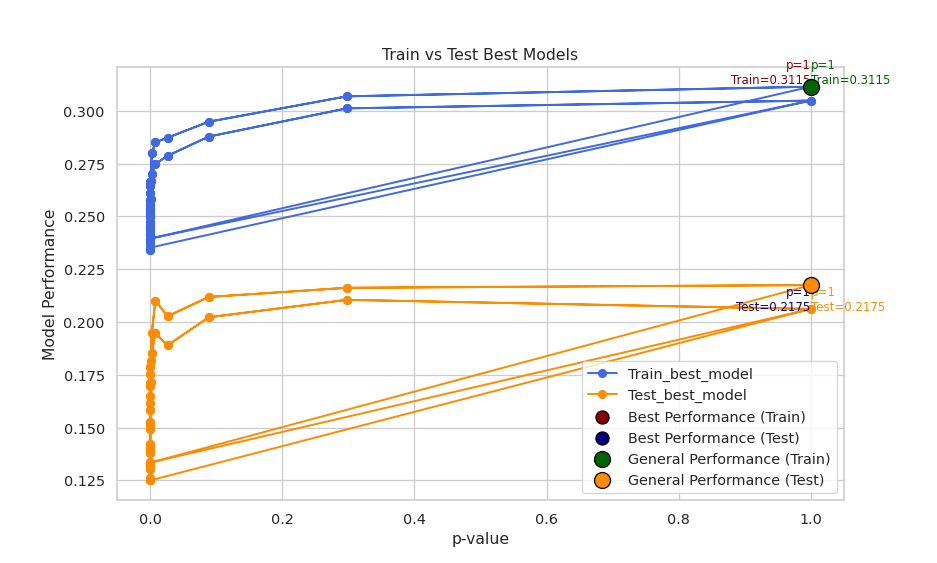

2. Reporting Generalized Performance:

|                     | 59                    |
|:--------------------|:----------------------|
| clump_p1            | 1.0                   |
| clump_r2            | 0.1                   |
| clump_kb            | 200.0                 |
| p_window_size       | 200.0                 |
| p_slide_size        | 50.0                  |
| p_LD_threshold      | 0.25                  |
| pvalue              | 1.0                   |
| numberofpca         | 6.0                   |
| tempalpha           | 0.1                   |
| l1weight            | 0.1                   |
| bayesmodel          | 0.0                   |
| model               | 0.0                   |
| h2                  | 0.0                   |
| lambda              | 0.0                   |
| numberofvariants(m) | 0.0                   |
| Train_pure_prs      | 4.836653328754714e-06 |
| Train_null_model    | 0.23001030414198947   |
| Train_best_model    | 0.31148229935088284   |
|

<IPython.core.display.Javascript object>


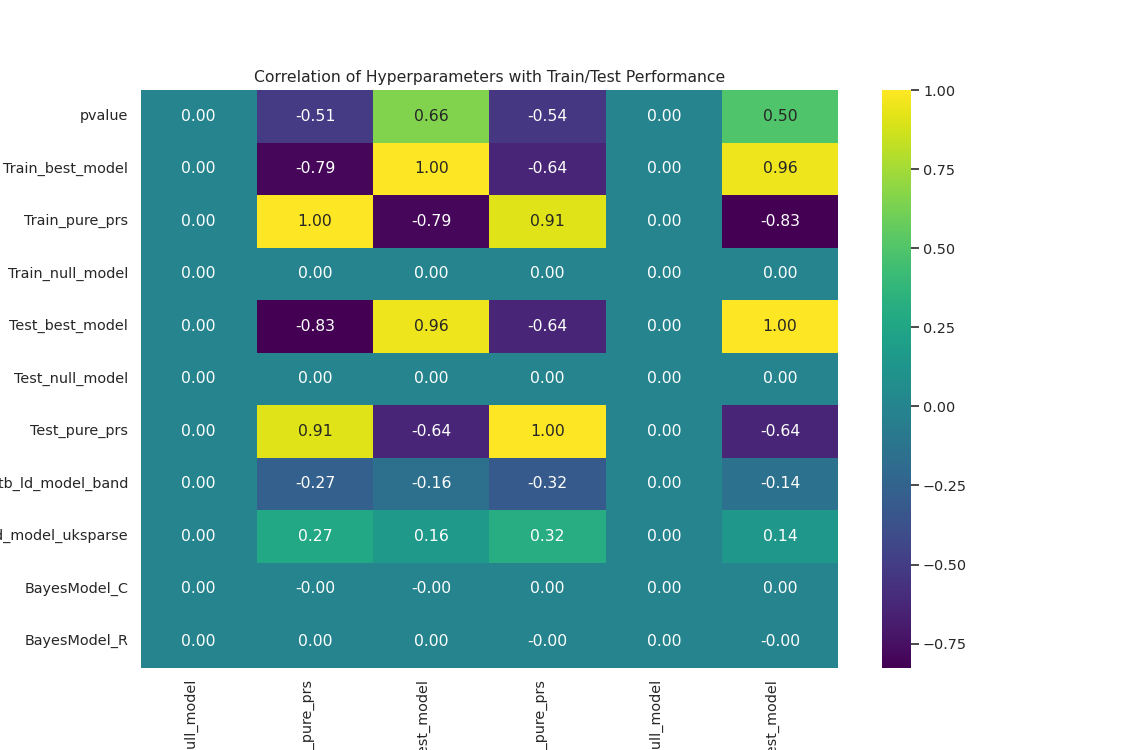

<IPython.core.display.Javascript object>


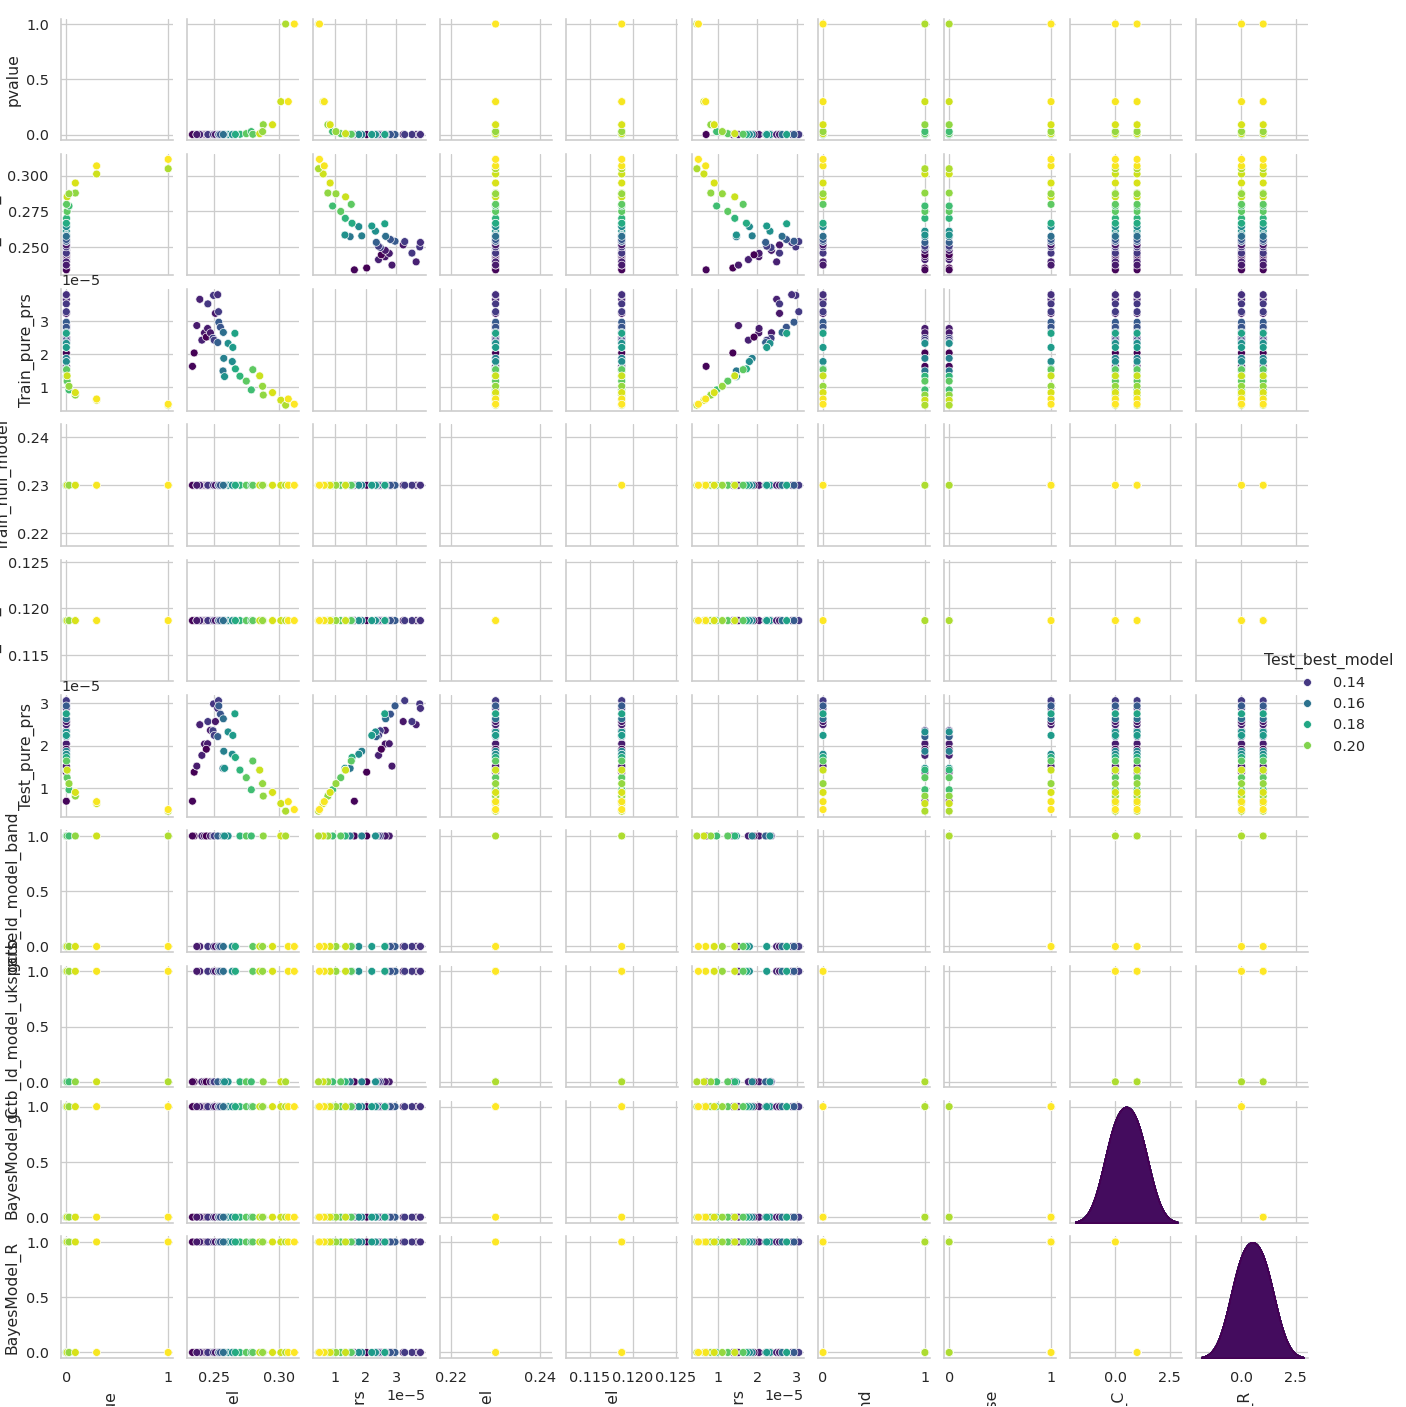

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

df = divided_result.sort_values(by='Train_best_model', ascending=False)
print("1. Reporting Based on Best Training Performance:\n")
print(df.iloc[0].to_markdown())


 
df = divided_result.copy()

# Plot Train and Test best models against p-values
plt.figure(figsize=(10, 6))
plt.plot(df['pvalue'], df['Train_best_model'], label='Train_best_model', marker='o', color='royalblue')
plt.plot(df['pvalue'], df['Test_best_model'], label='Test_best_model', marker='o', color='darkorange')

# Highlight the p-value where both train and test are high
best_index = df[['Train_best_model']].sum(axis=1).idxmax()
best_pvalue = df.loc[best_index, 'pvalue']
best_train = df.loc[best_index, 'Train_best_model']
best_test = df.loc[best_index, 'Test_best_model']

# Use dark colors for the circles
plt.scatter(best_pvalue, best_train, color='darkred', s=100, label=f'Best Performance (Train)', edgecolor='black', zorder=5)
plt.scatter(best_pvalue, best_test, color='darkblue', s=100, label=f'Best Performance (Test)', edgecolor='black', zorder=5)

# Annotate the best performance with p-value, train, and test values
plt.text(best_pvalue, best_train, f'p={best_pvalue:.4g}\nTrain={best_train:.4g}', ha='right', va='bottom', fontsize=9, color='darkred')
plt.text(best_pvalue, best_test, f'p={best_pvalue:.4g}\nTest={best_test:.4g}', ha='right', va='top', fontsize=9, color='darkblue')

# Calculate Difference and Sum
df['Difference'] = abs(df['Train_best_model'] - df['Test_best_model'])
df['Sum'] = df['Train_best_model'] + df['Test_best_model']

# Sort the DataFrame
sorted_df = df.sort_values(by=['Sum', 'Difference'], ascending=[False, True])
#sorted_df = df.sort_values(by=[ 'Difference','Sum'], ascending=[  True,False])

# Highlight the general performance
general_index = sorted_df.index[0]
general_pvalue = sorted_df.loc[general_index, 'pvalue']
general_train = sorted_df.loc[general_index, 'Train_best_model']
general_test = sorted_df.loc[general_index, 'Test_best_model']

plt.scatter(general_pvalue, general_train, color='darkgreen', s=150, label='General Performance (Train)', edgecolor='black', zorder=6)
plt.scatter(general_pvalue, general_test, color='darkorange', s=150, label='General Performance (Test)', edgecolor='black', zorder=6)

# Annotate the general performance with p-value, train, and test values
plt.text(general_pvalue, general_train, f'p={general_pvalue:.4g}\nTrain={general_train:.4g}', ha='left', va='bottom', fontsize=9, color='darkgreen')
plt.text(general_pvalue, general_test, f'p={general_pvalue:.4g}\nTest={general_test:.4g}', ha='left', va='top', fontsize=9, color='darkorange')

# Add labels and legend
plt.xlabel('p-value')
plt.ylabel('Model Performance')
plt.title('Train vs Test Best Models')
plt.legend()
plt.show()
 




print("2. Reporting Generalized Performance:\n")
df = divided_result.copy()
df['Difference'] = abs(df['Train_best_model'] - df['Test_best_model'])
df['Sum'] = df['Train_best_model'] + df['Test_best_model']
sorted_df = df.sort_values(by=['Sum', 'Difference'], ascending=[False, True])
print(sorted_df.iloc[0].to_markdown())


print("3. Reporting the correlation of hyperparameters and the performance of 'Train_null_model', 'Train_pure_prs', 'Train_best_model', 'Test_pure_prs', 'Test_null_model', and 'Test_best_model':\n")

print("3. For string hyperparameters, we used one-hot encoding to find the correlation between string hyperparameters and 'Train_null_model', 'Train_pure_prs', 'Train_best_model', 'Test_pure_prs', 'Test_null_model', and 'Test_best_model'.")

print("3. We performed this analysis for those hyperparameters that have more than one unique value.")

correlation_columns = [
 'Train_null_model', 'Train_pure_prs', 'Train_best_model',
 'Test_pure_prs', 'Test_null_model', 'Test_best_model'
]

hyperparams = [col for col in divided_result.columns if len(divided_result[col].unique()) > 1]
hyperparams = list(set(hyperparams+correlation_columns))
 
# Separate numeric and string columns
numeric_hyperparams = [col for col in hyperparams if pd.api.types.is_numeric_dtype(divided_result[col])]
string_hyperparams = [col for col in hyperparams if pd.api.types.is_string_dtype(divided_result[col])]


# Encode string columns using one-hot encoding
divided_result_encoded = pd.get_dummies(divided_result, columns=string_hyperparams)

# Combine numeric hyperparams with the new one-hot encoded columns
encoded_columns = [col for col in divided_result_encoded.columns if col.startswith(tuple(string_hyperparams))]
hyperparams = numeric_hyperparams + encoded_columns
 

# Calculate correlations
correlations = divided_result_encoded[hyperparams].corr()
 
# Display correlation of hyperparameters with train/test performance columns
hyperparam_correlations = correlations.loc[hyperparams, correlation_columns]
 
hyperparam_correlations = hyperparam_correlations.fillna(0)

# Plotting the correlation heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(hyperparam_correlations, annot=True, cmap='viridis', fmt='.2f', cbar=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

# Rotate y-axis labels to horizontal
#ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va='center')

plt.title('Correlation of Hyperparameters with Train/Test Performance')
plt.show() 

sns.set_theme(style="whitegrid")  # Choose your preferred style
pairplot = sns.pairplot(divided_result_encoded[hyperparams],hue = 'Test_best_model', palette='viridis')

# Adjust the figure size
pairplot.fig.set_size_inches(15, 15)  # You can adjust the size as needed

for ax in pairplot.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), rotation=90, ha='right')  # X-axis labels vertical
    #ax.set_ylabel(ax.get_ylabel(), rotation=0, va='bottom')  # Y-axis labels horizontal

# Show the plot
plt.show()


